# Extract point values at Lon, Lat, Dep, Time locations from a curvilinear ocean model grid

imports

In [1]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar
import xesmf as xe
from tqdm import tqdm

# plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("xesmf version =", xe.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()

python version = 3.10.
numpy version = 1.24.4
xarray version = 2023.8.0
dask version = 2023.3.0
pandas version = 2.1.0
xesmf version = 0.8
matplotlib version = 3.7.1
cartopy version = 0.22.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/JRA55'

In [2]:
os.listdir()

['JRA55_pic_1m_ptrc_T_2018-2022.nc',
 'JRA55_co2_1m_diad_T_Y2023.nc',
 'JRA55_13co2_1m_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1m_diad_T_2018-2022.nc',
 'JRA55_hydroOFF_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1m_diad_T_Y2023.nc',
 'JRA55_ndep_1m_diad_T_1998-2007.nc',
 'JRA55_pic_1m_ptrc_T_1998-2007.nc',
 'JRA55_hydroOFF_1m_icemod_1958-2022.nc',
 'JRA55_pic_1m_icemod_1958-2022.nc',
 'JRA55_ndep_1y_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1y_bioscaler_1850-2022.nc',
 'JRA55_ndep_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1978-1987.nc',
 'JRA55_pic_1m_grid_V_Y2023.nc',
 'JRA55_ndep_1m_ptrc_T_1958-1967.nc',
 'JRA55_hydroOFF_1m_diad_T_1958-1967.nc',
 'JRA55_pic_1m_diad_T_1958-1967.nc',
 'JRA55_ndep_1m_diad_T_1968-1977.nc',
 'JRA55_ndep_1m_diad_T_1978-1987.nc',
 'JRA55_pic_1m_thetao_1958-2022.nc',
 'JRA55_hydroOFF_1y_bioscaler_1850-2022.nc'

load the model data

In [3]:
phy_vars = ['thetao', 'so', 'mldr10_1']
bgc_vars = ['O2', 'DIC', 'DIC_13', 'Alkalini', 'NH4', 'NO3', 'PO4', 'Si', 'Fer', 'NCHL', 'DCHL']
co2_vars = ['DIC', 'DIC_13', 'Alkalini']

### PIC ###
print("Loading PIC experiment data")
fnames = ["JRA55_pic_1m_ptrc_T_1958-1967.nc",
          "JRA55_pic_1m_ptrc_T_1968-1977.nc",
          "JRA55_pic_1m_ptrc_T_1978-1987.nc",
          "JRA55_pic_1m_ptrc_T_1988-1997.nc",
          "JRA55_pic_1m_ptrc_T_1998-2007.nc",
          "JRA55_pic_1m_ptrc_T_2008-2017.nc",
          "JRA55_pic_1m_ptrc_T_2018-2022.nc"]
dat1 = xr.open_dataset(fnames[0])[bgc_vars]
dat2 = xr.open_dataset(fnames[1])[bgc_vars]
dat3 = xr.open_dataset(fnames[2])[bgc_vars]
dat4 = xr.open_dataset(fnames[3])[bgc_vars]
dat5 = xr.open_dataset(fnames[4])[bgc_vars]
dat6 = xr.open_dataset(fnames[5])[bgc_vars]
dat7 = xr.open_dataset(fnames[6])[bgc_vars]
print("  Doing BGC variables")
pic_bgc = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")
dat1 = xr.open_dataset(fnames[0])['Age']
dat2 = xr.open_dataset(fnames[1])['Age']
dat3 = xr.open_dataset(fnames[2])['Age']
dat4 = xr.open_dataset(fnames[3])['Age']
dat5 = xr.open_dataset(fnames[4])['Age']
dat6 = xr.open_dataset(fnames[5])['Age']
dat7 = xr.open_dataset(fnames[6])['Age']
print("  Doing Age variable")
pic_age = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")
print("  Doing Physical variables")
pic_phy = xr.open_dataset("JRA55_pic_1m_grid_T_1958-2022.nc")[phy_vars]


### CO2 ###
print("Loading CO2 experiment data")
print("  Doing BGC variables")
co2_bgc = xr.open_dataset("JRA55_co2_1m_ptrc_T_1958-2022.nc")[co2_vars]


### 13CO2 ###
print("Loading 13-CO2 experiment data")
print("  Doing BGC variables")
c13_bgc = xr.open_dataset("JRA55_13co2_1m_ptrc_T_1958-2022.nc")[co2_vars]


### Ndep ###
print("Loading Ndep experiment data")
fnames = ["JRA55_ndep_1m_ptrc_T_1958-1967.nc",
          "JRA55_ndep_1m_ptrc_T_1968-1977.nc",
          "JRA55_ndep_1m_ptrc_T_1978-1987.nc",
          "JRA55_ndep_1m_ptrc_T_1988-1997.nc",
          "JRA55_ndep_1m_ptrc_T_1998-2007.nc",
          "JRA55_ndep_1m_ptrc_T_2008-2017.nc",
          "JRA55_ndep_1m_ptrc_T_2018-2022.nc"]
dat1 = xr.open_dataset(fnames[0])[bgc_vars]
dat2 = xr.open_dataset(fnames[1])[bgc_vars]
dat3 = xr.open_dataset(fnames[2])[bgc_vars]
dat4 = xr.open_dataset(fnames[3])[bgc_vars]
dat5 = xr.open_dataset(fnames[4])[bgc_vars]
dat6 = xr.open_dataset(fnames[5])[bgc_vars]
dat7 = xr.open_dataset(fnames[6])[bgc_vars]
print("  Doing BGC variables")
ndep_bgc = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")



Loading PIC experiment data
  Doing BGC variables
  Doing Age variable
  Doing Physical variables
Loading CO2 experiment data
  Doing BGC variables
Loading 13-CO2 experiment data
  Doing BGC variables
Loading Ndep experiment data
  Doing BGC variables


In [4]:
co2_bgc

<xarray.Dataset>
Dimensions:        (record: 65, time_counter: 12, deptht: 31, y: 149, x: 182)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1958-01-16 12:00:00 ... 1958-12-16 1...
Dimensions without coordinates: record, y, x
Data variables:
    DIC            (record, time_counter, deptht, y, x) float32 ...
    DIC_13         (record, time_counter, deptht, y, x) float32 ...
    Alkalini       (record, time_counter, deptht, y, x) float32 ...
Attributes: (12/13)
    Conventions:               CF-1.6
    name:                      ORCA2_1m_19580101_19581231_ptrc_T
    description:               pisces sms variables
    title:                     pisces sms variables
    timeStamp:                 2023-Apr-20 17:27:24 GMT
    uuid:                      49334963-dcb1-44a6-8ebc-abbbb0296154
    ...                        ...
    ni:                        182
    jbegin:                    0
    nj:                        2
    history:                   Mon Aug 28 01:10:11 2023: ncecat -O -n 65,4,1 ...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

## alter the data arrays such that we fold the 2 time dimensions into 1

### First, rename some dimensions for clarity and reassign the month coordinate

In [5]:
pic_phy = pic_phy.rename({"time_counter": "month"})
pic_phy = pic_phy.rename({"record": "year"})
pic_phy = pic_phy.assign_coords(month=np.arange(1,13,1))

pic_age = pic_age.rename({"time_counter": "month"})
pic_age = pic_age.rename({"record": "year"})
pic_age = pic_age.assign_coords(month=np.arange(1,13,1))

pic_bgc = pic_bgc.rename({"time_counter": "month"})
pic_bgc = pic_bgc.rename({"record": "year"})
pic_bgc = pic_bgc.assign_coords(month=np.arange(1,13,1))

co2_bgc = co2_bgc.rename({"time_counter": "month"})
co2_bgc = co2_bgc.rename({"record": "year"})
co2_bgc = co2_bgc.assign_coords(month=np.arange(1,13,1))

c13_bgc = c13_bgc.rename({"time_counter": "month"})
c13_bgc = c13_bgc.rename({"record": "year"})
c13_bgc = c13_bgc.assign_coords(month=np.arange(1,13,1))

ndep_bgc = ndep_bgc.rename({"time_counter": "month"})
ndep_bgc = ndep_bgc.rename({"record": "year"})
ndep_bgc = ndep_bgc.assign_coords(month=np.arange(1,13,1))


### create new time variable that will become added to the xarray

In [6]:
from datetime import datetime, timedelta
start_date = datetime(1958, 1, 1)
end_date = datetime(2022, 12, 31)
time = pd.date_range(start=start_date, end=end_date, freq="MS") + pd.DateOffset(days=14)
time

DatetimeIndex(['1958-01-15', '1958-02-15', '1958-03-15', '1958-04-15',
               '1958-05-15', '1958-06-15', '1958-07-15', '1958-08-15',
               '1958-09-15', '1958-10-15',
               ...
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15', '2022-09-15', '2022-10-15',
               '2022-11-15', '2022-12-15'],
              dtype='datetime64[ns]', length=780, freq=None)

### Fold year and month into each other to make a single time dimension

In [7]:
pic_phy = pic_phy.assign_coords(stacked_time=time)
pic_bgc = pic_bgc.assign_coords(stacked_time=time)
co2_bgc = co2_bgc.assign_coords(stacked_time=time)
c13_bgc = c13_bgc.assign_coords(stacked_time=time)
ndep_bgc = ndep_bgc.assign_coords(stacked_time=time)

# stack the year and month dimensions into the new dimension
#   the new coordinate should have dimensions the same size as our new time coordinate
pic_phy = pic_phy.stack(stacked_time=("year", "month"))
pic_bgc = pic_bgc.stack(stacked_time=("year", "month"))
co2_bgc = co2_bgc.stack(stacked_time=("year", "month"))
c13_bgc = c13_bgc.stack(stacked_time=("year", "month"))
ndep_bgc = ndep_bgc.stack(stacked_time=("year", "month"))

# we remove the "stacked_time" coordinate and everything associated with it (year + month)
pic_phy = pic_phy.drop_vars(["stacked_time", "year", "month"])
pic_bgc = pic_bgc.drop_vars(["stacked_time", "year", "month"])
co2_bgc = co2_bgc.drop_vars(["stacked_time", "year", "month"])
c13_bgc = c13_bgc.drop_vars(["stacked_time", "year", "month"])
ndep_bgc = ndep_bgc.drop_vars(["stacked_time", "year", "month"])

# we make the remaining time coordinate, with now the dimensions we want, have the values we want
pic_phy = pic_phy.assign_coords(time_centered=time)
pic_bgc = pic_bgc.assign_coords(time_centered=time)
co2_bgc = co2_bgc.assign_coords(time_centered=time)
c13_bgc = c13_bgc.assign_coords(time_centered=time)
ndep_bgc = ndep_bgc.assign_coords(time_centered=time)

# for some reason, do different recipe for Age dataarray
pic_age = pic_age.stack(stacked_time=("year", "month"))
pic_age = pic_age.drop_vars(["stacked_time", "year", "month"])
pic_age = pic_age.rename({"stacked_time":"time"})
pic_age = pic_age.assign_coords(time=time)
pic_age = pic_age.drop_vars(["time_centered"])


### get the variables we want

In [8]:
pic_t = pic_phy.thetao
pic_s = pic_phy.so
pic_mld = pic_phy.mldr10_1

pic_dic = pic_bgc.DIC
pic_dic13 = pic_bgc.DIC_13
pic_alk = pic_bgc.Alkalini
pic_oxy = pic_bgc.O2
pic_nh4 = pic_bgc.NH4
pic_no3 = pic_bgc.NO3
pic_po4 = pic_bgc.PO4
pic_sil = pic_bgc.Si
pic_dfe = pic_bgc.Fer
pic_nch = pic_bgc.NCHL
pic_dch = pic_bgc.DCHL

co2_dic = co2_bgc.DIC
co2_dic13 = co2_bgc.DIC_13
co2_alk = co2_bgc.Alkalini

c13_dic = c13_bgc.DIC
c13_dic13 = c13_bgc.DIC_13

ndep_dic = ndep_bgc.DIC
ndep_dic13 = ndep_bgc.DIC_13
ndep_alk = ndep_bgc.Alkalini
ndep_oxy = ndep_bgc.O2
ndep_nh4 = ndep_bgc.NH4
ndep_no3 = ndep_bgc.NO3
ndep_po4 = ndep_bgc.PO4
ndep_sil = ndep_bgc.Si
ndep_dfe = ndep_bgc.Fer
ndep_nch = ndep_bgc.NCHL
ndep_dch = ndep_bgc.DCHL

pic_t = pic_t.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_s = pic_s.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_mld = pic_mld.rename({"stacked_time":"time"}).assign_coords(time=time)

pic_dic = pic_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dic13 = pic_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_alk = pic_alk.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_oxy = pic_oxy.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_nh4 = pic_nh4.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_no3 = pic_no3.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_po4 = pic_po4.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_sil = pic_sil.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dfe = pic_dfe.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_nch = pic_nch.rename({"stacked_time":"time"}).assign_coords(time=time)
pic_dch = pic_dch.rename({"stacked_time":"time"}).assign_coords(time=time)

co2_dic = co2_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
co2_dic13 = co2_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
co2_alk = co2_alk.rename({"stacked_time":"time"}).assign_coords(time=time)


c13_dic = c13_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
c13_dic13 = c13_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)


ndep_dic = ndep_dic.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dic13 = ndep_dic13.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_alk = ndep_alk.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_oxy = ndep_oxy.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_nh4 = ndep_nh4.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_no3 = ndep_no3.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_po4 = ndep_po4.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_sil = ndep_sil.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dfe = ndep_dfe.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_nch = ndep_nch.rename({"stacked_time":"time"}).assign_coords(time=time)
ndep_dch = ndep_dch.rename({"stacked_time":"time"}).assign_coords(time=time)


### apply chunking

In [9]:
#ProgressBar().register()
chunky = {'time':1, 'deptht':31, 'y':149, 'x':182}
chunkymld = {'time':1, 'y':149, 'x':182}

pic_t = pic_t.chunk(chunks=chunky)
pic_s = pic_s.chunk(chunks=chunky)
pic_mld = pic_mld.chunk(chunks=chunkymld)
pic_age = pic_age.chunk(chunks=chunky)

pic_dic = pic_dic.chunk(chunks=chunky)
pic_dic13 = pic_dic13.chunk(chunks=chunky)
pic_alk = pic_alk.chunk(chunks=chunky)
pic_oxy = pic_oxy.chunk(chunks=chunky)
pic_nh4 = pic_nh4.chunk(chunks=chunky)
pic_no3 = pic_no3.chunk(chunks=chunky)
pic_po4 = pic_po4.chunk(chunks=chunky)
pic_sil = pic_sil.chunk(chunks=chunky)
pic_dfe = pic_dfe.chunk(chunks=chunky)
pic_nch = pic_nch.chunk(chunks=chunky)
pic_dch = pic_dch.chunk(chunks=chunky)

co2_dic = co2_dic.chunk(chunks=chunky)
co2_dic13 = co2_dic13.chunk(chunks=chunky)
co2_alk = co2_alk.chunk(chunks=chunky)

c13_dic = c13_dic.chunk(chunks=chunky)
c13_dic13 = c13_dic13.chunk(chunks=chunky)

ndep_dic = ndep_dic.chunk(chunks=chunky)
ndep_dic13 = ndep_dic13.chunk(chunks=chunky)
ndep_alk = ndep_alk.chunk(chunks=chunky)
ndep_oxy = ndep_oxy.chunk(chunks=chunky)
ndep_nh4 = ndep_nh4.chunk(chunks=chunky)
ndep_no3 = ndep_no3.chunk(chunks=chunky)
ndep_po4 = ndep_po4.chunk(chunks=chunky)
ndep_sil = ndep_sil.chunk(chunks=chunky)
ndep_dfe = ndep_dfe.chunk(chunks=chunky)
ndep_nch = ndep_nch.chunk(chunks=chunky)
ndep_dch = ndep_dch.chunk(chunks=chunky)


In [10]:
pic_t


<xarray.DataArray 'thetao' (deptht: 31, y: 149, x: 182, time: 780)>
dask.array<xarray-<this-array>, shape=(31, 149, 182, 780), dtype=float32, chunksize=(31, 149, 182, 1), chunktype=numpy.ndarray>
Coordinates:
  * deptht   (deptht) float32 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
    nav_lat  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * time     (time) datetime64[ns] 1958-01-15 1958-02-15 ... 2022-12-15
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

## Regrid the dataarrays!

In [11]:
### create the rectilinear grid
ds_out = xe.util.grid_global(0.5,0.5)
ds_out


<xarray.Dataset>
Dimensions:  (y: 360, x: 720, y_b: 361, x_b: 721)
Coordinates:
    lon      (y, x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    lat      (y, x) float64 -89.75 -89.75 -89.75 -89.75 ... 89.75 89.75 89.75
    lon_b    (y_b, x_b) float64 -180.0 -179.5 -179.0 ... 179.0 179.5 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [12]:
# regrid the curvilinear --> rectilinear
regridder = xe.Regridder(pic_phy, ds_out, 'bilinear', ignore_degenerate=True)
print("Regridding PIC physical variables")
pic_t_reg = regridder(pic_t)
pic_s_reg = regridder(pic_s)
pic_mld_reg = regridder(pic_mld)
pic_age_reg = regridder(pic_age)
print("Regridding PIC BGC variables")
pic_dic_reg = regridder(pic_dic)
pic_dic13_reg = regridder(pic_dic13)
pic_alk_reg = regridder(pic_alk)
pic_oxy_reg = regridder(pic_oxy)
pic_nh4_reg = regridder(pic_nh4)
pic_no3_reg = regridder(pic_no3)
pic_po4_reg = regridder(pic_po4)
pic_dfe_reg = regridder(pic_dfe)
pic_sil_reg = regridder(pic_sil)
pic_nch_reg = regridder(pic_nch)
pic_dch_reg = regridder(pic_dch)
print("Regridding CO2 BGC variables")
co2_dic_reg = regridder(co2_dic)
co2_dic13_reg = regridder(co2_dic13)
co2_alk_reg = regridder(co2_alk)
print("Regridding 13CO2 BGC variables")
c13_dic_reg = regridder(c13_dic)
c13_dic13_reg = regridder(c13_dic13)
print("Regridding Ndep BGC variables")
ndep_dic_reg = regridder(ndep_dic)
ndep_dic13_reg = regridder(ndep_dic13)
ndep_alk_reg = regridder(ndep_alk)
ndep_oxy_reg = regridder(ndep_oxy)
ndep_nh4_reg = regridder(ndep_nh4)
ndep_no3_reg = regridder(ndep_no3)
ndep_po4_reg = regridder(ndep_po4)
ndep_dfe_reg = regridder(ndep_dfe)
ndep_sil_reg = regridder(ndep_sil)
ndep_nch_reg = regridder(ndep_nch)
ndep_dch_reg = regridder(ndep_dch)



Regridding PIC physical variables


/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks

Regridding PIC BGC variables


/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks

Regridding CO2 BGC variables


/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(


Regridding 13CO2 BGC variables


/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(


Regridding Ndep BGC variables


/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks by factor of 12
  intermediate = blockwise(
/scratch/pbuchanan/job_25070367/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/array/routines.py:325: PerformanceWarning: Increasing number of chunks

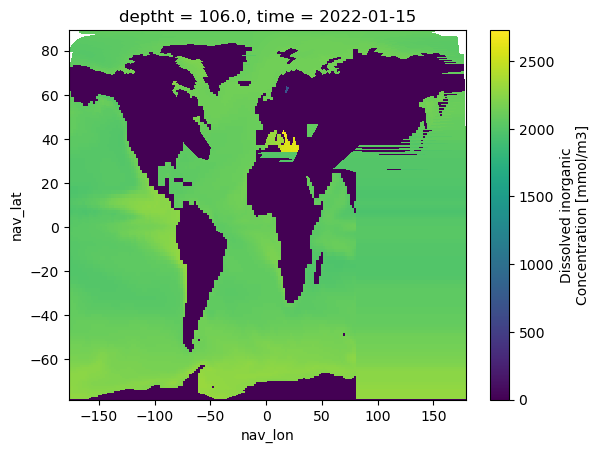

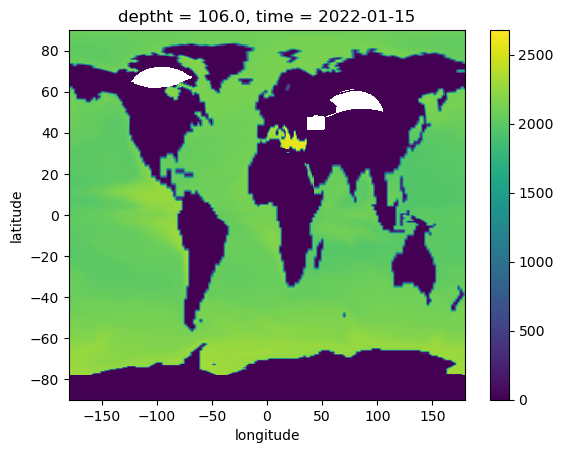

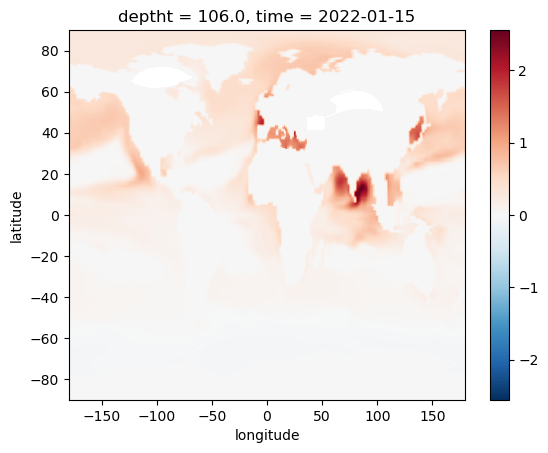

In [13]:
### did the regridding work?
plt.figure()
ax = plt.axes()
pic_dic.isel(time=768,deptht=10).plot.pcolormesh(ax=ax, x="nav_lon", y="nav_lat")
plt.figure()
ax = plt.axes()
pic_dic_reg.isel(time=768,deptht=10).plot.pcolormesh(ax=ax, x="lon", y="lat")
plt.figure()
ax = plt.axes()
(ndep_no3_reg.isel(time=768,deptht=10)-pic_no3_reg.isel(time=768,deptht=10)).plot.pcolormesh(ax=ax, x="lon", y="lat")

### Load the observational datafram

In [14]:

oiso_surf = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="OISO_surf")
oiso_stn = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="OISO_stn")
naspg_surf = pd.read_excel("/home/pbuchanan/for_Coraline/OISO_SURATLANT_C13_datasets_20230712.xlsx", sheet_name="NASPG_surf")

oiso_surf


,Cruise,Year,Month,Day,Hour,Minute,Latitude,Longitude,Depth,d13C_DIC,QF_13C,SST,QF_SST,SSS,QF_SSS
0,oiso2,1998,8,28,16,10,-49.217000,70.700000,5,1.150000,2,2.67,2.0,33.648,2
1,oiso2,1998,8,28,20,0,-48.317000,71.100000,5,1.100000,2,2.18,2.0,33.848,2
2,oiso2,1998,8,29,5,45,-46.567000,72.033000,5,1.270000,2,4.82,2.0,33.748,2
3,oiso2,1998,8,29,10,0,-45.717000,72.683000,5,1.270000,2,4.62,3.0,33.757,3
4,oiso2,1998,8,29,12,0,-45.267000,73.033000,5,1.510000,2,4.39,2.0,33.748,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,oiso32,2022,2,28,6,38,-31.276667,67.950000,5,0.445988,2,23.68,2.0,35.872,2
1069,oiso32,2022,2,28,14,58,-30.000000,66.418333,5,0.395174,2,24.33,2.0,35.853,2
1070,oiso32,2022,2,28,20,50,-32.441667,69.491667,5,0.564956,2,22.47,2.0,35.935,2
1071,oiso32,2022,2,28,23,3,-29.286667,65.211667,5,0.584908,2,24.59,2.0,35.845,2


### extract the data

In [15]:

### now that we are on a regular grid, we can replace the dimensions x and y with lon and lat
lon = pic_t_reg.coords['lon'].values[0]
lat = pic_t_reg.coords['lat'].values[:,0]

pic_t_reg = pic_t_reg.assign_coords(x=lon, y=lat)
pic_s_reg = pic_s_reg.assign_coords(x=lon, y=lat)
pic_mld_reg = pic_mld_reg.assign_coords(x=lon, y=lat)
pic_age_reg = pic_age_reg.assign_coords(x=lon, y=lat)
pic_dic_reg = pic_dic_reg.assign_coords(x=lon, y=lat)
pic_dic13_reg = pic_dic13_reg.assign_coords(x=lon, y=lat)
pic_alk_reg = pic_alk_reg.assign_coords(x=lon, y=lat)
pic_oxy_reg = pic_oxy_reg.assign_coords(x=lon, y=lat)
pic_nh4_reg = pic_nh4_reg.assign_coords(x=lon, y=lat)
pic_no3_reg = pic_no3_reg.assign_coords(x=lon, y=lat)
pic_po4_reg = pic_po4_reg.assign_coords(x=lon, y=lat)
pic_sil_reg = pic_sil_reg.assign_coords(x=lon, y=lat)
pic_dfe_reg = pic_dfe_reg.assign_coords(x=lon, y=lat)
pic_nch_reg = pic_nch_reg.assign_coords(x=lon, y=lat)
pic_dch_reg = pic_dch_reg.assign_coords(x=lon, y=lat)
co2_dic_reg = co2_dic_reg.assign_coords(x=lon, y=lat)
co2_dic13_reg = co2_dic13_reg.assign_coords(x=lon, y=lat)
co2_alk_reg = co2_alk_reg.assign_coords(x=lon, y=lat)
c13_dic_reg = c13_dic_reg.assign_coords(x=lon, y=lat)
c13_dic13_reg = c13_dic13_reg.assign_coords(x=lon, y=lat)
ndep_dic_reg = ndep_dic_reg.assign_coords(x=lon, y=lat)
ndep_dic13_reg = ndep_dic13_reg.assign_coords(x=lon, y=lat)
ndep_alk_reg = ndep_alk_reg.assign_coords(x=lon, y=lat)
ndep_oxy_reg = ndep_oxy_reg.assign_coords(x=lon, y=lat)
ndep_nh4_reg = ndep_nh4_reg.assign_coords(x=lon, y=lat)
ndep_no3_reg = ndep_no3_reg.assign_coords(x=lon, y=lat)
ndep_po4_reg = ndep_po4_reg.assign_coords(x=lon, y=lat)
ndep_sil_reg = ndep_sil_reg.assign_coords(x=lon, y=lat)
ndep_dfe_reg = ndep_dfe_reg.assign_coords(x=lon, y=lat)
ndep_nch_reg = ndep_nch_reg.assign_coords(x=lon, y=lat)
ndep_dch_reg = ndep_dch_reg.assign_coords(x=lon, y=lat)


#### extract for OISO surface data

In [16]:
oiso_surf


,Cruise,Year,Month,Day,Hour,Minute,Latitude,Longitude,Depth,d13C_DIC,QF_13C,SST,QF_SST,SSS,QF_SSS
0,oiso2,1998,8,28,16,10,-49.217000,70.700000,5,1.150000,2,2.67,2.0,33.648,2
1,oiso2,1998,8,28,20,0,-48.317000,71.100000,5,1.100000,2,2.18,2.0,33.848,2
2,oiso2,1998,8,29,5,45,-46.567000,72.033000,5,1.270000,2,4.82,2.0,33.748,2
3,oiso2,1998,8,29,10,0,-45.717000,72.683000,5,1.270000,2,4.62,3.0,33.757,3
4,oiso2,1998,8,29,12,0,-45.267000,73.033000,5,1.510000,2,4.39,2.0,33.748,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,oiso32,2022,2,28,6,38,-31.276667,67.950000,5,0.445988,2,23.68,2.0,35.872,2
1069,oiso32,2022,2,28,14,58,-30.000000,66.418333,5,0.395174,2,24.33,2.0,35.853,2
1070,oiso32,2022,2,28,20,50,-32.441667,69.491667,5,0.564956,2,22.47,2.0,35.935,2
1071,oiso32,2022,2,28,23,3,-29.286667,65.211667,5,0.584908,2,24.59,2.0,35.845,2


In [21]:
oiso_surf['mod_PIC_T'] = np.nan
oiso_surf['mod_PIC_S'] = np.nan
oiso_surf['mod_PIC_MLD'] = np.nan
oiso_surf['mod_PIC_Age'] = np.nan
oiso_surf['mod_PIC_DIC'] = np.nan
oiso_surf['mod_PIC_DIC13'] = np.nan
oiso_surf['mod_PIC_Alk'] = np.nan
oiso_surf['mod_PIC_Oxy'] = np.nan
oiso_surf['mod_PIC_NH4'] = np.nan
oiso_surf['mod_PIC_NO3'] = np.nan
oiso_surf['mod_PIC_PO4'] = np.nan
oiso_surf['mod_PIC_Sil'] = np.nan
oiso_surf['mod_PIC_dFe'] = np.nan
oiso_surf['mod_PIC_nChl'] = np.nan
oiso_surf['mod_PIC_dChl'] = np.nan
oiso_surf['mod_CO2_DIC'] = np.nan
oiso_surf['mod_CO2_DIC13'] = np.nan
oiso_surf['mod_CO2_Alk'] = np.nan
oiso_surf['mod_13CO2_DIC'] = np.nan
oiso_surf['mod_13CO2_DIC13'] = np.nan
oiso_surf['mod_NDEP_DIC'] = np.nan
oiso_surf['mod_NDEP_DIC13'] = np.nan
oiso_surf['mod_NDEP_Alk'] = np.nan
oiso_surf['mod_NDEP_Oxy'] = np.nan
oiso_surf['mod_NDEP_NH4'] = np.nan
oiso_surf['mod_NDEP_NO3'] = np.nan
oiso_surf['mod_NDEP_PO4'] = np.nan
oiso_surf['mod_NDEP_Sil'] = np.nan
oiso_surf['mod_NDEP_dFe'] = np.nan
oiso_surf['mod_NDEP_nChl'] = np.nan
oiso_surf['mod_NDEP_dChl'] = np.nan

for ii in tqdm(np.arange(len(oiso_surf)), desc="extracting OISO surface data"):
    print("%i of %i"%(ii,len(oiso_surf)))
    xx = oiso_surf["Longitude"][ii]
    yy = oiso_surf["Latitude"][ii]
    zz = oiso_surf["Depth"][ii]
    yr = oiso_surf["Year"][ii]
    mm = oiso_surf["Month"][ii]
    dd = oiso_surf["Day"][ii]
    hh = oiso_surf["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    oiso_surf.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_surf.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    


extracting OISO surface data:   0%|          | 0/1073 [00:00<?, ?it/s]

0 of 1073


extracting OISO surface data:   0%|          | 1/1073 [00:05<1:29:27,  5.01s/it]

1 of 1073


extracting OISO surface data:   0%|          | 2/1073 [00:09<1:27:52,  4.92s/it]

2 of 1073


extracting OISO surface data:   0%|          | 3/1073 [00:14<1:27:22,  4.90s/it]

3 of 1073


extracting OISO surface data:   0%|          | 4/1073 [00:19<1:27:43,  4.92s/it]

4 of 1073


extracting OISO surface data:   0%|          | 5/1073 [00:24<1:27:19,  4.91s/it]

5 of 1073


extracting OISO surface data:   1%|          | 6/1073 [00:29<1:27:09,  4.90s/it]

6 of 1073


extracting OISO surface data:   1%|          | 7/1073 [00:34<1:28:50,  5.00s/it]

7 of 1073


extracting OISO surface data:   1%|          | 8/1073 [00:39<1:28:04,  4.96s/it]

8 of 1073


extracting OISO surface data:   1%|          | 9/1073 [00:44<1:27:14,  4.92s/it]

9 of 1073


extracting OISO surface data:   1%|          | 10/1073 [00:49<1:27:10,  4.92s/it]

10 of 1073


extracting OISO surface data:   1%|          | 11/1073 [00:54<1:26:54,  4.91s/it]

11 of 1073


extracting OISO surface data:   1%|          | 12/1073 [00:59<1:26:28,  4.89s/it]

12 of 1073


extracting OISO surface data:   1%|          | 13/1073 [01:03<1:26:12,  4.88s/it]

13 of 1073


extracting OISO surface data:   1%|▏         | 14/1073 [01:08<1:26:00,  4.87s/it]

14 of 1073


extracting OISO surface data:   1%|▏         | 15/1073 [01:13<1:26:17,  4.89s/it]

15 of 1073


extracting OISO surface data:   1%|▏         | 16/1073 [01:18<1:25:57,  4.88s/it]

16 of 1073


extracting OISO surface data:   2%|▏         | 17/1073 [01:23<1:25:31,  4.86s/it]

17 of 1073


extracting OISO surface data:   2%|▏         | 18/1073 [01:28<1:25:19,  4.85s/it]

18 of 1073


extracting OISO surface data:   2%|▏         | 19/1073 [01:33<1:26:19,  4.91s/it]

19 of 1073


extracting OISO surface data:   2%|▏         | 20/1073 [01:38<1:25:43,  4.88s/it]

20 of 1073


extracting OISO surface data:   2%|▏         | 21/1073 [01:42<1:25:19,  4.87s/it]

21 of 1073


extracting OISO surface data:   2%|▏         | 22/1073 [01:47<1:25:07,  4.86s/it]

22 of 1073


extracting OISO surface data:   2%|▏         | 23/1073 [01:52<1:25:08,  4.87s/it]

23 of 1073


extracting OISO surface data:   2%|▏         | 24/1073 [01:57<1:24:40,  4.84s/it]

24 of 1073


extracting OISO surface data:   2%|▏         | 25/1073 [02:02<1:24:21,  4.83s/it]

25 of 1073


extracting OISO surface data:   2%|▏         | 26/1073 [02:07<1:24:17,  4.83s/it]

26 of 1073


extracting OISO surface data:   3%|▎         | 27/1073 [02:11<1:24:09,  4.83s/it]

27 of 1073


extracting OISO surface data:   3%|▎         | 28/1073 [02:16<1:24:10,  4.83s/it]

28 of 1073


extracting OISO surface data:   3%|▎         | 29/1073 [02:21<1:23:57,  4.83s/it]

29 of 1073


extracting OISO surface data:   3%|▎         | 30/1073 [02:26<1:23:55,  4.83s/it]

30 of 1073


extracting OISO surface data:   3%|▎         | 31/1073 [02:31<1:24:49,  4.88s/it]

31 of 1073


extracting OISO surface data:   3%|▎         | 32/1073 [02:36<1:24:24,  4.87s/it]

32 of 1073


extracting OISO surface data:   3%|▎         | 33/1073 [02:41<1:24:08,  4.85s/it]

33 of 1073


extracting OISO surface data:   3%|▎         | 34/1073 [02:45<1:23:53,  4.84s/it]

34 of 1073


extracting OISO surface data:   3%|▎         | 35/1073 [02:50<1:23:29,  4.83s/it]

35 of 1073


extracting OISO surface data:   3%|▎         | 36/1073 [02:55<1:23:16,  4.82s/it]

36 of 1073


extracting OISO surface data:   3%|▎         | 37/1073 [03:00<1:23:12,  4.82s/it]

37 of 1073


extracting OISO surface data:   4%|▎         | 38/1073 [03:05<1:23:32,  4.84s/it]

38 of 1073


extracting OISO surface data:   4%|▎         | 39/1073 [03:09<1:23:30,  4.85s/it]

39 of 1073


extracting OISO surface data:   4%|▎         | 40/1073 [03:14<1:23:14,  4.83s/it]

40 of 1073


extracting OISO surface data:   4%|▍         | 41/1073 [03:19<1:23:06,  4.83s/it]

41 of 1073


extracting OISO surface data:   4%|▍         | 42/1073 [03:24<1:23:58,  4.89s/it]

42 of 1073


extracting OISO surface data:   4%|▍         | 43/1073 [03:29<1:23:31,  4.87s/it]

43 of 1073


extracting OISO surface data:   4%|▍         | 44/1073 [03:34<1:23:14,  4.85s/it]

44 of 1073


extracting OISO surface data:   4%|▍         | 45/1073 [03:39<1:23:02,  4.85s/it]

45 of 1073


extracting OISO surface data:   4%|▍         | 46/1073 [03:43<1:22:39,  4.83s/it]

46 of 1073


extracting OISO surface data:   4%|▍         | 47/1073 [03:48<1:22:31,  4.83s/it]

47 of 1073


extracting OISO surface data:   4%|▍         | 48/1073 [03:53<1:22:28,  4.83s/it]

48 of 1073


extracting OISO surface data:   5%|▍         | 49/1073 [03:58<1:22:24,  4.83s/it]

49 of 1073


extracting OISO surface data:   5%|▍         | 50/1073 [04:03<1:22:22,  4.83s/it]

50 of 1073


extracting OISO surface data:   5%|▍         | 51/1073 [04:08<1:22:10,  4.82s/it]

51 of 1073


extracting OISO surface data:   5%|▍         | 52/1073 [04:12<1:22:05,  4.82s/it]

52 of 1073


extracting OISO surface data:   5%|▍         | 53/1073 [04:17<1:22:58,  4.88s/it]

53 of 1073


extracting OISO surface data:   5%|▌         | 54/1073 [04:22<1:22:35,  4.86s/it]

54 of 1073


extracting OISO surface data:   5%|▌         | 55/1073 [04:27<1:22:22,  4.85s/it]

55 of 1073


extracting OISO surface data:   5%|▌         | 56/1073 [04:32<1:22:08,  4.85s/it]

56 of 1073


extracting OISO surface data:   5%|▌         | 57/1073 [04:37<1:21:49,  4.83s/it]

57 of 1073


extracting OISO surface data:   5%|▌         | 58/1073 [04:41<1:21:42,  4.83s/it]

58 of 1073


extracting OISO surface data:   5%|▌         | 59/1073 [04:46<1:21:41,  4.83s/it]

59 of 1073


extracting OISO surface data:   6%|▌         | 60/1073 [04:51<1:21:37,  4.83s/it]

60 of 1073


extracting OISO surface data:   6%|▌         | 61/1073 [04:56<1:21:35,  4.84s/it]

61 of 1073


extracting OISO surface data:   6%|▌         | 62/1073 [05:01<1:21:24,  4.83s/it]

62 of 1073


extracting OISO surface data:   6%|▌         | 63/1073 [05:06<1:21:17,  4.83s/it]

63 of 1073


extracting OISO surface data:   6%|▌         | 64/1073 [05:11<1:22:11,  4.89s/it]

64 of 1073


extracting OISO surface data:   6%|▌         | 65/1073 [05:15<1:21:54,  4.88s/it]

65 of 1073


extracting OISO surface data:   6%|▌         | 66/1073 [05:20<1:21:51,  4.88s/it]

66 of 1073


extracting OISO surface data:   6%|▌         | 67/1073 [05:25<1:21:34,  4.87s/it]

67 of 1073


extracting OISO surface data:   6%|▋         | 68/1073 [05:30<1:21:08,  4.84s/it]

68 of 1073


extracting OISO surface data:   6%|▋         | 69/1073 [05:35<1:20:54,  4.84s/it]

69 of 1073


extracting OISO surface data:   7%|▋         | 70/1073 [05:40<1:20:49,  4.84s/it]

70 of 1073


extracting OISO surface data:   7%|▋         | 71/1073 [05:44<1:20:41,  4.83s/it]

71 of 1073


extracting OISO surface data:   7%|▋         | 72/1073 [05:49<1:20:42,  4.84s/it]

72 of 1073


extracting OISO surface data:   7%|▋         | 73/1073 [05:54<1:20:36,  4.84s/it]

73 of 1073


extracting OISO surface data:   7%|▋         | 74/1073 [05:59<1:20:37,  4.84s/it]

74 of 1073


extracting OISO surface data:   7%|▋         | 75/1073 [06:04<1:21:37,  4.91s/it]

75 of 1073


extracting OISO surface data:   7%|▋         | 76/1073 [06:09<1:21:18,  4.89s/it]

76 of 1073


extracting OISO surface data:   7%|▋         | 77/1073 [06:14<1:21:05,  4.89s/it]

77 of 1073


extracting OISO surface data:   7%|▋         | 78/1073 [06:19<1:20:55,  4.88s/it]

78 of 1073


extracting OISO surface data:   7%|▋         | 79/1073 [06:24<1:20:37,  4.87s/it]

79 of 1073


extracting OISO surface data:   7%|▋         | 80/1073 [06:28<1:20:30,  4.86s/it]

80 of 1073


extracting OISO surface data:   8%|▊         | 81/1073 [06:33<1:20:31,  4.87s/it]

81 of 1073


extracting OISO surface data:   8%|▊         | 82/1073 [06:38<1:20:23,  4.87s/it]

82 of 1073


extracting OISO surface data:   8%|▊         | 83/1073 [06:43<1:20:24,  4.87s/it]

83 of 1073


extracting OISO surface data:   8%|▊         | 84/1073 [06:48<1:20:12,  4.87s/it]

84 of 1073


extracting OISO surface data:   8%|▊         | 85/1073 [06:53<1:20:06,  4.86s/it]

85 of 1073


extracting OISO surface data:   8%|▊         | 86/1073 [06:58<1:20:55,  4.92s/it]

86 of 1073


extracting OISO surface data:   8%|▊         | 87/1073 [07:03<1:20:32,  4.90s/it]

87 of 1073


extracting OISO surface data:   8%|▊         | 88/1073 [07:07<1:20:16,  4.89s/it]

88 of 1073


extracting OISO surface data:   8%|▊         | 89/1073 [07:12<1:20:05,  4.88s/it]

89 of 1073


extracting OISO surface data:   8%|▊         | 90/1073 [07:17<1:19:42,  4.87s/it]

90 of 1073


extracting OISO surface data:   8%|▊         | 91/1073 [07:22<1:19:30,  4.86s/it]

91 of 1073


extracting OISO surface data:   9%|▊         | 92/1073 [07:27<1:19:30,  4.86s/it]

92 of 1073


extracting OISO surface data:   9%|▊         | 93/1073 [07:32<1:19:28,  4.87s/it]

93 of 1073


extracting OISO surface data:   9%|▉         | 94/1073 [07:37<1:19:30,  4.87s/it]

94 of 1073


extracting OISO surface data:   9%|▉         | 95/1073 [07:42<1:19:29,  4.88s/it]

95 of 1073


extracting OISO surface data:   9%|▉         | 96/1073 [07:46<1:19:39,  4.89s/it]

96 of 1073


extracting OISO surface data:   9%|▉         | 97/1073 [07:52<1:20:31,  4.95s/it]

97 of 1073


extracting OISO surface data:   9%|▉         | 98/1073 [07:56<1:20:04,  4.93s/it]

98 of 1073


extracting OISO surface data:   9%|▉         | 99/1073 [08:01<1:19:44,  4.91s/it]

99 of 1073


extracting OISO surface data:   9%|▉         | 100/1073 [08:06<1:19:25,  4.90s/it]

100 of 1073


extracting OISO surface data:   9%|▉         | 101/1073 [08:11<1:19:03,  4.88s/it]

101 of 1073


extracting OISO surface data:  10%|▉         | 102/1073 [08:16<1:18:47,  4.87s/it]

102 of 1073


extracting OISO surface data:  10%|▉         | 103/1073 [08:21<1:18:45,  4.87s/it]

103 of 1073


extracting OISO surface data:  10%|▉         | 104/1073 [08:26<1:18:43,  4.87s/it]

104 of 1073


extracting OISO surface data:  10%|▉         | 105/1073 [08:30<1:18:38,  4.87s/it]

105 of 1073


extracting OISO surface data:  10%|▉         | 106/1073 [08:35<1:18:26,  4.87s/it]

106 of 1073


extracting OISO surface data:  10%|▉         | 107/1073 [08:40<1:18:18,  4.86s/it]

107 of 1073


extracting OISO surface data:  10%|█         | 108/1073 [08:45<1:19:05,  4.92s/it]

108 of 1073


extracting OISO surface data:  10%|█         | 109/1073 [08:50<1:18:40,  4.90s/it]

109 of 1073


extracting OISO surface data:  10%|█         | 110/1073 [08:55<1:18:23,  4.88s/it]

110 of 1073


extracting OISO surface data:  10%|█         | 111/1073 [09:00<1:18:09,  4.87s/it]

111 of 1073


extracting OISO surface data:  10%|█         | 112/1073 [09:05<1:17:47,  4.86s/it]

112 of 1073


extracting OISO surface data:  11%|█         | 113/1073 [09:09<1:17:33,  4.85s/it]

113 of 1073


extracting OISO surface data:  11%|█         | 114/1073 [09:14<1:17:31,  4.85s/it]

114 of 1073


extracting OISO surface data:  11%|█         | 115/1073 [09:19<1:17:24,  4.85s/it]

115 of 1073


extracting OISO surface data:  11%|█         | 116/1073 [09:24<1:17:25,  4.85s/it]

116 of 1073


extracting OISO surface data:  11%|█         | 117/1073 [09:29<1:17:17,  4.85s/it]

117 of 1073


extracting OISO surface data:  11%|█         | 118/1073 [09:34<1:17:11,  4.85s/it]

118 of 1073


extracting OISO surface data:  11%|█         | 119/1073 [09:39<1:18:01,  4.91s/it]

119 of 1073


extracting OISO surface data:  11%|█         | 120/1073 [09:44<1:17:37,  4.89s/it]

120 of 1073


extracting OISO surface data:  11%|█▏        | 121/1073 [09:48<1:17:23,  4.88s/it]

121 of 1073


extracting OISO surface data:  11%|█▏        | 122/1073 [09:53<1:17:14,  4.87s/it]

122 of 1073


extracting OISO surface data:  11%|█▏        | 123/1073 [09:58<1:16:53,  4.86s/it]

123 of 1073


extracting OISO surface data:  12%|█▏        | 124/1073 [10:03<1:16:41,  4.85s/it]

124 of 1073


extracting OISO surface data:  12%|█▏        | 125/1073 [10:08<1:16:40,  4.85s/it]

125 of 1073


extracting OISO surface data:  12%|█▏        | 126/1073 [10:13<1:16:36,  4.85s/it]

126 of 1073


extracting OISO surface data:  12%|█▏        | 127/1073 [10:18<1:16:34,  4.86s/it]

127 of 1073


extracting OISO surface data:  12%|█▏        | 128/1073 [10:22<1:16:29,  4.86s/it]

128 of 1073


extracting OISO surface data:  12%|█▏        | 129/1073 [10:27<1:16:23,  4.86s/it]

129 of 1073


extracting OISO surface data:  12%|█▏        | 130/1073 [10:32<1:17:21,  4.92s/it]

130 of 1073


extracting OISO surface data:  12%|█▏        | 131/1073 [10:37<1:17:11,  4.92s/it]

131 of 1073


extracting OISO surface data:  12%|█▏        | 132/1073 [10:42<1:16:52,  4.90s/it]

132 of 1073


extracting OISO surface data:  12%|█▏        | 133/1073 [10:47<1:16:37,  4.89s/it]

133 of 1073


extracting OISO surface data:  12%|█▏        | 134/1073 [10:52<1:16:14,  4.87s/it]

134 of 1073


extracting OISO surface data:  13%|█▎        | 135/1073 [10:57<1:16:02,  4.86s/it]

135 of 1073


extracting OISO surface data:  13%|█▎        | 136/1073 [11:01<1:15:59,  4.87s/it]

136 of 1073


extracting OISO surface data:  13%|█▎        | 137/1073 [11:06<1:15:53,  4.86s/it]

137 of 1073


extracting OISO surface data:  13%|█▎        | 138/1073 [11:11<1:15:49,  4.87s/it]

138 of 1073


extracting OISO surface data:  13%|█▎        | 139/1073 [11:16<1:15:38,  4.86s/it]

139 of 1073


extracting OISO surface data:  13%|█▎        | 140/1073 [11:21<1:15:31,  4.86s/it]

140 of 1073


extracting OISO surface data:  13%|█▎        | 141/1073 [11:26<1:16:21,  4.92s/it]

141 of 1073


extracting OISO surface data:  13%|█▎        | 142/1073 [11:31<1:16:01,  4.90s/it]

142 of 1073


extracting OISO surface data:  13%|█▎        | 143/1073 [11:36<1:15:44,  4.89s/it]

143 of 1073


extracting OISO surface data:  13%|█▎        | 144/1073 [11:41<1:15:29,  4.88s/it]

144 of 1073


extracting OISO surface data:  14%|█▎        | 145/1073 [11:45<1:15:09,  4.86s/it]

145 of 1073


extracting OISO surface data:  14%|█▎        | 146/1073 [11:50<1:14:54,  4.85s/it]

146 of 1073


extracting OISO surface data:  14%|█▎        | 147/1073 [11:55<1:14:52,  4.85s/it]

147 of 1073


extracting OISO surface data:  14%|█▍        | 148/1073 [12:00<1:14:44,  4.85s/it]

148 of 1073


extracting OISO surface data:  14%|█▍        | 149/1073 [12:05<1:14:46,  4.86s/it]

149 of 1073


extracting OISO surface data:  14%|█▍        | 150/1073 [12:10<1:14:39,  4.85s/it]

150 of 1073


extracting OISO surface data:  14%|█▍        | 151/1073 [12:14<1:14:36,  4.85s/it]

151 of 1073


extracting OISO surface data:  14%|█▍        | 152/1073 [12:20<1:15:24,  4.91s/it]

152 of 1073


extracting OISO surface data:  14%|█▍        | 153/1073 [12:24<1:15:01,  4.89s/it]

153 of 1073


extracting OISO surface data:  14%|█▍        | 154/1073 [12:29<1:14:45,  4.88s/it]

154 of 1073


extracting OISO surface data:  14%|█▍        | 155/1073 [12:34<1:14:30,  4.87s/it]

155 of 1073


extracting OISO surface data:  15%|█▍        | 156/1073 [12:39<1:14:17,  4.86s/it]

156 of 1073


extracting OISO surface data:  15%|█▍        | 157/1073 [12:44<1:14:12,  4.86s/it]

157 of 1073


extracting OISO surface data:  15%|█▍        | 158/1073 [12:49<1:14:13,  4.87s/it]

158 of 1073


extracting OISO surface data:  15%|█▍        | 159/1073 [12:54<1:14:11,  4.87s/it]

159 of 1073


extracting OISO surface data:  15%|█▍        | 160/1073 [12:58<1:14:14,  4.88s/it]

160 of 1073


extracting OISO surface data:  15%|█▌        | 161/1073 [13:03<1:14:07,  4.88s/it]

161 of 1073


extracting OISO surface data:  15%|█▌        | 162/1073 [13:08<1:14:03,  4.88s/it]

162 of 1073


extracting OISO surface data:  15%|█▌        | 163/1073 [13:13<1:14:46,  4.93s/it]

163 of 1073


extracting OISO surface data:  15%|█▌        | 164/1073 [13:18<1:14:27,  4.92s/it]

164 of 1073


extracting OISO surface data:  15%|█▌        | 165/1073 [13:23<1:14:16,  4.91s/it]

165 of 1073


extracting OISO surface data:  15%|█▌        | 166/1073 [13:28<1:14:11,  4.91s/it]

166 of 1073


extracting OISO surface data:  16%|█▌        | 167/1073 [13:33<1:13:52,  4.89s/it]

167 of 1073


extracting OISO surface data:  16%|█▌        | 168/1073 [13:38<1:13:42,  4.89s/it]

168 of 1073


extracting OISO surface data:  16%|█▌        | 169/1073 [13:43<1:13:49,  4.90s/it]

169 of 1073


extracting OISO surface data:  16%|█▌        | 170/1073 [13:47<1:13:56,  4.91s/it]

170 of 1073


extracting OISO surface data:  16%|█▌        | 171/1073 [13:52<1:13:56,  4.92s/it]

171 of 1073


extracting OISO surface data:  16%|█▌        | 172/1073 [13:57<1:13:46,  4.91s/it]

172 of 1073


extracting OISO surface data:  16%|█▌        | 173/1073 [14:02<1:13:39,  4.91s/it]

173 of 1073


extracting OISO surface data:  16%|█▌        | 174/1073 [14:07<1:14:25,  4.97s/it]

174 of 1073


extracting OISO surface data:  16%|█▋        | 175/1073 [14:12<1:14:00,  4.95s/it]

175 of 1073


extracting OISO surface data:  16%|█▋        | 176/1073 [14:17<1:13:44,  4.93s/it]

176 of 1073


extracting OISO surface data:  16%|█▋        | 177/1073 [14:22<1:13:32,  4.92s/it]

177 of 1073


extracting OISO surface data:  17%|█▋        | 178/1073 [14:27<1:13:12,  4.91s/it]

178 of 1073


extracting OISO surface data:  17%|█▋        | 179/1073 [14:32<1:13:02,  4.90s/it]

179 of 1073


extracting OISO surface data:  17%|█▋        | 180/1073 [14:37<1:13:01,  4.91s/it]

180 of 1073


extracting OISO surface data:  17%|█▋        | 181/1073 [14:42<1:12:52,  4.90s/it]

181 of 1073


extracting OISO surface data:  17%|█▋        | 182/1073 [14:46<1:12:47,  4.90s/it]

182 of 1073


extracting OISO surface data:  17%|█▋        | 183/1073 [14:51<1:12:36,  4.90s/it]

183 of 1073


extracting OISO surface data:  17%|█▋        | 184/1073 [14:56<1:12:31,  4.89s/it]

184 of 1073


extracting OISO surface data:  17%|█▋        | 185/1073 [15:01<1:13:17,  4.95s/it]

185 of 1073


extracting OISO surface data:  17%|█▋        | 186/1073 [15:06<1:12:52,  4.93s/it]

186 of 1073


extracting OISO surface data:  17%|█▋        | 187/1073 [15:11<1:12:34,  4.91s/it]

187 of 1073


extracting OISO surface data:  18%|█▊        | 188/1073 [15:16<1:12:21,  4.91s/it]

188 of 1073


extracting OISO surface data:  18%|█▊        | 189/1073 [15:21<1:12:01,  4.89s/it]

189 of 1073


extracting OISO surface data:  18%|█▊        | 190/1073 [15:26<1:11:47,  4.88s/it]

190 of 1073


extracting OISO surface data:  18%|█▊        | 191/1073 [15:31<1:11:45,  4.88s/it]

191 of 1073


extracting OISO surface data:  18%|█▊        | 192/1073 [15:35<1:11:41,  4.88s/it]

192 of 1073


extracting OISO surface data:  18%|█▊        | 193/1073 [15:40<1:11:43,  4.89s/it]

193 of 1073


extracting OISO surface data:  18%|█▊        | 194/1073 [15:45<1:11:34,  4.89s/it]

194 of 1073


extracting OISO surface data:  18%|█▊        | 195/1073 [15:50<1:11:31,  4.89s/it]

195 of 1073


extracting OISO surface data:  18%|█▊        | 196/1073 [15:55<1:12:17,  4.95s/it]

196 of 1073


extracting OISO surface data:  18%|█▊        | 197/1073 [16:00<1:11:56,  4.93s/it]

197 of 1073


extracting OISO surface data:  18%|█▊        | 198/1073 [16:05<1:11:42,  4.92s/it]

198 of 1073


extracting OISO surface data:  19%|█▊        | 199/1073 [16:10<1:11:30,  4.91s/it]

199 of 1073


extracting OISO surface data:  19%|█▊        | 200/1073 [16:15<1:11:10,  4.89s/it]

200 of 1073


extracting OISO surface data:  19%|█▊        | 201/1073 [16:20<1:10:59,  4.88s/it]

201 of 1073


extracting OISO surface data:  19%|█▉        | 202/1073 [16:25<1:10:59,  4.89s/it]

202 of 1073


extracting OISO surface data:  19%|█▉        | 203/1073 [16:29<1:10:58,  4.89s/it]

203 of 1073


extracting OISO surface data:  19%|█▉        | 204/1073 [16:34<1:11:01,  4.90s/it]

204 of 1073


extracting OISO surface data:  19%|█▉        | 205/1073 [16:39<1:10:55,  4.90s/it]

205 of 1073


extracting OISO surface data:  19%|█▉        | 206/1073 [16:44<1:10:50,  4.90s/it]

206 of 1073


extracting OISO surface data:  19%|█▉        | 207/1073 [16:49<1:11:37,  4.96s/it]

207 of 1073


extracting OISO surface data:  19%|█▉        | 208/1073 [16:54<1:11:25,  4.95s/it]

208 of 1073


extracting OISO surface data:  19%|█▉        | 209/1073 [16:59<1:11:22,  4.96s/it]

209 of 1073


extracting OISO surface data:  20%|█▉        | 210/1073 [17:04<1:11:07,  4.95s/it]

210 of 1073


extracting OISO surface data:  20%|█▉        | 211/1073 [17:09<1:10:47,  4.93s/it]

211 of 1073


extracting OISO surface data:  20%|█▉        | 212/1073 [17:14<1:10:31,  4.91s/it]

212 of 1073


extracting OISO surface data:  20%|█▉        | 213/1073 [17:19<1:10:24,  4.91s/it]

213 of 1073


extracting OISO surface data:  20%|█▉        | 214/1073 [17:24<1:10:17,  4.91s/it]

214 of 1073


extracting OISO surface data:  20%|██        | 215/1073 [17:29<1:10:09,  4.91s/it]

215 of 1073


extracting OISO surface data:  20%|██        | 216/1073 [17:33<1:09:55,  4.90s/it]

216 of 1073


extracting OISO surface data:  20%|██        | 217/1073 [17:38<1:09:45,  4.89s/it]

217 of 1073


extracting OISO surface data:  20%|██        | 218/1073 [17:43<1:09:32,  4.88s/it]

218 of 1073


extracting OISO surface data:  20%|██        | 219/1073 [17:48<1:09:26,  4.88s/it]

219 of 1073


extracting OISO surface data:  21%|██        | 220/1073 [17:53<1:10:22,  4.95s/it]

220 of 1073


extracting OISO surface data:  21%|██        | 221/1073 [17:58<1:09:56,  4.93s/it]

221 of 1073


extracting OISO surface data:  21%|██        | 222/1073 [18:03<1:09:35,  4.91s/it]

222 of 1073


extracting OISO surface data:  21%|██        | 223/1073 [18:08<1:09:14,  4.89s/it]

223 of 1073


extracting OISO surface data:  21%|██        | 224/1073 [18:13<1:08:54,  4.87s/it]

224 of 1073


extracting OISO surface data:  21%|██        | 225/1073 [18:17<1:08:36,  4.85s/it]

225 of 1073


extracting OISO surface data:  21%|██        | 226/1073 [18:22<1:08:26,  4.85s/it]

226 of 1073


extracting OISO surface data:  21%|██        | 227/1073 [18:27<1:08:26,  4.85s/it]

227 of 1073


extracting OISO surface data:  21%|██        | 228/1073 [18:32<1:08:19,  4.85s/it]

228 of 1073


extracting OISO surface data:  21%|██▏       | 229/1073 [18:37<1:08:20,  4.86s/it]

229 of 1073


extracting OISO surface data:  21%|██▏       | 230/1073 [18:42<1:08:13,  4.86s/it]

230 of 1073


extracting OISO surface data:  22%|██▏       | 231/1073 [18:46<1:08:07,  4.85s/it]

231 of 1073


extracting OISO surface data:  22%|██▏       | 232/1073 [18:51<1:07:56,  4.85s/it]

232 of 1073


extracting OISO surface data:  22%|██▏       | 233/1073 [18:56<1:07:51,  4.85s/it]

233 of 1073


extracting OISO surface data:  22%|██▏       | 234/1073 [19:01<1:08:41,  4.91s/it]

234 of 1073


extracting OISO surface data:  22%|██▏       | 235/1073 [19:06<1:08:16,  4.89s/it]

235 of 1073


extracting OISO surface data:  22%|██▏       | 236/1073 [19:11<1:07:58,  4.87s/it]

236 of 1073


extracting OISO surface data:  22%|██▏       | 237/1073 [19:16<1:07:43,  4.86s/it]

237 of 1073


extracting OISO surface data:  22%|██▏       | 238/1073 [19:21<1:07:26,  4.85s/it]

238 of 1073


extracting OISO surface data:  22%|██▏       | 239/1073 [19:25<1:07:09,  4.83s/it]

239 of 1073


extracting OISO surface data:  22%|██▏       | 240/1073 [19:30<1:06:55,  4.82s/it]

240 of 1073


extracting OISO surface data:  22%|██▏       | 241/1073 [19:35<1:06:52,  4.82s/it]

241 of 1073


extracting OISO surface data:  23%|██▎       | 242/1073 [19:40<1:06:49,  4.82s/it]

242 of 1073


extracting OISO surface data:  23%|██▎       | 243/1073 [19:45<1:06:48,  4.83s/it]

243 of 1073


extracting OISO surface data:  23%|██▎       | 244/1073 [19:49<1:06:41,  4.83s/it]

244 of 1073


extracting OISO surface data:  23%|██▎       | 245/1073 [19:54<1:06:38,  4.83s/it]

245 of 1073


extracting OISO surface data:  23%|██▎       | 246/1073 [19:59<1:06:33,  4.83s/it]

246 of 1073


extracting OISO surface data:  23%|██▎       | 247/1073 [20:04<1:06:38,  4.84s/it]

247 of 1073


extracting OISO surface data:  23%|██▎       | 248/1073 [20:09<1:07:38,  4.92s/it]

248 of 1073


extracting OISO surface data:  23%|██▎       | 249/1073 [20:14<1:07:11,  4.89s/it]

249 of 1073


extracting OISO surface data:  23%|██▎       | 250/1073 [20:19<1:07:35,  4.93s/it]

250 of 1073


extracting OISO surface data:  23%|██▎       | 251/1073 [20:24<1:07:46,  4.95s/it]

251 of 1073


extracting OISO surface data:  23%|██▎       | 252/1073 [20:29<1:07:53,  4.96s/it]

252 of 1073


extracting OISO surface data:  24%|██▎       | 253/1073 [20:34<1:07:53,  4.97s/it]

253 of 1073


extracting OISO surface data:  24%|██▎       | 254/1073 [20:39<1:07:21,  4.94s/it]

254 of 1073


extracting OISO surface data:  24%|██▍       | 255/1073 [20:44<1:07:05,  4.92s/it]

255 of 1073


extracting OISO surface data:  24%|██▍       | 256/1073 [20:49<1:06:47,  4.91s/it]

256 of 1073


extracting OISO surface data:  24%|██▍       | 257/1073 [20:53<1:06:40,  4.90s/it]

257 of 1073


extracting OISO surface data:  24%|██▍       | 258/1073 [20:58<1:06:28,  4.89s/it]

258 of 1073


extracting OISO surface data:  24%|██▍       | 259/1073 [21:03<1:06:21,  4.89s/it]

259 of 1073


extracting OISO surface data:  24%|██▍       | 260/1073 [21:08<1:06:11,  4.89s/it]

260 of 1073


extracting OISO surface data:  24%|██▍       | 261/1073 [21:13<1:06:08,  4.89s/it]

261 of 1073


extracting OISO surface data:  24%|██▍       | 262/1073 [21:18<1:07:00,  4.96s/it]

262 of 1073


extracting OISO surface data:  25%|██▍       | 263/1073 [21:23<1:06:37,  4.94s/it]

263 of 1073


extracting OISO surface data:  25%|██▍       | 264/1073 [21:28<1:06:17,  4.92s/it]

264 of 1073


extracting OISO surface data:  25%|██▍       | 265/1073 [21:33<1:06:02,  4.90s/it]

265 of 1073


extracting OISO surface data:  25%|██▍       | 266/1073 [21:38<1:05:46,  4.89s/it]

266 of 1073


extracting OISO surface data:  25%|██▍       | 267/1073 [21:42<1:05:30,  4.88s/it]

267 of 1073


extracting OISO surface data:  25%|██▍       | 268/1073 [21:47<1:05:19,  4.87s/it]

268 of 1073


extracting OISO surface data:  25%|██▌       | 269/1073 [21:52<1:05:18,  4.87s/it]

269 of 1073


extracting OISO surface data:  25%|██▌       | 270/1073 [21:57<1:05:14,  4.87s/it]

270 of 1073


extracting OISO surface data:  25%|██▌       | 271/1073 [22:02<1:05:13,  4.88s/it]

271 of 1073


extracting OISO surface data:  25%|██▌       | 272/1073 [22:07<1:05:07,  4.88s/it]

272 of 1073


extracting OISO surface data:  25%|██▌       | 273/1073 [22:12<1:05:03,  4.88s/it]

273 of 1073


extracting OISO surface data:  26%|██▌       | 274/1073 [22:17<1:04:58,  4.88s/it]

274 of 1073


extracting OISO surface data:  26%|██▌       | 275/1073 [22:21<1:04:56,  4.88s/it]

275 of 1073


extracting OISO surface data:  26%|██▌       | 276/1073 [22:27<1:05:48,  4.95s/it]

276 of 1073


extracting OISO surface data:  26%|██▌       | 277/1073 [22:31<1:05:23,  4.93s/it]

277 of 1073


extracting OISO surface data:  26%|██▌       | 278/1073 [22:36<1:05:05,  4.91s/it]

278 of 1073


extracting OISO surface data:  26%|██▌       | 279/1073 [22:41<1:04:50,  4.90s/it]

279 of 1073


extracting OISO surface data:  26%|██▌       | 280/1073 [22:46<1:04:35,  4.89s/it]

280 of 1073


extracting OISO surface data:  26%|██▌       | 281/1073 [22:51<1:04:19,  4.87s/it]

281 of 1073


extracting OISO surface data:  26%|██▋       | 282/1073 [22:56<1:04:11,  4.87s/it]

282 of 1073


extracting OISO surface data:  26%|██▋       | 283/1073 [23:01<1:04:08,  4.87s/it]

283 of 1073


extracting OISO surface data:  26%|██▋       | 284/1073 [23:05<1:04:04,  4.87s/it]

284 of 1073


extracting OISO surface data:  27%|██▋       | 285/1073 [23:10<1:04:04,  4.88s/it]

285 of 1073


extracting OISO surface data:  27%|██▋       | 286/1073 [23:15<1:03:57,  4.88s/it]

286 of 1073


extracting OISO surface data:  27%|██▋       | 287/1073 [23:20<1:04:00,  4.89s/it]

287 of 1073


extracting OISO surface data:  27%|██▋       | 288/1073 [23:25<1:03:55,  4.89s/it]

288 of 1073


extracting OISO surface data:  27%|██▋       | 289/1073 [23:30<1:04:04,  4.90s/it]

289 of 1073


extracting OISO surface data:  27%|██▋       | 290/1073 [23:35<1:04:53,  4.97s/it]

290 of 1073


extracting OISO surface data:  27%|██▋       | 291/1073 [23:40<1:04:28,  4.95s/it]

291 of 1073


extracting OISO surface data:  27%|██▋       | 292/1073 [23:45<1:04:09,  4.93s/it]

292 of 1073


extracting OISO surface data:  27%|██▋       | 293/1073 [23:50<1:03:55,  4.92s/it]

293 of 1073


extracting OISO surface data:  27%|██▋       | 294/1073 [23:55<1:03:39,  4.90s/it]

294 of 1073


extracting OISO surface data:  27%|██▋       | 295/1073 [24:00<1:03:25,  4.89s/it]

295 of 1073


extracting OISO surface data:  28%|██▊       | 296/1073 [24:04<1:03:16,  4.89s/it]

296 of 1073


extracting OISO surface data:  28%|██▊       | 297/1073 [24:09<1:03:12,  4.89s/it]

297 of 1073


extracting OISO surface data:  28%|██▊       | 298/1073 [24:14<1:03:09,  4.89s/it]

298 of 1073


extracting OISO surface data:  28%|██▊       | 299/1073 [24:19<1:03:04,  4.89s/it]

299 of 1073


extracting OISO surface data:  28%|██▊       | 300/1073 [24:24<1:03:01,  4.89s/it]

300 of 1073


extracting OISO surface data:  28%|██▊       | 301/1073 [24:29<1:02:51,  4.89s/it]

301 of 1073


extracting OISO surface data:  28%|██▊       | 302/1073 [24:34<1:02:47,  4.89s/it]

302 of 1073


extracting OISO surface data:  28%|██▊       | 303/1073 [24:39<1:03:34,  4.95s/it]

303 of 1073


extracting OISO surface data:  28%|██▊       | 304/1073 [24:44<1:03:12,  4.93s/it]

304 of 1073


extracting OISO surface data:  28%|██▊       | 305/1073 [24:49<1:02:53,  4.91s/it]

305 of 1073


extracting OISO surface data:  29%|██▊       | 306/1073 [24:53<1:02:34,  4.90s/it]

306 of 1073


extracting OISO surface data:  29%|██▊       | 307/1073 [24:58<1:02:18,  4.88s/it]

307 of 1073


extracting OISO surface data:  29%|██▊       | 308/1073 [25:03<1:02:05,  4.87s/it]

308 of 1073


extracting OISO surface data:  29%|██▉       | 309/1073 [25:08<1:01:58,  4.87s/it]

309 of 1073


extracting OISO surface data:  29%|██▉       | 310/1073 [25:13<1:01:56,  4.87s/it]

310 of 1073


extracting OISO surface data:  29%|██▉       | 311/1073 [25:18<1:01:53,  4.87s/it]

311 of 1073


extracting OISO surface data:  29%|██▉       | 312/1073 [25:23<1:01:47,  4.87s/it]

312 of 1073


extracting OISO surface data:  29%|██▉       | 313/1073 [25:27<1:01:45,  4.88s/it]

313 of 1073


extracting OISO surface data:  29%|██▉       | 314/1073 [25:32<1:01:38,  4.87s/it]

314 of 1073


extracting OISO surface data:  29%|██▉       | 315/1073 [25:37<1:01:36,  4.88s/it]

315 of 1073


extracting OISO surface data:  29%|██▉       | 316/1073 [25:42<1:02:26,  4.95s/it]

316 of 1073


extracting OISO surface data:  30%|██▉       | 317/1073 [25:47<1:02:03,  4.93s/it]

317 of 1073


extracting OISO surface data:  30%|██▉       | 318/1073 [25:52<1:01:47,  4.91s/it]

318 of 1073


extracting OISO surface data:  30%|██▉       | 319/1073 [25:57<1:01:31,  4.90s/it]

319 of 1073


extracting OISO surface data:  30%|██▉       | 320/1073 [26:02<1:01:14,  4.88s/it]

320 of 1073


extracting OISO surface data:  30%|██▉       | 321/1073 [26:07<1:00:59,  4.87s/it]

321 of 1073


extracting OISO surface data:  30%|███       | 322/1073 [26:11<1:00:52,  4.86s/it]

322 of 1073


extracting OISO surface data:  30%|███       | 323/1073 [26:16<1:00:48,  4.86s/it]

323 of 1073


extracting OISO surface data:  30%|███       | 324/1073 [26:21<1:00:48,  4.87s/it]

324 of 1073


extracting OISO surface data:  30%|███       | 325/1073 [26:26<1:00:43,  4.87s/it]

325 of 1073


extracting OISO surface data:  30%|███       | 326/1073 [26:31<1:00:42,  4.88s/it]

326 of 1073


extracting OISO surface data:  30%|███       | 327/1073 [26:36<1:00:37,  4.88s/it]

327 of 1073


extracting OISO surface data:  31%|███       | 328/1073 [26:41<1:00:35,  4.88s/it]

328 of 1073


extracting OISO surface data:  31%|███       | 329/1073 [26:46<1:01:26,  4.96s/it]

329 of 1073


extracting OISO surface data:  31%|███       | 330/1073 [26:51<1:01:05,  4.93s/it]

330 of 1073


extracting OISO surface data:  31%|███       | 331/1073 [26:56<1:00:51,  4.92s/it]

331 of 1073


extracting OISO surface data:  31%|███       | 332/1073 [27:01<1:00:43,  4.92s/it]

332 of 1073


extracting OISO surface data:  31%|███       | 333/1073 [27:05<1:00:36,  4.91s/it]

333 of 1073


extracting OISO surface data:  31%|███       | 334/1073 [27:10<1:00:18,  4.90s/it]

334 of 1073


extracting OISO surface data:  31%|███       | 335/1073 [27:15<1:00:08,  4.89s/it]

335 of 1073


extracting OISO surface data:  31%|███▏      | 336/1073 [27:20<1:00:02,  4.89s/it]

336 of 1073


extracting OISO surface data:  31%|███▏      | 337/1073 [27:25<1:00:02,  4.90s/it]

337 of 1073


extracting OISO surface data:  32%|███▏      | 338/1073 [27:30<59:54,  4.89s/it]  

338 of 1073


extracting OISO surface data:  32%|███▏      | 339/1073 [27:35<59:53,  4.90s/it]

339 of 1073


extracting OISO surface data:  32%|███▏      | 340/1073 [27:40<59:49,  4.90s/it]

340 of 1073


extracting OISO surface data:  32%|███▏      | 341/1073 [27:45<59:49,  4.90s/it]

341 of 1073


extracting OISO surface data:  32%|███▏      | 342/1073 [27:50<1:00:38,  4.98s/it]

342 of 1073


extracting OISO surface data:  32%|███▏      | 343/1073 [27:55<1:00:17,  4.96s/it]

343 of 1073


extracting OISO surface data:  32%|███▏      | 344/1073 [28:00<1:00:03,  4.94s/it]

344 of 1073


extracting OISO surface data:  32%|███▏      | 345/1073 [28:04<59:49,  4.93s/it]  

345 of 1073


extracting OISO surface data:  32%|███▏      | 346/1073 [28:09<59:34,  4.92s/it]

346 of 1073


extracting OISO surface data:  32%|███▏      | 347/1073 [28:14<59:19,  4.90s/it]

347 of 1073


extracting OISO surface data:  32%|███▏      | 348/1073 [28:19<59:08,  4.90s/it]

348 of 1073


extracting OISO surface data:  33%|███▎      | 349/1073 [28:24<59:08,  4.90s/it]

349 of 1073


extracting OISO surface data:  33%|███▎      | 350/1073 [28:29<59:06,  4.91s/it]

350 of 1073


extracting OISO surface data:  33%|███▎      | 351/1073 [28:34<58:59,  4.90s/it]

351 of 1073


extracting OISO surface data:  33%|███▎      | 352/1073 [28:39<58:58,  4.91s/it]

352 of 1073


extracting OISO surface data:  33%|███▎      | 353/1073 [28:44<58:52,  4.91s/it]

353 of 1073


extracting OISO surface data:  33%|███▎      | 354/1073 [28:49<58:48,  4.91s/it]

354 of 1073


extracting OISO surface data:  33%|███▎      | 355/1073 [28:54<59:33,  4.98s/it]

355 of 1073


extracting OISO surface data:  33%|███▎      | 356/1073 [28:59<59:10,  4.95s/it]

356 of 1073


extracting OISO surface data:  33%|███▎      | 357/1073 [29:04<58:52,  4.93s/it]

357 of 1073


extracting OISO surface data:  33%|███▎      | 358/1073 [29:08<58:38,  4.92s/it]

358 of 1073


extracting OISO surface data:  33%|███▎      | 359/1073 [29:13<58:24,  4.91s/it]

359 of 1073


extracting OISO surface data:  34%|███▎      | 360/1073 [29:18<58:10,  4.90s/it]

360 of 1073


extracting OISO surface data:  34%|███▎      | 361/1073 [29:23<58:01,  4.89s/it]

361 of 1073


extracting OISO surface data:  34%|███▎      | 362/1073 [29:28<57:58,  4.89s/it]

362 of 1073


extracting OISO surface data:  34%|███▍      | 363/1073 [29:33<57:58,  4.90s/it]

363 of 1073


extracting OISO surface data:  34%|███▍      | 364/1073 [29:38<57:54,  4.90s/it]

364 of 1073


extracting OISO surface data:  34%|███▍      | 365/1073 [29:43<57:46,  4.90s/it]

365 of 1073


extracting OISO surface data:  34%|███▍      | 366/1073 [29:48<58:28,  4.96s/it]

366 of 1073


extracting OISO surface data:  34%|███▍      | 367/1073 [29:53<58:08,  4.94s/it]

367 of 1073


extracting OISO surface data:  34%|███▍      | 368/1073 [29:58<57:49,  4.92s/it]

368 of 1073


extracting OISO surface data:  34%|███▍      | 369/1073 [30:02<57:33,  4.91s/it]

369 of 1073


extracting OISO surface data:  34%|███▍      | 370/1073 [30:07<57:24,  4.90s/it]

370 of 1073


extracting OISO surface data:  35%|███▍      | 371/1073 [30:12<57:16,  4.90s/it]

371 of 1073


extracting OISO surface data:  35%|███▍      | 372/1073 [30:17<57:12,  4.90s/it]

372 of 1073


extracting OISO surface data:  35%|███▍      | 373/1073 [30:22<57:02,  4.89s/it]

373 of 1073


extracting OISO surface data:  35%|███▍      | 374/1073 [30:27<56:55,  4.89s/it]

374 of 1073


extracting OISO surface data:  35%|███▍      | 375/1073 [30:32<57:31,  4.94s/it]

375 of 1073


extracting OISO surface data:  35%|███▌      | 376/1073 [30:37<57:20,  4.94s/it]

376 of 1073


extracting OISO surface data:  35%|███▌      | 377/1073 [30:42<57:19,  4.94s/it]

377 of 1073


extracting OISO surface data:  35%|███▌      | 378/1073 [30:47<57:05,  4.93s/it]

378 of 1073


extracting OISO surface data:  35%|███▌      | 379/1073 [30:52<56:47,  4.91s/it]

379 of 1073


extracting OISO surface data:  35%|███▌      | 380/1073 [30:56<56:36,  4.90s/it]

380 of 1073


extracting OISO surface data:  36%|███▌      | 381/1073 [31:01<56:27,  4.90s/it]

381 of 1073


extracting OISO surface data:  36%|███▌      | 382/1073 [31:06<56:22,  4.90s/it]

382 of 1073


extracting OISO surface data:  36%|███▌      | 383/1073 [31:11<56:15,  4.89s/it]

383 of 1073


extracting OISO surface data:  36%|███▌      | 384/1073 [31:16<56:06,  4.89s/it]

384 of 1073


extracting OISO surface data:  36%|███▌      | 385/1073 [31:21<56:50,  4.96s/it]

385 of 1073


extracting OISO surface data:  36%|███▌      | 386/1073 [31:26<56:32,  4.94s/it]

386 of 1073


extracting OISO surface data:  36%|███▌      | 387/1073 [31:31<56:13,  4.92s/it]

387 of 1073


extracting OISO surface data:  36%|███▌      | 388/1073 [31:36<56:00,  4.91s/it]

388 of 1073


extracting OISO surface data:  36%|███▋      | 389/1073 [31:41<55:55,  4.91s/it]

389 of 1073


extracting OISO surface data:  36%|███▋      | 390/1073 [31:45<55:43,  4.90s/it]

390 of 1073


extracting OISO surface data:  36%|███▋      | 391/1073 [31:50<55:35,  4.89s/it]

391 of 1073


extracting OISO surface data:  37%|███▋      | 392/1073 [31:55<55:29,  4.89s/it]

392 of 1073


extracting OISO surface data:  37%|███▋      | 393/1073 [32:00<56:08,  4.95s/it]

393 of 1073


extracting OISO surface data:  37%|███▋      | 394/1073 [32:05<55:53,  4.94s/it]

394 of 1073


extracting OISO surface data:  37%|███▋      | 395/1073 [32:10<55:45,  4.93s/it]

395 of 1073


extracting OISO surface data:  37%|███▋      | 396/1073 [32:15<55:35,  4.93s/it]

396 of 1073


extracting OISO surface data:  37%|███▋      | 397/1073 [32:20<55:19,  4.91s/it]

397 of 1073


extracting OISO surface data:  37%|███▋      | 398/1073 [32:25<55:15,  4.91s/it]

398 of 1073


extracting OISO surface data:  37%|███▋      | 399/1073 [32:30<55:16,  4.92s/it]

399 of 1073


extracting OISO surface data:  37%|███▋      | 400/1073 [32:35<55:17,  4.93s/it]

400 of 1073


extracting OISO surface data:  37%|███▋      | 401/1073 [32:40<55:13,  4.93s/it]

401 of 1073


extracting OISO surface data:  37%|███▋      | 402/1073 [32:45<55:08,  4.93s/it]

402 of 1073


extracting OISO surface data:  38%|███▊      | 403/1073 [32:50<55:50,  5.00s/it]

403 of 1073


extracting OISO surface data:  38%|███▊      | 404/1073 [32:55<55:34,  4.98s/it]

404 of 1073


extracting OISO surface data:  38%|███▊      | 405/1073 [33:00<55:16,  4.97s/it]

405 of 1073


extracting OISO surface data:  38%|███▊      | 406/1073 [33:05<55:05,  4.96s/it]

406 of 1073


extracting OISO surface data:  38%|███▊      | 407/1073 [33:10<54:59,  4.95s/it]

407 of 1073


extracting OISO surface data:  38%|███▊      | 408/1073 [33:14<54:48,  4.95s/it]

408 of 1073


extracting OISO surface data:  38%|███▊      | 409/1073 [33:19<54:41,  4.94s/it]

409 of 1073


extracting OISO surface data:  38%|███▊      | 410/1073 [33:24<54:33,  4.94s/it]

410 of 1073


extracting OISO surface data:  38%|███▊      | 411/1073 [33:29<55:10,  5.00s/it]

411 of 1073


extracting OISO surface data:  38%|███▊      | 412/1073 [33:34<54:54,  4.98s/it]

412 of 1073


extracting OISO surface data:  38%|███▊      | 413/1073 [33:39<54:42,  4.97s/it]

413 of 1073


extracting OISO surface data:  39%|███▊      | 414/1073 [33:44<54:32,  4.97s/it]

414 of 1073


extracting OISO surface data:  39%|███▊      | 415/1073 [33:49<54:16,  4.95s/it]

415 of 1073


extracting OISO surface data:  39%|███▉      | 416/1073 [33:54<54:07,  4.94s/it]

416 of 1073


extracting OISO surface data:  39%|███▉      | 417/1073 [33:59<54:02,  4.94s/it]

417 of 1073


extracting OISO surface data:  39%|███▉      | 418/1073 [34:04<53:59,  4.95s/it]

418 of 1073


extracting OISO surface data:  39%|███▉      | 419/1073 [34:09<53:54,  4.95s/it]

419 of 1073


extracting OISO surface data:  39%|███▉      | 420/1073 [34:14<53:54,  4.95s/it]

420 of 1073


extracting OISO surface data:  39%|███▉      | 421/1073 [34:19<54:38,  5.03s/it]

421 of 1073


extracting OISO surface data:  39%|███▉      | 422/1073 [34:24<54:19,  5.01s/it]

422 of 1073


extracting OISO surface data:  39%|███▉      | 423/1073 [34:29<53:56,  4.98s/it]

423 of 1073


extracting OISO surface data:  40%|███▉      | 424/1073 [34:34<53:39,  4.96s/it]

424 of 1073


extracting OISO surface data:  40%|███▉      | 425/1073 [34:39<53:28,  4.95s/it]

425 of 1073


extracting OISO surface data:  40%|███▉      | 426/1073 [34:44<53:13,  4.94s/it]

426 of 1073


extracting OISO surface data:  40%|███▉      | 427/1073 [34:49<53:03,  4.93s/it]

427 of 1073


extracting OISO surface data:  40%|███▉      | 428/1073 [34:54<52:53,  4.92s/it]

428 of 1073


extracting OISO surface data:  40%|███▉      | 429/1073 [34:59<53:27,  4.98s/it]

429 of 1073


extracting OISO surface data:  40%|████      | 430/1073 [35:04<53:10,  4.96s/it]

430 of 1073


extracting OISO surface data:  40%|████      | 431/1073 [35:09<52:57,  4.95s/it]

431 of 1073


extracting OISO surface data:  40%|████      | 432/1073 [35:13<52:46,  4.94s/it]

432 of 1073


extracting OISO surface data:  40%|████      | 433/1073 [35:18<52:30,  4.92s/it]

433 of 1073


extracting OISO surface data:  40%|████      | 434/1073 [35:23<52:20,  4.92s/it]

434 of 1073


extracting OISO surface data:  41%|████      | 435/1073 [35:28<52:17,  4.92s/it]

435 of 1073


extracting OISO surface data:  41%|████      | 436/1073 [35:33<52:12,  4.92s/it]

436 of 1073


extracting OISO surface data:  41%|████      | 437/1073 [35:38<52:05,  4.91s/it]

437 of 1073


extracting OISO surface data:  41%|████      | 438/1073 [35:43<51:57,  4.91s/it]

438 of 1073


extracting OISO surface data:  41%|████      | 439/1073 [35:48<52:36,  4.98s/it]

439 of 1073


extracting OISO surface data:  41%|████      | 440/1073 [35:53<52:18,  4.96s/it]

440 of 1073


extracting OISO surface data:  41%|████      | 441/1073 [35:58<51:59,  4.94s/it]

441 of 1073


extracting OISO surface data:  41%|████      | 442/1073 [36:03<51:45,  4.92s/it]

442 of 1073


extracting OISO surface data:  41%|████▏     | 443/1073 [36:08<51:46,  4.93s/it]

443 of 1073


extracting OISO surface data:  41%|████▏     | 444/1073 [36:13<51:38,  4.93s/it]

444 of 1073


extracting OISO surface data:  41%|████▏     | 445/1073 [36:18<51:32,  4.92s/it]

445 of 1073


extracting OISO surface data:  42%|████▏     | 446/1073 [36:22<51:26,  4.92s/it]

446 of 1073


extracting OISO surface data:  42%|████▏     | 447/1073 [36:27<51:20,  4.92s/it]

447 of 1073


extracting OISO surface data:  42%|████▏     | 448/1073 [36:32<51:56,  4.99s/it]

448 of 1073


extracting OISO surface data:  42%|████▏     | 449/1073 [36:37<51:37,  4.96s/it]

449 of 1073


extracting OISO surface data:  42%|████▏     | 450/1073 [36:42<51:24,  4.95s/it]

450 of 1073


extracting OISO surface data:  42%|████▏     | 451/1073 [36:47<51:12,  4.94s/it]

451 of 1073


extracting OISO surface data:  42%|████▏     | 452/1073 [36:52<51:04,  4.93s/it]

452 of 1073


extracting OISO surface data:  42%|████▏     | 453/1073 [36:57<50:57,  4.93s/it]

453 of 1073


extracting OISO surface data:  42%|████▏     | 454/1073 [37:02<50:46,  4.92s/it]

454 of 1073


extracting OISO surface data:  42%|████▏     | 455/1073 [37:07<50:41,  4.92s/it]

455 of 1073


extracting OISO surface data:  42%|████▏     | 456/1073 [37:12<50:35,  4.92s/it]

456 of 1073


extracting OISO surface data:  43%|████▎     | 457/1073 [37:17<50:32,  4.92s/it]

457 of 1073


extracting OISO surface data:  43%|████▎     | 458/1073 [37:22<50:22,  4.91s/it]

458 of 1073


extracting OISO surface data:  43%|████▎     | 459/1073 [37:27<50:17,  4.91s/it]

459 of 1073


extracting OISO surface data:  43%|████▎     | 460/1073 [37:31<50:15,  4.92s/it]

460 of 1073


extracting OISO surface data:  43%|████▎     | 461/1073 [37:36<50:09,  4.92s/it]

461 of 1073


extracting OISO surface data:  43%|████▎     | 462/1073 [37:41<50:02,  4.91s/it]

462 of 1073


extracting OISO surface data:  43%|████▎     | 463/1073 [37:46<50:38,  4.98s/it]

463 of 1073


extracting OISO surface data:  43%|████▎     | 464/1073 [37:51<50:21,  4.96s/it]

464 of 1073


extracting OISO surface data:  43%|████▎     | 465/1073 [37:56<50:04,  4.94s/it]

465 of 1073


extracting OISO surface data:  43%|████▎     | 466/1073 [38:01<49:55,  4.93s/it]

466 of 1073


extracting OISO surface data:  44%|████▎     | 467/1073 [38:06<49:57,  4.95s/it]

467 of 1073


extracting OISO surface data:  44%|████▎     | 468/1073 [38:11<49:43,  4.93s/it]

468 of 1073


extracting OISO surface data:  44%|████▎     | 469/1073 [38:16<49:33,  4.92s/it]

469 of 1073


extracting OISO surface data:  44%|████▍     | 470/1073 [38:21<49:24,  4.92s/it]

470 of 1073


extracting OISO surface data:  44%|████▍     | 471/1073 [38:26<49:19,  4.92s/it]

471 of 1073


extracting OISO surface data:  44%|████▍     | 472/1073 [38:31<49:53,  4.98s/it]

472 of 1073


extracting OISO surface data:  44%|████▍     | 473/1073 [38:36<49:32,  4.95s/it]

473 of 1073


extracting OISO surface data:  44%|████▍     | 474/1073 [38:41<49:13,  4.93s/it]

474 of 1073


extracting OISO surface data:  44%|████▍     | 475/1073 [38:46<48:58,  4.91s/it]

475 of 1073


extracting OISO surface data:  44%|████▍     | 476/1073 [38:50<48:52,  4.91s/it]

476 of 1073


extracting OISO surface data:  44%|████▍     | 477/1073 [38:55<48:43,  4.91s/it]

477 of 1073


extracting OISO surface data:  45%|████▍     | 478/1073 [39:00<48:34,  4.90s/it]

478 of 1073


extracting OISO surface data:  45%|████▍     | 479/1073 [39:05<48:31,  4.90s/it]

479 of 1073


extracting OISO surface data:  45%|████▍     | 480/1073 [39:10<48:27,  4.90s/it]

480 of 1073


extracting OISO surface data:  45%|████▍     | 481/1073 [39:15<48:21,  4.90s/it]

481 of 1073


extracting OISO surface data:  45%|████▍     | 482/1073 [39:20<48:59,  4.97s/it]

482 of 1073


extracting OISO surface data:  45%|████▌     | 483/1073 [39:25<48:44,  4.96s/it]

483 of 1073


extracting OISO surface data:  45%|████▌     | 484/1073 [39:30<48:32,  4.94s/it]

484 of 1073


extracting OISO surface data:  45%|████▌     | 485/1073 [39:35<48:23,  4.94s/it]

485 of 1073


extracting OISO surface data:  45%|████▌     | 486/1073 [39:40<48:15,  4.93s/it]

486 of 1073


extracting OISO surface data:  45%|████▌     | 487/1073 [39:45<48:06,  4.93s/it]

487 of 1073


extracting OISO surface data:  45%|████▌     | 488/1073 [39:50<48:02,  4.93s/it]

488 of 1073


extracting OISO surface data:  46%|████▌     | 489/1073 [39:55<47:56,  4.92s/it]

489 of 1073


extracting OISO surface data:  46%|████▌     | 490/1073 [39:59<47:47,  4.92s/it]

490 of 1073


extracting OISO surface data:  46%|████▌     | 491/1073 [40:04<47:39,  4.91s/it]

491 of 1073


extracting OISO surface data:  46%|████▌     | 492/1073 [40:09<47:37,  4.92s/it]

492 of 1073


extracting OISO surface data:  46%|████▌     | 493/1073 [40:14<47:33,  4.92s/it]

493 of 1073


extracting OISO surface data:  46%|████▌     | 494/1073 [40:19<47:29,  4.92s/it]

494 of 1073


extracting OISO surface data:  46%|████▌     | 495/1073 [40:24<47:23,  4.92s/it]

495 of 1073


extracting OISO surface data:  46%|████▌     | 496/1073 [40:29<47:53,  4.98s/it]

496 of 1073


extracting OISO surface data:  46%|████▋     | 497/1073 [40:34<47:34,  4.96s/it]

497 of 1073


extracting OISO surface data:  46%|████▋     | 498/1073 [40:39<47:25,  4.95s/it]

498 of 1073


extracting OISO surface data:  47%|████▋     | 499/1073 [40:44<47:11,  4.93s/it]

499 of 1073


extracting OISO surface data:  47%|████▋     | 500/1073 [40:49<47:05,  4.93s/it]

500 of 1073


extracting OISO surface data:  47%|████▋     | 501/1073 [40:54<46:58,  4.93s/it]

501 of 1073


extracting OISO surface data:  47%|████▋     | 502/1073 [40:59<46:53,  4.93s/it]

502 of 1073


extracting OISO surface data:  47%|████▋     | 503/1073 [41:04<46:52,  4.93s/it]

503 of 1073


extracting OISO surface data:  47%|████▋     | 504/1073 [41:09<46:49,  4.94s/it]

504 of 1073


extracting OISO surface data:  47%|████▋     | 505/1073 [41:13<46:46,  4.94s/it]

505 of 1073


extracting OISO surface data:  47%|████▋     | 506/1073 [41:18<46:40,  4.94s/it]

506 of 1073


extracting OISO surface data:  47%|████▋     | 507/1073 [41:24<47:11,  5.00s/it]

507 of 1073


extracting OISO surface data:  47%|████▋     | 508/1073 [41:29<46:57,  4.99s/it]

508 of 1073


extracting OISO surface data:  47%|████▋     | 509/1073 [41:33<46:48,  4.98s/it]

509 of 1073


extracting OISO surface data:  48%|████▊     | 510/1073 [41:38<46:35,  4.97s/it]

510 of 1073


extracting OISO surface data:  48%|████▊     | 511/1073 [41:43<46:26,  4.96s/it]

511 of 1073


extracting OISO surface data:  48%|████▊     | 512/1073 [41:48<46:16,  4.95s/it]

512 of 1073


extracting OISO surface data:  48%|████▊     | 513/1073 [41:53<46:19,  4.96s/it]

513 of 1073


extracting OISO surface data:  48%|████▊     | 514/1073 [41:58<46:14,  4.96s/it]

514 of 1073


extracting OISO surface data:  48%|████▊     | 515/1073 [42:03<46:11,  4.97s/it]

515 of 1073


extracting OISO surface data:  48%|████▊     | 516/1073 [42:08<46:05,  4.96s/it]

516 of 1073


extracting OISO surface data:  48%|████▊     | 517/1073 [42:13<45:57,  4.96s/it]

517 of 1073


extracting OISO surface data:  48%|████▊     | 518/1073 [42:18<46:23,  5.01s/it]

518 of 1073


extracting OISO surface data:  48%|████▊     | 519/1073 [42:23<46:02,  4.99s/it]

519 of 1073


extracting OISO surface data:  48%|████▊     | 520/1073 [42:28<45:51,  4.98s/it]

520 of 1073


extracting OISO surface data:  49%|████▊     | 521/1073 [42:33<45:35,  4.96s/it]

521 of 1073


extracting OISO surface data:  49%|████▊     | 522/1073 [42:38<45:26,  4.95s/it]

522 of 1073


extracting OISO surface data:  49%|████▊     | 523/1073 [42:43<45:12,  4.93s/it]

523 of 1073


extracting OISO surface data:  49%|████▉     | 524/1073 [42:48<45:03,  4.92s/it]

524 of 1073


extracting OISO surface data:  49%|████▉     | 525/1073 [42:53<45:00,  4.93s/it]

525 of 1073


extracting OISO surface data:  49%|████▉     | 526/1073 [42:58<44:56,  4.93s/it]

526 of 1073


extracting OISO surface data:  49%|████▉     | 527/1073 [43:03<44:51,  4.93s/it]

527 of 1073


extracting OISO surface data:  49%|████▉     | 528/1073 [43:07<44:43,  4.92s/it]

528 of 1073


extracting OISO surface data:  49%|████▉     | 529/1073 [43:13<45:12,  4.99s/it]

529 of 1073


extracting OISO surface data:  49%|████▉     | 530/1073 [43:18<44:55,  4.96s/it]

530 of 1073


extracting OISO surface data:  49%|████▉     | 531/1073 [43:22<44:45,  4.96s/it]

531 of 1073


extracting OISO surface data:  50%|████▉     | 532/1073 [43:27<44:34,  4.94s/it]

532 of 1073


extracting OISO surface data:  50%|████▉     | 533/1073 [43:32<44:25,  4.94s/it]

533 of 1073


extracting OISO surface data:  50%|████▉     | 534/1073 [43:37<44:13,  4.92s/it]

534 of 1073


extracting OISO surface data:  50%|████▉     | 535/1073 [43:42<44:07,  4.92s/it]

535 of 1073


extracting OISO surface data:  50%|████▉     | 536/1073 [43:47<44:04,  4.92s/it]

536 of 1073


extracting OISO surface data:  50%|█████     | 537/1073 [43:52<44:02,  4.93s/it]

537 of 1073


extracting OISO surface data:  50%|█████     | 538/1073 [43:57<43:57,  4.93s/it]

538 of 1073


extracting OISO surface data:  50%|█████     | 539/1073 [44:02<43:50,  4.93s/it]

539 of 1073


extracting OISO surface data:  50%|█████     | 540/1073 [44:07<44:17,  4.99s/it]

540 of 1073


extracting OISO surface data:  50%|█████     | 541/1073 [44:12<44:00,  4.96s/it]

541 of 1073


extracting OISO surface data:  51%|█████     | 542/1073 [44:17<43:49,  4.95s/it]

542 of 1073


extracting OISO surface data:  51%|█████     | 543/1073 [44:22<43:36,  4.94s/it]

543 of 1073


extracting OISO surface data:  51%|█████     | 544/1073 [44:27<43:30,  4.94s/it]

544 of 1073


extracting OISO surface data:  51%|█████     | 545/1073 [44:32<43:18,  4.92s/it]

545 of 1073


extracting OISO surface data:  51%|█████     | 546/1073 [44:36<43:13,  4.92s/it]

546 of 1073


extracting OISO surface data:  51%|█████     | 547/1073 [44:41<43:09,  4.92s/it]

547 of 1073


extracting OISO surface data:  51%|█████     | 548/1073 [44:46<43:06,  4.93s/it]

548 of 1073


extracting OISO surface data:  51%|█████     | 549/1073 [44:51<43:00,  4.92s/it]

549 of 1073


extracting OISO surface data:  51%|█████▏    | 550/1073 [44:56<42:51,  4.92s/it]

550 of 1073


extracting OISO surface data:  51%|█████▏    | 551/1073 [45:01<43:19,  4.98s/it]

551 of 1073


extracting OISO surface data:  51%|█████▏    | 552/1073 [45:06<43:03,  4.96s/it]

552 of 1073


extracting OISO surface data:  52%|█████▏    | 553/1073 [45:11<42:55,  4.95s/it]

553 of 1073


extracting OISO surface data:  52%|█████▏    | 554/1073 [45:16<42:44,  4.94s/it]

554 of 1073


extracting OISO surface data:  52%|█████▏    | 555/1073 [45:21<42:37,  4.94s/it]

555 of 1073


extracting OISO surface data:  52%|█████▏    | 556/1073 [45:26<42:25,  4.92s/it]

556 of 1073


extracting OISO surface data:  52%|█████▏    | 557/1073 [45:31<42:16,  4.92s/it]

557 of 1073


extracting OISO surface data:  52%|█████▏    | 558/1073 [45:36<42:14,  4.92s/it]

558 of 1073


extracting OISO surface data:  52%|█████▏    | 559/1073 [45:41<42:12,  4.93s/it]

559 of 1073


extracting OISO surface data:  52%|█████▏    | 560/1073 [45:46<42:11,  4.93s/it]

560 of 1073


extracting OISO surface data:  52%|█████▏    | 561/1073 [45:51<42:11,  4.94s/it]

561 of 1073


extracting OISO surface data:  52%|█████▏    | 562/1073 [45:55<42:05,  4.94s/it]

562 of 1073


extracting OISO surface data:  52%|█████▏    | 563/1073 [46:00<41:57,  4.94s/it]

563 of 1073


extracting OISO surface data:  53%|█████▎    | 564/1073 [46:06<42:26,  5.00s/it]

564 of 1073


extracting OISO surface data:  53%|█████▎    | 565/1073 [46:10<42:08,  4.98s/it]

565 of 1073


extracting OISO surface data:  53%|█████▎    | 566/1073 [46:15<41:50,  4.95s/it]

566 of 1073


extracting OISO surface data:  53%|█████▎    | 567/1073 [46:20<41:39,  4.94s/it]

567 of 1073


extracting OISO surface data:  53%|█████▎    | 568/1073 [46:25<41:35,  4.94s/it]

568 of 1073


extracting OISO surface data:  53%|█████▎    | 569/1073 [46:30<41:26,  4.93s/it]

569 of 1073


extracting OISO surface data:  53%|█████▎    | 570/1073 [46:35<41:19,  4.93s/it]

570 of 1073


extracting OISO surface data:  53%|█████▎    | 571/1073 [46:40<41:16,  4.93s/it]

571 of 1073


extracting OISO surface data:  53%|█████▎    | 572/1073 [46:45<41:10,  4.93s/it]

572 of 1073


extracting OISO surface data:  53%|█████▎    | 573/1073 [46:50<41:07,  4.94s/it]

573 of 1073


extracting OISO surface data:  53%|█████▎    | 574/1073 [46:55<41:38,  5.01s/it]

574 of 1073


extracting OISO surface data:  54%|█████▎    | 575/1073 [47:00<41:21,  4.98s/it]

575 of 1073


extracting OISO surface data:  54%|█████▎    | 576/1073 [47:05<41:07,  4.97s/it]

576 of 1073


extracting OISO surface data:  54%|█████▍    | 577/1073 [47:10<40:57,  4.96s/it]

577 of 1073


extracting OISO surface data:  54%|█████▍    | 578/1073 [47:15<40:51,  4.95s/it]

578 of 1073


extracting OISO surface data:  54%|█████▍    | 579/1073 [47:20<40:43,  4.95s/it]

579 of 1073


extracting OISO surface data:  54%|█████▍    | 580/1073 [47:25<40:38,  4.95s/it]

580 of 1073


extracting OISO surface data:  54%|█████▍    | 581/1073 [47:30<40:32,  4.94s/it]

581 of 1073


extracting OISO surface data:  54%|█████▍    | 582/1073 [47:34<40:20,  4.93s/it]

582 of 1073


extracting OISO surface data:  54%|█████▍    | 583/1073 [47:39<40:13,  4.93s/it]

583 of 1073


extracting OISO surface data:  54%|█████▍    | 584/1073 [47:44<40:10,  4.93s/it]

584 of 1073


extracting OISO surface data:  55%|█████▍    | 585/1073 [47:49<40:05,  4.93s/it]

585 of 1073


extracting OISO surface data:  55%|█████▍    | 586/1073 [47:54<40:00,  4.93s/it]

586 of 1073


extracting OISO surface data:  55%|█████▍    | 587/1073 [47:59<39:56,  4.93s/it]

587 of 1073


extracting OISO surface data:  55%|█████▍    | 588/1073 [48:04<39:54,  4.94s/it]

588 of 1073


extracting OISO surface data:  55%|█████▍    | 589/1073 [48:09<39:49,  4.94s/it]

589 of 1073


extracting OISO surface data:  55%|█████▍    | 590/1073 [48:14<40:20,  5.01s/it]

590 of 1073


extracting OISO surface data:  55%|█████▌    | 591/1073 [48:19<40:03,  4.99s/it]

591 of 1073


extracting OISO surface data:  55%|█████▌    | 592/1073 [48:24<39:49,  4.97s/it]

592 of 1073


extracting OISO surface data:  55%|█████▌    | 593/1073 [48:29<39:40,  4.96s/it]

593 of 1073


extracting OISO surface data:  55%|█████▌    | 594/1073 [48:34<39:32,  4.95s/it]

594 of 1073


extracting OISO surface data:  55%|█████▌    | 595/1073 [48:39<39:18,  4.93s/it]

595 of 1073


extracting OISO surface data:  56%|█████▌    | 596/1073 [48:44<39:06,  4.92s/it]

596 of 1073


extracting OISO surface data:  56%|█████▌    | 597/1073 [48:49<39:01,  4.92s/it]

597 of 1073


extracting OISO surface data:  56%|█████▌    | 598/1073 [48:54<38:54,  4.91s/it]

598 of 1073


extracting OISO surface data:  56%|█████▌    | 599/1073 [48:58<38:55,  4.93s/it]

599 of 1073


extracting OISO surface data:  56%|█████▌    | 600/1073 [49:04<39:28,  5.01s/it]

600 of 1073


extracting OISO surface data:  56%|█████▌    | 601/1073 [49:09<39:12,  4.98s/it]

601 of 1073


extracting OISO surface data:  56%|█████▌    | 602/1073 [49:13<38:54,  4.96s/it]

602 of 1073


extracting OISO surface data:  56%|█████▌    | 603/1073 [49:18<38:44,  4.95s/it]

603 of 1073


extracting OISO surface data:  56%|█████▋    | 604/1073 [49:23<38:36,  4.94s/it]

604 of 1073


extracting OISO surface data:  56%|█████▋    | 605/1073 [49:28<38:25,  4.93s/it]

605 of 1073


extracting OISO surface data:  56%|█████▋    | 606/1073 [49:33<38:21,  4.93s/it]

606 of 1073


extracting OISO surface data:  57%|█████▋    | 607/1073 [49:38<38:15,  4.93s/it]

607 of 1073


extracting OISO surface data:  57%|█████▋    | 608/1073 [49:43<38:05,  4.92s/it]

608 of 1073


extracting OISO surface data:  57%|█████▋    | 609/1073 [49:48<38:03,  4.92s/it]

609 of 1073


extracting OISO surface data:  57%|█████▋    | 610/1073 [49:53<37:56,  4.92s/it]

610 of 1073


extracting OISO surface data:  57%|█████▋    | 611/1073 [49:58<37:49,  4.91s/it]

611 of 1073


extracting OISO surface data:  57%|█████▋    | 612/1073 [50:03<37:41,  4.91s/it]

612 of 1073


extracting OISO surface data:  57%|█████▋    | 613/1073 [50:07<37:35,  4.90s/it]

613 of 1073


extracting OISO surface data:  57%|█████▋    | 614/1073 [50:12<37:32,  4.91s/it]

614 of 1073


extracting OISO surface data:  57%|█████▋    | 615/1073 [50:17<37:27,  4.91s/it]

615 of 1073


extracting OISO surface data:  57%|█████▋    | 616/1073 [50:22<37:54,  4.98s/it]

616 of 1073


extracting OISO surface data:  58%|█████▊    | 617/1073 [50:27<37:39,  4.95s/it]

617 of 1073


extracting OISO surface data:  58%|█████▊    | 618/1073 [50:32<37:24,  4.93s/it]

618 of 1073


extracting OISO surface data:  58%|█████▊    | 619/1073 [50:37<37:12,  4.92s/it]

619 of 1073


extracting OISO surface data:  58%|█████▊    | 620/1073 [50:42<37:06,  4.92s/it]

620 of 1073


extracting OISO surface data:  58%|█████▊    | 621/1073 [50:47<36:57,  4.90s/it]

621 of 1073


extracting OISO surface data:  58%|█████▊    | 622/1073 [50:52<36:48,  4.90s/it]

622 of 1073


extracting OISO surface data:  58%|█████▊    | 623/1073 [50:57<36:45,  4.90s/it]

623 of 1073


extracting OISO surface data:  58%|█████▊    | 624/1073 [51:02<36:40,  4.90s/it]

624 of 1073


extracting OISO surface data:  58%|█████▊    | 625/1073 [51:07<36:36,  4.90s/it]

625 of 1073


extracting OISO surface data:  58%|█████▊    | 626/1073 [51:12<37:04,  4.98s/it]

626 of 1073


extracting OISO surface data:  58%|█████▊    | 627/1073 [51:17<36:49,  4.95s/it]

627 of 1073


extracting OISO surface data:  59%|█████▊    | 628/1073 [51:21<36:36,  4.94s/it]

628 of 1073


extracting OISO surface data:  59%|█████▊    | 629/1073 [51:26<36:26,  4.92s/it]

629 of 1073


extracting OISO surface data:  59%|█████▊    | 630/1073 [51:31<36:17,  4.91s/it]

630 of 1073


extracting OISO surface data:  59%|█████▉    | 631/1073 [51:36<36:06,  4.90s/it]

631 of 1073


extracting OISO surface data:  59%|█████▉    | 632/1073 [51:41<36:02,  4.90s/it]

632 of 1073


extracting OISO surface data:  59%|█████▉    | 633/1073 [51:46<35:51,  4.89s/it]

633 of 1073


extracting OISO surface data:  59%|█████▉    | 634/1073 [51:51<35:46,  4.89s/it]

634 of 1073


extracting OISO surface data:  59%|█████▉    | 635/1073 [51:56<35:40,  4.89s/it]

635 of 1073


extracting OISO surface data:  59%|█████▉    | 636/1073 [52:01<35:34,  4.88s/it]

636 of 1073


extracting OISO surface data:  59%|█████▉    | 637/1073 [52:05<35:29,  4.88s/it]

637 of 1073


extracting OISO surface data:  59%|█████▉    | 638/1073 [52:11<35:54,  4.95s/it]

638 of 1073


extracting OISO surface data:  60%|█████▉    | 639/1073 [52:15<35:39,  4.93s/it]

639 of 1073


extracting OISO surface data:  60%|█████▉    | 640/1073 [52:20<35:31,  4.92s/it]

640 of 1073


extracting OISO surface data:  60%|█████▉    | 641/1073 [52:25<35:26,  4.92s/it]

641 of 1073


extracting OISO surface data:  60%|█████▉    | 642/1073 [52:30<35:22,  4.92s/it]

642 of 1073


extracting OISO surface data:  60%|█████▉    | 643/1073 [52:35<35:13,  4.92s/it]

643 of 1073


extracting OISO surface data:  60%|██████    | 644/1073 [52:40<35:06,  4.91s/it]

644 of 1073


extracting OISO surface data:  60%|██████    | 645/1073 [52:45<35:02,  4.91s/it]

645 of 1073


extracting OISO surface data:  60%|██████    | 646/1073 [52:50<34:58,  4.91s/it]

646 of 1073


extracting OISO surface data:  60%|██████    | 647/1073 [52:55<34:54,  4.92s/it]

647 of 1073


extracting OISO surface data:  60%|██████    | 648/1073 [53:00<35:20,  4.99s/it]

648 of 1073


extracting OISO surface data:  60%|██████    | 649/1073 [53:05<35:05,  4.97s/it]

649 of 1073


extracting OISO surface data:  61%|██████    | 650/1073 [53:10<34:53,  4.95s/it]

650 of 1073


extracting OISO surface data:  61%|██████    | 651/1073 [53:15<34:46,  4.94s/it]

651 of 1073


extracting OISO surface data:  61%|██████    | 652/1073 [53:20<34:42,  4.95s/it]

652 of 1073


extracting OISO surface data:  61%|██████    | 653/1073 [53:24<34:33,  4.94s/it]

653 of 1073


extracting OISO surface data:  61%|██████    | 654/1073 [53:29<34:30,  4.94s/it]

654 of 1073


extracting OISO surface data:  61%|██████    | 655/1073 [53:34<34:19,  4.93s/it]

655 of 1073


extracting OISO surface data:  61%|██████    | 656/1073 [53:39<34:12,  4.92s/it]

656 of 1073


extracting OISO surface data:  61%|██████    | 657/1073 [53:44<34:05,  4.92s/it]

657 of 1073


extracting OISO surface data:  61%|██████▏   | 658/1073 [53:49<33:57,  4.91s/it]

658 of 1073


extracting OISO surface data:  61%|██████▏   | 659/1073 [53:54<33:53,  4.91s/it]

659 of 1073


extracting OISO surface data:  62%|██████▏   | 660/1073 [53:59<34:16,  4.98s/it]

660 of 1073


extracting OISO surface data:  62%|██████▏   | 661/1073 [54:04<34:03,  4.96s/it]

661 of 1073


extracting OISO surface data:  62%|██████▏   | 662/1073 [54:09<33:49,  4.94s/it]

662 of 1073


extracting OISO surface data:  62%|██████▏   | 663/1073 [54:14<33:40,  4.93s/it]

663 of 1073


extracting OISO surface data:  62%|██████▏   | 664/1073 [54:19<33:35,  4.93s/it]

664 of 1073


extracting OISO surface data:  62%|██████▏   | 665/1073 [54:24<33:29,  4.92s/it]

665 of 1073


extracting OISO surface data:  62%|██████▏   | 666/1073 [54:29<33:23,  4.92s/it]

666 of 1073


extracting OISO surface data:  62%|██████▏   | 667/1073 [54:33<33:18,  4.92s/it]

667 of 1073


extracting OISO surface data:  62%|██████▏   | 668/1073 [54:38<33:14,  4.93s/it]

668 of 1073


extracting OISO surface data:  62%|██████▏   | 669/1073 [54:43<33:10,  4.93s/it]

669 of 1073


extracting OISO surface data:  62%|██████▏   | 670/1073 [54:49<33:35,  5.00s/it]

670 of 1073


extracting OISO surface data:  63%|██████▎   | 671/1073 [54:53<33:23,  4.98s/it]

671 of 1073


extracting OISO surface data:  63%|██████▎   | 672/1073 [54:58<33:10,  4.96s/it]

672 of 1073


extracting OISO surface data:  63%|██████▎   | 673/1073 [55:03<33:02,  4.96s/it]

673 of 1073


extracting OISO surface data:  63%|██████▎   | 674/1073 [55:08<32:55,  4.95s/it]

674 of 1073


extracting OISO surface data:  63%|██████▎   | 675/1073 [55:13<32:48,  4.95s/it]

675 of 1073


extracting OISO surface data:  63%|██████▎   | 676/1073 [55:18<32:36,  4.93s/it]

676 of 1073


extracting OISO surface data:  63%|██████▎   | 677/1073 [55:23<32:28,  4.92s/it]

677 of 1073


extracting OISO surface data:  63%|██████▎   | 678/1073 [55:28<32:24,  4.92s/it]

678 of 1073


extracting OISO surface data:  63%|██████▎   | 679/1073 [55:33<32:17,  4.92s/it]

679 of 1073


extracting OISO surface data:  63%|██████▎   | 680/1073 [55:38<32:14,  4.92s/it]

680 of 1073


extracting OISO surface data:  63%|██████▎   | 681/1073 [55:43<32:34,  4.99s/it]

681 of 1073


extracting OISO surface data:  64%|██████▎   | 682/1073 [55:48<32:23,  4.97s/it]

682 of 1073


extracting OISO surface data:  64%|██████▎   | 683/1073 [55:53<32:11,  4.95s/it]

683 of 1073


extracting OISO surface data:  64%|██████▎   | 684/1073 [55:58<32:00,  4.94s/it]

684 of 1073


extracting OISO surface data:  64%|██████▍   | 685/1073 [56:03<31:58,  4.94s/it]

685 of 1073


extracting OISO surface data:  64%|██████▍   | 686/1073 [56:08<31:51,  4.94s/it]

686 of 1073


extracting OISO surface data:  64%|██████▍   | 687/1073 [56:12<31:44,  4.93s/it]

687 of 1073


extracting OISO surface data:  64%|██████▍   | 688/1073 [56:17<31:41,  4.94s/it]

688 of 1073


extracting OISO surface data:  64%|██████▍   | 689/1073 [56:22<31:37,  4.94s/it]

689 of 1073


extracting OISO surface data:  64%|██████▍   | 690/1073 [56:27<31:33,  4.94s/it]

690 of 1073


extracting OISO surface data:  64%|██████▍   | 691/1073 [56:33<32:07,  5.05s/it]

691 of 1073


extracting OISO surface data:  64%|██████▍   | 692/1073 [56:38<32:04,  5.05s/it]

692 of 1073


extracting OISO surface data:  65%|██████▍   | 693/1073 [56:43<31:58,  5.05s/it]

693 of 1073


extracting OISO surface data:  65%|██████▍   | 694/1073 [56:48<31:51,  5.04s/it]

694 of 1073


extracting OISO surface data:  65%|██████▍   | 695/1073 [56:53<31:45,  5.04s/it]

695 of 1073


extracting OISO surface data:  65%|██████▍   | 696/1073 [56:58<31:38,  5.04s/it]

696 of 1073


extracting OISO surface data:  65%|██████▍   | 697/1073 [57:03<31:29,  5.03s/it]

697 of 1073


extracting OISO surface data:  65%|██████▌   | 698/1073 [57:08<31:22,  5.02s/it]

698 of 1073


extracting OISO surface data:  65%|██████▌   | 699/1073 [57:13<31:14,  5.01s/it]

699 of 1073


extracting OISO surface data:  65%|██████▌   | 700/1073 [57:18<31:06,  5.00s/it]

700 of 1073


extracting OISO surface data:  65%|██████▌   | 701/1073 [57:23<30:54,  4.99s/it]

701 of 1073


extracting OISO surface data:  65%|██████▌   | 702/1073 [57:28<30:46,  4.98s/it]

702 of 1073


extracting OISO surface data:  66%|██████▌   | 703/1073 [57:33<30:34,  4.96s/it]

703 of 1073


extracting OISO surface data:  66%|██████▌   | 704/1073 [57:38<30:26,  4.95s/it]

704 of 1073


extracting OISO surface data:  66%|██████▌   | 705/1073 [57:43<30:45,  5.02s/it]

705 of 1073


extracting OISO surface data:  66%|██████▌   | 706/1073 [57:48<30:34,  5.00s/it]

706 of 1073


extracting OISO surface data:  66%|██████▌   | 707/1073 [57:53<30:24,  4.98s/it]

707 of 1073


extracting OISO surface data:  66%|██████▌   | 708/1073 [57:58<30:16,  4.98s/it]

708 of 1073


extracting OISO surface data:  66%|██████▌   | 709/1073 [58:02<30:06,  4.96s/it]

709 of 1073


extracting OISO surface data:  66%|██████▌   | 710/1073 [58:07<30:02,  4.97s/it]

710 of 1073


extracting OISO surface data:  66%|██████▋   | 711/1073 [58:12<29:58,  4.97s/it]

711 of 1073


extracting OISO surface data:  66%|██████▋   | 712/1073 [58:17<29:50,  4.96s/it]

712 of 1073


extracting OISO surface data:  66%|██████▋   | 713/1073 [58:22<29:44,  4.96s/it]

713 of 1073


extracting OISO surface data:  67%|██████▋   | 714/1073 [58:27<29:40,  4.96s/it]

714 of 1073


extracting OISO surface data:  67%|██████▋   | 715/1073 [58:32<29:37,  4.96s/it]

715 of 1073


extracting OISO surface data:  67%|██████▋   | 716/1073 [58:37<29:29,  4.96s/it]

716 of 1073


extracting OISO surface data:  67%|██████▋   | 717/1073 [58:42<29:22,  4.95s/it]

717 of 1073


extracting OISO surface data:  67%|██████▋   | 718/1073 [58:47<29:19,  4.96s/it]

718 of 1073


extracting OISO surface data:  67%|██████▋   | 719/1073 [58:52<29:15,  4.96s/it]

719 of 1073


extracting OISO surface data:  67%|██████▋   | 720/1073 [58:57<29:10,  4.96s/it]

720 of 1073


extracting OISO surface data:  67%|██████▋   | 721/1073 [59:02<29:31,  5.03s/it]

721 of 1073


extracting OISO surface data:  67%|██████▋   | 722/1073 [59:07<29:18,  5.01s/it]

722 of 1073


extracting OISO surface data:  67%|██████▋   | 723/1073 [59:12<29:05,  4.99s/it]

723 of 1073


extracting OISO surface data:  67%|██████▋   | 724/1073 [59:17<28:57,  4.98s/it]

724 of 1073


extracting OISO surface data:  68%|██████▊   | 725/1073 [59:22<28:52,  4.98s/it]

725 of 1073


extracting OISO surface data:  68%|██████▊   | 726/1073 [59:27<28:47,  4.98s/it]

726 of 1073


extracting OISO surface data:  68%|██████▊   | 727/1073 [59:32<28:39,  4.97s/it]

727 of 1073


extracting OISO surface data:  68%|██████▊   | 728/1073 [59:37<28:34,  4.97s/it]

728 of 1073


extracting OISO surface data:  68%|██████▊   | 729/1073 [59:42<28:28,  4.97s/it]

729 of 1073


extracting OISO surface data:  68%|██████▊   | 730/1073 [59:47<28:20,  4.96s/it]

730 of 1073


extracting OISO surface data:  68%|██████▊   | 731/1073 [59:52<28:13,  4.95s/it]

731 of 1073


extracting OISO surface data:  68%|██████▊   | 732/1073 [59:57<28:09,  4.95s/it]

732 of 1073


extracting OISO surface data:  68%|██████▊   | 733/1073 [1:00:02<28:02,  4.95s/it]

733 of 1073


extracting OISO surface data:  68%|██████▊   | 734/1073 [1:00:07<27:57,  4.95s/it]

734 of 1073


extracting OISO surface data:  68%|██████▊   | 735/1073 [1:00:12<28:15,  5.02s/it]

735 of 1073


extracting OISO surface data:  69%|██████▊   | 736/1073 [1:00:17<28:09,  5.01s/it]

736 of 1073


extracting OISO surface data:  69%|██████▊   | 737/1073 [1:00:22<28:02,  5.01s/it]

737 of 1073


extracting OISO surface data:  69%|██████▉   | 738/1073 [1:00:27<27:54,  5.00s/it]

738 of 1073


extracting OISO surface data:  69%|██████▉   | 739/1073 [1:00:32<27:46,  4.99s/it]

739 of 1073


extracting OISO surface data:  69%|██████▉   | 740/1073 [1:00:37<27:41,  4.99s/it]

740 of 1073


extracting OISO surface data:  69%|██████▉   | 741/1073 [1:00:42<27:34,  4.98s/it]

741 of 1073


extracting OISO surface data:  69%|██████▉   | 742/1073 [1:00:47<27:28,  4.98s/it]

742 of 1073


extracting OISO surface data:  69%|██████▉   | 743/1073 [1:00:52<27:19,  4.97s/it]

743 of 1073


extracting OISO surface data:  69%|██████▉   | 744/1073 [1:00:57<27:13,  4.97s/it]

744 of 1073


extracting OISO surface data:  69%|██████▉   | 745/1073 [1:01:02<27:08,  4.96s/it]

745 of 1073


extracting OISO surface data:  70%|██████▉   | 746/1073 [1:01:06<27:00,  4.96s/it]

746 of 1073


extracting OISO surface data:  70%|██████▉   | 747/1073 [1:01:11<26:54,  4.95s/it]

747 of 1073


extracting OISO surface data:  70%|██████▉   | 748/1073 [1:01:16<26:52,  4.96s/it]

748 of 1073


extracting OISO surface data:  70%|██████▉   | 749/1073 [1:01:21<26:49,  4.97s/it]

749 of 1073


extracting OISO surface data:  70%|██████▉   | 750/1073 [1:01:26<26:47,  4.98s/it]

750 of 1073


extracting OISO surface data:  70%|██████▉   | 751/1073 [1:01:32<27:12,  5.07s/it]

751 of 1073


extracting OISO surface data:  70%|███████   | 752/1073 [1:01:37<27:04,  5.06s/it]

752 of 1073


extracting OISO surface data:  70%|███████   | 753/1073 [1:01:42<26:53,  5.04s/it]

753 of 1073


extracting OISO surface data:  70%|███████   | 754/1073 [1:01:47<26:48,  5.04s/it]

754 of 1073


extracting OISO surface data:  70%|███████   | 755/1073 [1:01:52<26:42,  5.04s/it]

755 of 1073


extracting OISO surface data:  70%|███████   | 756/1073 [1:01:57<26:37,  5.04s/it]

756 of 1073


extracting OISO surface data:  71%|███████   | 757/1073 [1:02:02<26:30,  5.03s/it]

757 of 1073


extracting OISO surface data:  71%|███████   | 758/1073 [1:02:07<26:24,  5.03s/it]

758 of 1073


extracting OISO surface data:  71%|███████   | 759/1073 [1:02:12<26:18,  5.03s/it]

759 of 1073


extracting OISO surface data:  71%|███████   | 760/1073 [1:02:17<26:14,  5.03s/it]

760 of 1073


extracting OISO surface data:  71%|███████   | 761/1073 [1:02:22<26:07,  5.03s/it]

761 of 1073


extracting OISO surface data:  71%|███████   | 762/1073 [1:02:27<26:02,  5.03s/it]

762 of 1073


extracting OISO surface data:  71%|███████   | 763/1073 [1:02:32<25:54,  5.01s/it]

763 of 1073


extracting OISO surface data:  71%|███████   | 764/1073 [1:02:37<25:49,  5.02s/it]

764 of 1073


extracting OISO surface data:  71%|███████▏  | 765/1073 [1:02:42<25:43,  5.01s/it]

765 of 1073


extracting OISO surface data:  71%|███████▏  | 766/1073 [1:02:47<25:40,  5.02s/it]

766 of 1073


extracting OISO surface data:  71%|███████▏  | 767/1073 [1:02:52<25:34,  5.02s/it]

767 of 1073


extracting OISO surface data:  72%|███████▏  | 768/1073 [1:02:57<25:31,  5.02s/it]

768 of 1073


extracting OISO surface data:  72%|███████▏  | 769/1073 [1:03:02<25:25,  5.02s/it]

769 of 1073


extracting OISO surface data:  72%|███████▏  | 770/1073 [1:03:07<25:21,  5.02s/it]

770 of 1073


extracting OISO surface data:  72%|███████▏  | 771/1073 [1:03:12<25:15,  5.02s/it]

771 of 1073


extracting OISO surface data:  72%|███████▏  | 772/1073 [1:03:17<25:10,  5.02s/it]

772 of 1073


extracting OISO surface data:  72%|███████▏  | 773/1073 [1:03:22<25:04,  5.02s/it]

773 of 1073


extracting OISO surface data:  72%|███████▏  | 774/1073 [1:03:27<25:00,  5.02s/it]

774 of 1073


extracting OISO surface data:  72%|███████▏  | 775/1073 [1:03:32<24:53,  5.01s/it]

775 of 1073


extracting OISO surface data:  72%|███████▏  | 776/1073 [1:03:37<24:50,  5.02s/it]

776 of 1073


extracting OISO surface data:  72%|███████▏  | 777/1073 [1:03:42<24:44,  5.01s/it]

777 of 1073


extracting OISO surface data:  73%|███████▎  | 778/1073 [1:03:47<24:41,  5.02s/it]

778 of 1073


extracting OISO surface data:  73%|███████▎  | 779/1073 [1:03:52<24:34,  5.01s/it]

779 of 1073


extracting OISO surface data:  73%|███████▎  | 780/1073 [1:03:57<24:29,  5.02s/it]

780 of 1073


extracting OISO surface data:  73%|███████▎  | 781/1073 [1:04:02<24:25,  5.02s/it]

781 of 1073


extracting OISO surface data:  73%|███████▎  | 782/1073 [1:04:07<24:22,  5.03s/it]

782 of 1073


extracting OISO surface data:  73%|███████▎  | 783/1073 [1:04:12<24:19,  5.03s/it]

783 of 1073


extracting OISO surface data:  73%|███████▎  | 784/1073 [1:04:17<24:13,  5.03s/it]

784 of 1073


extracting OISO surface data:  73%|███████▎  | 785/1073 [1:04:22<24:05,  5.02s/it]

785 of 1073


extracting OISO surface data:  73%|███████▎  | 786/1073 [1:04:27<23:59,  5.02s/it]

786 of 1073


extracting OISO surface data:  73%|███████▎  | 787/1073 [1:04:32<23:52,  5.01s/it]

787 of 1073


extracting OISO surface data:  73%|███████▎  | 788/1073 [1:04:37<23:48,  5.01s/it]

788 of 1073


extracting OISO surface data:  74%|███████▎  | 789/1073 [1:04:42<23:42,  5.01s/it]

789 of 1073


extracting OISO surface data:  74%|███████▎  | 790/1073 [1:04:47<23:39,  5.01s/it]

790 of 1073


extracting OISO surface data:  74%|███████▎  | 791/1073 [1:04:52<23:33,  5.01s/it]

791 of 1073


extracting OISO surface data:  74%|███████▍  | 792/1073 [1:04:57<23:28,  5.01s/it]

792 of 1073


extracting OISO surface data:  74%|███████▍  | 793/1073 [1:05:02<23:22,  5.01s/it]

793 of 1073


extracting OISO surface data:  74%|███████▍  | 794/1073 [1:05:07<23:18,  5.01s/it]

794 of 1073


extracting OISO surface data:  74%|███████▍  | 795/1073 [1:05:12<23:11,  5.00s/it]

795 of 1073


extracting OISO surface data:  74%|███████▍  | 796/1073 [1:05:17<23:06,  5.01s/it]

796 of 1073


extracting OISO surface data:  74%|███████▍  | 797/1073 [1:05:22<23:00,  5.00s/it]

797 of 1073


extracting OISO surface data:  74%|███████▍  | 798/1073 [1:05:27<22:57,  5.01s/it]

798 of 1073


extracting OISO surface data:  74%|███████▍  | 799/1073 [1:05:32<22:53,  5.01s/it]

799 of 1073


extracting OISO surface data:  75%|███████▍  | 800/1073 [1:05:38<22:48,  5.01s/it]

800 of 1073


extracting OISO surface data:  75%|███████▍  | 801/1073 [1:05:43<22:42,  5.01s/it]

801 of 1073


extracting OISO surface data:  75%|███████▍  | 802/1073 [1:05:48<22:38,  5.01s/it]

802 of 1073


extracting OISO surface data:  75%|███████▍  | 803/1073 [1:05:53<22:30,  5.00s/it]

803 of 1073


extracting OISO surface data:  75%|███████▍  | 804/1073 [1:05:57<22:23,  5.00s/it]

804 of 1073


extracting OISO surface data:  75%|███████▌  | 805/1073 [1:06:02<22:17,  4.99s/it]

805 of 1073


extracting OISO surface data:  75%|███████▌  | 806/1073 [1:06:07<22:11,  4.99s/it]

806 of 1073


extracting OISO surface data:  75%|███████▌  | 807/1073 [1:06:12<22:05,  4.98s/it]

807 of 1073


extracting OISO surface data:  75%|███████▌  | 808/1073 [1:06:17<22:01,  4.99s/it]

808 of 1073


extracting OISO surface data:  75%|███████▌  | 809/1073 [1:06:22<21:55,  4.98s/it]

809 of 1073


extracting OISO surface data:  75%|███████▌  | 810/1073 [1:06:27<21:50,  4.98s/it]

810 of 1073


extracting OISO surface data:  76%|███████▌  | 811/1073 [1:06:32<21:45,  4.98s/it]

811 of 1073


extracting OISO surface data:  76%|███████▌  | 812/1073 [1:06:37<21:41,  4.99s/it]

812 of 1073


extracting OISO surface data:  76%|███████▌  | 813/1073 [1:06:42<21:35,  4.98s/it]

813 of 1073


extracting OISO surface data:  76%|███████▌  | 814/1073 [1:06:47<21:30,  4.98s/it]

814 of 1073


extracting OISO surface data:  76%|███████▌  | 815/1073 [1:06:52<21:23,  4.98s/it]

815 of 1073


extracting OISO surface data:  76%|███████▌  | 816/1073 [1:06:57<21:19,  4.98s/it]

816 of 1073


extracting OISO surface data:  76%|███████▌  | 817/1073 [1:07:02<21:12,  4.97s/it]

817 of 1073


extracting OISO surface data:  76%|███████▌  | 818/1073 [1:07:07<21:06,  4.97s/it]

818 of 1073


extracting OISO surface data:  76%|███████▋  | 819/1073 [1:07:12<21:00,  4.96s/it]

819 of 1073


extracting OISO surface data:  76%|███████▋  | 820/1073 [1:07:17<20:55,  4.96s/it]

820 of 1073


extracting OISO surface data:  77%|███████▋  | 821/1073 [1:07:22<20:49,  4.96s/it]

821 of 1073


extracting OISO surface data:  77%|███████▋  | 822/1073 [1:07:27<20:45,  4.96s/it]

822 of 1073


extracting OISO surface data:  77%|███████▋  | 823/1073 [1:07:32<20:39,  4.96s/it]

823 of 1073


extracting OISO surface data:  77%|███████▋  | 824/1073 [1:07:37<20:35,  4.96s/it]

824 of 1073


extracting OISO surface data:  77%|███████▋  | 825/1073 [1:07:42<20:29,  4.96s/it]

825 of 1073


extracting OISO surface data:  77%|███████▋  | 826/1073 [1:07:47<20:25,  4.96s/it]

826 of 1073


extracting OISO surface data:  77%|███████▋  | 827/1073 [1:07:52<20:22,  4.97s/it]

827 of 1073


extracting OISO surface data:  77%|███████▋  | 828/1073 [1:07:57<20:19,  4.98s/it]

828 of 1073


extracting OISO surface data:  77%|███████▋  | 829/1073 [1:08:02<20:16,  4.99s/it]

829 of 1073


extracting OISO surface data:  77%|███████▋  | 830/1073 [1:08:07<20:10,  4.98s/it]

830 of 1073


extracting OISO surface data:  77%|███████▋  | 831/1073 [1:08:12<20:04,  4.98s/it]

831 of 1073


extracting OISO surface data:  78%|███████▊  | 832/1073 [1:08:17<19:59,  4.98s/it]

832 of 1073


extracting OISO surface data:  78%|███████▊  | 833/1073 [1:08:22<19:52,  4.97s/it]

833 of 1073


extracting OISO surface data:  78%|███████▊  | 834/1073 [1:08:27<19:48,  4.97s/it]

834 of 1073


extracting OISO surface data:  78%|███████▊  | 835/1073 [1:08:32<19:41,  4.97s/it]

835 of 1073


extracting OISO surface data:  78%|███████▊  | 836/1073 [1:08:37<19:37,  4.97s/it]

836 of 1073


extracting OISO surface data:  78%|███████▊  | 837/1073 [1:08:42<19:30,  4.96s/it]

837 of 1073


extracting OISO surface data:  78%|███████▊  | 838/1073 [1:08:46<19:26,  4.96s/it]

838 of 1073


extracting OISO surface data:  78%|███████▊  | 839/1073 [1:08:51<19:20,  4.96s/it]

839 of 1073


extracting OISO surface data:  78%|███████▊  | 840/1073 [1:08:56<19:16,  4.96s/it]

840 of 1073


extracting OISO surface data:  78%|███████▊  | 841/1073 [1:09:01<19:10,  4.96s/it]

841 of 1073


extracting OISO surface data:  78%|███████▊  | 842/1073 [1:09:06<19:06,  4.96s/it]

842 of 1073


extracting OISO surface data:  79%|███████▊  | 843/1073 [1:09:11<19:00,  4.96s/it]

843 of 1073


extracting OISO surface data:  79%|███████▊  | 844/1073 [1:09:16<18:57,  4.97s/it]

844 of 1073


extracting OISO surface data:  79%|███████▉  | 845/1073 [1:09:21<18:51,  4.96s/it]

845 of 1073


extracting OISO surface data:  79%|███████▉  | 846/1073 [1:09:26<18:47,  4.97s/it]

846 of 1073


extracting OISO surface data:  79%|███████▉  | 847/1073 [1:09:31<18:42,  4.97s/it]

847 of 1073


extracting OISO surface data:  79%|███████▉  | 848/1073 [1:09:36<18:37,  4.96s/it]

848 of 1073


extracting OISO surface data:  79%|███████▉  | 849/1073 [1:09:41<18:31,  4.96s/it]

849 of 1073


extracting OISO surface data:  79%|███████▉  | 850/1073 [1:09:46<18:27,  4.97s/it]

850 of 1073


extracting OISO surface data:  79%|███████▉  | 851/1073 [1:09:51<18:21,  4.96s/it]

851 of 1073


extracting OISO surface data:  79%|███████▉  | 852/1073 [1:09:56<18:16,  4.96s/it]

852 of 1073


extracting OISO surface data:  79%|███████▉  | 853/1073 [1:10:01<18:11,  4.96s/it]

853 of 1073


extracting OISO surface data:  80%|███████▉  | 854/1073 [1:10:06<18:07,  4.97s/it]

854 of 1073


extracting OISO surface data:  80%|███████▉  | 855/1073 [1:10:11<18:02,  4.96s/it]

855 of 1073


extracting OISO surface data:  80%|███████▉  | 856/1073 [1:10:16<17:57,  4.97s/it]

856 of 1073


extracting OISO surface data:  80%|███████▉  | 857/1073 [1:10:21<17:52,  4.97s/it]

857 of 1073


extracting OISO surface data:  80%|███████▉  | 858/1073 [1:10:26<17:47,  4.97s/it]

858 of 1073


extracting OISO surface data:  80%|████████  | 859/1073 [1:10:31<17:42,  4.96s/it]

859 of 1073


extracting OISO surface data:  80%|████████  | 860/1073 [1:10:36<17:37,  4.97s/it]

860 of 1073


extracting OISO surface data:  80%|████████  | 861/1073 [1:10:41<17:32,  4.96s/it]

861 of 1073


extracting OISO surface data:  80%|████████  | 862/1073 [1:10:46<17:27,  4.97s/it]

862 of 1073


extracting OISO surface data:  80%|████████  | 863/1073 [1:10:51<17:23,  4.97s/it]

863 of 1073


extracting OISO surface data:  81%|████████  | 864/1073 [1:10:56<17:18,  4.97s/it]

864 of 1073


extracting OISO surface data:  81%|████████  | 865/1073 [1:11:01<17:13,  4.97s/it]

865 of 1073


extracting OISO surface data:  81%|████████  | 866/1073 [1:11:06<17:09,  4.97s/it]

866 of 1073


extracting OISO surface data:  81%|████████  | 867/1073 [1:11:11<17:03,  4.97s/it]

867 of 1073


extracting OISO surface data:  81%|████████  | 868/1073 [1:11:15<16:58,  4.97s/it]

868 of 1073


extracting OISO surface data:  81%|████████  | 869/1073 [1:11:20<16:53,  4.97s/it]

869 of 1073


extracting OISO surface data:  81%|████████  | 870/1073 [1:11:25<16:48,  4.97s/it]

870 of 1073


extracting OISO surface data:  81%|████████  | 871/1073 [1:11:30<16:42,  4.96s/it]

871 of 1073


extracting OISO surface data:  81%|████████▏ | 872/1073 [1:11:35<16:38,  4.97s/it]

872 of 1073


extracting OISO surface data:  81%|████████▏ | 873/1073 [1:11:40<16:32,  4.96s/it]

873 of 1073


extracting OISO surface data:  81%|████████▏ | 874/1073 [1:11:45<16:28,  4.97s/it]

874 of 1073


extracting OISO surface data:  82%|████████▏ | 875/1073 [1:11:50<16:23,  4.97s/it]

875 of 1073


extracting OISO surface data:  82%|████████▏ | 876/1073 [1:11:55<16:19,  4.97s/it]

876 of 1073


extracting OISO surface data:  82%|████████▏ | 877/1073 [1:12:00<16:13,  4.97s/it]

877 of 1073


extracting OISO surface data:  82%|████████▏ | 878/1073 [1:12:05<16:08,  4.97s/it]

878 of 1073


extracting OISO surface data:  82%|████████▏ | 879/1073 [1:12:10<16:03,  4.97s/it]

879 of 1073


extracting OISO surface data:  82%|████████▏ | 880/1073 [1:12:15<16:00,  4.98s/it]

880 of 1073


extracting OISO surface data:  82%|████████▏ | 881/1073 [1:12:20<15:57,  4.99s/it]

881 of 1073


extracting OISO surface data:  82%|████████▏ | 882/1073 [1:12:25<15:52,  4.99s/it]

882 of 1073


extracting OISO surface data:  82%|████████▏ | 883/1073 [1:12:30<15:46,  4.98s/it]

883 of 1073


extracting OISO surface data:  82%|████████▏ | 884/1073 [1:12:35<15:41,  4.98s/it]

884 of 1073


extracting OISO surface data:  82%|████████▏ | 885/1073 [1:12:40<15:35,  4.98s/it]

885 of 1073


extracting OISO surface data:  83%|████████▎ | 886/1073 [1:12:45<15:30,  4.98s/it]

886 of 1073


extracting OISO surface data:  83%|████████▎ | 887/1073 [1:12:50<15:25,  4.98s/it]

887 of 1073


extracting OISO surface data:  83%|████████▎ | 888/1073 [1:12:55<15:21,  4.98s/it]

888 of 1073


extracting OISO surface data:  83%|████████▎ | 889/1073 [1:13:00<15:16,  4.98s/it]

889 of 1073


extracting OISO surface data:  83%|████████▎ | 890/1073 [1:13:05<15:11,  4.98s/it]

890 of 1073


extracting OISO surface data:  83%|████████▎ | 891/1073 [1:13:10<15:06,  4.98s/it]

891 of 1073


extracting OISO surface data:  83%|████████▎ | 892/1073 [1:13:15<15:02,  4.99s/it]

892 of 1073


extracting OISO surface data:  83%|████████▎ | 893/1073 [1:13:20<14:57,  4.99s/it]

893 of 1073


extracting OISO surface data:  83%|████████▎ | 894/1073 [1:13:25<14:52,  4.99s/it]

894 of 1073


extracting OISO surface data:  83%|████████▎ | 895/1073 [1:13:30<14:47,  4.99s/it]

895 of 1073


extracting OISO surface data:  84%|████████▎ | 896/1073 [1:13:35<14:43,  4.99s/it]

896 of 1073


extracting OISO surface data:  84%|████████▎ | 897/1073 [1:13:40<14:38,  4.99s/it]

897 of 1073


extracting OISO surface data:  84%|████████▎ | 898/1073 [1:13:45<14:33,  4.99s/it]

898 of 1073


extracting OISO surface data:  84%|████████▍ | 899/1073 [1:13:50<14:28,  4.99s/it]

899 of 1073


extracting OISO surface data:  84%|████████▍ | 900/1073 [1:13:55<14:23,  4.99s/it]

900 of 1073


extracting OISO surface data:  84%|████████▍ | 901/1073 [1:14:00<14:17,  4.98s/it]

901 of 1073


extracting OISO surface data:  84%|████████▍ | 902/1073 [1:14:05<14:12,  4.98s/it]

902 of 1073


extracting OISO surface data:  84%|████████▍ | 903/1073 [1:14:10<14:05,  4.98s/it]

903 of 1073


extracting OISO surface data:  84%|████████▍ | 904/1073 [1:14:15<14:00,  4.98s/it]

904 of 1073


extracting OISO surface data:  84%|████████▍ | 905/1073 [1:14:20<13:54,  4.97s/it]

905 of 1073


extracting OISO surface data:  84%|████████▍ | 906/1073 [1:14:25<13:49,  4.97s/it]

906 of 1073


extracting OISO surface data:  85%|████████▍ | 907/1073 [1:14:30<13:43,  4.96s/it]

907 of 1073


extracting OISO surface data:  85%|████████▍ | 908/1073 [1:14:35<13:38,  4.96s/it]

908 of 1073


extracting OISO surface data:  85%|████████▍ | 909/1073 [1:14:39<13:32,  4.96s/it]

909 of 1073


extracting OISO surface data:  85%|████████▍ | 910/1073 [1:14:44<13:28,  4.96s/it]

910 of 1073


extracting OISO surface data:  85%|████████▍ | 911/1073 [1:14:49<13:23,  4.96s/it]

911 of 1073


extracting OISO surface data:  85%|████████▍ | 912/1073 [1:14:54<13:19,  4.96s/it]

912 of 1073


extracting OISO surface data:  85%|████████▌ | 913/1073 [1:14:59<13:13,  4.96s/it]

913 of 1073


extracting OISO surface data:  85%|████████▌ | 914/1073 [1:15:04<13:09,  4.97s/it]

914 of 1073


extracting OISO surface data:  85%|████████▌ | 915/1073 [1:15:09<13:04,  4.96s/it]

915 of 1073


extracting OISO surface data:  85%|████████▌ | 916/1073 [1:15:14<12:59,  4.97s/it]

916 of 1073


extracting OISO surface data:  85%|████████▌ | 917/1073 [1:15:19<12:54,  4.97s/it]

917 of 1073


extracting OISO surface data:  86%|████████▌ | 918/1073 [1:15:24<12:50,  4.97s/it]

918 of 1073


extracting OISO surface data:  86%|████████▌ | 919/1073 [1:15:29<12:44,  4.97s/it]

919 of 1073


extracting OISO surface data:  86%|████████▌ | 920/1073 [1:15:34<12:40,  4.97s/it]

920 of 1073


extracting OISO surface data:  86%|████████▌ | 921/1073 [1:15:39<12:35,  4.97s/it]

921 of 1073


extracting OISO surface data:  86%|████████▌ | 922/1073 [1:15:44<12:32,  4.98s/it]

922 of 1073


extracting OISO surface data:  86%|████████▌ | 923/1073 [1:15:49<12:28,  4.99s/it]

923 of 1073


extracting OISO surface data:  86%|████████▌ | 924/1073 [1:15:54<12:23,  4.99s/it]

924 of 1073


extracting OISO surface data:  86%|████████▌ | 925/1073 [1:15:59<12:17,  4.98s/it]

925 of 1073


extracting OISO surface data:  86%|████████▋ | 926/1073 [1:16:04<12:12,  4.98s/it]

926 of 1073


extracting OISO surface data:  86%|████████▋ | 927/1073 [1:16:09<12:06,  4.97s/it]

927 of 1073


extracting OISO surface data:  86%|████████▋ | 928/1073 [1:16:14<12:01,  4.97s/it]

928 of 1073


extracting OISO surface data:  87%|████████▋ | 929/1073 [1:16:19<11:55,  4.97s/it]

929 of 1073


extracting OISO surface data:  87%|████████▋ | 930/1073 [1:16:24<11:50,  4.97s/it]

930 of 1073


extracting OISO surface data:  87%|████████▋ | 931/1073 [1:16:29<11:45,  4.97s/it]

931 of 1073


extracting OISO surface data:  87%|████████▋ | 932/1073 [1:16:34<11:41,  4.97s/it]

932 of 1073


extracting OISO surface data:  87%|████████▋ | 933/1073 [1:16:39<11:35,  4.97s/it]

933 of 1073


extracting OISO surface data:  87%|████████▋ | 934/1073 [1:16:44<11:31,  4.98s/it]

934 of 1073


extracting OISO surface data:  87%|████████▋ | 935/1073 [1:16:49<11:25,  4.97s/it]

935 of 1073


extracting OISO surface data:  87%|████████▋ | 936/1073 [1:16:54<11:21,  4.97s/it]

936 of 1073


extracting OISO surface data:  87%|████████▋ | 937/1073 [1:16:59<11:16,  4.97s/it]

937 of 1073


extracting OISO surface data:  87%|████████▋ | 938/1073 [1:17:04<11:12,  4.98s/it]

938 of 1073


extracting OISO surface data:  88%|████████▊ | 939/1073 [1:17:09<11:06,  4.97s/it]

939 of 1073


extracting OISO surface data:  88%|████████▊ | 940/1073 [1:17:14<11:02,  4.98s/it]

940 of 1073


extracting OISO surface data:  88%|████████▊ | 941/1073 [1:17:19<10:56,  4.97s/it]

941 of 1073


extracting OISO surface data:  88%|████████▊ | 942/1073 [1:17:24<10:51,  4.97s/it]

942 of 1073


extracting OISO surface data:  88%|████████▊ | 943/1073 [1:17:29<10:45,  4.97s/it]

943 of 1073


extracting OISO surface data:  88%|████████▊ | 944/1073 [1:17:34<10:41,  4.97s/it]

944 of 1073


extracting OISO surface data:  88%|████████▊ | 945/1073 [1:17:39<10:36,  4.97s/it]

945 of 1073


extracting OISO surface data:  88%|████████▊ | 946/1073 [1:17:44<10:31,  4.97s/it]

946 of 1073


extracting OISO surface data:  88%|████████▊ | 947/1073 [1:17:48<10:26,  4.97s/it]

947 of 1073


extracting OISO surface data:  88%|████████▊ | 948/1073 [1:17:53<10:21,  4.97s/it]

948 of 1073


extracting OISO surface data:  88%|████████▊ | 949/1073 [1:17:58<10:16,  4.97s/it]

949 of 1073


extracting OISO surface data:  89%|████████▊ | 950/1073 [1:18:03<10:11,  4.97s/it]

950 of 1073


extracting OISO surface data:  89%|████████▊ | 951/1073 [1:18:08<10:06,  4.97s/it]

951 of 1073


extracting OISO surface data:  89%|████████▊ | 952/1073 [1:18:13<10:02,  4.98s/it]

952 of 1073


extracting OISO surface data:  89%|████████▉ | 953/1073 [1:18:18<09:56,  4.97s/it]

953 of 1073


extracting OISO surface data:  89%|████████▉ | 954/1073 [1:18:23<09:52,  4.98s/it]

954 of 1073


extracting OISO surface data:  89%|████████▉ | 955/1073 [1:18:28<09:47,  4.98s/it]

955 of 1073


extracting OISO surface data:  89%|████████▉ | 956/1073 [1:18:33<09:42,  4.98s/it]

956 of 1073


extracting OISO surface data:  89%|████████▉ | 957/1073 [1:18:38<09:36,  4.97s/it]

957 of 1073


extracting OISO surface data:  89%|████████▉ | 958/1073 [1:18:43<09:31,  4.97s/it]

958 of 1073


extracting OISO surface data:  89%|████████▉ | 959/1073 [1:18:48<09:26,  4.97s/it]

959 of 1073


extracting OISO surface data:  89%|████████▉ | 960/1073 [1:18:53<09:22,  4.98s/it]

960 of 1073


extracting OISO surface data:  90%|████████▉ | 961/1073 [1:18:58<09:18,  4.98s/it]

961 of 1073


extracting OISO surface data:  90%|████████▉ | 962/1073 [1:19:03<09:14,  5.00s/it]

962 of 1073


extracting OISO surface data:  90%|████████▉ | 963/1073 [1:19:08<09:08,  4.99s/it]

963 of 1073


extracting OISO surface data:  90%|████████▉ | 964/1073 [1:19:13<09:04,  4.99s/it]

964 of 1073


extracting OISO surface data:  90%|████████▉ | 965/1073 [1:19:18<08:58,  4.98s/it]

965 of 1073


extracting OISO surface data:  90%|█████████ | 966/1073 [1:19:23<08:53,  4.99s/it]

966 of 1073


extracting OISO surface data:  90%|█████████ | 967/1073 [1:19:28<08:47,  4.98s/it]

967 of 1073


extracting OISO surface data:  90%|█████████ | 968/1073 [1:19:33<08:42,  4.98s/it]

968 of 1073


extracting OISO surface data:  90%|█████████ | 969/1073 [1:19:38<08:37,  4.98s/it]

969 of 1073


extracting OISO surface data:  90%|█████████ | 970/1073 [1:19:43<08:32,  4.98s/it]

970 of 1073


extracting OISO surface data:  90%|█████████ | 971/1073 [1:19:48<08:27,  4.98s/it]

971 of 1073


extracting OISO surface data:  91%|█████████ | 972/1073 [1:19:53<08:23,  4.98s/it]

972 of 1073


extracting OISO surface data:  91%|█████████ | 973/1073 [1:19:58<08:16,  4.97s/it]

973 of 1073


extracting OISO surface data:  91%|█████████ | 974/1073 [1:20:03<08:12,  4.97s/it]

974 of 1073


extracting OISO surface data:  91%|█████████ | 975/1073 [1:20:08<08:07,  4.97s/it]

975 of 1073


extracting OISO surface data:  91%|█████████ | 976/1073 [1:20:13<08:02,  4.98s/it]

976 of 1073


extracting OISO surface data:  91%|█████████ | 977/1073 [1:20:18<07:57,  4.98s/it]

977 of 1073


extracting OISO surface data:  91%|█████████ | 978/1073 [1:20:23<07:53,  4.98s/it]

978 of 1073


extracting OISO surface data:  91%|█████████ | 979/1073 [1:20:28<07:48,  4.98s/it]

979 of 1073


extracting OISO surface data:  91%|█████████▏| 980/1073 [1:20:33<07:43,  4.99s/it]

980 of 1073


extracting OISO surface data:  91%|█████████▏| 981/1073 [1:20:38<07:38,  4.99s/it]

981 of 1073


extracting OISO surface data:  92%|█████████▏| 982/1073 [1:20:43<07:33,  4.99s/it]

982 of 1073


extracting OISO surface data:  92%|█████████▏| 983/1073 [1:20:48<07:28,  4.99s/it]

983 of 1073


extracting OISO surface data:  92%|█████████▏| 984/1073 [1:20:53<07:23,  4.99s/it]

984 of 1073


extracting OISO surface data:  92%|█████████▏| 985/1073 [1:20:58<07:18,  4.98s/it]

985 of 1073


extracting OISO surface data:  92%|█████████▏| 986/1073 [1:21:03<07:13,  4.98s/it]

986 of 1073


extracting OISO surface data:  92%|█████████▏| 987/1073 [1:21:08<07:08,  4.98s/it]

987 of 1073


extracting OISO surface data:  92%|█████████▏| 988/1073 [1:21:13<07:03,  4.98s/it]

988 of 1073


extracting OISO surface data:  92%|█████████▏| 989/1073 [1:21:18<06:58,  4.98s/it]

989 of 1073


extracting OISO surface data:  92%|█████████▏| 990/1073 [1:21:23<06:53,  4.98s/it]

990 of 1073


extracting OISO surface data:  92%|█████████▏| 991/1073 [1:21:28<06:48,  4.98s/it]

991 of 1073


extracting OISO surface data:  92%|█████████▏| 992/1073 [1:21:33<06:43,  4.98s/it]

992 of 1073


extracting OISO surface data:  93%|█████████▎| 993/1073 [1:21:38<06:38,  4.98s/it]

993 of 1073


extracting OISO surface data:  93%|█████████▎| 994/1073 [1:21:43<06:33,  4.98s/it]

994 of 1073


extracting OISO surface data:  93%|█████████▎| 995/1073 [1:21:47<06:27,  4.97s/it]

995 of 1073


extracting OISO surface data:  93%|█████████▎| 996/1073 [1:21:52<06:23,  4.98s/it]

996 of 1073


extracting OISO surface data:  93%|█████████▎| 997/1073 [1:21:57<06:18,  4.98s/it]

997 of 1073


extracting OISO surface data:  93%|█████████▎| 998/1073 [1:22:02<06:14,  4.99s/it]

998 of 1073


extracting OISO surface data:  93%|█████████▎| 999/1073 [1:22:08<06:09,  5.00s/it]

999 of 1073


extracting OISO surface data:  93%|█████████▎| 1000/1073 [1:22:12<06:04,  4.99s/it]

1000 of 1073


extracting OISO surface data:  93%|█████████▎| 1001/1073 [1:22:17<05:58,  4.98s/it]

1001 of 1073


extracting OISO surface data:  93%|█████████▎| 1002/1073 [1:22:22<05:53,  4.98s/it]

1002 of 1073


extracting OISO surface data:  93%|█████████▎| 1003/1073 [1:22:27<05:48,  4.98s/it]

1003 of 1073


extracting OISO surface data:  94%|█████████▎| 1004/1073 [1:22:32<05:43,  4.98s/it]

1004 of 1073


extracting OISO surface data:  94%|█████████▎| 1005/1073 [1:22:37<05:38,  4.97s/it]

1005 of 1073


extracting OISO surface data:  94%|█████████▍| 1006/1073 [1:22:42<05:33,  4.97s/it]

1006 of 1073


extracting OISO surface data:  94%|█████████▍| 1007/1073 [1:22:47<05:27,  4.97s/it]

1007 of 1073


extracting OISO surface data:  94%|█████████▍| 1008/1073 [1:22:52<05:23,  4.97s/it]

1008 of 1073


extracting OISO surface data:  94%|█████████▍| 1009/1073 [1:22:57<05:18,  4.97s/it]

1009 of 1073


extracting OISO surface data:  94%|█████████▍| 1010/1073 [1:23:02<05:13,  4.98s/it]

1010 of 1073


extracting OISO surface data:  94%|█████████▍| 1011/1073 [1:23:07<05:08,  4.98s/it]

1011 of 1073


extracting OISO surface data:  94%|█████████▍| 1012/1073 [1:23:12<05:03,  4.98s/it]

1012 of 1073


extracting OISO surface data:  94%|█████████▍| 1013/1073 [1:23:17<04:58,  4.98s/it]

1013 of 1073


extracting OISO surface data:  95%|█████████▍| 1014/1073 [1:23:22<04:53,  4.98s/it]

1014 of 1073


extracting OISO surface data:  95%|█████████▍| 1015/1073 [1:23:27<04:48,  4.98s/it]

1015 of 1073


extracting OISO surface data:  95%|█████████▍| 1016/1073 [1:23:32<04:43,  4.98s/it]

1016 of 1073


extracting OISO surface data:  95%|█████████▍| 1017/1073 [1:23:37<04:38,  4.98s/it]

1017 of 1073


extracting OISO surface data:  95%|█████████▍| 1018/1073 [1:23:42<04:33,  4.98s/it]

1018 of 1073


extracting OISO surface data:  95%|█████████▍| 1019/1073 [1:23:47<04:28,  4.98s/it]

1019 of 1073


extracting OISO surface data:  95%|█████████▌| 1020/1073 [1:23:52<04:24,  4.98s/it]

1020 of 1073


extracting OISO surface data:  95%|█████████▌| 1021/1073 [1:23:57<04:19,  4.98s/it]

1021 of 1073


extracting OISO surface data:  95%|█████████▌| 1022/1073 [1:24:02<04:14,  4.98s/it]

1022 of 1073


extracting OISO surface data:  95%|█████████▌| 1023/1073 [1:24:07<04:08,  4.98s/it]

1023 of 1073


extracting OISO surface data:  95%|█████████▌| 1024/1073 [1:24:12<04:04,  4.98s/it]

1024 of 1073


extracting OISO surface data:  96%|█████████▌| 1025/1073 [1:24:17<03:59,  4.98s/it]

1025 of 1073


extracting OISO surface data:  96%|█████████▌| 1026/1073 [1:24:22<03:54,  4.99s/it]

1026 of 1073


extracting OISO surface data:  96%|█████████▌| 1027/1073 [1:24:27<03:49,  4.98s/it]

1027 of 1073


extracting OISO surface data:  96%|█████████▌| 1028/1073 [1:24:32<03:44,  4.99s/it]

1028 of 1073


extracting OISO surface data:  96%|█████████▌| 1029/1073 [1:24:37<03:39,  4.98s/it]

1029 of 1073


extracting OISO surface data:  96%|█████████▌| 1030/1073 [1:24:42<03:34,  4.99s/it]

1030 of 1073


extracting OISO surface data:  96%|█████████▌| 1031/1073 [1:24:47<03:29,  4.99s/it]

1031 of 1073


extracting OISO surface data:  96%|█████████▌| 1032/1073 [1:24:52<03:24,  4.99s/it]

1032 of 1073


extracting OISO surface data:  96%|█████████▋| 1033/1073 [1:24:57<03:19,  4.99s/it]

1033 of 1073


extracting OISO surface data:  96%|█████████▋| 1034/1073 [1:25:02<03:14,  5.00s/it]

1034 of 1073


extracting OISO surface data:  96%|█████████▋| 1035/1073 [1:25:07<03:10,  5.01s/it]

1035 of 1073


extracting OISO surface data:  97%|█████████▋| 1036/1073 [1:25:12<03:05,  5.00s/it]

1036 of 1073


extracting OISO surface data:  97%|█████████▋| 1037/1073 [1:25:17<02:59,  5.00s/it]

1037 of 1073


extracting OISO surface data:  97%|█████████▋| 1038/1073 [1:25:22<02:54,  5.00s/it]

1038 of 1073


extracting OISO surface data:  97%|█████████▋| 1039/1073 [1:25:27<02:49,  4.99s/it]

1039 of 1073


extracting OISO surface data:  97%|█████████▋| 1040/1073 [1:25:32<02:44,  4.99s/it]

1040 of 1073


extracting OISO surface data:  97%|█████████▋| 1041/1073 [1:25:37<02:39,  4.99s/it]

1041 of 1073


extracting OISO surface data:  97%|█████████▋| 1042/1073 [1:25:42<02:34,  4.99s/it]

1042 of 1073


extracting OISO surface data:  97%|█████████▋| 1043/1073 [1:25:47<02:29,  4.99s/it]

1043 of 1073


extracting OISO surface data:  97%|█████████▋| 1044/1073 [1:25:52<02:24,  4.99s/it]

1044 of 1073


extracting OISO surface data:  97%|█████████▋| 1045/1073 [1:25:57<02:19,  4.99s/it]

1045 of 1073


extracting OISO surface data:  97%|█████████▋| 1046/1073 [1:26:02<02:14,  4.99s/it]

1046 of 1073


extracting OISO surface data:  98%|█████████▊| 1047/1073 [1:26:07<02:09,  4.98s/it]

1047 of 1073


extracting OISO surface data:  98%|█████████▊| 1048/1073 [1:26:12<02:04,  4.99s/it]

1048 of 1073


extracting OISO surface data:  98%|█████████▊| 1049/1073 [1:26:17<01:59,  4.99s/it]

1049 of 1073


extracting OISO surface data:  98%|█████████▊| 1050/1073 [1:26:22<01:54,  4.99s/it]

1050 of 1073


extracting OISO surface data:  98%|█████████▊| 1051/1073 [1:26:27<01:49,  4.99s/it]

1051 of 1073


extracting OISO surface data:  98%|█████████▊| 1052/1073 [1:26:32<01:44,  4.99s/it]

1052 of 1073


extracting OISO surface data:  98%|█████████▊| 1053/1073 [1:26:37<01:39,  4.99s/it]

1053 of 1073


extracting OISO surface data:  98%|█████████▊| 1054/1073 [1:26:42<01:34,  4.99s/it]

1054 of 1073


extracting OISO surface data:  98%|█████████▊| 1055/1073 [1:26:47<01:29,  4.99s/it]

1055 of 1073


extracting OISO surface data:  98%|█████████▊| 1056/1073 [1:26:52<01:24,  4.99s/it]

1056 of 1073


extracting OISO surface data:  99%|█████████▊| 1057/1073 [1:26:57<01:19,  4.99s/it]

1057 of 1073


extracting OISO surface data:  99%|█████████▊| 1058/1073 [1:27:02<01:14,  5.00s/it]

1058 of 1073


extracting OISO surface data:  99%|█████████▊| 1059/1073 [1:27:07<01:10,  5.00s/it]

1059 of 1073


extracting OISO surface data:  99%|█████████▉| 1060/1073 [1:27:12<01:05,  5.01s/it]

1060 of 1073


extracting OISO surface data:  99%|█████████▉| 1061/1073 [1:27:17<01:00,  5.01s/it]

1061 of 1073


extracting OISO surface data:  99%|█████████▉| 1062/1073 [1:27:22<00:55,  5.01s/it]

1062 of 1073


extracting OISO surface data:  99%|█████████▉| 1063/1073 [1:27:27<00:50,  5.01s/it]

1063 of 1073


extracting OISO surface data:  99%|█████████▉| 1064/1073 [1:27:32<00:45,  5.01s/it]

1064 of 1073


extracting OISO surface data:  99%|█████████▉| 1065/1073 [1:27:37<00:40,  5.01s/it]

1065 of 1073


extracting OISO surface data:  99%|█████████▉| 1066/1073 [1:27:42<00:35,  5.03s/it]

1066 of 1073


extracting OISO surface data:  99%|█████████▉| 1067/1073 [1:27:47<00:30,  5.03s/it]

1067 of 1073


extracting OISO surface data: 100%|█████████▉| 1068/1073 [1:27:52<00:25,  5.02s/it]

1068 of 1073


extracting OISO surface data: 100%|█████████▉| 1069/1073 [1:27:57<00:20,  5.02s/it]

1069 of 1073


extracting OISO surface data: 100%|█████████▉| 1070/1073 [1:28:02<00:15,  5.02s/it]

1070 of 1073


extracting OISO surface data: 100%|█████████▉| 1071/1073 [1:28:07<00:10,  5.01s/it]

1071 of 1073


extracting OISO surface data: 100%|█████████▉| 1072/1073 [1:28:12<00:05,  5.01s/it]

1072 of 1073


extracting OISO surface data: 100%|██████████| 1073/1073 [1:28:17<00:00,  4.94s/it]


## Save the Dataframes with model extractions

In [22]:
oiso_surf.to_excel("/home/pbuchanan/OISO_surf_modeloutput.xlsx", index=False)

#### Extract data fro OISO stn

In [23]:
oiso_stn['mod_PIC_T'] = np.nan
oiso_stn['mod_PIC_S'] = np.nan
oiso_stn['mod_PIC_MLD'] = np.nan
oiso_stn['mod_PIC_Age'] = np.nan
oiso_stn['mod_PIC_DIC'] = np.nan
oiso_stn['mod_PIC_DIC13'] = np.nan
oiso_stn['mod_PIC_Alk'] = np.nan
oiso_stn['mod_PIC_Oxy'] = np.nan
oiso_stn['mod_PIC_NH4'] = np.nan
oiso_stn['mod_PIC_NO3'] = np.nan
oiso_stn['mod_PIC_PO4'] = np.nan
oiso_stn['mod_PIC_Sil'] = np.nan
oiso_stn['mod_PIC_dFe'] = np.nan
oiso_stn['mod_PIC_nChl'] = np.nan
oiso_stn['mod_PIC_dChl'] = np.nan
oiso_stn['mod_CO2_DIC'] = np.nan
oiso_stn['mod_CO2_DIC13'] = np.nan
oiso_stn['mod_CO2_Alk'] = np.nan
oiso_stn['mod_13CO2_DIC'] = np.nan
oiso_stn['mod_13CO2_DIC13'] = np.nan
oiso_stn['mod_NDEP_DIC'] = np.nan
oiso_stn['mod_NDEP_DIC13'] = np.nan
oiso_stn['mod_NDEP_Alk'] = np.nan
oiso_stn['mod_NDEP_Oxy'] = np.nan
oiso_stn['mod_NDEP_NH4'] = np.nan
oiso_stn['mod_NDEP_NO3'] = np.nan
oiso_stn['mod_NDEP_PO4'] = np.nan
oiso_stn['mod_NDEP_Sil'] = np.nan
oiso_stn['mod_NDEP_dFe'] = np.nan
oiso_stn['mod_NDEP_nChl'] = np.nan
oiso_stn['mod_NDEP_dChl'] = np.nan

for ii in tqdm(np.arange(len(oiso_stn)), desc="extracting OISO station data"):
    print("%i of %i"%(ii,len(oiso_stn)))
    xx = oiso_stn["Longitude"][ii]
    yy = oiso_stn["Latitude"][ii]
    zz = oiso_stn["Depth"][ii]
    yr = oiso_stn["Year"][ii]
    mm = oiso_stn["Month"][ii]
    dd = oiso_stn["Day"][ii]
    hh = oiso_stn["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    oiso_stn.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    oiso_stn.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values


extracting OISO surface data:   0%|          | 0/1437 [00:00<?, ?it/s]

0 of 1437


extracting OISO surface data:   0%|          | 1/1437 [00:04<1:58:21,  4.95s/it]

1 of 1437


extracting OISO surface data:   0%|          | 2/1437 [00:09<1:58:16,  4.95s/it]

2 of 1437


extracting OISO surface data:   0%|          | 3/1437 [00:14<1:58:17,  4.95s/it]

3 of 1437


extracting OISO surface data:   0%|          | 4/1437 [00:19<1:58:11,  4.95s/it]

4 of 1437


extracting OISO surface data:   0%|          | 5/1437 [00:24<1:58:07,  4.95s/it]

5 of 1437


extracting OISO surface data:   0%|          | 6/1437 [00:29<1:58:00,  4.95s/it]

6 of 1437


extracting OISO surface data:   0%|          | 7/1437 [00:34<1:57:57,  4.95s/it]

7 of 1437


extracting OISO surface data:   1%|          | 8/1437 [00:39<1:57:55,  4.95s/it]

8 of 1437


extracting OISO surface data:   1%|          | 9/1437 [00:44<1:57:48,  4.95s/it]

9 of 1437


extracting OISO surface data:   1%|          | 10/1437 [00:49<1:57:48,  4.95s/it]

10 of 1437


extracting OISO surface data:   1%|          | 11/1437 [00:54<1:57:46,  4.96s/it]

11 of 1437


extracting OISO surface data:   1%|          | 12/1437 [00:59<1:57:55,  4.97s/it]

12 of 1437


extracting OISO surface data:   1%|          | 13/1437 [01:04<1:57:53,  4.97s/it]

13 of 1437


extracting OISO surface data:   1%|          | 14/1437 [01:09<1:57:58,  4.97s/it]

14 of 1437


extracting OISO surface data:   1%|          | 15/1437 [01:14<1:57:53,  4.97s/it]

15 of 1437


extracting OISO surface data:   1%|          | 16/1437 [01:19<1:57:59,  4.98s/it]

16 of 1437


extracting OISO surface data:   1%|          | 17/1437 [01:24<1:57:51,  4.98s/it]

17 of 1437


extracting OISO surface data:   1%|▏         | 18/1437 [01:29<1:57:50,  4.98s/it]

18 of 1437


extracting OISO surface data:   1%|▏         | 19/1437 [01:34<1:57:41,  4.98s/it]

19 of 1437


extracting OISO surface data:   1%|▏         | 20/1437 [01:39<1:57:42,  4.98s/it]

20 of 1437


extracting OISO surface data:   1%|▏         | 21/1437 [01:44<1:57:35,  4.98s/it]

21 of 1437


extracting OISO surface data:   2%|▏         | 22/1437 [01:49<1:57:32,  4.98s/it]

22 of 1437


extracting OISO surface data:   2%|▏         | 23/1437 [01:54<1:57:24,  4.98s/it]

23 of 1437


extracting OISO surface data:   2%|▏         | 24/1437 [01:59<1:57:19,  4.98s/it]

24 of 1437


extracting OISO surface data:   2%|▏         | 25/1437 [02:04<1:57:06,  4.98s/it]

25 of 1437


extracting OISO surface data:   2%|▏         | 26/1437 [02:09<1:57:04,  4.98s/it]

26 of 1437


extracting OISO surface data:   2%|▏         | 27/1437 [02:14<1:56:59,  4.98s/it]

27 of 1437


extracting OISO surface data:   2%|▏         | 28/1437 [02:19<1:56:58,  4.98s/it]

28 of 1437


extracting OISO surface data:   2%|▏         | 29/1437 [02:24<1:56:52,  4.98s/it]

29 of 1437


extracting OISO surface data:   2%|▏         | 30/1437 [02:29<1:56:47,  4.98s/it]

30 of 1437


extracting OISO surface data:   2%|▏         | 31/1437 [02:34<1:56:38,  4.98s/it]

31 of 1437


extracting OISO surface data:   2%|▏         | 32/1437 [02:39<1:56:36,  4.98s/it]

32 of 1437


extracting OISO surface data:   2%|▏         | 33/1437 [02:44<1:56:28,  4.98s/it]

33 of 1437


extracting OISO surface data:   2%|▏         | 34/1437 [02:49<1:56:43,  4.99s/it]

34 of 1437


extracting OISO surface data:   2%|▏         | 35/1437 [02:54<1:56:55,  5.00s/it]

35 of 1437


extracting OISO surface data:   3%|▎         | 36/1437 [02:59<1:56:56,  5.01s/it]

36 of 1437


extracting OISO surface data:   3%|▎         | 37/1437 [03:04<1:56:47,  5.01s/it]

37 of 1437


extracting OISO surface data:   3%|▎         | 38/1437 [03:09<1:56:45,  5.01s/it]

38 of 1437


extracting OISO surface data:   3%|▎         | 39/1437 [03:14<1:56:36,  5.00s/it]

39 of 1437


extracting OISO surface data:   3%|▎         | 40/1437 [03:19<1:56:28,  5.00s/it]

40 of 1437


extracting OISO surface data:   3%|▎         | 41/1437 [03:24<1:56:13,  5.00s/it]

41 of 1437


extracting OISO surface data:   3%|▎         | 42/1437 [03:29<1:56:05,  4.99s/it]

42 of 1437


extracting OISO surface data:   3%|▎         | 43/1437 [03:34<1:55:49,  4.99s/it]

43 of 1437


extracting OISO surface data:   3%|▎         | 44/1437 [03:39<1:55:47,  4.99s/it]

44 of 1437


extracting OISO surface data:   3%|▎         | 45/1437 [03:44<1:55:37,  4.98s/it]

45 of 1437


extracting OISO surface data:   3%|▎         | 46/1437 [03:49<1:55:35,  4.99s/it]

46 of 1437


extracting OISO surface data:   3%|▎         | 47/1437 [03:53<1:55:18,  4.98s/it]

47 of 1437


extracting OISO surface data:   3%|▎         | 48/1437 [03:58<1:55:18,  4.98s/it]

48 of 1437


extracting OISO surface data:   3%|▎         | 49/1437 [04:03<1:55:09,  4.98s/it]

49 of 1437


extracting OISO surface data:   3%|▎         | 50/1437 [04:08<1:55:07,  4.98s/it]

50 of 1437


extracting OISO surface data:   4%|▎         | 51/1437 [04:13<1:54:58,  4.98s/it]

51 of 1437


extracting OISO surface data:   4%|▎         | 52/1437 [04:18<1:54:59,  4.98s/it]

52 of 1437


extracting OISO surface data:   4%|▎         | 53/1437 [04:23<1:54:55,  4.98s/it]

53 of 1437


extracting OISO surface data:   4%|▍         | 54/1437 [04:28<1:54:53,  4.98s/it]

54 of 1437


extracting OISO surface data:   4%|▍         | 55/1437 [04:33<1:54:47,  4.98s/it]

55 of 1437


extracting OISO surface data:   4%|▍         | 56/1437 [04:38<1:54:48,  4.99s/it]

56 of 1437


extracting OISO surface data:   4%|▍         | 57/1437 [04:43<1:54:40,  4.99s/it]

57 of 1437


extracting OISO surface data:   4%|▍         | 58/1437 [04:48<1:54:40,  4.99s/it]

58 of 1437


extracting OISO surface data:   4%|▍         | 59/1437 [04:53<1:54:34,  4.99s/it]

59 of 1437


extracting OISO surface data:   4%|▍         | 60/1437 [04:58<1:54:32,  4.99s/it]

60 of 1437


extracting OISO surface data:   4%|▍         | 61/1437 [05:03<1:54:20,  4.99s/it]

61 of 1437


extracting OISO surface data:   4%|▍         | 62/1437 [05:08<1:54:18,  4.99s/it]

62 of 1437


extracting OISO surface data:   4%|▍         | 63/1437 [05:13<1:54:08,  4.98s/it]

63 of 1437


extracting OISO surface data:   4%|▍         | 64/1437 [05:18<1:54:07,  4.99s/it]

64 of 1437


extracting OISO surface data:   5%|▍         | 65/1437 [05:23<1:53:59,  4.99s/it]

65 of 1437


extracting OISO surface data:   5%|▍         | 66/1437 [05:28<1:53:55,  4.99s/it]

66 of 1437


extracting OISO surface data:   5%|▍         | 67/1437 [05:33<1:53:43,  4.98s/it]

67 of 1437


extracting OISO surface data:   5%|▍         | 68/1437 [05:38<1:53:40,  4.98s/it]

68 of 1437


extracting OISO surface data:   5%|▍         | 69/1437 [05:43<1:53:29,  4.98s/it]

69 of 1437


extracting OISO surface data:   5%|▍         | 70/1437 [05:48<1:53:30,  4.98s/it]

70 of 1437


extracting OISO surface data:   5%|▍         | 71/1437 [05:53<1:53:19,  4.98s/it]

71 of 1437


extracting OISO surface data:   5%|▌         | 72/1437 [05:58<1:53:20,  4.98s/it]

72 of 1437


extracting OISO surface data:   5%|▌         | 73/1437 [06:03<1:53:09,  4.98s/it]

73 of 1437


extracting OISO surface data:   5%|▌         | 74/1437 [06:08<1:53:09,  4.98s/it]

74 of 1437


extracting OISO surface data:   5%|▌         | 75/1437 [06:13<1:53:01,  4.98s/it]

75 of 1437


extracting OISO surface data:   5%|▌         | 76/1437 [06:18<1:52:56,  4.98s/it]

76 of 1437


extracting OISO surface data:   5%|▌         | 77/1437 [06:23<1:52:50,  4.98s/it]

77 of 1437


extracting OISO surface data:   5%|▌         | 78/1437 [06:28<1:52:52,  4.98s/it]

78 of 1437


extracting OISO surface data:   5%|▌         | 79/1437 [06:33<1:52:45,  4.98s/it]

79 of 1437


extracting OISO surface data:   6%|▌         | 80/1437 [06:38<1:52:44,  4.98s/it]

80 of 1437


extracting OISO surface data:   6%|▌         | 81/1437 [06:43<1:52:37,  4.98s/it]

81 of 1437


extracting OISO surface data:   6%|▌         | 82/1437 [06:48<1:52:36,  4.99s/it]

82 of 1437


extracting OISO surface data:   6%|▌         | 83/1437 [06:53<1:52:29,  4.98s/it]

83 of 1437


extracting OISO surface data:   6%|▌         | 84/1437 [06:58<1:52:27,  4.99s/it]

84 of 1437


extracting OISO surface data:   6%|▌         | 85/1437 [07:03<1:52:21,  4.99s/it]

85 of 1437


extracting OISO surface data:   6%|▌         | 86/1437 [07:08<1:52:20,  4.99s/it]

86 of 1437


extracting OISO surface data:   6%|▌         | 87/1437 [07:13<1:52:13,  4.99s/it]

87 of 1437


extracting OISO surface data:   6%|▌         | 88/1437 [07:18<1:52:12,  4.99s/it]

88 of 1437


extracting OISO surface data:   6%|▌         | 89/1437 [07:23<1:52:07,  4.99s/it]

89 of 1437


extracting OISO surface data:   6%|▋         | 90/1437 [07:28<1:52:04,  4.99s/it]

90 of 1437


extracting OISO surface data:   6%|▋         | 91/1437 [07:33<1:52:11,  5.00s/it]

91 of 1437


extracting OISO surface data:   6%|▋         | 92/1437 [07:38<1:52:23,  5.01s/it]

92 of 1437


extracting OISO surface data:   6%|▋         | 93/1437 [07:43<1:52:12,  5.01s/it]

93 of 1437


extracting OISO surface data:   7%|▋         | 94/1437 [07:48<1:52:07,  5.01s/it]

94 of 1437


extracting OISO surface data:   7%|▋         | 95/1437 [07:53<1:51:58,  5.01s/it]

95 of 1437


extracting OISO surface data:   7%|▋         | 96/1437 [07:58<1:51:56,  5.01s/it]

96 of 1437


extracting OISO surface data:   7%|▋         | 97/1437 [08:03<1:51:48,  5.01s/it]

97 of 1437


extracting OISO surface data:   7%|▋         | 98/1437 [08:08<1:51:45,  5.01s/it]

98 of 1437


extracting OISO surface data:   7%|▋         | 99/1437 [08:13<1:51:40,  5.01s/it]

99 of 1437


extracting OISO surface data:   7%|▋         | 100/1437 [08:18<1:51:41,  5.01s/it]

100 of 1437


extracting OISO surface data:   7%|▋         | 101/1437 [08:23<1:51:35,  5.01s/it]

101 of 1437


extracting OISO surface data:   7%|▋         | 102/1437 [08:28<1:51:37,  5.02s/it]

102 of 1437


extracting OISO surface data:   7%|▋         | 103/1437 [08:33<1:51:30,  5.02s/it]

103 of 1437


extracting OISO surface data:   7%|▋         | 104/1437 [08:38<1:51:25,  5.02s/it]

104 of 1437


extracting OISO surface data:   7%|▋         | 105/1437 [08:43<1:51:16,  5.01s/it]

105 of 1437


extracting OISO surface data:   7%|▋         | 106/1437 [08:48<1:51:11,  5.01s/it]

106 of 1437


extracting OISO surface data:   7%|▋         | 107/1437 [08:53<1:51:06,  5.01s/it]

107 of 1437


extracting OISO surface data:   8%|▊         | 108/1437 [08:58<1:51:04,  5.01s/it]

108 of 1437


extracting OISO surface data:   8%|▊         | 109/1437 [09:03<1:50:55,  5.01s/it]

109 of 1437


extracting OISO surface data:   8%|▊         | 110/1437 [09:08<1:50:49,  5.01s/it]

110 of 1437


extracting OISO surface data:   8%|▊         | 111/1437 [09:13<1:50:40,  5.01s/it]

111 of 1437


extracting OISO surface data:   8%|▊         | 112/1437 [09:18<1:50:37,  5.01s/it]

112 of 1437


extracting OISO surface data:   8%|▊         | 113/1437 [09:23<1:50:25,  5.00s/it]

113 of 1437


extracting OISO surface data:   8%|▊         | 114/1437 [09:28<1:50:16,  5.00s/it]

114 of 1437


extracting OISO surface data:   8%|▊         | 115/1437 [09:33<1:50:08,  5.00s/it]

115 of 1437


extracting OISO surface data:   8%|▊         | 116/1437 [09:38<1:50:04,  5.00s/it]

116 of 1437


extracting OISO surface data:   8%|▊         | 117/1437 [09:43<1:49:48,  4.99s/it]

117 of 1437


extracting OISO surface data:   8%|▊         | 118/1437 [09:48<1:49:46,  4.99s/it]

118 of 1437


extracting OISO surface data:   8%|▊         | 119/1437 [09:53<1:49:35,  4.99s/it]

119 of 1437


extracting OISO surface data:   8%|▊         | 120/1437 [09:58<1:49:25,  4.99s/it]

120 of 1437


extracting OISO surface data:   8%|▊         | 121/1437 [10:03<1:49:21,  4.99s/it]

121 of 1437


extracting OISO surface data:   8%|▊         | 122/1437 [10:08<1:49:17,  4.99s/it]

122 of 1437


extracting OISO surface data:   9%|▊         | 123/1437 [10:13<1:49:11,  4.99s/it]

123 of 1437


extracting OISO surface data:   9%|▊         | 124/1437 [10:18<1:49:05,  4.98s/it]

124 of 1437


extracting OISO surface data:   9%|▊         | 125/1437 [10:23<1:48:56,  4.98s/it]

125 of 1437


extracting OISO surface data:   9%|▉         | 126/1437 [10:28<1:48:48,  4.98s/it]

126 of 1437


extracting OISO surface data:   9%|▉         | 127/1437 [10:33<1:48:40,  4.98s/it]

127 of 1437


extracting OISO surface data:   9%|▉         | 128/1437 [10:38<1:48:33,  4.98s/it]

128 of 1437


extracting OISO surface data:   9%|▉         | 129/1437 [10:43<1:48:43,  4.99s/it]

129 of 1437


extracting OISO surface data:   9%|▉         | 130/1437 [10:48<1:48:40,  4.99s/it]

130 of 1437


extracting OISO surface data:   9%|▉         | 131/1437 [10:53<1:48:42,  4.99s/it]

131 of 1437


extracting OISO surface data:   9%|▉         | 132/1437 [10:58<1:48:34,  4.99s/it]

132 of 1437


extracting OISO surface data:   9%|▉         | 133/1437 [11:03<1:48:35,  5.00s/it]

133 of 1437


extracting OISO surface data:   9%|▉         | 134/1437 [11:08<1:48:30,  5.00s/it]

134 of 1437


extracting OISO surface data:   9%|▉         | 135/1437 [11:13<1:48:28,  5.00s/it]

135 of 1437


extracting OISO surface data:   9%|▉         | 136/1437 [11:18<1:48:19,  5.00s/it]

136 of 1437


extracting OISO surface data:  10%|▉         | 137/1437 [11:23<1:48:19,  5.00s/it]

137 of 1437


extracting OISO surface data:  10%|▉         | 138/1437 [11:28<1:48:13,  5.00s/it]

138 of 1437


extracting OISO surface data:  10%|▉         | 139/1437 [11:33<1:48:10,  5.00s/it]

139 of 1437


extracting OISO surface data:  10%|▉         | 140/1437 [11:38<1:48:03,  5.00s/it]

140 of 1437


extracting OISO surface data:  10%|▉         | 141/1437 [11:43<1:48:02,  5.00s/it]

141 of 1437


extracting OISO surface data:  10%|▉         | 142/1437 [11:48<1:47:51,  5.00s/it]

142 of 1437


extracting OISO surface data:  10%|▉         | 143/1437 [11:53<1:47:51,  5.00s/it]

143 of 1437


extracting OISO surface data:  10%|█         | 144/1437 [11:58<1:47:41,  5.00s/it]

144 of 1437


extracting OISO surface data:  10%|█         | 145/1437 [12:03<1:47:41,  5.00s/it]

145 of 1437


extracting OISO surface data:  10%|█         | 146/1437 [12:08<1:47:33,  5.00s/it]

146 of 1437


extracting OISO surface data:  10%|█         | 147/1437 [12:13<1:47:30,  5.00s/it]

147 of 1437


extracting OISO surface data:  10%|█         | 148/1437 [12:18<1:47:20,  5.00s/it]

148 of 1437


extracting OISO surface data:  10%|█         | 149/1437 [12:23<1:47:21,  5.00s/it]

149 of 1437


extracting OISO surface data:  10%|█         | 150/1437 [12:28<1:47:14,  5.00s/it]

150 of 1437


extracting OISO surface data:  11%|█         | 151/1437 [12:33<1:47:12,  5.00s/it]

151 of 1437


extracting OISO surface data:  11%|█         | 152/1437 [12:38<1:47:02,  5.00s/it]

152 of 1437


extracting OISO surface data:  11%|█         | 153/1437 [12:43<1:46:59,  5.00s/it]

153 of 1437


extracting OISO surface data:  11%|█         | 154/1437 [12:48<1:46:51,  5.00s/it]

154 of 1437


extracting OISO surface data:  11%|█         | 155/1437 [12:53<1:46:42,  4.99s/it]

155 of 1437


extracting OISO surface data:  11%|█         | 156/1437 [12:58<1:48:02,  5.06s/it]

156 of 1437


extracting OISO surface data:  11%|█         | 157/1437 [13:03<1:47:22,  5.03s/it]

157 of 1437


extracting OISO surface data:  11%|█         | 158/1437 [13:08<1:46:54,  5.01s/it]

158 of 1437


extracting OISO surface data:  11%|█         | 159/1437 [13:13<1:46:38,  5.01s/it]

159 of 1437


extracting OISO surface data:  11%|█         | 160/1437 [13:18<1:46:40,  5.01s/it]

160 of 1437


extracting OISO surface data:  11%|█         | 161/1437 [13:23<1:46:41,  5.02s/it]

161 of 1437


extracting OISO surface data:  11%|█▏        | 162/1437 [13:28<1:46:41,  5.02s/it]

162 of 1437


extracting OISO surface data:  11%|█▏        | 163/1437 [13:33<1:46:30,  5.02s/it]

163 of 1437


extracting OISO surface data:  11%|█▏        | 164/1437 [13:38<1:45:58,  4.99s/it]

164 of 1437


extracting OISO surface data:  11%|█▏        | 165/1437 [13:43<1:45:36,  4.98s/it]

165 of 1437


extracting OISO surface data:  12%|█▏        | 166/1437 [13:48<1:45:29,  4.98s/it]

166 of 1437


extracting OISO surface data:  12%|█▏        | 167/1437 [13:53<1:45:17,  4.97s/it]

167 of 1437


extracting OISO surface data:  12%|█▏        | 168/1437 [13:58<1:45:16,  4.98s/it]

168 of 1437


extracting OISO surface data:  12%|█▏        | 169/1437 [14:03<1:45:22,  4.99s/it]

169 of 1437


extracting OISO surface data:  12%|█▏        | 170/1437 [14:08<1:45:18,  4.99s/it]

170 of 1437


extracting OISO surface data:  12%|█▏        | 171/1437 [14:13<1:45:12,  4.99s/it]

171 of 1437


extracting OISO surface data:  12%|█▏        | 172/1437 [14:18<1:45:11,  4.99s/it]

172 of 1437


extracting OISO surface data:  12%|█▏        | 173/1437 [14:23<1:45:06,  4.99s/it]

173 of 1437


extracting OISO surface data:  12%|█▏        | 174/1437 [14:28<1:45:00,  4.99s/it]

174 of 1437


extracting OISO surface data:  12%|█▏        | 175/1437 [14:33<1:44:46,  4.98s/it]

175 of 1437


extracting OISO surface data:  12%|█▏        | 176/1437 [14:38<1:46:18,  5.06s/it]

176 of 1437


extracting OISO surface data:  12%|█▏        | 177/1437 [14:43<1:45:42,  5.03s/it]

177 of 1437


extracting OISO surface data:  12%|█▏        | 178/1437 [14:48<1:45:15,  5.02s/it]

178 of 1437


extracting OISO surface data:  12%|█▏        | 179/1437 [14:53<1:45:01,  5.01s/it]

179 of 1437


extracting OISO surface data:  13%|█▎        | 180/1437 [14:58<1:44:55,  5.01s/it]

180 of 1437


extracting OISO surface data:  13%|█▎        | 181/1437 [15:03<1:44:51,  5.01s/it]

181 of 1437


extracting OISO surface data:  13%|█▎        | 182/1437 [15:08<1:44:38,  5.00s/it]

182 of 1437


extracting OISO surface data:  13%|█▎        | 183/1437 [15:13<1:44:31,  5.00s/it]

183 of 1437


extracting OISO surface data:  13%|█▎        | 184/1437 [15:18<1:44:22,  5.00s/it]

184 of 1437


extracting OISO surface data:  13%|█▎        | 185/1437 [15:23<1:44:10,  4.99s/it]

185 of 1437


extracting OISO surface data:  13%|█▎        | 186/1437 [15:28<1:44:08,  4.99s/it]

186 of 1437


extracting OISO surface data:  13%|█▎        | 187/1437 [15:33<1:43:54,  4.99s/it]

187 of 1437


extracting OISO surface data:  13%|█▎        | 188/1437 [15:38<1:43:51,  4.99s/it]

188 of 1437


extracting OISO surface data:  13%|█▎        | 189/1437 [15:43<1:44:00,  5.00s/it]

189 of 1437


extracting OISO surface data:  13%|█▎        | 190/1437 [15:48<1:44:02,  5.01s/it]

190 of 1437


extracting OISO surface data:  13%|█▎        | 191/1437 [15:53<1:43:56,  5.01s/it]

191 of 1437


extracting OISO surface data:  13%|█▎        | 192/1437 [15:58<1:43:55,  5.01s/it]

192 of 1437


extracting OISO surface data:  13%|█▎        | 193/1437 [16:03<1:43:40,  5.00s/it]

193 of 1437


extracting OISO surface data:  14%|█▎        | 194/1437 [16:08<1:43:32,  5.00s/it]

194 of 1437


extracting OISO surface data:  14%|█▎        | 195/1437 [16:13<1:43:30,  5.00s/it]

195 of 1437


extracting OISO surface data:  14%|█▎        | 196/1437 [16:18<1:44:55,  5.07s/it]

196 of 1437


extracting OISO surface data:  14%|█▎        | 197/1437 [16:23<1:44:15,  5.04s/it]

197 of 1437


extracting OISO surface data:  14%|█▍        | 198/1437 [16:28<1:43:48,  5.03s/it]

198 of 1437


extracting OISO surface data:  14%|█▍        | 199/1437 [16:33<1:43:32,  5.02s/it]

199 of 1437


extracting OISO surface data:  14%|█▍        | 200/1437 [16:38<1:43:29,  5.02s/it]

200 of 1437


extracting OISO surface data:  14%|█▍        | 201/1437 [16:43<1:43:22,  5.02s/it]

201 of 1437


extracting OISO surface data:  14%|█▍        | 202/1437 [16:48<1:43:08,  5.01s/it]

202 of 1437


extracting OISO surface data:  14%|█▍        | 203/1437 [16:53<1:42:59,  5.01s/it]

203 of 1437


extracting OISO surface data:  14%|█▍        | 204/1437 [16:58<1:42:43,  5.00s/it]

204 of 1437


extracting OISO surface data:  14%|█▍        | 205/1437 [17:03<1:42:23,  4.99s/it]

205 of 1437


extracting OISO surface data:  14%|█▍        | 206/1437 [17:08<1:42:21,  4.99s/it]

206 of 1437


extracting OISO surface data:  14%|█▍        | 207/1437 [17:13<1:42:00,  4.98s/it]

207 of 1437


extracting OISO surface data:  14%|█▍        | 208/1437 [17:18<1:41:59,  4.98s/it]

208 of 1437


extracting OISO surface data:  15%|█▍        | 209/1437 [17:23<1:41:52,  4.98s/it]

209 of 1437


extracting OISO surface data:  15%|█▍        | 210/1437 [17:28<1:41:53,  4.98s/it]

210 of 1437


extracting OISO surface data:  15%|█▍        | 211/1437 [17:33<1:41:49,  4.98s/it]

211 of 1437


extracting OISO surface data:  15%|█▍        | 212/1437 [17:38<1:41:51,  4.99s/it]

212 of 1437


extracting OISO surface data:  15%|█▍        | 213/1437 [17:43<1:41:42,  4.99s/it]

213 of 1437


extracting OISO surface data:  15%|█▍        | 214/1437 [17:48<1:41:35,  4.98s/it]

214 of 1437


extracting OISO surface data:  15%|█▍        | 215/1437 [17:53<1:41:35,  4.99s/it]

215 of 1437


extracting OISO surface data:  15%|█▌        | 216/1437 [17:58<1:42:58,  5.06s/it]

216 of 1437


extracting OISO surface data:  15%|█▌        | 217/1437 [18:03<1:42:21,  5.03s/it]

217 of 1437


extracting OISO surface data:  15%|█▌        | 218/1437 [18:08<1:41:56,  5.02s/it]

218 of 1437


extracting OISO surface data:  15%|█▌        | 219/1437 [18:13<1:41:43,  5.01s/it]

219 of 1437


extracting OISO surface data:  15%|█▌        | 220/1437 [18:18<1:41:36,  5.01s/it]

220 of 1437


extracting OISO surface data:  15%|█▌        | 221/1437 [18:23<1:41:33,  5.01s/it]

221 of 1437


extracting OISO surface data:  15%|█▌        | 222/1437 [18:28<1:41:25,  5.01s/it]

222 of 1437


extracting OISO surface data:  16%|█▌        | 223/1437 [18:33<1:41:16,  5.01s/it]

223 of 1437


extracting OISO surface data:  16%|█▌        | 224/1437 [18:38<1:40:58,  4.99s/it]

224 of 1437


extracting OISO surface data:  16%|█▌        | 225/1437 [18:43<1:40:40,  4.98s/it]

225 of 1437


extracting OISO surface data:  16%|█▌        | 226/1437 [18:48<1:40:39,  4.99s/it]

226 of 1437


extracting OISO surface data:  16%|█▌        | 227/1437 [18:53<1:40:27,  4.98s/it]

227 of 1437


extracting OISO surface data:  16%|█▌        | 228/1437 [18:58<1:40:23,  4.98s/it]

228 of 1437


extracting OISO surface data:  16%|█▌        | 229/1437 [19:03<1:40:27,  4.99s/it]

229 of 1437


extracting OISO surface data:  16%|█▌        | 230/1437 [19:08<1:40:26,  4.99s/it]

230 of 1437


extracting OISO surface data:  16%|█▌        | 231/1437 [19:13<1:40:18,  4.99s/it]

231 of 1437


extracting OISO surface data:  16%|█▌        | 232/1437 [19:18<1:40:18,  4.99s/it]

232 of 1437


extracting OISO surface data:  16%|█▌        | 233/1437 [19:23<1:40:11,  4.99s/it]

233 of 1437


extracting OISO surface data:  16%|█▋        | 234/1437 [19:28<1:40:02,  4.99s/it]

234 of 1437


extracting OISO surface data:  16%|█▋        | 235/1437 [19:33<1:39:58,  4.99s/it]

235 of 1437


extracting OISO surface data:  16%|█▋        | 236/1437 [19:38<1:41:20,  5.06s/it]

236 of 1437


extracting OISO surface data:  16%|█▋        | 237/1437 [19:43<1:40:42,  5.04s/it]

237 of 1437


extracting OISO surface data:  17%|█▋        | 238/1437 [19:48<1:40:19,  5.02s/it]

238 of 1437


extracting OISO surface data:  17%|█▋        | 239/1437 [19:53<1:40:07,  5.01s/it]

239 of 1437


extracting OISO surface data:  17%|█▋        | 240/1437 [19:58<1:40:00,  5.01s/it]

240 of 1437


extracting OISO surface data:  17%|█▋        | 241/1437 [20:03<1:39:52,  5.01s/it]

241 of 1437


extracting OISO surface data:  17%|█▋        | 242/1437 [20:08<1:39:42,  5.01s/it]

242 of 1437


extracting OISO surface data:  17%|█▋        | 243/1437 [20:13<1:39:36,  5.01s/it]

243 of 1437


extracting OISO surface data:  17%|█▋        | 244/1437 [20:18<1:39:21,  5.00s/it]

244 of 1437


extracting OISO surface data:  17%|█▋        | 245/1437 [20:23<1:39:04,  4.99s/it]

245 of 1437


extracting OISO surface data:  17%|█▋        | 246/1437 [20:28<1:39:03,  4.99s/it]

246 of 1437


extracting OISO surface data:  17%|█▋        | 247/1437 [20:33<1:38:53,  4.99s/it]

247 of 1437


extracting OISO surface data:  17%|█▋        | 248/1437 [20:38<1:38:52,  4.99s/it]

248 of 1437


extracting OISO surface data:  17%|█▋        | 249/1437 [20:43<1:38:59,  5.00s/it]

249 of 1437


extracting OISO surface data:  17%|█▋        | 250/1437 [20:48<1:38:55,  5.00s/it]

250 of 1437


extracting OISO surface data:  17%|█▋        | 251/1437 [20:53<1:38:48,  5.00s/it]

251 of 1437


extracting OISO surface data:  18%|█▊        | 252/1437 [20:58<1:38:42,  5.00s/it]

252 of 1437


extracting OISO surface data:  18%|█▊        | 253/1437 [21:03<1:38:21,  4.98s/it]

253 of 1437


extracting OISO surface data:  18%|█▊        | 254/1437 [21:08<1:38:15,  4.98s/it]

254 of 1437


extracting OISO surface data:  18%|█▊        | 255/1437 [21:13<1:38:15,  4.99s/it]

255 of 1437


extracting OISO surface data:  18%|█▊        | 256/1437 [21:18<1:39:40,  5.06s/it]

256 of 1437


extracting OISO surface data:  18%|█▊        | 257/1437 [21:23<1:39:03,  5.04s/it]

257 of 1437


extracting OISO surface data:  18%|█▊        | 258/1437 [21:28<1:38:36,  5.02s/it]

258 of 1437


extracting OISO surface data:  18%|█▊        | 259/1437 [21:33<1:38:25,  5.01s/it]

259 of 1437


extracting OISO surface data:  18%|█▊        | 260/1437 [21:38<1:38:19,  5.01s/it]

260 of 1437


extracting OISO surface data:  18%|█▊        | 261/1437 [21:43<1:38:14,  5.01s/it]

261 of 1437


extracting OISO surface data:  18%|█▊        | 262/1437 [21:48<1:38:07,  5.01s/it]

262 of 1437


extracting OISO surface data:  18%|█▊        | 263/1437 [21:53<1:38:04,  5.01s/it]

263 of 1437


extracting OISO surface data:  18%|█▊        | 264/1437 [21:58<1:37:48,  5.00s/it]

264 of 1437


extracting OISO surface data:  18%|█▊        | 265/1437 [22:03<1:37:35,  5.00s/it]

265 of 1437


extracting OISO surface data:  19%|█▊        | 266/1437 [22:08<1:37:32,  5.00s/it]

266 of 1437


extracting OISO surface data:  19%|█▊        | 267/1437 [22:13<1:37:21,  4.99s/it]

267 of 1437


extracting OISO surface data:  19%|█▊        | 268/1437 [22:18<1:37:18,  4.99s/it]

268 of 1437


extracting OISO surface data:  19%|█▊        | 269/1437 [22:23<1:37:28,  5.01s/it]

269 of 1437


extracting OISO surface data:  19%|█▉        | 270/1437 [22:28<1:37:29,  5.01s/it]

270 of 1437


extracting OISO surface data:  19%|█▉        | 271/1437 [22:33<1:37:31,  5.02s/it]

271 of 1437


extracting OISO surface data:  19%|█▉        | 272/1437 [22:38<1:37:25,  5.02s/it]

272 of 1437


extracting OISO surface data:  19%|█▉        | 273/1437 [22:43<1:37:14,  5.01s/it]

273 of 1437


extracting OISO surface data:  19%|█▉        | 274/1437 [22:48<1:37:07,  5.01s/it]

274 of 1437


extracting OISO surface data:  19%|█▉        | 275/1437 [22:53<1:37:05,  5.01s/it]

275 of 1437


extracting OISO surface data:  19%|█▉        | 276/1437 [22:59<1:38:25,  5.09s/it]

276 of 1437


extracting OISO surface data:  19%|█▉        | 277/1437 [23:04<1:37:49,  5.06s/it]

277 of 1437


extracting OISO surface data:  19%|█▉        | 278/1437 [23:09<1:37:25,  5.04s/it]

278 of 1437


extracting OISO surface data:  19%|█▉        | 279/1437 [23:14<1:37:10,  5.04s/it]

279 of 1437


extracting OISO surface data:  19%|█▉        | 280/1437 [23:19<1:37:06,  5.04s/it]

280 of 1437


extracting OISO surface data:  20%|█▉        | 281/1437 [23:24<1:36:48,  5.02s/it]

281 of 1437


extracting OISO surface data:  20%|█▉        | 282/1437 [23:29<1:36:44,  5.03s/it]

282 of 1437


extracting OISO surface data:  20%|█▉        | 283/1437 [23:34<1:36:37,  5.02s/it]

283 of 1437


extracting OISO surface data:  20%|█▉        | 284/1437 [23:39<1:36:20,  5.01s/it]

284 of 1437


extracting OISO surface data:  20%|█▉        | 285/1437 [23:44<1:36:06,  5.01s/it]

285 of 1437


extracting OISO surface data:  20%|█▉        | 286/1437 [23:49<1:36:04,  5.01s/it]

286 of 1437


extracting OISO surface data:  20%|█▉        | 287/1437 [23:54<1:35:52,  5.00s/it]

287 of 1437


extracting OISO surface data:  20%|██        | 288/1437 [23:59<1:35:47,  5.00s/it]

288 of 1437


extracting OISO surface data:  20%|██        | 289/1437 [24:04<1:35:54,  5.01s/it]

289 of 1437


extracting OISO surface data:  20%|██        | 290/1437 [24:09<1:35:53,  5.02s/it]

290 of 1437


extracting OISO surface data:  20%|██        | 291/1437 [24:14<1:35:40,  5.01s/it]

291 of 1437


extracting OISO surface data:  20%|██        | 292/1437 [24:19<1:35:38,  5.01s/it]

292 of 1437


extracting OISO surface data:  20%|██        | 293/1437 [24:24<1:35:27,  5.01s/it]

293 of 1437


extracting OISO surface data:  20%|██        | 294/1437 [24:29<1:35:21,  5.01s/it]

294 of 1437


extracting OISO surface data:  21%|██        | 295/1437 [24:34<1:35:20,  5.01s/it]

295 of 1437


extracting OISO surface data:  21%|██        | 296/1437 [24:39<1:36:25,  5.07s/it]

296 of 1437


extracting OISO surface data:  21%|██        | 297/1437 [24:44<1:35:52,  5.05s/it]

297 of 1437


extracting OISO surface data:  21%|██        | 298/1437 [24:49<1:35:17,  5.02s/it]

298 of 1437


extracting OISO surface data:  21%|██        | 299/1437 [24:54<1:35:09,  5.02s/it]

299 of 1437


extracting OISO surface data:  21%|██        | 300/1437 [24:59<1:35:03,  5.02s/it]

300 of 1437


extracting OISO surface data:  21%|██        | 301/1437 [25:04<1:34:58,  5.02s/it]

301 of 1437


extracting OISO surface data:  21%|██        | 302/1437 [25:09<1:34:49,  5.01s/it]

302 of 1437


extracting OISO surface data:  21%|██        | 303/1437 [25:14<1:34:43,  5.01s/it]

303 of 1437


extracting OISO surface data:  21%|██        | 304/1437 [25:19<1:34:22,  5.00s/it]

304 of 1437


extracting OISO surface data:  21%|██        | 305/1437 [25:24<1:34:11,  4.99s/it]

305 of 1437


extracting OISO surface data:  21%|██▏       | 306/1437 [25:29<1:34:09,  5.00s/it]

306 of 1437


extracting OISO surface data:  21%|██▏       | 307/1437 [25:34<1:33:59,  4.99s/it]

307 of 1437


extracting OISO surface data:  21%|██▏       | 308/1437 [25:39<1:33:56,  4.99s/it]

308 of 1437


extracting OISO surface data:  22%|██▏       | 309/1437 [25:44<1:34:00,  5.00s/it]

309 of 1437


extracting OISO surface data:  22%|██▏       | 310/1437 [25:49<1:33:56,  5.00s/it]

310 of 1437


extracting OISO surface data:  22%|██▏       | 311/1437 [25:54<1:33:49,  5.00s/it]

311 of 1437


extracting OISO surface data:  22%|██▏       | 312/1437 [25:59<1:33:48,  5.00s/it]

312 of 1437


extracting OISO surface data:  22%|██▏       | 313/1437 [26:04<1:33:40,  5.00s/it]

313 of 1437


extracting OISO surface data:  22%|██▏       | 314/1437 [26:09<1:33:35,  5.00s/it]

314 of 1437


extracting OISO surface data:  22%|██▏       | 315/1437 [26:14<1:33:32,  5.00s/it]

315 of 1437


extracting OISO surface data:  22%|██▏       | 316/1437 [26:19<1:34:52,  5.08s/it]

316 of 1437


extracting OISO surface data:  22%|██▏       | 317/1437 [26:24<1:34:09,  5.04s/it]

317 of 1437


extracting OISO surface data:  22%|██▏       | 318/1437 [26:29<1:33:42,  5.02s/it]

318 of 1437


extracting OISO surface data:  22%|██▏       | 319/1437 [26:34<1:33:31,  5.02s/it]

319 of 1437


extracting OISO surface data:  22%|██▏       | 320/1437 [26:39<1:33:13,  5.01s/it]

320 of 1437


extracting OISO surface data:  22%|██▏       | 321/1437 [26:44<1:33:04,  5.00s/it]

321 of 1437


extracting OISO surface data:  22%|██▏       | 322/1437 [26:49<1:33:06,  5.01s/it]

322 of 1437


extracting OISO surface data:  22%|██▏       | 323/1437 [26:54<1:33:03,  5.01s/it]

323 of 1437


extracting OISO surface data:  23%|██▎       | 324/1437 [26:59<1:32:52,  5.01s/it]

324 of 1437


extracting OISO surface data:  23%|██▎       | 325/1437 [27:04<1:32:52,  5.01s/it]

325 of 1437


extracting OISO surface data:  23%|██▎       | 326/1437 [27:09<1:32:41,  5.01s/it]

326 of 1437


extracting OISO surface data:  23%|██▎       | 327/1437 [27:14<1:32:35,  5.00s/it]

327 of 1437


extracting OISO surface data:  23%|██▎       | 328/1437 [27:19<1:32:29,  5.00s/it]

328 of 1437


extracting OISO surface data:  23%|██▎       | 329/1437 [27:24<1:33:52,  5.08s/it]

329 of 1437


extracting OISO surface data:  23%|██▎       | 330/1437 [27:29<1:33:05,  5.05s/it]

330 of 1437


extracting OISO surface data:  23%|██▎       | 331/1437 [27:34<1:32:39,  5.03s/it]

331 of 1437


extracting OISO surface data:  23%|██▎       | 332/1437 [27:39<1:32:29,  5.02s/it]

332 of 1437


extracting OISO surface data:  23%|██▎       | 333/1437 [27:44<1:32:01,  5.00s/it]

333 of 1437


extracting OISO surface data:  23%|██▎       | 334/1437 [27:49<1:31:57,  5.00s/it]

334 of 1437


extracting OISO surface data:  23%|██▎       | 335/1437 [27:54<1:32:00,  5.01s/it]

335 of 1437


extracting OISO surface data:  23%|██▎       | 336/1437 [27:59<1:31:54,  5.01s/it]

336 of 1437


extracting OISO surface data:  23%|██▎       | 337/1437 [28:04<1:31:45,  5.01s/it]

337 of 1437


extracting OISO surface data:  24%|██▎       | 338/1437 [28:09<1:31:44,  5.01s/it]

338 of 1437


extracting OISO surface data:  24%|██▎       | 339/1437 [28:14<1:31:37,  5.01s/it]

339 of 1437


extracting OISO surface data:  24%|██▎       | 340/1437 [28:19<1:31:29,  5.00s/it]

340 of 1437


extracting OISO surface data:  24%|██▎       | 341/1437 [28:24<1:31:16,  5.00s/it]

341 of 1437


extracting OISO surface data:  24%|██▍       | 342/1437 [28:30<1:32:35,  5.07s/it]

342 of 1437


extracting OISO surface data:  24%|██▍       | 343/1437 [28:35<1:31:58,  5.04s/it]

343 of 1437


extracting OISO surface data:  24%|██▍       | 344/1437 [28:40<1:31:31,  5.02s/it]

344 of 1437


extracting OISO surface data:  24%|██▍       | 345/1437 [28:45<1:31:21,  5.02s/it]

345 of 1437


extracting OISO surface data:  24%|██▍       | 346/1437 [28:50<1:31:06,  5.01s/it]

346 of 1437


extracting OISO surface data:  24%|██▍       | 347/1437 [28:55<1:30:57,  5.01s/it]

347 of 1437


extracting OISO surface data:  24%|██▍       | 348/1437 [29:00<1:30:58,  5.01s/it]

348 of 1437


extracting OISO surface data:  24%|██▍       | 349/1437 [29:05<1:30:55,  5.01s/it]

349 of 1437


extracting OISO surface data:  24%|██▍       | 350/1437 [29:10<1:30:47,  5.01s/it]

350 of 1437


extracting OISO surface data:  24%|██▍       | 351/1437 [29:15<1:30:44,  5.01s/it]

351 of 1437


extracting OISO surface data:  24%|██▍       | 352/1437 [29:20<1:30:34,  5.01s/it]

352 of 1437


extracting OISO surface data:  25%|██▍       | 353/1437 [29:25<1:30:30,  5.01s/it]

353 of 1437


extracting OISO surface data:  25%|██▍       | 354/1437 [29:30<1:30:24,  5.01s/it]

354 of 1437


extracting OISO surface data:  25%|██▍       | 355/1437 [29:35<1:31:41,  5.08s/it]

355 of 1437


extracting OISO surface data:  25%|██▍       | 356/1437 [29:40<1:31:01,  5.05s/it]

356 of 1437


extracting OISO surface data:  25%|██▍       | 357/1437 [29:45<1:30:34,  5.03s/it]

357 of 1437


extracting OISO surface data:  25%|██▍       | 358/1437 [29:50<1:30:22,  5.03s/it]

358 of 1437


extracting OISO surface data:  25%|██▍       | 359/1437 [29:55<1:30:08,  5.02s/it]

359 of 1437


extracting OISO surface data:  25%|██▌       | 360/1437 [30:00<1:30:00,  5.01s/it]

360 of 1437


extracting OISO surface data:  25%|██▌       | 361/1437 [30:05<1:30:01,  5.02s/it]

361 of 1437


extracting OISO surface data:  25%|██▌       | 362/1437 [30:10<1:29:53,  5.02s/it]

362 of 1437


extracting OISO surface data:  25%|██▌       | 363/1437 [30:15<1:29:45,  5.01s/it]

363 of 1437


extracting OISO surface data:  25%|██▌       | 364/1437 [30:20<1:29:43,  5.02s/it]

364 of 1437


extracting OISO surface data:  25%|██▌       | 365/1437 [30:25<1:29:35,  5.01s/it]

365 of 1437


extracting OISO surface data:  25%|██▌       | 366/1437 [30:30<1:29:31,  5.02s/it]

366 of 1437


extracting OISO surface data:  26%|██▌       | 367/1437 [30:35<1:29:20,  5.01s/it]

367 of 1437


extracting OISO surface data:  26%|██▌       | 368/1437 [30:40<1:30:40,  5.09s/it]

368 of 1437


extracting OISO surface data:  26%|██▌       | 369/1437 [30:45<1:30:02,  5.06s/it]

369 of 1437


extracting OISO surface data:  26%|██▌       | 370/1437 [30:50<1:29:34,  5.04s/it]

370 of 1437


extracting OISO surface data:  26%|██▌       | 371/1437 [30:55<1:29:26,  5.03s/it]

371 of 1437


extracting OISO surface data:  26%|██▌       | 372/1437 [31:00<1:29:07,  5.02s/it]

372 of 1437


extracting OISO surface data:  26%|██▌       | 373/1437 [31:05<1:28:57,  5.02s/it]

373 of 1437


extracting OISO surface data:  26%|██▌       | 374/1437 [31:10<1:28:56,  5.02s/it]

374 of 1437


extracting OISO surface data:  26%|██▌       | 375/1437 [31:15<1:28:52,  5.02s/it]

375 of 1437


extracting OISO surface data:  26%|██▌       | 376/1437 [31:20<1:28:43,  5.02s/it]

376 of 1437


extracting OISO surface data:  26%|██▌       | 377/1437 [31:25<1:28:39,  5.02s/it]

377 of 1437


extracting OISO surface data:  26%|██▋       | 378/1437 [31:30<1:28:29,  5.01s/it]

378 of 1437


extracting OISO surface data:  26%|██▋       | 379/1437 [31:35<1:28:21,  5.01s/it]

379 of 1437


extracting OISO surface data:  26%|██▋       | 380/1437 [31:40<1:28:18,  5.01s/it]

380 of 1437


extracting OISO surface data:  27%|██▋       | 381/1437 [31:46<1:29:32,  5.09s/it]

381 of 1437


extracting OISO surface data:  27%|██▋       | 382/1437 [31:51<1:28:51,  5.05s/it]

382 of 1437


extracting OISO surface data:  27%|██▋       | 383/1437 [31:56<1:28:25,  5.03s/it]

383 of 1437


extracting OISO surface data:  27%|██▋       | 384/1437 [32:01<1:28:15,  5.03s/it]

384 of 1437


extracting OISO surface data:  27%|██▋       | 385/1437 [32:06<1:28:00,  5.02s/it]

385 of 1437


extracting OISO surface data:  27%|██▋       | 386/1437 [32:11<1:27:52,  5.02s/it]

386 of 1437


extracting OISO surface data:  27%|██▋       | 387/1437 [32:16<1:27:57,  5.03s/it]

387 of 1437


extracting OISO surface data:  27%|██▋       | 388/1437 [32:21<1:28:01,  5.03s/it]

388 of 1437


extracting OISO surface data:  27%|██▋       | 389/1437 [32:26<1:27:59,  5.04s/it]

389 of 1437


extracting OISO surface data:  27%|██▋       | 390/1437 [32:31<1:27:53,  5.04s/it]

390 of 1437


extracting OISO surface data:  27%|██▋       | 391/1437 [32:36<1:27:35,  5.02s/it]

391 of 1437


extracting OISO surface data:  27%|██▋       | 392/1437 [32:41<1:27:39,  5.03s/it]

392 of 1437


extracting OISO surface data:  27%|██▋       | 393/1437 [32:46<1:27:29,  5.03s/it]

393 of 1437


extracting OISO surface data:  27%|██▋       | 394/1437 [32:51<1:27:23,  5.03s/it]

394 of 1437


extracting OISO surface data:  27%|██▋       | 395/1437 [32:56<1:27:15,  5.02s/it]

395 of 1437


extracting OISO surface data:  28%|██▊       | 396/1437 [33:01<1:27:09,  5.02s/it]

396 of 1437


extracting OISO surface data:  28%|██▊       | 397/1437 [33:06<1:26:51,  5.01s/it]

397 of 1437


extracting OISO surface data:  28%|██▊       | 398/1437 [33:11<1:26:50,  5.01s/it]

398 of 1437


extracting OISO surface data:  28%|██▊       | 399/1437 [33:16<1:26:38,  5.01s/it]

399 of 1437


extracting OISO surface data:  28%|██▊       | 400/1437 [33:21<1:26:38,  5.01s/it]

400 of 1437


extracting OISO surface data:  28%|██▊       | 401/1437 [33:26<1:26:33,  5.01s/it]

401 of 1437


extracting OISO surface data:  28%|██▊       | 402/1437 [33:31<1:26:22,  5.01s/it]

402 of 1437


extracting OISO surface data:  28%|██▊       | 403/1437 [33:36<1:26:24,  5.01s/it]

403 of 1437


extracting OISO surface data:  28%|██▊       | 404/1437 [33:41<1:26:11,  5.01s/it]

404 of 1437


extracting OISO surface data:  28%|██▊       | 405/1437 [33:46<1:26:10,  5.01s/it]

405 of 1437


extracting OISO surface data:  28%|██▊       | 406/1437 [33:51<1:26:08,  5.01s/it]

406 of 1437


extracting OISO surface data:  28%|██▊       | 407/1437 [33:56<1:26:07,  5.02s/it]

407 of 1437


extracting OISO surface data:  28%|██▊       | 408/1437 [34:01<1:25:54,  5.01s/it]

408 of 1437


extracting OISO surface data:  28%|██▊       | 409/1437 [34:06<1:25:56,  5.02s/it]

409 of 1437


extracting OISO surface data:  29%|██▊       | 410/1437 [34:11<1:25:53,  5.02s/it]

410 of 1437


extracting OISO surface data:  29%|██▊       | 411/1437 [34:16<1:25:50,  5.02s/it]

411 of 1437


extracting OISO surface data:  29%|██▊       | 412/1437 [34:21<1:25:47,  5.02s/it]

412 of 1437


extracting OISO surface data:  29%|██▊       | 413/1437 [34:26<1:25:45,  5.02s/it]

413 of 1437


extracting OISO surface data:  29%|██▉       | 414/1437 [34:31<1:25:41,  5.03s/it]

414 of 1437


extracting OISO surface data:  29%|██▉       | 415/1437 [34:36<1:25:37,  5.03s/it]

415 of 1437


extracting OISO surface data:  29%|██▉       | 416/1437 [34:41<1:25:34,  5.03s/it]

416 of 1437


extracting OISO surface data:  29%|██▉       | 417/1437 [34:46<1:25:30,  5.03s/it]

417 of 1437


extracting OISO surface data:  29%|██▉       | 418/1437 [34:51<1:25:25,  5.03s/it]

418 of 1437


extracting OISO surface data:  29%|██▉       | 419/1437 [34:56<1:25:24,  5.03s/it]

419 of 1437


extracting OISO surface data:  29%|██▉       | 420/1437 [35:01<1:25:19,  5.03s/it]

420 of 1437


extracting OISO surface data:  29%|██▉       | 421/1437 [35:06<1:25:13,  5.03s/it]

421 of 1437


extracting OISO surface data:  29%|██▉       | 422/1437 [35:12<1:25:08,  5.03s/it]

422 of 1437


extracting OISO surface data:  29%|██▉       | 423/1437 [35:17<1:25:04,  5.03s/it]

423 of 1437


extracting OISO surface data:  30%|██▉       | 424/1437 [35:22<1:25:00,  5.03s/it]

424 of 1437


extracting OISO surface data:  30%|██▉       | 425/1437 [35:27<1:24:54,  5.03s/it]

425 of 1437


extracting OISO surface data:  30%|██▉       | 426/1437 [35:32<1:24:49,  5.03s/it]

426 of 1437


extracting OISO surface data:  30%|██▉       | 427/1437 [35:37<1:24:45,  5.04s/it]

427 of 1437


extracting OISO surface data:  30%|██▉       | 428/1437 [35:42<1:24:40,  5.04s/it]

428 of 1437


extracting OISO surface data:  30%|██▉       | 429/1437 [35:47<1:24:32,  5.03s/it]

429 of 1437


extracting OISO surface data:  30%|██▉       | 430/1437 [35:52<1:24:29,  5.03s/it]

430 of 1437


extracting OISO surface data:  30%|██▉       | 431/1437 [35:57<1:24:27,  5.04s/it]

431 of 1437


extracting OISO surface data:  30%|███       | 432/1437 [36:02<1:24:25,  5.04s/it]

432 of 1437


extracting OISO surface data:  30%|███       | 433/1437 [36:07<1:24:22,  5.04s/it]

433 of 1437


extracting OISO surface data:  30%|███       | 434/1437 [36:12<1:24:18,  5.04s/it]

434 of 1437


extracting OISO surface data:  30%|███       | 435/1437 [36:17<1:24:14,  5.04s/it]

435 of 1437


extracting OISO surface data:  30%|███       | 436/1437 [36:22<1:24:07,  5.04s/it]

436 of 1437


extracting OISO surface data:  30%|███       | 437/1437 [36:27<1:24:04,  5.04s/it]

437 of 1437


extracting OISO surface data:  30%|███       | 438/1437 [36:32<1:24:00,  5.05s/it]

438 of 1437


extracting OISO surface data:  31%|███       | 439/1437 [36:37<1:23:54,  5.04s/it]

439 of 1437


extracting OISO surface data:  31%|███       | 440/1437 [36:42<1:23:48,  5.04s/it]

440 of 1437


extracting OISO surface data:  31%|███       | 441/1437 [36:47<1:23:45,  5.05s/it]

441 of 1437


extracting OISO surface data:  31%|███       | 442/1437 [36:52<1:23:42,  5.05s/it]

442 of 1437


extracting OISO surface data:  31%|███       | 443/1437 [36:57<1:23:38,  5.05s/it]

443 of 1437


extracting OISO surface data:  31%|███       | 444/1437 [37:02<1:23:31,  5.05s/it]

444 of 1437


extracting OISO surface data:  31%|███       | 445/1437 [37:08<1:23:32,  5.05s/it]

445 of 1437


extracting OISO surface data:  31%|███       | 446/1437 [37:13<1:23:24,  5.05s/it]

446 of 1437


extracting OISO surface data:  31%|███       | 447/1437 [37:18<1:23:24,  5.05s/it]

447 of 1437


extracting OISO surface data:  31%|███       | 448/1437 [37:23<1:23:31,  5.07s/it]

448 of 1437


extracting OISO surface data:  31%|███       | 449/1437 [37:28<1:23:37,  5.08s/it]

449 of 1437


extracting OISO surface data:  31%|███▏      | 450/1437 [37:33<1:23:38,  5.09s/it]

450 of 1437


extracting OISO surface data:  31%|███▏      | 451/1437 [37:38<1:23:37,  5.09s/it]

451 of 1437


extracting OISO surface data:  31%|███▏      | 452/1437 [37:43<1:23:36,  5.09s/it]

452 of 1437


extracting OISO surface data:  32%|███▏      | 453/1437 [37:48<1:23:37,  5.10s/it]

453 of 1437


extracting OISO surface data:  32%|███▏      | 454/1437 [37:53<1:23:37,  5.10s/it]

454 of 1437


extracting OISO surface data:  32%|███▏      | 455/1437 [37:58<1:23:36,  5.11s/it]

455 of 1437


extracting OISO surface data:  32%|███▏      | 456/1437 [38:04<1:23:33,  5.11s/it]

456 of 1437


extracting OISO surface data:  32%|███▏      | 457/1437 [38:09<1:23:18,  5.10s/it]

457 of 1437


extracting OISO surface data:  32%|███▏      | 458/1437 [38:14<1:23:07,  5.09s/it]

458 of 1437


extracting OISO surface data:  32%|███▏      | 459/1437 [38:19<1:22:59,  5.09s/it]

459 of 1437


extracting OISO surface data:  32%|███▏      | 460/1437 [38:24<1:22:54,  5.09s/it]

460 of 1437


extracting OISO surface data:  32%|███▏      | 461/1437 [38:29<1:22:45,  5.09s/it]

461 of 1437


extracting OISO surface data:  32%|███▏      | 462/1437 [38:34<1:22:37,  5.08s/it]

462 of 1437


extracting OISO surface data:  32%|███▏      | 463/1437 [38:39<1:22:23,  5.08s/it]

463 of 1437


extracting OISO surface data:  32%|███▏      | 464/1437 [38:44<1:22:15,  5.07s/it]

464 of 1437


extracting OISO surface data:  32%|███▏      | 465/1437 [38:49<1:22:04,  5.07s/it]

465 of 1437


extracting OISO surface data:  32%|███▏      | 466/1437 [38:54<1:21:57,  5.06s/it]

466 of 1437


extracting OISO surface data:  32%|███▏      | 467/1437 [38:59<1:21:50,  5.06s/it]

467 of 1437


extracting OISO surface data:  33%|███▎      | 468/1437 [39:04<1:21:39,  5.06s/it]

468 of 1437


extracting OISO surface data:  33%|███▎      | 469/1437 [39:09<1:21:32,  5.05s/it]

469 of 1437


extracting OISO surface data:  33%|███▎      | 470/1437 [39:14<1:21:26,  5.05s/it]

470 of 1437


extracting OISO surface data:  33%|███▎      | 471/1437 [39:20<1:21:20,  5.05s/it]

471 of 1437


extracting OISO surface data:  33%|███▎      | 472/1437 [39:25<1:21:16,  5.05s/it]

472 of 1437


extracting OISO surface data:  33%|███▎      | 473/1437 [39:30<1:21:09,  5.05s/it]

473 of 1437


extracting OISO surface data:  33%|███▎      | 474/1437 [39:35<1:21:03,  5.05s/it]

474 of 1437


extracting OISO surface data:  33%|███▎      | 475/1437 [39:40<1:20:55,  5.05s/it]

475 of 1437


extracting OISO surface data:  33%|███▎      | 476/1437 [39:45<1:20:50,  5.05s/it]

476 of 1437


extracting OISO surface data:  33%|███▎      | 477/1437 [39:50<1:20:45,  5.05s/it]

477 of 1437


extracting OISO surface data:  33%|███▎      | 478/1437 [39:55<1:20:40,  5.05s/it]

478 of 1437


extracting OISO surface data:  33%|███▎      | 479/1437 [40:00<1:20:34,  5.05s/it]

479 of 1437


extracting OISO surface data:  33%|███▎      | 480/1437 [40:05<1:20:28,  5.04s/it]

480 of 1437


extracting OISO surface data:  33%|███▎      | 481/1437 [40:10<1:20:23,  5.05s/it]

481 of 1437


extracting OISO surface data:  34%|███▎      | 482/1437 [40:15<1:20:23,  5.05s/it]

482 of 1437


extracting OISO surface data:  34%|███▎      | 483/1437 [40:20<1:20:21,  5.05s/it]

483 of 1437


extracting OISO surface data:  34%|███▎      | 484/1437 [40:25<1:20:18,  5.06s/it]

484 of 1437


extracting OISO surface data:  34%|███▍      | 485/1437 [40:30<1:20:13,  5.06s/it]

485 of 1437


extracting OISO surface data:  34%|███▍      | 486/1437 [40:35<1:20:08,  5.06s/it]

486 of 1437


extracting OISO surface data:  34%|███▍      | 487/1437 [40:40<1:20:08,  5.06s/it]

487 of 1437


extracting OISO surface data:  34%|███▍      | 488/1437 [40:45<1:20:04,  5.06s/it]

488 of 1437


extracting OISO surface data:  34%|███▍      | 489/1437 [40:51<1:20:01,  5.06s/it]

489 of 1437


extracting OISO surface data:  34%|███▍      | 490/1437 [40:56<1:19:53,  5.06s/it]

490 of 1437


extracting OISO surface data:  34%|███▍      | 491/1437 [41:01<1:19:49,  5.06s/it]

491 of 1437


extracting OISO surface data:  34%|███▍      | 492/1437 [41:06<1:19:46,  5.06s/it]

492 of 1437


extracting OISO surface data:  34%|███▍      | 493/1437 [41:11<1:19:39,  5.06s/it]

493 of 1437


extracting OISO surface data:  34%|███▍      | 494/1437 [41:16<1:19:35,  5.06s/it]

494 of 1437


extracting OISO surface data:  34%|███▍      | 495/1437 [41:21<1:19:32,  5.07s/it]

495 of 1437


extracting OISO surface data:  35%|███▍      | 496/1437 [41:26<1:19:25,  5.06s/it]

496 of 1437


extracting OISO surface data:  35%|███▍      | 497/1437 [41:31<1:19:16,  5.06s/it]

497 of 1437


extracting OISO surface data:  35%|███▍      | 498/1437 [41:36<1:19:09,  5.06s/it]

498 of 1437


extracting OISO surface data:  35%|███▍      | 499/1437 [41:41<1:19:04,  5.06s/it]

499 of 1437


extracting OISO surface data:  35%|███▍      | 500/1437 [41:46<1:18:59,  5.06s/it]

500 of 1437


extracting OISO surface data:  35%|███▍      | 501/1437 [41:51<1:18:43,  5.05s/it]

501 of 1437


extracting OISO surface data:  35%|███▍      | 502/1437 [41:56<1:18:41,  5.05s/it]

502 of 1437


extracting OISO surface data:  35%|███▌      | 503/1437 [42:01<1:18:38,  5.05s/it]

503 of 1437


extracting OISO surface data:  35%|███▌      | 504/1437 [42:06<1:18:37,  5.06s/it]

504 of 1437


extracting OISO surface data:  35%|███▌      | 505/1437 [42:11<1:18:37,  5.06s/it]

505 of 1437


extracting OISO surface data:  35%|███▌      | 506/1437 [42:17<1:18:25,  5.05s/it]

506 of 1437


extracting OISO surface data:  35%|███▌      | 507/1437 [42:22<1:18:15,  5.05s/it]

507 of 1437


extracting OISO surface data:  35%|███▌      | 508/1437 [42:27<1:17:57,  5.03s/it]

508 of 1437


extracting OISO surface data:  35%|███▌      | 509/1437 [42:32<1:17:57,  5.04s/it]

509 of 1437


extracting OISO surface data:  35%|███▌      | 510/1437 [42:37<1:17:54,  5.04s/it]

510 of 1437


extracting OISO surface data:  36%|███▌      | 511/1437 [42:42<1:18:00,  5.05s/it]

511 of 1437


extracting OISO surface data:  36%|███▌      | 512/1437 [42:47<1:17:52,  5.05s/it]

512 of 1437


extracting OISO surface data:  36%|███▌      | 513/1437 [42:52<1:17:43,  5.05s/it]

513 of 1437


extracting OISO surface data:  36%|███▌      | 514/1437 [42:57<1:17:33,  5.04s/it]

514 of 1437


extracting OISO surface data:  36%|███▌      | 515/1437 [43:02<1:17:17,  5.03s/it]

515 of 1437


extracting OISO surface data:  36%|███▌      | 516/1437 [43:07<1:17:12,  5.03s/it]

516 of 1437


extracting OISO surface data:  36%|███▌      | 517/1437 [43:12<1:17:11,  5.03s/it]

517 of 1437


extracting OISO surface data:  36%|███▌      | 518/1437 [43:17<1:17:10,  5.04s/it]

518 of 1437


extracting OISO surface data:  36%|███▌      | 519/1437 [43:22<1:17:08,  5.04s/it]

519 of 1437


extracting OISO surface data:  36%|███▌      | 520/1437 [43:27<1:17:06,  5.04s/it]

520 of 1437


extracting OISO surface data:  36%|███▋      | 521/1437 [43:32<1:17:00,  5.04s/it]

521 of 1437


extracting OISO surface data:  36%|███▋      | 522/1437 [43:37<1:16:56,  5.05s/it]

522 of 1437


extracting OISO surface data:  36%|███▋      | 523/1437 [43:42<1:16:50,  5.04s/it]

523 of 1437


extracting OISO surface data:  36%|███▋      | 524/1437 [43:47<1:16:46,  5.05s/it]

524 of 1437


extracting OISO surface data:  37%|███▋      | 525/1437 [43:52<1:16:41,  5.05s/it]

525 of 1437


extracting OISO surface data:  37%|███▋      | 526/1437 [43:57<1:16:40,  5.05s/it]

526 of 1437


extracting OISO surface data:  37%|███▋      | 527/1437 [44:02<1:16:37,  5.05s/it]

527 of 1437


extracting OISO surface data:  37%|███▋      | 528/1437 [44:07<1:16:36,  5.06s/it]

528 of 1437


extracting OISO surface data:  37%|███▋      | 529/1437 [44:13<1:16:34,  5.06s/it]

529 of 1437


extracting OISO surface data:  37%|███▋      | 530/1437 [44:18<1:16:32,  5.06s/it]

530 of 1437


extracting OISO surface data:  37%|███▋      | 531/1437 [44:23<1:16:30,  5.07s/it]

531 of 1437


extracting OISO surface data:  37%|███▋      | 532/1437 [44:28<1:16:27,  5.07s/it]

532 of 1437


extracting OISO surface data:  37%|███▋      | 533/1437 [44:33<1:16:22,  5.07s/it]

533 of 1437


extracting OISO surface data:  37%|███▋      | 534/1437 [44:38<1:16:18,  5.07s/it]

534 of 1437


extracting OISO surface data:  37%|███▋      | 535/1437 [44:43<1:16:12,  5.07s/it]

535 of 1437


extracting OISO surface data:  37%|███▋      | 536/1437 [44:48<1:16:07,  5.07s/it]

536 of 1437


extracting OISO surface data:  37%|███▋      | 537/1437 [44:53<1:16:03,  5.07s/it]

537 of 1437


extracting OISO surface data:  37%|███▋      | 538/1437 [44:58<1:16:01,  5.07s/it]

538 of 1437


extracting OISO surface data:  38%|███▊      | 539/1437 [45:03<1:15:58,  5.08s/it]

539 of 1437


extracting OISO surface data:  38%|███▊      | 540/1437 [45:08<1:15:54,  5.08s/it]

540 of 1437


extracting OISO surface data:  38%|███▊      | 541/1437 [45:13<1:15:46,  5.07s/it]

541 of 1437


extracting OISO surface data:  38%|███▊      | 542/1437 [45:18<1:15:41,  5.07s/it]

542 of 1437


extracting OISO surface data:  38%|███▊      | 543/1437 [45:24<1:15:35,  5.07s/it]

543 of 1437


extracting OISO surface data:  38%|███▊      | 544/1437 [45:29<1:15:27,  5.07s/it]

544 of 1437


extracting OISO surface data:  38%|███▊      | 545/1437 [45:34<1:15:20,  5.07s/it]

545 of 1437


extracting OISO surface data:  38%|███▊      | 546/1437 [45:39<1:15:15,  5.07s/it]

546 of 1437


extracting OISO surface data:  38%|███▊      | 547/1437 [45:44<1:15:09,  5.07s/it]

547 of 1437


extracting OISO surface data:  38%|███▊      | 548/1437 [45:49<1:15:04,  5.07s/it]

548 of 1437


extracting OISO surface data:  38%|███▊      | 549/1437 [45:54<1:14:55,  5.06s/it]

549 of 1437


extracting OISO surface data:  38%|███▊      | 550/1437 [45:59<1:14:52,  5.06s/it]

550 of 1437


extracting OISO surface data:  38%|███▊      | 551/1437 [46:04<1:14:47,  5.06s/it]

551 of 1437


extracting OISO surface data:  38%|███▊      | 552/1437 [46:09<1:14:42,  5.07s/it]

552 of 1437


extracting OISO surface data:  38%|███▊      | 553/1437 [46:14<1:14:37,  5.07s/it]

553 of 1437


extracting OISO surface data:  39%|███▊      | 554/1437 [46:19<1:14:35,  5.07s/it]

554 of 1437


extracting OISO surface data:  39%|███▊      | 555/1437 [46:24<1:14:28,  5.07s/it]

555 of 1437


extracting OISO surface data:  39%|███▊      | 556/1437 [46:29<1:14:14,  5.06s/it]

556 of 1437


extracting OISO surface data:  39%|███▉      | 557/1437 [46:34<1:14:15,  5.06s/it]

557 of 1437


extracting OISO surface data:  39%|███▉      | 558/1437 [46:40<1:14:12,  5.07s/it]

558 of 1437


extracting OISO surface data:  39%|███▉      | 559/1437 [46:45<1:14:08,  5.07s/it]

559 of 1437


extracting OISO surface data:  39%|███▉      | 560/1437 [46:50<1:14:02,  5.07s/it]

560 of 1437


extracting OISO surface data:  39%|███▉      | 561/1437 [46:55<1:14:00,  5.07s/it]

561 of 1437


extracting OISO surface data:  39%|███▉      | 562/1437 [47:00<1:13:57,  5.07s/it]

562 of 1437


extracting OISO surface data:  39%|███▉      | 563/1437 [47:05<1:13:54,  5.07s/it]

563 of 1437


extracting OISO surface data:  39%|███▉      | 564/1437 [47:10<1:13:36,  5.06s/it]

564 of 1437


extracting OISO surface data:  39%|███▉      | 565/1437 [47:15<1:13:34,  5.06s/it]

565 of 1437


extracting OISO surface data:  39%|███▉      | 566/1437 [47:20<1:13:32,  5.07s/it]

566 of 1437


extracting OISO surface data:  39%|███▉      | 567/1437 [47:25<1:13:26,  5.06s/it]

567 of 1437


extracting OISO surface data:  40%|███▉      | 568/1437 [47:30<1:13:13,  5.06s/it]

568 of 1437


extracting OISO surface data:  40%|███▉      | 569/1437 [47:35<1:13:12,  5.06s/it]

569 of 1437


extracting OISO surface data:  40%|███▉      | 570/1437 [47:40<1:13:12,  5.07s/it]

570 of 1437


extracting OISO surface data:  40%|███▉      | 571/1437 [47:45<1:13:06,  5.07s/it]

571 of 1437


extracting OISO surface data:  40%|███▉      | 572/1437 [47:50<1:13:02,  5.07s/it]

572 of 1437


extracting OISO surface data:  40%|███▉      | 573/1437 [47:56<1:12:56,  5.07s/it]

573 of 1437


extracting OISO surface data:  40%|███▉      | 574/1437 [48:01<1:12:52,  5.07s/it]

574 of 1437


extracting OISO surface data:  40%|████      | 575/1437 [48:06<1:12:48,  5.07s/it]

575 of 1437


extracting OISO surface data:  40%|████      | 576/1437 [48:11<1:12:44,  5.07s/it]

576 of 1437


extracting OISO surface data:  40%|████      | 577/1437 [48:16<1:12:40,  5.07s/it]

577 of 1437


extracting OISO surface data:  40%|████      | 578/1437 [48:21<1:12:34,  5.07s/it]

578 of 1437


extracting OISO surface data:  40%|████      | 579/1437 [48:26<1:12:28,  5.07s/it]

579 of 1437


extracting OISO surface data:  40%|████      | 580/1437 [48:31<1:12:14,  5.06s/it]

580 of 1437


extracting OISO surface data:  40%|████      | 581/1437 [48:36<1:12:12,  5.06s/it]

581 of 1437


extracting OISO surface data:  41%|████      | 582/1437 [48:41<1:12:12,  5.07s/it]

582 of 1437


extracting OISO surface data:  41%|████      | 583/1437 [48:46<1:12:06,  5.07s/it]

583 of 1437


extracting OISO surface data:  41%|████      | 584/1437 [48:51<1:12:04,  5.07s/it]

584 of 1437


extracting OISO surface data:  41%|████      | 585/1437 [48:56<1:11:56,  5.07s/it]

585 of 1437


extracting OISO surface data:  41%|████      | 586/1437 [49:01<1:11:50,  5.07s/it]

586 of 1437


extracting OISO surface data:  41%|████      | 587/1437 [49:06<1:11:47,  5.07s/it]

587 of 1437


extracting OISO surface data:  41%|████      | 588/1437 [49:12<1:11:42,  5.07s/it]

588 of 1437


extracting OISO surface data:  41%|████      | 589/1437 [49:17<1:11:40,  5.07s/it]

589 of 1437


extracting OISO surface data:  41%|████      | 590/1437 [49:22<1:11:38,  5.07s/it]

590 of 1437


extracting OISO surface data:  41%|████      | 591/1437 [49:27<1:11:20,  5.06s/it]

591 of 1437


extracting OISO surface data:  41%|████      | 592/1437 [49:32<1:11:19,  5.06s/it]

592 of 1437


extracting OISO surface data:  41%|████▏     | 593/1437 [49:37<1:11:15,  5.07s/it]

593 of 1437


extracting OISO surface data:  41%|████▏     | 594/1437 [49:42<1:11:12,  5.07s/it]

594 of 1437


extracting OISO surface data:  41%|████▏     | 595/1437 [49:47<1:11:08,  5.07s/it]

595 of 1437


extracting OISO surface data:  41%|████▏     | 596/1437 [49:52<1:11:00,  5.07s/it]

596 of 1437


extracting OISO surface data:  42%|████▏     | 597/1437 [49:57<1:10:57,  5.07s/it]

597 of 1437


extracting OISO surface data:  42%|████▏     | 598/1437 [50:02<1:10:56,  5.07s/it]

598 of 1437


extracting OISO surface data:  42%|████▏     | 599/1437 [50:07<1:10:52,  5.07s/it]

599 of 1437


extracting OISO surface data:  42%|████▏     | 600/1437 [50:12<1:10:47,  5.08s/it]

600 of 1437


extracting OISO surface data:  42%|████▏     | 601/1437 [50:17<1:10:38,  5.07s/it]

601 of 1437


extracting OISO surface data:  42%|████▏     | 602/1437 [50:22<1:10:35,  5.07s/it]

602 of 1437


extracting OISO surface data:  42%|████▏     | 603/1437 [50:28<1:10:31,  5.07s/it]

603 of 1437


extracting OISO surface data:  42%|████▏     | 604/1437 [50:33<1:10:30,  5.08s/it]

604 of 1437


extracting OISO surface data:  42%|████▏     | 605/1437 [50:38<1:10:23,  5.08s/it]

605 of 1437


extracting OISO surface data:  42%|████▏     | 606/1437 [50:43<1:10:17,  5.07s/it]

606 of 1437


extracting OISO surface data:  42%|████▏     | 607/1437 [50:48<1:10:19,  5.08s/it]

607 of 1437


extracting OISO surface data:  42%|████▏     | 608/1437 [50:53<1:10:20,  5.09s/it]

608 of 1437


extracting OISO surface data:  42%|████▏     | 609/1437 [50:58<1:10:18,  5.09s/it]

609 of 1437


extracting OISO surface data:  42%|████▏     | 610/1437 [51:03<1:10:15,  5.10s/it]

610 of 1437


extracting OISO surface data:  43%|████▎     | 611/1437 [51:08<1:10:07,  5.09s/it]

611 of 1437


extracting OISO surface data:  43%|████▎     | 612/1437 [51:13<1:10:07,  5.10s/it]

612 of 1437


extracting OISO surface data:  43%|████▎     | 613/1437 [51:19<1:10:04,  5.10s/it]

613 of 1437


extracting OISO surface data:  43%|████▎     | 614/1437 [51:24<1:10:00,  5.10s/it]

614 of 1437


extracting OISO surface data:  43%|████▎     | 615/1437 [51:29<1:09:53,  5.10s/it]

615 of 1437


extracting OISO surface data:  43%|████▎     | 616/1437 [51:34<1:09:41,  5.09s/it]

616 of 1437


extracting OISO surface data:  43%|████▎     | 617/1437 [51:39<1:09:34,  5.09s/it]

617 of 1437


extracting OISO surface data:  43%|████▎     | 618/1437 [51:44<1:09:26,  5.09s/it]

618 of 1437


extracting OISO surface data:  43%|████▎     | 619/1437 [51:49<1:09:18,  5.08s/it]

619 of 1437


extracting OISO surface data:  43%|████▎     | 620/1437 [51:54<1:09:11,  5.08s/it]

620 of 1437


extracting OISO surface data:  43%|████▎     | 621/1437 [51:59<1:09:01,  5.08s/it]

621 of 1437


extracting OISO surface data:  43%|████▎     | 622/1437 [52:04<1:08:58,  5.08s/it]

622 of 1437


extracting OISO surface data:  43%|████▎     | 623/1437 [52:09<1:08:55,  5.08s/it]

623 of 1437


extracting OISO surface data:  43%|████▎     | 624/1437 [52:14<1:08:52,  5.08s/it]

624 of 1437


extracting OISO surface data:  43%|████▎     | 625/1437 [52:20<1:08:45,  5.08s/it]

625 of 1437


extracting OISO surface data:  44%|████▎     | 626/1437 [52:25<1:08:36,  5.08s/it]

626 of 1437


extracting OISO surface data:  44%|████▎     | 627/1437 [52:30<1:08:32,  5.08s/it]

627 of 1437


extracting OISO surface data:  44%|████▎     | 628/1437 [52:35<1:08:28,  5.08s/it]

628 of 1437


extracting OISO surface data:  44%|████▍     | 629/1437 [52:40<1:08:21,  5.08s/it]

629 of 1437


extracting OISO surface data:  44%|████▍     | 630/1437 [52:45<1:08:18,  5.08s/it]

630 of 1437


extracting OISO surface data:  44%|████▍     | 631/1437 [52:50<1:08:07,  5.07s/it]

631 of 1437


extracting OISO surface data:  44%|████▍     | 632/1437 [52:55<1:08:07,  5.08s/it]

632 of 1437


extracting OISO surface data:  44%|████▍     | 633/1437 [53:00<1:08:10,  5.09s/it]

633 of 1437


extracting OISO surface data:  44%|████▍     | 634/1437 [53:05<1:08:06,  5.09s/it]

634 of 1437


extracting OISO surface data:  44%|████▍     | 635/1437 [53:10<1:08:08,  5.10s/it]

635 of 1437


extracting OISO surface data:  44%|████▍     | 636/1437 [53:15<1:07:47,  5.08s/it]

636 of 1437


extracting OISO surface data:  44%|████▍     | 637/1437 [53:20<1:07:47,  5.08s/it]

637 of 1437


extracting OISO surface data:  44%|████▍     | 638/1437 [53:26<1:07:44,  5.09s/it]

638 of 1437


extracting OISO surface data:  44%|████▍     | 639/1437 [53:31<1:07:36,  5.08s/it]

639 of 1437


extracting OISO surface data:  45%|████▍     | 640/1437 [53:36<1:07:29,  5.08s/it]

640 of 1437


extracting OISO surface data:  45%|████▍     | 641/1437 [53:41<1:07:18,  5.07s/it]

641 of 1437


extracting OISO surface data:  45%|████▍     | 642/1437 [53:46<1:07:15,  5.08s/it]

642 of 1437


extracting OISO surface data:  45%|████▍     | 643/1437 [53:51<1:07:12,  5.08s/it]

643 of 1437


extracting OISO surface data:  45%|████▍     | 644/1437 [53:56<1:07:09,  5.08s/it]

644 of 1437


extracting OISO surface data:  45%|████▍     | 645/1437 [54:01<1:07:03,  5.08s/it]

645 of 1437


extracting OISO surface data:  45%|████▍     | 646/1437 [54:06<1:06:54,  5.07s/it]

646 of 1437


extracting OISO surface data:  45%|████▌     | 647/1437 [54:11<1:06:50,  5.08s/it]

647 of 1437


extracting OISO surface data:  45%|████▌     | 648/1437 [54:16<1:06:47,  5.08s/it]

648 of 1437


extracting OISO surface data:  45%|████▌     | 649/1437 [54:21<1:06:44,  5.08s/it]

649 of 1437


extracting OISO surface data:  45%|████▌     | 650/1437 [54:27<1:06:42,  5.09s/it]

650 of 1437


extracting OISO surface data:  45%|████▌     | 651/1437 [54:32<1:06:38,  5.09s/it]

651 of 1437


extracting OISO surface data:  45%|████▌     | 652/1437 [54:37<1:06:36,  5.09s/it]

652 of 1437


extracting OISO surface data:  45%|████▌     | 653/1437 [54:42<1:06:24,  5.08s/it]

653 of 1437


extracting OISO surface data:  46%|████▌     | 654/1437 [54:47<1:06:22,  5.09s/it]

654 of 1437


extracting OISO surface data:  46%|████▌     | 655/1437 [54:52<1:06:18,  5.09s/it]

655 of 1437


extracting OISO surface data:  46%|████▌     | 656/1437 [54:57<1:06:05,  5.08s/it]

656 of 1437


extracting OISO surface data:  46%|████▌     | 657/1437 [55:02<1:06:03,  5.08s/it]

657 of 1437


extracting OISO surface data:  46%|████▌     | 658/1437 [55:07<1:05:54,  5.08s/it]

658 of 1437


extracting OISO surface data:  46%|████▌     | 659/1437 [55:12<1:05:50,  5.08s/it]

659 of 1437


extracting OISO surface data:  46%|████▌     | 660/1437 [55:17<1:05:45,  5.08s/it]

660 of 1437


extracting OISO surface data:  46%|████▌     | 661/1437 [55:22<1:05:42,  5.08s/it]

661 of 1437


extracting OISO surface data:  46%|████▌     | 662/1437 [55:28<1:05:40,  5.08s/it]

662 of 1437


extracting OISO surface data:  46%|████▌     | 663/1437 [55:33<1:05:36,  5.09s/it]

663 of 1437


extracting OISO surface data:  46%|████▌     | 664/1437 [55:38<1:05:30,  5.09s/it]

664 of 1437


extracting OISO surface data:  46%|████▋     | 665/1437 [55:43<1:05:22,  5.08s/it]

665 of 1437


extracting OISO surface data:  46%|████▋     | 666/1437 [55:48<1:05:18,  5.08s/it]

666 of 1437


extracting OISO surface data:  46%|████▋     | 667/1437 [55:53<1:05:14,  5.08s/it]

667 of 1437


extracting OISO surface data:  46%|████▋     | 668/1437 [55:58<1:05:11,  5.09s/it]

668 of 1437


extracting OISO surface data:  47%|████▋     | 669/1437 [56:03<1:05:03,  5.08s/it]

669 of 1437


extracting OISO surface data:  47%|████▋     | 670/1437 [56:08<1:04:53,  5.08s/it]

670 of 1437


extracting OISO surface data:  47%|████▋     | 671/1437 [56:13<1:04:49,  5.08s/it]

671 of 1437


extracting OISO surface data:  47%|████▋     | 672/1437 [56:18<1:04:47,  5.08s/it]

672 of 1437


extracting OISO surface data:  47%|████▋     | 673/1437 [56:23<1:04:44,  5.08s/it]

673 of 1437


extracting OISO surface data:  47%|████▋     | 674/1437 [56:29<1:04:42,  5.09s/it]

674 of 1437


extracting OISO surface data:  47%|████▋     | 675/1437 [56:34<1:04:37,  5.09s/it]

675 of 1437


extracting OISO surface data:  47%|████▋     | 676/1437 [56:39<1:04:33,  5.09s/it]

676 of 1437


extracting OISO surface data:  47%|████▋     | 677/1437 [56:44<1:04:25,  5.09s/it]

677 of 1437


extracting OISO surface data:  47%|████▋     | 678/1437 [56:49<1:04:24,  5.09s/it]

678 of 1437


extracting OISO surface data:  47%|████▋     | 679/1437 [56:54<1:04:19,  5.09s/it]

679 of 1437


extracting OISO surface data:  47%|████▋     | 680/1437 [56:59<1:04:14,  5.09s/it]

680 of 1437


extracting OISO surface data:  47%|████▋     | 681/1437 [57:04<1:04:06,  5.09s/it]

681 of 1437


extracting OISO surface data:  47%|████▋     | 682/1437 [57:09<1:03:59,  5.09s/it]

682 of 1437


extracting OISO surface data:  48%|████▊     | 683/1437 [57:14<1:03:59,  5.09s/it]

683 of 1437


extracting OISO surface data:  48%|████▊     | 684/1437 [57:19<1:03:57,  5.10s/it]

684 of 1437


extracting OISO surface data:  48%|████▊     | 685/1437 [57:25<1:03:54,  5.10s/it]

685 of 1437


extracting OISO surface data:  48%|████▊     | 686/1437 [57:30<1:03:53,  5.10s/it]

686 of 1437


extracting OISO surface data:  48%|████▊     | 687/1437 [57:35<1:03:48,  5.11s/it]

687 of 1437


extracting OISO surface data:  48%|████▊     | 688/1437 [57:40<1:03:39,  5.10s/it]

688 of 1437


extracting OISO surface data:  48%|████▊     | 689/1437 [57:45<1:03:29,  5.09s/it]

689 of 1437


extracting OISO surface data:  48%|████▊     | 690/1437 [57:50<1:03:26,  5.10s/it]

690 of 1437


extracting OISO surface data:  48%|████▊     | 691/1437 [57:55<1:03:20,  5.09s/it]

691 of 1437


extracting OISO surface data:  48%|████▊     | 692/1437 [58:00<1:03:14,  5.09s/it]

692 of 1437


extracting OISO surface data:  48%|████▊     | 693/1437 [58:05<1:03:10,  5.09s/it]

693 of 1437


extracting OISO surface data:  48%|████▊     | 694/1437 [58:10<1:03:02,  5.09s/it]

694 of 1437


extracting OISO surface data:  48%|████▊     | 695/1437 [58:15<1:02:57,  5.09s/it]

695 of 1437


extracting OISO surface data:  48%|████▊     | 696/1437 [58:21<1:02:53,  5.09s/it]

696 of 1437


extracting OISO surface data:  49%|████▊     | 697/1437 [58:26<1:02:47,  5.09s/it]

697 of 1437


extracting OISO surface data:  49%|████▊     | 698/1437 [58:31<1:02:44,  5.09s/it]

698 of 1437


extracting OISO surface data:  49%|████▊     | 699/1437 [58:36<1:02:39,  5.09s/it]

699 of 1437


extracting OISO surface data:  49%|████▊     | 700/1437 [58:41<1:02:36,  5.10s/it]

700 of 1437


extracting OISO surface data:  49%|████▉     | 701/1437 [58:46<1:02:30,  5.10s/it]

701 of 1437


extracting OISO surface data:  49%|████▉     | 702/1437 [58:51<1:02:27,  5.10s/it]

702 of 1437


extracting OISO surface data:  49%|████▉     | 703/1437 [58:56<1:02:19,  5.09s/it]

703 of 1437


extracting OISO surface data:  49%|████▉     | 704/1437 [59:01<1:02:14,  5.09s/it]

704 of 1437


extracting OISO surface data:  49%|████▉     | 705/1437 [59:06<1:02:09,  5.10s/it]

705 of 1437


extracting OISO surface data:  49%|████▉     | 706/1437 [59:12<1:01:54,  5.08s/it]

706 of 1437


extracting OISO surface data:  49%|████▉     | 707/1437 [59:17<1:01:52,  5.09s/it]

707 of 1437


extracting OISO surface data:  49%|████▉     | 708/1437 [59:22<1:01:48,  5.09s/it]

708 of 1437


extracting OISO surface data:  49%|████▉     | 709/1437 [59:27<1:01:43,  5.09s/it]

709 of 1437


extracting OISO surface data:  49%|████▉     | 710/1437 [59:32<1:01:39,  5.09s/it]

710 of 1437


extracting OISO surface data:  49%|████▉     | 711/1437 [59:37<1:01:35,  5.09s/it]

711 of 1437


extracting OISO surface data:  50%|████▉     | 712/1437 [59:42<1:01:31,  5.09s/it]

712 of 1437


extracting OISO surface data:  50%|████▉     | 713/1437 [59:47<1:01:26,  5.09s/it]

713 of 1437


extracting OISO surface data:  50%|████▉     | 714/1437 [59:52<1:01:21,  5.09s/it]

714 of 1437


extracting OISO surface data:  50%|████▉     | 715/1437 [59:57<1:01:04,  5.08s/it]

715 of 1437


extracting OISO surface data:  50%|████▉     | 716/1437 [1:00:02<1:01:04,  5.08s/it]

716 of 1437


extracting OISO surface data:  50%|████▉     | 717/1437 [1:00:07<1:00:59,  5.08s/it]

717 of 1437


extracting OISO surface data:  50%|████▉     | 718/1437 [1:00:13<1:00:54,  5.08s/it]

718 of 1437


extracting OISO surface data:  50%|█████     | 719/1437 [1:00:18<1:00:50,  5.08s/it]

719 of 1437


extracting OISO surface data:  50%|█████     | 720/1437 [1:00:23<1:00:45,  5.08s/it]

720 of 1437


extracting OISO surface data:  50%|█████     | 721/1437 [1:00:28<1:00:41,  5.09s/it]

721 of 1437


extracting OISO surface data:  50%|█████     | 722/1437 [1:00:33<1:00:37,  5.09s/it]

722 of 1437


extracting OISO surface data:  50%|█████     | 723/1437 [1:00:38<1:00:32,  5.09s/it]

723 of 1437


extracting OISO surface data:  50%|█████     | 724/1437 [1:00:43<1:00:29,  5.09s/it]

724 of 1437


extracting OISO surface data:  50%|█████     | 725/1437 [1:00:48<1:00:24,  5.09s/it]

725 of 1437


extracting OISO surface data:  51%|█████     | 726/1437 [1:00:53<1:00:19,  5.09s/it]

726 of 1437


extracting OISO surface data:  51%|█████     | 727/1437 [1:00:58<1:00:12,  5.09s/it]

727 of 1437


extracting OISO surface data:  51%|█████     | 728/1437 [1:01:03<1:00:07,  5.09s/it]

728 of 1437


extracting OISO surface data:  51%|█████     | 729/1437 [1:01:09<59:59,  5.08s/it]  

729 of 1437


extracting OISO surface data:  51%|█████     | 730/1437 [1:01:14<59:55,  5.09s/it]

730 of 1437


extracting OISO surface data:  51%|█████     | 731/1437 [1:01:19<59:50,  5.09s/it]

731 of 1437


extracting OISO surface data:  51%|█████     | 732/1437 [1:01:24<59:46,  5.09s/it]

732 of 1437


extracting OISO surface data:  51%|█████     | 733/1437 [1:01:29<59:40,  5.09s/it]

733 of 1437


extracting OISO surface data:  51%|█████     | 734/1437 [1:01:34<59:35,  5.09s/it]

734 of 1437


extracting OISO surface data:  51%|█████     | 735/1437 [1:01:39<59:20,  5.07s/it]

735 of 1437


extracting OISO surface data:  51%|█████     | 736/1437 [1:01:44<59:18,  5.08s/it]

736 of 1437


extracting OISO surface data:  51%|█████▏    | 737/1437 [1:01:49<59:17,  5.08s/it]

737 of 1437


extracting OISO surface data:  51%|█████▏    | 738/1437 [1:01:54<59:15,  5.09s/it]

738 of 1437


extracting OISO surface data:  51%|█████▏    | 739/1437 [1:01:59<59:13,  5.09s/it]

739 of 1437


extracting OISO surface data:  51%|█████▏    | 740/1437 [1:02:04<59:09,  5.09s/it]

740 of 1437


extracting OISO surface data:  52%|█████▏    | 741/1437 [1:02:10<59:03,  5.09s/it]

741 of 1437


extracting OISO surface data:  52%|█████▏    | 742/1437 [1:02:15<58:57,  5.09s/it]

742 of 1437


extracting OISO surface data:  52%|█████▏    | 743/1437 [1:02:20<58:53,  5.09s/it]

743 of 1437


extracting OISO surface data:  52%|█████▏    | 744/1437 [1:02:25<58:47,  5.09s/it]

744 of 1437


extracting OISO surface data:  52%|█████▏    | 745/1437 [1:02:30<58:42,  5.09s/it]

745 of 1437


extracting OISO surface data:  52%|█████▏    | 746/1437 [1:02:35<58:36,  5.09s/it]

746 of 1437


extracting OISO surface data:  52%|█████▏    | 747/1437 [1:02:40<58:30,  5.09s/it]

747 of 1437


extracting OISO surface data:  52%|█████▏    | 748/1437 [1:02:45<58:26,  5.09s/it]

748 of 1437


extracting OISO surface data:  52%|█████▏    | 749/1437 [1:02:50<58:21,  5.09s/it]

749 of 1437


extracting OISO surface data:  52%|█████▏    | 750/1437 [1:02:55<58:16,  5.09s/it]

750 of 1437


extracting OISO surface data:  52%|█████▏    | 751/1437 [1:03:00<58:14,  5.09s/it]

751 of 1437


extracting OISO surface data:  52%|█████▏    | 752/1437 [1:03:06<58:14,  5.10s/it]

752 of 1437


extracting OISO surface data:  52%|█████▏    | 753/1437 [1:03:11<58:10,  5.10s/it]

753 of 1437


extracting OISO surface data:  52%|█████▏    | 754/1437 [1:03:16<58:12,  5.11s/it]

754 of 1437


extracting OISO surface data:  53%|█████▎    | 755/1437 [1:03:21<58:04,  5.11s/it]

755 of 1437


extracting OISO surface data:  53%|█████▎    | 756/1437 [1:03:26<57:58,  5.11s/it]

756 of 1437


extracting OISO surface data:  53%|█████▎    | 757/1437 [1:03:31<57:52,  5.11s/it]

757 of 1437


extracting OISO surface data:  53%|█████▎    | 758/1437 [1:03:36<57:45,  5.10s/it]

758 of 1437


extracting OISO surface data:  53%|█████▎    | 759/1437 [1:03:41<57:40,  5.10s/it]

759 of 1437


extracting OISO surface data:  53%|█████▎    | 760/1437 [1:03:46<57:35,  5.10s/it]

760 of 1437


extracting OISO surface data:  53%|█████▎    | 761/1437 [1:03:52<57:29,  5.10s/it]

761 of 1437


extracting OISO surface data:  53%|█████▎    | 762/1437 [1:03:57<57:22,  5.10s/it]

762 of 1437


extracting OISO surface data:  53%|█████▎    | 763/1437 [1:04:02<57:16,  5.10s/it]

763 of 1437


extracting OISO surface data:  53%|█████▎    | 764/1437 [1:04:07<57:12,  5.10s/it]

764 of 1437


extracting OISO surface data:  53%|█████▎    | 765/1437 [1:04:12<57:07,  5.10s/it]

765 of 1437


extracting OISO surface data:  53%|█████▎    | 766/1437 [1:04:17<57:00,  5.10s/it]

766 of 1437


extracting OISO surface data:  53%|█████▎    | 767/1437 [1:04:22<56:54,  5.10s/it]

767 of 1437


extracting OISO surface data:  53%|█████▎    | 768/1437 [1:04:27<56:49,  5.10s/it]

768 of 1437


extracting OISO surface data:  54%|█████▎    | 769/1437 [1:04:32<56:44,  5.10s/it]

769 of 1437


extracting OISO surface data:  54%|█████▎    | 770/1437 [1:04:37<56:38,  5.10s/it]

770 of 1437


extracting OISO surface data:  54%|█████▎    | 771/1437 [1:04:42<56:33,  5.10s/it]

771 of 1437


extracting OISO surface data:  54%|█████▎    | 772/1437 [1:04:48<56:28,  5.10s/it]

772 of 1437


extracting OISO surface data:  54%|█████▍    | 773/1437 [1:04:53<56:24,  5.10s/it]

773 of 1437


extracting OISO surface data:  54%|█████▍    | 774/1437 [1:04:58<56:18,  5.10s/it]

774 of 1437


extracting OISO surface data:  54%|█████▍    | 775/1437 [1:05:03<56:13,  5.10s/it]

775 of 1437


extracting OISO surface data:  54%|█████▍    | 776/1437 [1:05:08<56:08,  5.10s/it]

776 of 1437


extracting OISO surface data:  54%|█████▍    | 777/1437 [1:05:13<56:02,  5.10s/it]

777 of 1437


extracting OISO surface data:  54%|█████▍    | 778/1437 [1:05:18<55:57,  5.10s/it]

778 of 1437


extracting OISO surface data:  54%|█████▍    | 779/1437 [1:05:23<55:54,  5.10s/it]

779 of 1437


extracting OISO surface data:  54%|█████▍    | 780/1437 [1:05:28<55:49,  5.10s/it]

780 of 1437


extracting OISO surface data:  54%|█████▍    | 781/1437 [1:05:33<55:44,  5.10s/it]

781 of 1437


extracting OISO surface data:  54%|█████▍    | 782/1437 [1:05:39<55:39,  5.10s/it]

782 of 1437


extracting OISO surface data:  54%|█████▍    | 783/1437 [1:05:44<55:34,  5.10s/it]

783 of 1437


extracting OISO surface data:  55%|█████▍    | 784/1437 [1:05:49<55:29,  5.10s/it]

784 of 1437


extracting OISO surface data:  55%|█████▍    | 785/1437 [1:05:54<55:24,  5.10s/it]

785 of 1437


extracting OISO surface data:  55%|█████▍    | 786/1437 [1:05:59<55:20,  5.10s/it]

786 of 1437


extracting OISO surface data:  55%|█████▍    | 787/1437 [1:06:04<55:16,  5.10s/it]

787 of 1437


extracting OISO surface data:  55%|█████▍    | 788/1437 [1:06:09<55:10,  5.10s/it]

788 of 1437


extracting OISO surface data:  55%|█████▍    | 789/1437 [1:06:14<55:05,  5.10s/it]

789 of 1437


extracting OISO surface data:  55%|█████▍    | 790/1437 [1:06:19<55:00,  5.10s/it]

790 of 1437


extracting OISO surface data:  55%|█████▌    | 791/1437 [1:06:24<54:57,  5.11s/it]

791 of 1437


extracting OISO surface data:  55%|█████▌    | 792/1437 [1:06:30<54:52,  5.10s/it]

792 of 1437


extracting OISO surface data:  55%|█████▌    | 793/1437 [1:06:35<54:48,  5.11s/it]

793 of 1437


extracting OISO surface data:  55%|█████▌    | 794/1437 [1:06:40<54:42,  5.11s/it]

794 of 1437


extracting OISO surface data:  55%|█████▌    | 795/1437 [1:06:45<54:29,  5.09s/it]

795 of 1437


extracting OISO surface data:  55%|█████▌    | 796/1437 [1:06:50<54:26,  5.10s/it]

796 of 1437


extracting OISO surface data:  55%|█████▌    | 797/1437 [1:06:55<54:23,  5.10s/it]

797 of 1437


extracting OISO surface data:  56%|█████▌    | 798/1437 [1:07:00<54:19,  5.10s/it]

798 of 1437


extracting OISO surface data:  56%|█████▌    | 799/1437 [1:07:05<54:14,  5.10s/it]

799 of 1437


extracting OISO surface data:  56%|█████▌    | 800/1437 [1:07:10<54:10,  5.10s/it]

800 of 1437


extracting OISO surface data:  56%|█████▌    | 801/1437 [1:07:16<54:07,  5.11s/it]

801 of 1437


extracting OISO surface data:  56%|█████▌    | 802/1437 [1:07:21<53:54,  5.09s/it]

802 of 1437


extracting OISO surface data:  56%|█████▌    | 803/1437 [1:07:26<53:54,  5.10s/it]

803 of 1437


extracting OISO surface data:  56%|█████▌    | 804/1437 [1:07:31<53:50,  5.10s/it]

804 of 1437


extracting OISO surface data:  56%|█████▌    | 805/1437 [1:07:36<53:48,  5.11s/it]

805 of 1437


extracting OISO surface data:  56%|█████▌    | 806/1437 [1:07:41<53:44,  5.11s/it]

806 of 1437


extracting OISO surface data:  56%|█████▌    | 807/1437 [1:07:46<53:39,  5.11s/it]

807 of 1437


extracting OISO surface data:  56%|█████▌    | 808/1437 [1:07:51<53:35,  5.11s/it]

808 of 1437


extracting OISO surface data:  56%|█████▋    | 809/1437 [1:07:56<53:29,  5.11s/it]

809 of 1437


extracting OISO surface data:  56%|█████▋    | 810/1437 [1:08:01<53:25,  5.11s/it]

810 of 1437


extracting OISO surface data:  56%|█████▋    | 811/1437 [1:08:07<53:10,  5.10s/it]

811 of 1437


extracting OISO surface data:  57%|█████▋    | 812/1437 [1:08:12<53:09,  5.10s/it]

812 of 1437


extracting OISO surface data:  57%|█████▋    | 813/1437 [1:08:17<53:05,  5.10s/it]

813 of 1437


extracting OISO surface data:  57%|█████▋    | 814/1437 [1:08:22<53:00,  5.11s/it]

814 of 1437


extracting OISO surface data:  57%|█████▋    | 815/1437 [1:08:27<52:54,  5.10s/it]

815 of 1437


extracting OISO surface data:  57%|█████▋    | 816/1437 [1:08:32<52:47,  5.10s/it]

816 of 1437


extracting OISO surface data:  57%|█████▋    | 817/1437 [1:08:37<52:40,  5.10s/it]

817 of 1437


extracting OISO surface data:  57%|█████▋    | 818/1437 [1:08:42<52:35,  5.10s/it]

818 of 1437


extracting OISO surface data:  57%|█████▋    | 819/1437 [1:08:47<52:30,  5.10s/it]

819 of 1437


extracting OISO surface data:  57%|█████▋    | 820/1437 [1:08:52<52:26,  5.10s/it]

820 of 1437


extracting OISO surface data:  57%|█████▋    | 821/1437 [1:08:58<52:21,  5.10s/it]

821 of 1437


extracting OISO surface data:  57%|█████▋    | 822/1437 [1:09:03<52:19,  5.10s/it]

822 of 1437


extracting OISO surface data:  57%|█████▋    | 823/1437 [1:09:08<52:15,  5.11s/it]

823 of 1437


extracting OISO surface data:  57%|█████▋    | 824/1437 [1:09:13<52:11,  5.11s/it]

824 of 1437


extracting OISO surface data:  57%|█████▋    | 825/1437 [1:09:18<52:07,  5.11s/it]

825 of 1437


extracting OISO surface data:  57%|█████▋    | 826/1437 [1:09:23<52:01,  5.11s/it]

826 of 1437


extracting OISO surface data:  58%|█████▊    | 827/1437 [1:09:28<51:56,  5.11s/it]

827 of 1437


extracting OISO surface data:  58%|█████▊    | 828/1437 [1:09:33<51:51,  5.11s/it]

828 of 1437


extracting OISO surface data:  58%|█████▊    | 829/1437 [1:09:38<51:44,  5.11s/it]

829 of 1437


extracting OISO surface data:  58%|█████▊    | 830/1437 [1:09:44<51:38,  5.10s/it]

830 of 1437


extracting OISO surface data:  58%|█████▊    | 831/1437 [1:09:49<51:32,  5.10s/it]

831 of 1437


extracting OISO surface data:  58%|█████▊    | 832/1437 [1:09:54<51:27,  5.10s/it]

832 of 1437


extracting OISO surface data:  58%|█████▊    | 833/1437 [1:09:59<51:24,  5.11s/it]

833 of 1437


extracting OISO surface data:  58%|█████▊    | 834/1437 [1:10:04<51:19,  5.11s/it]

834 of 1437


extracting OISO surface data:  58%|█████▊    | 835/1437 [1:10:09<51:12,  5.10s/it]

835 of 1437


extracting OISO surface data:  58%|█████▊    | 836/1437 [1:10:14<51:08,  5.11s/it]

836 of 1437


extracting OISO surface data:  58%|█████▊    | 837/1437 [1:10:19<51:01,  5.10s/it]

837 of 1437


extracting OISO surface data:  58%|█████▊    | 838/1437 [1:10:24<50:57,  5.10s/it]

838 of 1437


extracting OISO surface data:  58%|█████▊    | 839/1437 [1:10:29<50:53,  5.11s/it]

839 of 1437


extracting OISO surface data:  58%|█████▊    | 840/1437 [1:10:35<50:51,  5.11s/it]

840 of 1437


extracting OISO surface data:  59%|█████▊    | 841/1437 [1:10:40<50:49,  5.12s/it]

841 of 1437


extracting OISO surface data:  59%|█████▊    | 842/1437 [1:10:45<50:45,  5.12s/it]

842 of 1437


extracting OISO surface data:  59%|█████▊    | 843/1437 [1:10:50<50:42,  5.12s/it]

843 of 1437


extracting OISO surface data:  59%|█████▊    | 844/1437 [1:10:55<50:38,  5.12s/it]

844 of 1437


extracting OISO surface data:  59%|█████▉    | 845/1437 [1:11:00<50:34,  5.13s/it]

845 of 1437


extracting OISO surface data:  59%|█████▉    | 846/1437 [1:11:05<50:28,  5.13s/it]

846 of 1437


extracting OISO surface data:  59%|█████▉    | 847/1437 [1:11:11<50:25,  5.13s/it]

847 of 1437


extracting OISO surface data:  59%|█████▉    | 848/1437 [1:11:16<50:18,  5.13s/it]

848 of 1437


extracting OISO surface data:  59%|█████▉    | 849/1437 [1:11:21<50:15,  5.13s/it]

849 of 1437


extracting OISO surface data:  59%|█████▉    | 850/1437 [1:11:26<50:02,  5.12s/it]

850 of 1437


extracting OISO surface data:  59%|█████▉    | 851/1437 [1:11:31<50:03,  5.13s/it]

851 of 1437


extracting OISO surface data:  59%|█████▉    | 852/1437 [1:11:36<49:59,  5.13s/it]

852 of 1437


extracting OISO surface data:  59%|█████▉    | 853/1437 [1:11:41<49:53,  5.13s/it]

853 of 1437


extracting OISO surface data:  59%|█████▉    | 854/1437 [1:11:46<49:37,  5.11s/it]

854 of 1437


extracting OISO surface data:  59%|█████▉    | 855/1437 [1:11:51<49:36,  5.11s/it]

855 of 1437


extracting OISO surface data:  60%|█████▉    | 856/1437 [1:11:57<49:32,  5.12s/it]

856 of 1437


extracting OISO surface data:  60%|█████▉    | 857/1437 [1:12:02<49:26,  5.11s/it]

857 of 1437


extracting OISO surface data:  60%|█████▉    | 858/1437 [1:12:07<49:20,  5.11s/it]

858 of 1437


extracting OISO surface data:  60%|█████▉    | 859/1437 [1:12:12<49:14,  5.11s/it]

859 of 1437


extracting OISO surface data:  60%|█████▉    | 860/1437 [1:12:17<49:10,  5.11s/it]

860 of 1437


extracting OISO surface data:  60%|█████▉    | 861/1437 [1:12:22<49:06,  5.12s/it]

861 of 1437


extracting OISO surface data:  60%|█████▉    | 862/1437 [1:12:27<49:02,  5.12s/it]

862 of 1437


extracting OISO surface data:  60%|██████    | 863/1437 [1:12:32<48:56,  5.12s/it]

863 of 1437


extracting OISO surface data:  60%|██████    | 864/1437 [1:12:37<48:49,  5.11s/it]

864 of 1437


extracting OISO surface data:  60%|██████    | 865/1437 [1:12:43<48:44,  5.11s/it]

865 of 1437


extracting OISO surface data:  60%|██████    | 866/1437 [1:12:48<48:39,  5.11s/it]

866 of 1437


extracting OISO surface data:  60%|██████    | 867/1437 [1:12:53<48:35,  5.11s/it]

867 of 1437


extracting OISO surface data:  60%|██████    | 868/1437 [1:12:58<48:29,  5.11s/it]

868 of 1437


extracting OISO surface data:  60%|██████    | 869/1437 [1:13:03<48:26,  5.12s/it]

869 of 1437


extracting OISO surface data:  61%|██████    | 870/1437 [1:13:08<48:21,  5.12s/it]

870 of 1437


extracting OISO surface data:  61%|██████    | 871/1437 [1:13:13<48:16,  5.12s/it]

871 of 1437


extracting OISO surface data:  61%|██████    | 872/1437 [1:13:18<48:12,  5.12s/it]

872 of 1437


extracting OISO surface data:  61%|██████    | 873/1437 [1:13:24<48:07,  5.12s/it]

873 of 1437


extracting OISO surface data:  61%|██████    | 874/1437 [1:13:29<48:03,  5.12s/it]

874 of 1437


extracting OISO surface data:  61%|██████    | 875/1437 [1:13:34<47:58,  5.12s/it]

875 of 1437


extracting OISO surface data:  61%|██████    | 876/1437 [1:13:39<47:52,  5.12s/it]

876 of 1437


extracting OISO surface data:  61%|██████    | 877/1437 [1:13:44<47:46,  5.12s/it]

877 of 1437


extracting OISO surface data:  61%|██████    | 878/1437 [1:13:49<47:42,  5.12s/it]

878 of 1437


extracting OISO surface data:  61%|██████    | 879/1437 [1:13:54<47:40,  5.13s/it]

879 of 1437


extracting OISO surface data:  61%|██████    | 880/1437 [1:13:59<47:35,  5.13s/it]

880 of 1437


extracting OISO surface data:  61%|██████▏   | 881/1437 [1:14:05<47:35,  5.14s/it]

881 of 1437


extracting OISO surface data:  61%|██████▏   | 882/1437 [1:14:10<47:31,  5.14s/it]

882 of 1437


extracting OISO surface data:  61%|██████▏   | 883/1437 [1:14:15<47:23,  5.13s/it]

883 of 1437


extracting OISO surface data:  62%|██████▏   | 884/1437 [1:14:20<47:18,  5.13s/it]

884 of 1437


extracting OISO surface data:  62%|██████▏   | 885/1437 [1:14:25<47:11,  5.13s/it]

885 of 1437


extracting OISO surface data:  62%|██████▏   | 886/1437 [1:14:30<47:08,  5.13s/it]

886 of 1437


extracting OISO surface data:  62%|██████▏   | 887/1437 [1:14:35<47:05,  5.14s/it]

887 of 1437


extracting OISO surface data:  62%|██████▏   | 888/1437 [1:14:40<46:59,  5.14s/it]

888 of 1437


extracting OISO surface data:  62%|██████▏   | 889/1437 [1:14:46<46:52,  5.13s/it]

889 of 1437


extracting OISO surface data:  62%|██████▏   | 890/1437 [1:14:51<46:48,  5.13s/it]

890 of 1437


extracting OISO surface data:  62%|██████▏   | 891/1437 [1:14:56<46:43,  5.13s/it]

891 of 1437


extracting OISO surface data:  62%|██████▏   | 892/1437 [1:15:01<46:37,  5.13s/it]

892 of 1437


extracting OISO surface data:  62%|██████▏   | 893/1437 [1:15:06<46:32,  5.13s/it]

893 of 1437


extracting OISO surface data:  62%|██████▏   | 894/1437 [1:15:11<46:26,  5.13s/it]

894 of 1437


extracting OISO surface data:  62%|██████▏   | 895/1437 [1:15:16<46:20,  5.13s/it]

895 of 1437


extracting OISO surface data:  62%|██████▏   | 896/1437 [1:15:22<46:16,  5.13s/it]

896 of 1437


extracting OISO surface data:  62%|██████▏   | 897/1437 [1:15:27<46:10,  5.13s/it]

897 of 1437


extracting OISO surface data:  62%|██████▏   | 898/1437 [1:15:32<46:05,  5.13s/it]

898 of 1437


extracting OISO surface data:  63%|██████▎   | 899/1437 [1:15:37<46:01,  5.13s/it]

899 of 1437


extracting OISO surface data:  63%|██████▎   | 900/1437 [1:15:42<45:57,  5.13s/it]

900 of 1437


extracting OISO surface data:  63%|██████▎   | 901/1437 [1:15:47<45:52,  5.13s/it]

901 of 1437


extracting OISO surface data:  63%|██████▎   | 902/1437 [1:15:52<45:46,  5.13s/it]

902 of 1437


extracting OISO surface data:  63%|██████▎   | 903/1437 [1:15:57<45:41,  5.13s/it]

903 of 1437


extracting OISO surface data:  63%|██████▎   | 904/1437 [1:16:03<45:36,  5.13s/it]

904 of 1437


extracting OISO surface data:  63%|██████▎   | 905/1437 [1:16:08<45:31,  5.13s/it]

905 of 1437


extracting OISO surface data:  63%|██████▎   | 906/1437 [1:16:13<45:26,  5.13s/it]

906 of 1437


extracting OISO surface data:  63%|██████▎   | 907/1437 [1:16:18<45:19,  5.13s/it]

907 of 1437


extracting OISO surface data:  63%|██████▎   | 908/1437 [1:16:23<45:16,  5.14s/it]

908 of 1437


extracting OISO surface data:  63%|██████▎   | 909/1437 [1:16:28<45:12,  5.14s/it]

909 of 1437


extracting OISO surface data:  63%|██████▎   | 910/1437 [1:16:33<45:06,  5.14s/it]

910 of 1437


extracting OISO surface data:  63%|██████▎   | 911/1437 [1:16:39<44:59,  5.13s/it]

911 of 1437


extracting OISO surface data:  63%|██████▎   | 912/1437 [1:16:44<44:55,  5.13s/it]

912 of 1437


extracting OISO surface data:  64%|██████▎   | 913/1437 [1:16:49<44:51,  5.14s/it]

913 of 1437


extracting OISO surface data:  64%|██████▎   | 914/1437 [1:16:54<44:47,  5.14s/it]

914 of 1437


extracting OISO surface data:  64%|██████▎   | 915/1437 [1:16:59<44:43,  5.14s/it]

915 of 1437


extracting OISO surface data:  64%|██████▎   | 916/1437 [1:17:04<44:40,  5.14s/it]

916 of 1437


extracting OISO surface data:  64%|██████▍   | 917/1437 [1:17:09<44:35,  5.15s/it]

917 of 1437


extracting OISO surface data:  64%|██████▍   | 918/1437 [1:17:15<44:23,  5.13s/it]

918 of 1437


extracting OISO surface data:  64%|██████▍   | 919/1437 [1:17:20<44:22,  5.14s/it]

919 of 1437


extracting OISO surface data:  64%|██████▍   | 920/1437 [1:17:25<44:18,  5.14s/it]

920 of 1437


extracting OISO surface data:  64%|██████▍   | 921/1437 [1:17:30<44:06,  5.13s/it]

921 of 1437


extracting OISO surface data:  64%|██████▍   | 922/1437 [1:17:35<44:04,  5.14s/it]

922 of 1437


extracting OISO surface data:  64%|██████▍   | 923/1437 [1:17:40<43:58,  5.13s/it]

923 of 1437


extracting OISO surface data:  64%|██████▍   | 924/1437 [1:17:45<43:54,  5.13s/it]

924 of 1437


extracting OISO surface data:  64%|██████▍   | 925/1437 [1:17:50<43:49,  5.14s/it]

925 of 1437


extracting OISO surface data:  64%|██████▍   | 926/1437 [1:17:56<43:44,  5.14s/it]

926 of 1437


extracting OISO surface data:  65%|██████▍   | 927/1437 [1:18:01<43:38,  5.13s/it]

927 of 1437


extracting OISO surface data:  65%|██████▍   | 928/1437 [1:18:06<43:33,  5.13s/it]

928 of 1437


extracting OISO surface data:  65%|██████▍   | 929/1437 [1:18:11<43:27,  5.13s/it]

929 of 1437


extracting OISO surface data:  65%|██████▍   | 930/1437 [1:18:16<43:21,  5.13s/it]

930 of 1437


extracting OISO surface data:  65%|██████▍   | 931/1437 [1:18:21<43:16,  5.13s/it]

931 of 1437


extracting OISO surface data:  65%|██████▍   | 932/1437 [1:18:26<43:12,  5.13s/it]

932 of 1437


extracting OISO surface data:  65%|██████▍   | 933/1437 [1:18:32<43:06,  5.13s/it]

933 of 1437


extracting OISO surface data:  65%|██████▍   | 934/1437 [1:18:37<43:04,  5.14s/it]

934 of 1437


extracting OISO surface data:  65%|██████▌   | 935/1437 [1:18:42<42:58,  5.14s/it]

935 of 1437


extracting OISO surface data:  65%|██████▌   | 936/1437 [1:18:47<42:53,  5.14s/it]

936 of 1437


extracting OISO surface data:  65%|██████▌   | 937/1437 [1:18:52<42:48,  5.14s/it]

937 of 1437


extracting OISO surface data:  65%|██████▌   | 938/1437 [1:18:57<42:42,  5.13s/it]

938 of 1437


extracting OISO surface data:  65%|██████▌   | 939/1437 [1:19:02<42:36,  5.13s/it]

939 of 1437


extracting OISO surface data:  65%|██████▌   | 940/1437 [1:19:07<42:30,  5.13s/it]

940 of 1437


extracting OISO surface data:  65%|██████▌   | 941/1437 [1:19:13<42:24,  5.13s/it]

941 of 1437


extracting OISO surface data:  66%|██████▌   | 942/1437 [1:19:18<42:19,  5.13s/it]

942 of 1437


extracting OISO surface data:  66%|██████▌   | 943/1437 [1:19:23<42:12,  5.13s/it]

943 of 1437


extracting OISO surface data:  66%|██████▌   | 944/1437 [1:19:28<42:07,  5.13s/it]

944 of 1437


extracting OISO surface data:  66%|██████▌   | 945/1437 [1:19:33<42:02,  5.13s/it]

945 of 1437


extracting OISO surface data:  66%|██████▌   | 946/1437 [1:19:38<41:58,  5.13s/it]

946 of 1437


extracting OISO surface data:  66%|██████▌   | 947/1437 [1:19:43<41:55,  5.13s/it]

947 of 1437


extracting OISO surface data:  66%|██████▌   | 948/1437 [1:19:49<41:51,  5.14s/it]

948 of 1437


extracting OISO surface data:  66%|██████▌   | 949/1437 [1:19:54<41:47,  5.14s/it]

949 of 1437


extracting OISO surface data:  66%|██████▌   | 950/1437 [1:19:59<41:42,  5.14s/it]

950 of 1437


extracting OISO surface data:  66%|██████▌   | 951/1437 [1:20:04<41:36,  5.14s/it]

951 of 1437


extracting OISO surface data:  66%|██████▌   | 952/1437 [1:20:09<41:31,  5.14s/it]

952 of 1437


extracting OISO surface data:  66%|██████▋   | 953/1437 [1:20:14<41:25,  5.14s/it]

953 of 1437


extracting OISO surface data:  66%|██████▋   | 954/1437 [1:20:19<41:19,  5.13s/it]

954 of 1437


extracting OISO surface data:  66%|██████▋   | 955/1437 [1:20:24<41:14,  5.13s/it]

955 of 1437


extracting OISO surface data:  67%|██████▋   | 956/1437 [1:20:30<41:08,  5.13s/it]

956 of 1437


extracting OISO surface data:  67%|██████▋   | 957/1437 [1:20:35<41:03,  5.13s/it]

957 of 1437


extracting OISO surface data:  67%|██████▋   | 958/1437 [1:20:40<41:01,  5.14s/it]

958 of 1437


extracting OISO surface data:  67%|██████▋   | 959/1437 [1:20:45<40:56,  5.14s/it]

959 of 1437


extracting OISO surface data:  67%|██████▋   | 960/1437 [1:20:50<40:51,  5.14s/it]

960 of 1437


extracting OISO surface data:  67%|██████▋   | 961/1437 [1:20:55<40:46,  5.14s/it]

961 of 1437


extracting OISO surface data:  67%|██████▋   | 962/1437 [1:21:00<40:41,  5.14s/it]

962 of 1437


extracting OISO surface data:  67%|██████▋   | 963/1437 [1:21:06<40:34,  5.14s/it]

963 of 1437


extracting OISO surface data:  67%|██████▋   | 964/1437 [1:21:11<40:30,  5.14s/it]

964 of 1437


extracting OISO surface data:  67%|██████▋   | 965/1437 [1:21:16<40:24,  5.14s/it]

965 of 1437


extracting OISO surface data:  67%|██████▋   | 966/1437 [1:21:21<40:19,  5.14s/it]

966 of 1437


extracting OISO surface data:  67%|██████▋   | 967/1437 [1:21:26<40:16,  5.14s/it]

967 of 1437


extracting OISO surface data:  67%|██████▋   | 968/1437 [1:21:31<40:11,  5.14s/it]

968 of 1437


extracting OISO surface data:  67%|██████▋   | 969/1437 [1:21:36<40:05,  5.14s/it]

969 of 1437


extracting OISO surface data:  68%|██████▊   | 970/1437 [1:21:42<39:59,  5.14s/it]

970 of 1437


extracting OISO surface data:  68%|██████▊   | 971/1437 [1:21:47<39:54,  5.14s/it]

971 of 1437


extracting OISO surface data:  68%|██████▊   | 972/1437 [1:21:52<39:48,  5.14s/it]

972 of 1437


extracting OISO surface data:  68%|██████▊   | 973/1437 [1:21:57<39:44,  5.14s/it]

973 of 1437


extracting OISO surface data:  68%|██████▊   | 974/1437 [1:22:02<39:39,  5.14s/it]

974 of 1437


extracting OISO surface data:  68%|██████▊   | 975/1437 [1:22:07<39:33,  5.14s/it]

975 of 1437


extracting OISO surface data:  68%|██████▊   | 976/1437 [1:22:12<39:28,  5.14s/it]

976 of 1437


extracting OISO surface data:  68%|██████▊   | 977/1437 [1:22:18<39:24,  5.14s/it]

977 of 1437


extracting OISO surface data:  68%|██████▊   | 978/1437 [1:22:23<39:19,  5.14s/it]

978 of 1437


extracting OISO surface data:  68%|██████▊   | 979/1437 [1:22:28<39:14,  5.14s/it]

979 of 1437


extracting OISO surface data:  68%|██████▊   | 980/1437 [1:22:33<39:09,  5.14s/it]

980 of 1437


extracting OISO surface data:  68%|██████▊   | 981/1437 [1:22:38<39:04,  5.14s/it]

981 of 1437


extracting OISO surface data:  68%|██████▊   | 982/1437 [1:22:43<39:00,  5.14s/it]

982 of 1437


extracting OISO surface data:  68%|██████▊   | 983/1437 [1:22:48<38:54,  5.14s/it]

983 of 1437


extracting OISO surface data:  68%|██████▊   | 984/1437 [1:22:54<38:49,  5.14s/it]

984 of 1437


extracting OISO surface data:  69%|██████▊   | 985/1437 [1:22:59<38:44,  5.14s/it]

985 of 1437


extracting OISO surface data:  69%|██████▊   | 986/1437 [1:23:04<38:39,  5.14s/it]

986 of 1437


extracting OISO surface data:  69%|██████▊   | 987/1437 [1:23:09<38:34,  5.14s/it]

987 of 1437


extracting OISO surface data:  69%|██████▉   | 988/1437 [1:23:14<38:30,  5.15s/it]

988 of 1437


extracting OISO surface data:  69%|██████▉   | 989/1437 [1:23:19<38:26,  5.15s/it]

989 of 1437


extracting OISO surface data:  69%|██████▉   | 990/1437 [1:23:24<38:21,  5.15s/it]

990 of 1437


extracting OISO surface data:  69%|██████▉   | 991/1437 [1:23:30<38:16,  5.15s/it]

991 of 1437


extracting OISO surface data:  69%|██████▉   | 992/1437 [1:23:35<38:04,  5.13s/it]

992 of 1437


extracting OISO surface data:  69%|██████▉   | 993/1437 [1:23:40<38:01,  5.14s/it]

993 of 1437


extracting OISO surface data:  69%|██████▉   | 994/1437 [1:23:45<37:58,  5.14s/it]

994 of 1437


extracting OISO surface data:  69%|██████▉   | 995/1437 [1:23:50<37:54,  5.15s/it]

995 of 1437


extracting OISO surface data:  69%|██████▉   | 996/1437 [1:23:55<37:49,  5.15s/it]

996 of 1437


extracting OISO surface data:  69%|██████▉   | 997/1437 [1:24:00<37:44,  5.15s/it]

997 of 1437


extracting OISO surface data:  69%|██████▉   | 998/1437 [1:24:06<37:39,  5.15s/it]

998 of 1437


extracting OISO surface data:  70%|██████▉   | 999/1437 [1:24:11<37:34,  5.15s/it]

999 of 1437


extracting OISO surface data:  70%|██████▉   | 1000/1437 [1:24:16<37:30,  5.15s/it]

1000 of 1437


extracting OISO surface data:  70%|██████▉   | 1001/1437 [1:24:21<37:24,  5.15s/it]

1001 of 1437


extracting OISO surface data:  70%|██████▉   | 1002/1437 [1:24:26<37:21,  5.15s/it]

1002 of 1437


extracting OISO surface data:  70%|██████▉   | 1003/1437 [1:24:31<37:17,  5.16s/it]

1003 of 1437


extracting OISO surface data:  70%|██████▉   | 1004/1437 [1:24:37<37:13,  5.16s/it]

1004 of 1437


extracting OISO surface data:  70%|██████▉   | 1005/1437 [1:24:42<37:12,  5.17s/it]

1005 of 1437


extracting OISO surface data:  70%|███████   | 1006/1437 [1:24:47<37:08,  5.17s/it]

1006 of 1437


extracting OISO surface data:  70%|███████   | 1007/1437 [1:24:52<37:06,  5.18s/it]

1007 of 1437


extracting OISO surface data:  70%|███████   | 1008/1437 [1:24:57<37:01,  5.18s/it]

1008 of 1437


extracting OISO surface data:  70%|███████   | 1009/1437 [1:25:02<36:54,  5.17s/it]

1009 of 1437


extracting OISO surface data:  70%|███████   | 1010/1437 [1:25:08<36:50,  5.18s/it]

1010 of 1437


extracting OISO surface data:  70%|███████   | 1011/1437 [1:25:13<36:44,  5.18s/it]

1011 of 1437


extracting OISO surface data:  70%|███████   | 1012/1437 [1:25:18<36:38,  5.17s/it]

1012 of 1437


extracting OISO surface data:  70%|███████   | 1013/1437 [1:25:23<36:26,  5.16s/it]

1013 of 1437


extracting OISO surface data:  71%|███████   | 1014/1437 [1:25:28<36:24,  5.16s/it]

1014 of 1437


extracting OISO surface data:  71%|███████   | 1015/1437 [1:25:33<36:19,  5.17s/it]

1015 of 1437


extracting OISO surface data:  71%|███████   | 1016/1437 [1:25:39<36:15,  5.17s/it]

1016 of 1437


extracting OISO surface data:  71%|███████   | 1017/1437 [1:25:44<36:10,  5.17s/it]

1017 of 1437


extracting OISO surface data:  71%|███████   | 1018/1437 [1:25:49<36:05,  5.17s/it]

1018 of 1437


extracting OISO surface data:  71%|███████   | 1019/1437 [1:25:54<36:01,  5.17s/it]

1019 of 1437


extracting OISO surface data:  71%|███████   | 1020/1437 [1:25:59<35:55,  5.17s/it]

1020 of 1437


extracting OISO surface data:  71%|███████   | 1021/1437 [1:26:04<35:47,  5.16s/it]

1021 of 1437


extracting OISO surface data:  71%|███████   | 1022/1437 [1:26:10<35:41,  5.16s/it]

1022 of 1437


extracting OISO surface data:  71%|███████   | 1023/1437 [1:26:15<35:35,  5.16s/it]

1023 of 1437


extracting OISO surface data:  71%|███████▏  | 1024/1437 [1:26:20<35:29,  5.16s/it]

1024 of 1437


extracting OISO surface data:  71%|███████▏  | 1025/1437 [1:26:25<35:23,  5.15s/it]

1025 of 1437


extracting OISO surface data:  71%|███████▏  | 1026/1437 [1:26:30<35:18,  5.16s/it]

1026 of 1437


extracting OISO surface data:  71%|███████▏  | 1027/1437 [1:26:35<35:13,  5.15s/it]

1027 of 1437


extracting OISO surface data:  72%|███████▏  | 1028/1437 [1:26:40<35:07,  5.15s/it]

1028 of 1437


extracting OISO surface data:  72%|███████▏  | 1029/1437 [1:26:46<35:01,  5.15s/it]

1029 of 1437


extracting OISO surface data:  72%|███████▏  | 1030/1437 [1:26:51<34:56,  5.15s/it]

1030 of 1437


extracting OISO surface data:  72%|███████▏  | 1031/1437 [1:26:56<34:52,  5.15s/it]

1031 of 1437


extracting OISO surface data:  72%|███████▏  | 1032/1437 [1:27:01<34:45,  5.15s/it]

1032 of 1437


extracting OISO surface data:  72%|███████▏  | 1033/1437 [1:27:06<34:40,  5.15s/it]

1033 of 1437


extracting OISO surface data:  72%|███████▏  | 1034/1437 [1:27:11<34:34,  5.15s/it]

1034 of 1437


extracting OISO surface data:  72%|███████▏  | 1035/1437 [1:27:17<34:28,  5.15s/it]

1035 of 1437


extracting OISO surface data:  72%|███████▏  | 1036/1437 [1:27:22<34:24,  5.15s/it]

1036 of 1437


extracting OISO surface data:  72%|███████▏  | 1037/1437 [1:27:27<34:18,  5.15s/it]

1037 of 1437


extracting OISO surface data:  72%|███████▏  | 1038/1437 [1:27:32<34:13,  5.15s/it]

1038 of 1437


extracting OISO surface data:  72%|███████▏  | 1039/1437 [1:27:37<34:08,  5.15s/it]

1039 of 1437


extracting OISO surface data:  72%|███████▏  | 1040/1437 [1:27:42<34:03,  5.15s/it]

1040 of 1437


extracting OISO surface data:  72%|███████▏  | 1041/1437 [1:27:47<33:57,  5.15s/it]

1041 of 1437


extracting OISO surface data:  73%|███████▎  | 1042/1437 [1:27:53<33:53,  5.15s/it]

1042 of 1437


extracting OISO surface data:  73%|███████▎  | 1043/1437 [1:27:58<33:47,  5.15s/it]

1043 of 1437


extracting OISO surface data:  73%|███████▎  | 1044/1437 [1:28:03<33:42,  5.15s/it]

1044 of 1437


extracting OISO surface data:  73%|███████▎  | 1045/1437 [1:28:08<33:37,  5.15s/it]

1045 of 1437


extracting OISO surface data:  73%|███████▎  | 1046/1437 [1:28:13<33:32,  5.15s/it]

1046 of 1437


extracting OISO surface data:  73%|███████▎  | 1047/1437 [1:28:18<33:21,  5.13s/it]

1047 of 1437


extracting OISO surface data:  73%|███████▎  | 1048/1437 [1:28:23<33:19,  5.14s/it]

1048 of 1437


extracting OISO surface data:  73%|███████▎  | 1049/1437 [1:28:29<33:16,  5.15s/it]

1049 of 1437


extracting OISO surface data:  73%|███████▎  | 1050/1437 [1:28:34<33:12,  5.15s/it]

1050 of 1437


extracting OISO surface data:  73%|███████▎  | 1051/1437 [1:28:39<33:07,  5.15s/it]

1051 of 1437


extracting OISO surface data:  73%|███████▎  | 1052/1437 [1:28:44<33:02,  5.15s/it]

1052 of 1437


extracting OISO surface data:  73%|███████▎  | 1053/1437 [1:28:49<32:58,  5.15s/it]

1053 of 1437


extracting OISO surface data:  73%|███████▎  | 1054/1437 [1:28:54<32:52,  5.15s/it]

1054 of 1437


extracting OISO surface data:  73%|███████▎  | 1055/1437 [1:28:59<32:48,  5.15s/it]

1055 of 1437


extracting OISO surface data:  73%|███████▎  | 1056/1437 [1:29:05<32:45,  5.16s/it]

1056 of 1437


extracting OISO surface data:  74%|███████▎  | 1057/1437 [1:29:10<32:42,  5.16s/it]

1057 of 1437


extracting OISO surface data:  74%|███████▎  | 1058/1437 [1:29:15<32:37,  5.17s/it]

1058 of 1437


extracting OISO surface data:  74%|███████▎  | 1059/1437 [1:29:20<32:31,  5.16s/it]

1059 of 1437


extracting OISO surface data:  74%|███████▍  | 1060/1437 [1:29:25<32:18,  5.14s/it]

1060 of 1437


extracting OISO surface data:  74%|███████▍  | 1061/1437 [1:29:30<32:14,  5.15s/it]

1061 of 1437


extracting OISO surface data:  74%|███████▍  | 1062/1437 [1:29:36<32:09,  5.15s/it]

1062 of 1437


extracting OISO surface data:  74%|███████▍  | 1063/1437 [1:29:41<32:03,  5.14s/it]

1063 of 1437


extracting OISO surface data:  74%|███████▍  | 1064/1437 [1:29:46<31:58,  5.14s/it]

1064 of 1437


extracting OISO surface data:  74%|███████▍  | 1065/1437 [1:29:51<31:54,  5.15s/it]

1065 of 1437


extracting OISO surface data:  74%|███████▍  | 1066/1437 [1:29:56<31:49,  5.15s/it]

1066 of 1437


extracting OISO surface data:  74%|███████▍  | 1067/1437 [1:30:01<31:44,  5.15s/it]

1067 of 1437


extracting OISO surface data:  74%|███████▍  | 1068/1437 [1:30:06<31:40,  5.15s/it]

1068 of 1437


extracting OISO surface data:  74%|███████▍  | 1069/1437 [1:30:12<31:34,  5.15s/it]

1069 of 1437


extracting OISO surface data:  74%|███████▍  | 1070/1437 [1:30:17<31:29,  5.15s/it]

1070 of 1437


extracting OISO surface data:  75%|███████▍  | 1071/1437 [1:30:22<31:24,  5.15s/it]

1071 of 1437


extracting OISO surface data:  75%|███████▍  | 1072/1437 [1:30:27<31:20,  5.15s/it]

1072 of 1437


extracting OISO surface data:  75%|███████▍  | 1073/1437 [1:30:32<31:15,  5.15s/it]

1073 of 1437


extracting OISO surface data:  75%|███████▍  | 1074/1437 [1:30:37<31:11,  5.15s/it]

1074 of 1437


extracting OISO surface data:  75%|███████▍  | 1075/1437 [1:30:42<31:06,  5.16s/it]

1075 of 1437


extracting OISO surface data:  75%|███████▍  | 1076/1437 [1:30:48<31:01,  5.16s/it]

1076 of 1437


extracting OISO surface data:  75%|███████▍  | 1077/1437 [1:30:53<30:56,  5.16s/it]

1077 of 1437


extracting OISO surface data:  75%|███████▌  | 1078/1437 [1:30:58<30:51,  5.16s/it]

1078 of 1437


extracting OISO surface data:  75%|███████▌  | 1079/1437 [1:31:03<30:46,  5.16s/it]

1079 of 1437


extracting OISO surface data:  75%|███████▌  | 1080/1437 [1:31:08<30:42,  5.16s/it]

1080 of 1437


extracting OISO surface data:  75%|███████▌  | 1081/1437 [1:31:13<30:37,  5.16s/it]

1081 of 1437


extracting OISO surface data:  75%|███████▌  | 1082/1437 [1:31:19<30:32,  5.16s/it]

1082 of 1437


extracting OISO surface data:  75%|███████▌  | 1083/1437 [1:31:24<30:27,  5.16s/it]

1083 of 1437


extracting OISO surface data:  75%|███████▌  | 1084/1437 [1:31:29<30:22,  5.16s/it]

1084 of 1437


extracting OISO surface data:  76%|███████▌  | 1085/1437 [1:31:34<30:16,  5.16s/it]

1085 of 1437


extracting OISO surface data:  76%|███████▌  | 1086/1437 [1:31:39<30:12,  5.16s/it]

1086 of 1437


extracting OISO surface data:  76%|███████▌  | 1087/1437 [1:31:44<30:06,  5.16s/it]

1087 of 1437


extracting OISO surface data:  76%|███████▌  | 1088/1437 [1:31:50<29:55,  5.14s/it]

1088 of 1437


extracting OISO surface data:  76%|███████▌  | 1089/1437 [1:31:55<29:55,  5.16s/it]

1089 of 1437


extracting OISO surface data:  76%|███████▌  | 1090/1437 [1:32:00<29:51,  5.16s/it]

1090 of 1437


extracting OISO surface data:  76%|███████▌  | 1091/1437 [1:32:05<29:47,  5.17s/it]

1091 of 1437


extracting OISO surface data:  76%|███████▌  | 1092/1437 [1:32:10<29:44,  5.17s/it]

1092 of 1437


extracting OISO surface data:  76%|███████▌  | 1093/1437 [1:32:15<29:39,  5.17s/it]

1093 of 1437


extracting OISO surface data:  76%|███████▌  | 1094/1437 [1:32:21<29:34,  5.17s/it]

1094 of 1437


extracting OISO surface data:  76%|███████▌  | 1095/1437 [1:32:26<29:23,  5.16s/it]

1095 of 1437


extracting OISO surface data:  76%|███████▋  | 1096/1437 [1:32:31<29:21,  5.16s/it]

1096 of 1437


extracting OISO surface data:  76%|███████▋  | 1097/1437 [1:32:36<29:16,  5.17s/it]

1097 of 1437


extracting OISO surface data:  76%|███████▋  | 1098/1437 [1:32:41<29:11,  5.17s/it]

1098 of 1437


extracting OISO surface data:  76%|███████▋  | 1099/1437 [1:32:46<29:05,  5.17s/it]

1099 of 1437


extracting OISO surface data:  77%|███████▋  | 1100/1437 [1:32:52<29:01,  5.17s/it]

1100 of 1437


extracting OISO surface data:  77%|███████▋  | 1101/1437 [1:32:57<28:50,  5.15s/it]

1101 of 1437


extracting OISO surface data:  77%|███████▋  | 1102/1437 [1:33:02<28:47,  5.16s/it]

1102 of 1437


extracting OISO surface data:  77%|███████▋  | 1103/1437 [1:33:07<28:42,  5.16s/it]

1103 of 1437


extracting OISO surface data:  77%|███████▋  | 1104/1437 [1:33:12<28:38,  5.16s/it]

1104 of 1437


extracting OISO surface data:  77%|███████▋  | 1105/1437 [1:33:17<28:33,  5.16s/it]

1105 of 1437


extracting OISO surface data:  77%|███████▋  | 1106/1437 [1:33:23<28:29,  5.17s/it]

1106 of 1437


extracting OISO surface data:  77%|███████▋  | 1107/1437 [1:33:28<28:24,  5.17s/it]

1107 of 1437


extracting OISO surface data:  77%|███████▋  | 1108/1437 [1:33:33<28:19,  5.16s/it]

1108 of 1437


extracting OISO surface data:  77%|███████▋  | 1109/1437 [1:33:38<28:14,  5.16s/it]

1109 of 1437


extracting OISO surface data:  77%|███████▋  | 1110/1437 [1:33:43<28:08,  5.17s/it]

1110 of 1437


extracting OISO surface data:  77%|███████▋  | 1111/1437 [1:33:48<28:03,  5.16s/it]

1111 of 1437


extracting OISO surface data:  77%|███████▋  | 1112/1437 [1:33:53<27:53,  5.15s/it]

1112 of 1437


extracting OISO surface data:  77%|███████▋  | 1113/1437 [1:33:59<27:51,  5.16s/it]

1113 of 1437


extracting OISO surface data:  78%|███████▊  | 1114/1437 [1:34:04<27:41,  5.14s/it]

1114 of 1437


extracting OISO surface data:  78%|███████▊  | 1115/1437 [1:34:09<27:39,  5.15s/it]

1115 of 1437


extracting OISO surface data:  78%|███████▊  | 1116/1437 [1:34:14<27:35,  5.16s/it]

1116 of 1437


extracting OISO surface data:  78%|███████▊  | 1117/1437 [1:34:19<27:31,  5.16s/it]

1117 of 1437


extracting OISO surface data:  78%|███████▊  | 1118/1437 [1:34:24<27:27,  5.17s/it]

1118 of 1437


extracting OISO surface data:  78%|███████▊  | 1119/1437 [1:34:30<27:23,  5.17s/it]

1119 of 1437


extracting OISO surface data:  78%|███████▊  | 1120/1437 [1:34:35<27:19,  5.17s/it]

1120 of 1437


extracting OISO surface data:  78%|███████▊  | 1121/1437 [1:34:40<27:14,  5.17s/it]

1121 of 1437


extracting OISO surface data:  78%|███████▊  | 1122/1437 [1:34:45<27:09,  5.17s/it]

1122 of 1437


extracting OISO surface data:  78%|███████▊  | 1123/1437 [1:34:50<26:58,  5.15s/it]

1123 of 1437


extracting OISO surface data:  78%|███████▊  | 1124/1437 [1:34:55<26:55,  5.16s/it]

1124 of 1437


extracting OISO surface data:  78%|███████▊  | 1125/1437 [1:35:01<26:51,  5.17s/it]

1125 of 1437


extracting OISO surface data:  78%|███████▊  | 1126/1437 [1:35:06<26:47,  5.17s/it]

1126 of 1437


extracting OISO surface data:  78%|███████▊  | 1127/1437 [1:35:11<26:43,  5.17s/it]

1127 of 1437


extracting OISO surface data:  78%|███████▊  | 1128/1437 [1:35:16<26:38,  5.17s/it]

1128 of 1437


extracting OISO surface data:  79%|███████▊  | 1129/1437 [1:35:21<26:34,  5.18s/it]

1129 of 1437


extracting OISO surface data:  79%|███████▊  | 1130/1437 [1:35:27<26:31,  5.18s/it]

1130 of 1437


extracting OISO surface data:  79%|███████▊  | 1131/1437 [1:35:32<26:28,  5.19s/it]

1131 of 1437


extracting OISO surface data:  79%|███████▉  | 1132/1437 [1:35:37<26:22,  5.19s/it]

1132 of 1437


extracting OISO surface data:  79%|███████▉  | 1133/1437 [1:35:42<26:16,  5.19s/it]

1133 of 1437


extracting OISO surface data:  79%|███████▉  | 1134/1437 [1:35:47<26:09,  5.18s/it]

1134 of 1437


extracting OISO surface data:  79%|███████▉  | 1135/1437 [1:35:52<26:02,  5.18s/it]

1135 of 1437


extracting OISO surface data:  79%|███████▉  | 1136/1437 [1:35:58<25:56,  5.17s/it]

1136 of 1437


extracting OISO surface data:  79%|███████▉  | 1137/1437 [1:36:03<25:50,  5.17s/it]

1137 of 1437


extracting OISO surface data:  79%|███████▉  | 1138/1437 [1:36:08<25:44,  5.16s/it]

1138 of 1437


extracting OISO surface data:  79%|███████▉  | 1139/1437 [1:36:13<25:38,  5.16s/it]

1139 of 1437


extracting OISO surface data:  79%|███████▉  | 1140/1437 [1:36:18<25:33,  5.16s/it]

1140 of 1437


extracting OISO surface data:  79%|███████▉  | 1141/1437 [1:36:23<25:28,  5.17s/it]

1141 of 1437


extracting OISO surface data:  79%|███████▉  | 1142/1437 [1:36:29<25:24,  5.17s/it]

1142 of 1437


extracting OISO surface data:  80%|███████▉  | 1143/1437 [1:36:34<25:19,  5.17s/it]

1143 of 1437


extracting OISO surface data:  80%|███████▉  | 1144/1437 [1:36:39<25:14,  5.17s/it]

1144 of 1437


extracting OISO surface data:  80%|███████▉  | 1145/1437 [1:36:44<25:10,  5.17s/it]

1145 of 1437


extracting OISO surface data:  80%|███████▉  | 1146/1437 [1:36:49<25:04,  5.17s/it]

1146 of 1437


extracting OISO surface data:  80%|███████▉  | 1147/1437 [1:36:54<24:59,  5.17s/it]

1147 of 1437


extracting OISO surface data:  80%|███████▉  | 1148/1437 [1:37:00<24:53,  5.17s/it]

1148 of 1437


extracting OISO surface data:  80%|███████▉  | 1149/1437 [1:37:05<24:48,  5.17s/it]

1149 of 1437


extracting OISO surface data:  80%|████████  | 1150/1437 [1:37:10<24:43,  5.17s/it]

1150 of 1437


extracting OISO surface data:  80%|████████  | 1151/1437 [1:37:15<24:37,  5.17s/it]

1151 of 1437


extracting OISO surface data:  80%|████████  | 1152/1437 [1:37:20<24:33,  5.17s/it]

1152 of 1437


extracting OISO surface data:  80%|████████  | 1153/1437 [1:37:25<24:27,  5.17s/it]

1153 of 1437


extracting OISO surface data:  80%|████████  | 1154/1437 [1:37:31<24:22,  5.17s/it]

1154 of 1437


extracting OISO surface data:  80%|████████  | 1155/1437 [1:37:36<24:17,  5.17s/it]

1155 of 1437


extracting OISO surface data:  80%|████████  | 1156/1437 [1:37:41<24:11,  5.17s/it]

1156 of 1437


extracting OISO surface data:  81%|████████  | 1157/1437 [1:37:46<24:07,  5.17s/it]

1157 of 1437


extracting OISO surface data:  81%|████████  | 1158/1437 [1:37:51<24:03,  5.17s/it]

1158 of 1437


extracting OISO surface data:  81%|████████  | 1159/1437 [1:37:56<23:58,  5.17s/it]

1159 of 1437


extracting OISO surface data:  81%|████████  | 1160/1437 [1:38:02<23:54,  5.18s/it]

1160 of 1437


extracting OISO surface data:  81%|████████  | 1161/1437 [1:38:07<23:48,  5.18s/it]

1161 of 1437


extracting OISO surface data:  81%|████████  | 1162/1437 [1:38:12<23:43,  5.18s/it]

1162 of 1437


extracting OISO surface data:  81%|████████  | 1163/1437 [1:38:17<23:39,  5.18s/it]

1163 of 1437


extracting OISO surface data:  81%|████████  | 1164/1437 [1:38:22<23:35,  5.18s/it]

1164 of 1437


extracting OISO surface data:  81%|████████  | 1165/1437 [1:38:28<23:29,  5.18s/it]

1165 of 1437


extracting OISO surface data:  81%|████████  | 1166/1437 [1:38:33<23:24,  5.18s/it]

1166 of 1437


extracting OISO surface data:  81%|████████  | 1167/1437 [1:38:38<23:19,  5.18s/it]

1167 of 1437


extracting OISO surface data:  81%|████████▏ | 1168/1437 [1:38:43<23:14,  5.18s/it]

1168 of 1437


extracting OISO surface data:  81%|████████▏ | 1169/1437 [1:38:48<23:03,  5.16s/it]

1169 of 1437


extracting OISO surface data:  81%|████████▏ | 1170/1437 [1:38:53<23:01,  5.17s/it]

1170 of 1437


extracting OISO surface data:  81%|████████▏ | 1171/1437 [1:38:59<22:57,  5.18s/it]

1171 of 1437


extracting OISO surface data:  82%|████████▏ | 1172/1437 [1:39:04<22:52,  5.18s/it]

1172 of 1437


extracting OISO surface data:  82%|████████▏ | 1173/1437 [1:39:09<22:49,  5.19s/it]

1173 of 1437


extracting OISO surface data:  82%|████████▏ | 1174/1437 [1:39:14<22:44,  5.19s/it]

1174 of 1437


extracting OISO surface data:  82%|████████▏ | 1175/1437 [1:39:19<22:39,  5.19s/it]

1175 of 1437


extracting OISO surface data:  82%|████████▏ | 1176/1437 [1:39:25<22:33,  5.19s/it]

1176 of 1437


extracting OISO surface data:  82%|████████▏ | 1177/1437 [1:39:30<22:27,  5.18s/it]

1177 of 1437


extracting OISO surface data:  82%|████████▏ | 1178/1437 [1:39:35<22:22,  5.18s/it]

1178 of 1437


extracting OISO surface data:  82%|████████▏ | 1179/1437 [1:39:40<22:17,  5.18s/it]

1179 of 1437


extracting OISO surface data:  82%|████████▏ | 1180/1437 [1:39:45<22:12,  5.18s/it]

1180 of 1437


extracting OISO surface data:  82%|████████▏ | 1181/1437 [1:39:50<22:06,  5.18s/it]

1181 of 1437


extracting OISO surface data:  82%|████████▏ | 1182/1437 [1:39:56<22:00,  5.18s/it]

1182 of 1437


extracting OISO surface data:  82%|████████▏ | 1183/1437 [1:40:01<21:55,  5.18s/it]

1183 of 1437


extracting OISO surface data:  82%|████████▏ | 1184/1437 [1:40:06<21:50,  5.18s/it]

1184 of 1437


extracting OISO surface data:  82%|████████▏ | 1185/1437 [1:40:11<21:45,  5.18s/it]

1185 of 1437


extracting OISO surface data:  83%|████████▎ | 1186/1437 [1:40:16<21:39,  5.18s/it]

1186 of 1437


extracting OISO surface data:  83%|████████▎ | 1187/1437 [1:40:22<21:35,  5.18s/it]

1187 of 1437


extracting OISO surface data:  83%|████████▎ | 1188/1437 [1:40:27<21:30,  5.18s/it]

1188 of 1437


extracting OISO surface data:  83%|████████▎ | 1189/1437 [1:40:32<21:25,  5.18s/it]

1189 of 1437


extracting OISO surface data:  83%|████████▎ | 1190/1437 [1:40:37<21:19,  5.18s/it]

1190 of 1437


extracting OISO surface data:  83%|████████▎ | 1191/1437 [1:40:42<21:14,  5.18s/it]

1191 of 1437


extracting OISO surface data:  83%|████████▎ | 1192/1437 [1:40:47<21:09,  5.18s/it]

1192 of 1437


extracting OISO surface data:  83%|████████▎ | 1193/1437 [1:40:53<21:04,  5.18s/it]

1193 of 1437


extracting OISO surface data:  83%|████████▎ | 1194/1437 [1:40:58<20:59,  5.18s/it]

1194 of 1437


extracting OISO surface data:  83%|████████▎ | 1195/1437 [1:41:03<20:54,  5.18s/it]

1195 of 1437


extracting OISO surface data:  83%|████████▎ | 1196/1437 [1:41:08<20:50,  5.19s/it]

1196 of 1437


extracting OISO surface data:  83%|████████▎ | 1197/1437 [1:41:13<20:45,  5.19s/it]

1197 of 1437


extracting OISO surface data:  83%|████████▎ | 1198/1437 [1:41:19<20:35,  5.17s/it]

1198 of 1437


extracting OISO surface data:  83%|████████▎ | 1199/1437 [1:41:24<20:31,  5.18s/it]

1199 of 1437


extracting OISO surface data:  84%|████████▎ | 1200/1437 [1:41:29<20:26,  5.18s/it]

1200 of 1437


extracting OISO surface data:  84%|████████▎ | 1201/1437 [1:41:34<20:22,  5.18s/it]

1201 of 1437


extracting OISO surface data:  84%|████████▎ | 1202/1437 [1:41:39<20:17,  5.18s/it]

1202 of 1437


extracting OISO surface data:  84%|████████▎ | 1203/1437 [1:41:44<20:12,  5.18s/it]

1203 of 1437


extracting OISO surface data:  84%|████████▍ | 1204/1437 [1:41:50<20:07,  5.18s/it]

1204 of 1437


extracting OISO surface data:  84%|████████▍ | 1205/1437 [1:41:55<20:03,  5.19s/it]

1205 of 1437


extracting OISO surface data:  84%|████████▍ | 1206/1437 [1:42:00<19:57,  5.19s/it]

1206 of 1437


extracting OISO surface data:  84%|████████▍ | 1207/1437 [1:42:05<19:52,  5.19s/it]

1207 of 1437


extracting OISO surface data:  84%|████████▍ | 1208/1437 [1:42:10<19:47,  5.19s/it]

1208 of 1437


extracting OISO surface data:  84%|████████▍ | 1209/1437 [1:42:15<19:38,  5.17s/it]

1209 of 1437


extracting OISO surface data:  84%|████████▍ | 1210/1437 [1:42:21<19:34,  5.17s/it]

1210 of 1437


extracting OISO surface data:  84%|████████▍ | 1211/1437 [1:42:26<19:30,  5.18s/it]

1211 of 1437


extracting OISO surface data:  84%|████████▍ | 1212/1437 [1:42:31<19:25,  5.18s/it]

1212 of 1437


extracting OISO surface data:  84%|████████▍ | 1213/1437 [1:42:36<19:20,  5.18s/it]

1213 of 1437


extracting OISO surface data:  84%|████████▍ | 1214/1437 [1:42:41<19:15,  5.18s/it]

1214 of 1437


extracting OISO surface data:  85%|████████▍ | 1215/1437 [1:42:47<19:10,  5.18s/it]

1215 of 1437


extracting OISO surface data:  85%|████████▍ | 1216/1437 [1:42:52<19:06,  5.19s/it]

1216 of 1437


extracting OISO surface data:  85%|████████▍ | 1217/1437 [1:42:57<18:57,  5.17s/it]

1217 of 1437


extracting OISO surface data:  85%|████████▍ | 1218/1437 [1:43:02<18:53,  5.18s/it]

1218 of 1437


extracting OISO surface data:  85%|████████▍ | 1219/1437 [1:43:07<18:49,  5.18s/it]

1219 of 1437


extracting OISO surface data:  85%|████████▍ | 1220/1437 [1:43:13<18:45,  5.19s/it]

1220 of 1437


extracting OISO surface data:  85%|████████▍ | 1221/1437 [1:43:18<18:40,  5.19s/it]

1221 of 1437


extracting OISO surface data:  85%|████████▌ | 1222/1437 [1:43:23<18:35,  5.19s/it]

1222 of 1437


extracting OISO surface data:  85%|████████▌ | 1223/1437 [1:43:28<18:30,  5.19s/it]

1223 of 1437


extracting OISO surface data:  85%|████████▌ | 1224/1437 [1:43:33<18:25,  5.19s/it]

1224 of 1437


extracting OISO surface data:  85%|████████▌ | 1225/1437 [1:43:38<18:19,  5.19s/it]

1225 of 1437


extracting OISO surface data:  85%|████████▌ | 1226/1437 [1:43:44<18:15,  5.19s/it]

1226 of 1437


extracting OISO surface data:  85%|████████▌ | 1227/1437 [1:43:49<18:09,  5.19s/it]

1227 of 1437


extracting OISO surface data:  85%|████████▌ | 1228/1437 [1:43:54<18:04,  5.19s/it]

1228 of 1437


extracting OISO surface data:  86%|████████▌ | 1229/1437 [1:43:59<17:59,  5.19s/it]

1229 of 1437


extracting OISO surface data:  86%|████████▌ | 1230/1437 [1:44:04<17:54,  5.19s/it]

1230 of 1437


extracting OISO surface data:  86%|████████▌ | 1231/1437 [1:44:10<17:49,  5.19s/it]

1231 of 1437


extracting OISO surface data:  86%|████████▌ | 1232/1437 [1:44:15<17:40,  5.17s/it]

1232 of 1437


extracting OISO surface data:  86%|████████▌ | 1233/1437 [1:44:20<17:36,  5.18s/it]

1233 of 1437


extracting OISO surface data:  86%|████████▌ | 1234/1437 [1:44:25<17:32,  5.18s/it]

1234 of 1437


extracting OISO surface data:  86%|████████▌ | 1235/1437 [1:44:30<17:27,  5.18s/it]

1235 of 1437


extracting OISO surface data:  86%|████████▌ | 1236/1437 [1:44:35<17:22,  5.19s/it]

1236 of 1437


extracting OISO surface data:  86%|████████▌ | 1237/1437 [1:44:41<17:17,  5.19s/it]

1237 of 1437


extracting OISO surface data:  86%|████████▌ | 1238/1437 [1:44:46<17:13,  5.20s/it]

1238 of 1437


extracting OISO surface data:  86%|████████▌ | 1239/1437 [1:44:51<17:09,  5.20s/it]

1239 of 1437


extracting OISO surface data:  86%|████████▋ | 1240/1437 [1:44:56<17:00,  5.18s/it]

1240 of 1437


extracting OISO surface data:  86%|████████▋ | 1241/1437 [1:45:01<16:57,  5.19s/it]

1241 of 1437


extracting OISO surface data:  86%|████████▋ | 1242/1437 [1:45:07<16:53,  5.20s/it]

1242 of 1437


extracting OISO surface data:  86%|████████▋ | 1243/1437 [1:45:12<16:48,  5.20s/it]

1243 of 1437


extracting OISO surface data:  87%|████████▋ | 1244/1437 [1:45:17<16:43,  5.20s/it]

1244 of 1437


extracting OISO surface data:  87%|████████▋ | 1245/1437 [1:45:22<16:38,  5.20s/it]

1245 of 1437


extracting OISO surface data:  87%|████████▋ | 1246/1437 [1:45:27<16:32,  5.20s/it]

1246 of 1437


extracting OISO surface data:  87%|████████▋ | 1247/1437 [1:45:33<16:27,  5.20s/it]

1247 of 1437


extracting OISO surface data:  87%|████████▋ | 1248/1437 [1:45:38<16:22,  5.20s/it]

1248 of 1437


extracting OISO surface data:  87%|████████▋ | 1249/1437 [1:45:43<16:18,  5.21s/it]

1249 of 1437


extracting OISO surface data:  87%|████████▋ | 1250/1437 [1:45:48<16:13,  5.21s/it]

1250 of 1437


extracting OISO surface data:  87%|████████▋ | 1251/1437 [1:45:54<16:07,  5.20s/it]

1251 of 1437


extracting OISO surface data:  87%|████████▋ | 1252/1437 [1:45:59<16:02,  5.20s/it]

1252 of 1437


extracting OISO surface data:  87%|████████▋ | 1253/1437 [1:46:04<15:57,  5.20s/it]

1253 of 1437


extracting OISO surface data:  87%|████████▋ | 1254/1437 [1:46:09<15:51,  5.20s/it]

1254 of 1437


extracting OISO surface data:  87%|████████▋ | 1255/1437 [1:46:14<15:46,  5.20s/it]

1255 of 1437


extracting OISO surface data:  87%|████████▋ | 1256/1437 [1:46:20<15:41,  5.20s/it]

1256 of 1437


extracting OISO surface data:  87%|████████▋ | 1257/1437 [1:46:25<15:36,  5.20s/it]

1257 of 1437


extracting OISO surface data:  88%|████████▊ | 1258/1437 [1:46:30<15:31,  5.20s/it]

1258 of 1437


extracting OISO surface data:  88%|████████▊ | 1259/1437 [1:46:35<15:25,  5.20s/it]

1259 of 1437


extracting OISO surface data:  88%|████████▊ | 1260/1437 [1:46:40<15:20,  5.20s/it]

1260 of 1437


extracting OISO surface data:  88%|████████▊ | 1261/1437 [1:46:46<15:15,  5.20s/it]

1261 of 1437


extracting OISO surface data:  88%|████████▊ | 1262/1437 [1:46:51<15:10,  5.21s/it]

1262 of 1437


extracting OISO surface data:  88%|████████▊ | 1263/1437 [1:46:56<15:06,  5.21s/it]

1263 of 1437


extracting OISO surface data:  88%|████████▊ | 1264/1437 [1:47:01<15:00,  5.21s/it]

1264 of 1437


extracting OISO surface data:  88%|████████▊ | 1265/1437 [1:47:06<14:56,  5.21s/it]

1265 of 1437


extracting OISO surface data:  88%|████████▊ | 1266/1437 [1:47:12<14:51,  5.21s/it]

1266 of 1437


extracting OISO surface data:  88%|████████▊ | 1267/1437 [1:47:17<14:45,  5.21s/it]

1267 of 1437


extracting OISO surface data:  88%|████████▊ | 1268/1437 [1:47:22<14:39,  5.21s/it]

1268 of 1437


extracting OISO surface data:  88%|████████▊ | 1269/1437 [1:47:27<14:33,  5.20s/it]

1269 of 1437


extracting OISO surface data:  88%|████████▊ | 1270/1437 [1:47:32<14:28,  5.20s/it]

1270 of 1437


extracting OISO surface data:  88%|████████▊ | 1271/1437 [1:47:38<14:22,  5.20s/it]

1271 of 1437


extracting OISO surface data:  89%|████████▊ | 1272/1437 [1:47:43<14:17,  5.20s/it]

1272 of 1437


extracting OISO surface data:  89%|████████▊ | 1273/1437 [1:47:48<14:12,  5.20s/it]

1273 of 1437


extracting OISO surface data:  89%|████████▊ | 1274/1437 [1:47:53<14:07,  5.20s/it]

1274 of 1437


extracting OISO surface data:  89%|████████▊ | 1275/1437 [1:47:58<14:01,  5.19s/it]

1275 of 1437


extracting OISO surface data:  89%|████████▉ | 1276/1437 [1:48:04<13:56,  5.19s/it]

1276 of 1437


extracting OISO surface data:  89%|████████▉ | 1277/1437 [1:48:09<13:50,  5.19s/it]

1277 of 1437


extracting OISO surface data:  89%|████████▉ | 1278/1437 [1:48:14<13:45,  5.19s/it]

1278 of 1437


extracting OISO surface data:  89%|████████▉ | 1279/1437 [1:48:19<13:39,  5.19s/it]

1279 of 1437


extracting OISO surface data:  89%|████████▉ | 1280/1437 [1:48:24<13:35,  5.19s/it]

1280 of 1437


extracting OISO surface data:  89%|████████▉ | 1281/1437 [1:48:30<13:30,  5.20s/it]

1281 of 1437


extracting OISO surface data:  89%|████████▉ | 1282/1437 [1:48:35<13:25,  5.20s/it]

1282 of 1437


extracting OISO surface data:  89%|████████▉ | 1283/1437 [1:48:40<13:20,  5.20s/it]

1283 of 1437


extracting OISO surface data:  89%|████████▉ | 1284/1437 [1:48:45<13:15,  5.20s/it]

1284 of 1437


extracting OISO surface data:  89%|████████▉ | 1285/1437 [1:48:50<13:10,  5.20s/it]

1285 of 1437


extracting OISO surface data:  89%|████████▉ | 1286/1437 [1:48:55<13:04,  5.20s/it]

1286 of 1437


extracting OISO surface data:  90%|████████▉ | 1287/1437 [1:49:01<12:59,  5.20s/it]

1287 of 1437


extracting OISO surface data:  90%|████████▉ | 1288/1437 [1:49:06<12:54,  5.20s/it]

1288 of 1437


extracting OISO surface data:  90%|████████▉ | 1289/1437 [1:49:11<12:49,  5.20s/it]

1289 of 1437


extracting OISO surface data:  90%|████████▉ | 1290/1437 [1:49:16<12:44,  5.20s/it]

1290 of 1437


extracting OISO surface data:  90%|████████▉ | 1291/1437 [1:49:22<12:39,  5.20s/it]

1291 of 1437


extracting OISO surface data:  90%|████████▉ | 1292/1437 [1:49:27<12:34,  5.20s/it]

1292 of 1437


extracting OISO surface data:  90%|████████▉ | 1293/1437 [1:49:32<12:28,  5.20s/it]

1293 of 1437


extracting OISO surface data:  90%|█████████ | 1294/1437 [1:49:37<12:23,  5.20s/it]

1294 of 1437


extracting OISO surface data:  90%|█████████ | 1295/1437 [1:49:42<12:17,  5.20s/it]

1295 of 1437


extracting OISO surface data:  90%|█████████ | 1296/1437 [1:49:47<12:12,  5.19s/it]

1296 of 1437


extracting OISO surface data:  90%|█████████ | 1297/1437 [1:49:53<12:06,  5.19s/it]

1297 of 1437


extracting OISO surface data:  90%|█████████ | 1298/1437 [1:49:58<12:01,  5.19s/it]

1298 of 1437


extracting OISO surface data:  90%|█████████ | 1299/1437 [1:50:03<11:56,  5.19s/it]

1299 of 1437


extracting OISO surface data:  90%|█████████ | 1300/1437 [1:50:08<11:51,  5.19s/it]

1300 of 1437


extracting OISO surface data:  91%|█████████ | 1301/1437 [1:50:13<11:46,  5.19s/it]

1301 of 1437


extracting OISO surface data:  91%|█████████ | 1302/1437 [1:50:19<11:41,  5.19s/it]

1302 of 1437


extracting OISO surface data:  91%|█████████ | 1303/1437 [1:50:24<11:33,  5.18s/it]

1303 of 1437


extracting OISO surface data:  91%|█████████ | 1304/1437 [1:50:29<11:29,  5.18s/it]

1304 of 1437


extracting OISO surface data:  91%|█████████ | 1305/1437 [1:50:34<11:24,  5.19s/it]

1305 of 1437


extracting OISO surface data:  91%|█████████ | 1306/1437 [1:50:39<11:19,  5.19s/it]

1306 of 1437


extracting OISO surface data:  91%|█████████ | 1307/1437 [1:50:45<11:14,  5.19s/it]

1307 of 1437


extracting OISO surface data:  91%|█████████ | 1308/1437 [1:50:50<11:10,  5.19s/it]

1308 of 1437


extracting OISO surface data:  91%|█████████ | 1309/1437 [1:50:55<11:05,  5.20s/it]

1309 of 1437


extracting OISO surface data:  91%|█████████ | 1310/1437 [1:51:00<10:59,  5.20s/it]

1310 of 1437


extracting OISO surface data:  91%|█████████ | 1311/1437 [1:51:05<10:54,  5.20s/it]

1311 of 1437


extracting OISO surface data:  91%|█████████▏| 1312/1437 [1:51:11<10:49,  5.20s/it]

1312 of 1437


extracting OISO surface data:  91%|█████████▏| 1313/1437 [1:51:16<10:44,  5.20s/it]

1313 of 1437


extracting OISO surface data:  91%|█████████▏| 1314/1437 [1:51:21<10:39,  5.20s/it]

1314 of 1437


extracting OISO surface data:  92%|█████████▏| 1315/1437 [1:51:26<10:34,  5.20s/it]

1315 of 1437


extracting OISO surface data:  92%|█████████▏| 1316/1437 [1:51:31<10:28,  5.20s/it]

1316 of 1437


extracting OISO surface data:  92%|█████████▏| 1317/1437 [1:51:37<10:23,  5.20s/it]

1317 of 1437


extracting OISO surface data:  92%|█████████▏| 1318/1437 [1:51:42<10:19,  5.20s/it]

1318 of 1437


extracting OISO surface data:  92%|█████████▏| 1319/1437 [1:51:47<10:12,  5.19s/it]

1319 of 1437


extracting OISO surface data:  92%|█████████▏| 1320/1437 [1:51:52<10:08,  5.20s/it]

1320 of 1437


extracting OISO surface data:  92%|█████████▏| 1321/1437 [1:51:57<10:04,  5.21s/it]

1321 of 1437


extracting OISO surface data:  92%|█████████▏| 1322/1437 [1:52:03<10:00,  5.22s/it]

1322 of 1437


extracting OISO surface data:  92%|█████████▏| 1323/1437 [1:52:08<09:55,  5.23s/it]

1323 of 1437


extracting OISO surface data:  92%|█████████▏| 1324/1437 [1:52:13<09:51,  5.23s/it]

1324 of 1437


extracting OISO surface data:  92%|█████████▏| 1325/1437 [1:52:18<09:45,  5.23s/it]

1325 of 1437


extracting OISO surface data:  92%|█████████▏| 1326/1437 [1:52:24<09:40,  5.23s/it]

1326 of 1437


extracting OISO surface data:  92%|█████████▏| 1327/1437 [1:52:29<09:33,  5.21s/it]

1327 of 1437


extracting OISO surface data:  92%|█████████▏| 1328/1437 [1:52:34<09:29,  5.22s/it]

1328 of 1437


extracting OISO surface data:  92%|█████████▏| 1329/1437 [1:52:39<09:24,  5.22s/it]

1329 of 1437


extracting OISO surface data:  93%|█████████▎| 1330/1437 [1:52:44<09:16,  5.20s/it]

1330 of 1437


extracting OISO surface data:  93%|█████████▎| 1331/1437 [1:52:50<09:12,  5.21s/it]

1331 of 1437


extracting OISO surface data:  93%|█████████▎| 1332/1437 [1:52:55<09:07,  5.22s/it]

1332 of 1437


extracting OISO surface data:  93%|█████████▎| 1333/1437 [1:53:00<09:02,  5.22s/it]

1333 of 1437


extracting OISO surface data:  93%|█████████▎| 1334/1437 [1:53:05<08:57,  5.22s/it]

1334 of 1437


extracting OISO surface data:  93%|█████████▎| 1335/1437 [1:53:10<08:52,  5.22s/it]

1335 of 1437


extracting OISO surface data:  93%|█████████▎| 1336/1437 [1:53:16<08:47,  5.22s/it]

1336 of 1437


extracting OISO surface data:  93%|█████████▎| 1337/1437 [1:53:21<08:41,  5.22s/it]

1337 of 1437


extracting OISO surface data:  93%|█████████▎| 1338/1437 [1:53:26<08:36,  5.22s/it]

1338 of 1437


extracting OISO surface data:  93%|█████████▎| 1339/1437 [1:53:31<08:31,  5.22s/it]

1339 of 1437


extracting OISO surface data:  93%|█████████▎| 1340/1437 [1:53:37<08:26,  5.22s/it]

1340 of 1437


extracting OISO surface data:  93%|█████████▎| 1341/1437 [1:53:42<08:20,  5.22s/it]

1341 of 1437


extracting OISO surface data:  93%|█████████▎| 1342/1437 [1:53:47<08:15,  5.22s/it]

1342 of 1437


extracting OISO surface data:  93%|█████████▎| 1343/1437 [1:53:52<08:10,  5.22s/it]

1343 of 1437


extracting OISO surface data:  94%|█████████▎| 1344/1437 [1:53:57<08:05,  5.22s/it]

1344 of 1437


extracting OISO surface data:  94%|█████████▎| 1345/1437 [1:54:03<08:00,  5.22s/it]

1345 of 1437


extracting OISO surface data:  94%|█████████▎| 1346/1437 [1:54:08<07:55,  5.22s/it]

1346 of 1437


extracting OISO surface data:  94%|█████████▎| 1347/1437 [1:54:13<07:49,  5.22s/it]

1347 of 1437


extracting OISO surface data:  94%|█████████▍| 1348/1437 [1:54:18<07:44,  5.22s/it]

1348 of 1437


extracting OISO surface data:  94%|█████████▍| 1349/1437 [1:54:24<07:39,  5.22s/it]

1349 of 1437


extracting OISO surface data:  94%|█████████▍| 1350/1437 [1:54:29<07:34,  5.22s/it]

1350 of 1437


extracting OISO surface data:  94%|█████████▍| 1351/1437 [1:54:34<07:29,  5.22s/it]

1351 of 1437


extracting OISO surface data:  94%|█████████▍| 1352/1437 [1:54:39<07:23,  5.22s/it]

1352 of 1437


extracting OISO surface data:  94%|█████████▍| 1353/1437 [1:54:44<07:18,  5.22s/it]

1353 of 1437


extracting OISO surface data:  94%|█████████▍| 1354/1437 [1:54:50<07:13,  5.22s/it]

1354 of 1437


extracting OISO surface data:  94%|█████████▍| 1355/1437 [1:54:55<07:07,  5.22s/it]

1355 of 1437


extracting OISO surface data:  94%|█████████▍| 1356/1437 [1:55:00<07:02,  5.21s/it]

1356 of 1437


extracting OISO surface data:  94%|█████████▍| 1357/1437 [1:55:05<06:56,  5.21s/it]

1357 of 1437


extracting OISO surface data:  95%|█████████▍| 1358/1437 [1:55:10<06:51,  5.21s/it]

1358 of 1437


extracting OISO surface data:  95%|█████████▍| 1359/1437 [1:55:16<06:46,  5.21s/it]

1359 of 1437


extracting OISO surface data:  95%|█████████▍| 1360/1437 [1:55:21<06:41,  5.22s/it]

1360 of 1437


extracting OISO surface data:  95%|█████████▍| 1361/1437 [1:55:26<06:36,  5.22s/it]

1361 of 1437


extracting OISO surface data:  95%|█████████▍| 1362/1437 [1:55:31<06:31,  5.22s/it]

1362 of 1437


extracting OISO surface data:  95%|█████████▍| 1363/1437 [1:55:37<06:25,  5.22s/it]

1363 of 1437


extracting OISO surface data:  95%|█████████▍| 1364/1437 [1:55:42<06:20,  5.22s/it]

1364 of 1437


extracting OISO surface data:  95%|█████████▍| 1365/1437 [1:55:47<06:15,  5.22s/it]

1365 of 1437


extracting OISO surface data:  95%|█████████▌| 1366/1437 [1:55:52<06:10,  5.22s/it]

1366 of 1437


extracting OISO surface data:  95%|█████████▌| 1367/1437 [1:55:57<06:05,  5.22s/it]

1367 of 1437


extracting OISO surface data:  95%|█████████▌| 1368/1437 [1:56:03<06:00,  5.22s/it]

1368 of 1437


extracting OISO surface data:  95%|█████████▌| 1369/1437 [1:56:08<05:53,  5.20s/it]

1369 of 1437


extracting OISO surface data:  95%|█████████▌| 1370/1437 [1:56:13<05:48,  5.20s/it]

1370 of 1437


extracting OISO surface data:  95%|█████████▌| 1371/1437 [1:56:18<05:43,  5.20s/it]

1371 of 1437


extracting OISO surface data:  95%|█████████▌| 1372/1437 [1:56:23<05:38,  5.20s/it]

1372 of 1437


extracting OISO surface data:  96%|█████████▌| 1373/1437 [1:56:29<05:32,  5.20s/it]

1373 of 1437


extracting OISO surface data:  96%|█████████▌| 1374/1437 [1:56:34<05:27,  5.20s/it]

1374 of 1437


extracting OISO surface data:  96%|█████████▌| 1375/1437 [1:56:39<05:22,  5.20s/it]

1375 of 1437


extracting OISO surface data:  96%|█████████▌| 1376/1437 [1:56:44<05:17,  5.20s/it]

1376 of 1437


extracting OISO surface data:  96%|█████████▌| 1377/1437 [1:56:49<05:12,  5.21s/it]

1377 of 1437


extracting OISO surface data:  96%|█████████▌| 1378/1437 [1:56:55<05:07,  5.21s/it]

1378 of 1437


extracting OISO surface data:  96%|█████████▌| 1379/1437 [1:57:00<05:02,  5.21s/it]

1379 of 1437


extracting OISO surface data:  96%|█████████▌| 1380/1437 [1:57:05<04:56,  5.21s/it]

1380 of 1437


extracting OISO surface data:  96%|█████████▌| 1381/1437 [1:57:10<04:51,  5.21s/it]

1381 of 1437


extracting OISO surface data:  96%|█████████▌| 1382/1437 [1:57:15<04:46,  5.21s/it]

1382 of 1437


extracting OISO surface data:  96%|█████████▌| 1383/1437 [1:57:21<04:41,  5.21s/it]

1383 of 1437


extracting OISO surface data:  96%|█████████▋| 1384/1437 [1:57:26<04:36,  5.22s/it]

1384 of 1437


extracting OISO surface data:  96%|█████████▋| 1385/1437 [1:57:31<04:31,  5.23s/it]

1385 of 1437


extracting OISO surface data:  96%|█████████▋| 1386/1437 [1:57:36<04:26,  5.22s/it]

1386 of 1437


extracting OISO surface data:  97%|█████████▋| 1387/1437 [1:57:42<04:21,  5.22s/it]

1387 of 1437


extracting OISO surface data:  97%|█████████▋| 1388/1437 [1:57:47<04:15,  5.22s/it]

1388 of 1437


extracting OISO surface data:  97%|█████████▋| 1389/1437 [1:57:52<04:10,  5.22s/it]

1389 of 1437


extracting OISO surface data:  97%|█████████▋| 1390/1437 [1:57:57<04:05,  5.22s/it]

1390 of 1437


extracting OISO surface data:  97%|█████████▋| 1391/1437 [1:58:02<03:59,  5.21s/it]

1391 of 1437


extracting OISO surface data:  97%|█████████▋| 1392/1437 [1:58:08<03:54,  5.21s/it]

1392 of 1437


extracting OISO surface data:  97%|█████████▋| 1393/1437 [1:58:13<03:49,  5.21s/it]

1393 of 1437


extracting OISO surface data:  97%|█████████▋| 1394/1437 [1:58:18<03:44,  5.21s/it]

1394 of 1437


extracting OISO surface data:  97%|█████████▋| 1395/1437 [1:58:23<03:39,  5.21s/it]

1395 of 1437


extracting OISO surface data:  97%|█████████▋| 1396/1437 [1:58:29<03:33,  5.22s/it]

1396 of 1437


extracting OISO surface data:  97%|█████████▋| 1397/1437 [1:58:34<03:28,  5.21s/it]

1397 of 1437


extracting OISO surface data:  97%|█████████▋| 1398/1437 [1:58:39<03:22,  5.19s/it]

1398 of 1437


extracting OISO surface data:  97%|█████████▋| 1399/1437 [1:58:44<03:17,  5.20s/it]

1399 of 1437


extracting OISO surface data:  97%|█████████▋| 1400/1437 [1:58:49<03:12,  5.20s/it]

1400 of 1437


extracting OISO surface data:  97%|█████████▋| 1401/1437 [1:58:55<03:07,  5.21s/it]

1401 of 1437


extracting OISO surface data:  98%|█████████▊| 1402/1437 [1:59:00<03:02,  5.21s/it]

1402 of 1437


extracting OISO surface data:  98%|█████████▊| 1403/1437 [1:59:05<02:57,  5.21s/it]

1403 of 1437


extracting OISO surface data:  98%|█████████▊| 1404/1437 [1:59:10<02:51,  5.21s/it]

1404 of 1437


extracting OISO surface data:  98%|█████████▊| 1405/1437 [1:59:15<02:46,  5.21s/it]

1405 of 1437


extracting OISO surface data:  98%|█████████▊| 1406/1437 [1:59:21<02:41,  5.19s/it]

1406 of 1437


extracting OISO surface data:  98%|█████████▊| 1407/1437 [1:59:26<02:36,  5.20s/it]

1407 of 1437


extracting OISO surface data:  98%|█████████▊| 1408/1437 [1:59:31<02:31,  5.21s/it]

1408 of 1437


extracting OISO surface data:  98%|█████████▊| 1409/1437 [1:59:36<02:25,  5.21s/it]

1409 of 1437


extracting OISO surface data:  98%|█████████▊| 1410/1437 [1:59:41<02:20,  5.21s/it]

1410 of 1437


extracting OISO surface data:  98%|█████████▊| 1411/1437 [1:59:47<02:15,  5.21s/it]

1411 of 1437


extracting OISO surface data:  98%|█████████▊| 1412/1437 [1:59:52<02:10,  5.21s/it]

1412 of 1437


extracting OISO surface data:  98%|█████████▊| 1413/1437 [1:59:57<02:05,  5.21s/it]

1413 of 1437


extracting OISO surface data:  98%|█████████▊| 1414/1437 [2:00:02<01:59,  5.21s/it]

1414 of 1437


extracting OISO surface data:  98%|█████████▊| 1415/1437 [2:00:07<01:54,  5.21s/it]

1415 of 1437


extracting OISO surface data:  99%|█████████▊| 1416/1437 [2:00:13<01:49,  5.21s/it]

1416 of 1437


extracting OISO surface data:  99%|█████████▊| 1417/1437 [2:00:18<01:44,  5.22s/it]

1417 of 1437


extracting OISO surface data:  99%|█████████▊| 1418/1437 [2:00:23<01:39,  5.22s/it]

1418 of 1437


extracting OISO surface data:  99%|█████████▊| 1419/1437 [2:00:28<01:33,  5.22s/it]

1419 of 1437


extracting OISO surface data:  99%|█████████▉| 1420/1437 [2:00:34<01:28,  5.21s/it]

1420 of 1437


extracting OISO surface data:  99%|█████████▉| 1421/1437 [2:00:39<01:23,  5.22s/it]

1421 of 1437


extracting OISO surface data:  99%|█████████▉| 1422/1437 [2:00:44<01:18,  5.22s/it]

1422 of 1437


extracting OISO surface data:  99%|█████████▉| 1423/1437 [2:00:49<01:13,  5.22s/it]

1423 of 1437


extracting OISO surface data:  99%|█████████▉| 1424/1437 [2:00:54<01:07,  5.22s/it]

1424 of 1437


extracting OISO surface data:  99%|█████████▉| 1425/1437 [2:01:00<01:02,  5.20s/it]

1425 of 1437


extracting OISO surface data:  99%|█████████▉| 1426/1437 [2:01:05<00:57,  5.21s/it]

1426 of 1437


extracting OISO surface data:  99%|█████████▉| 1427/1437 [2:01:10<00:52,  5.21s/it]

1427 of 1437


extracting OISO surface data:  99%|█████████▉| 1428/1437 [2:01:15<00:46,  5.21s/it]

1428 of 1437


extracting OISO surface data:  99%|█████████▉| 1429/1437 [2:01:20<00:41,  5.19s/it]

1429 of 1437


extracting OISO surface data: 100%|█████████▉| 1430/1437 [2:01:26<00:36,  5.20s/it]

1430 of 1437


extracting OISO surface data: 100%|█████████▉| 1431/1437 [2:01:31<00:31,  5.20s/it]

1431 of 1437


extracting OISO surface data: 100%|█████████▉| 1432/1437 [2:01:36<00:26,  5.21s/it]

1432 of 1437


extracting OISO surface data: 100%|█████████▉| 1433/1437 [2:01:41<00:20,  5.21s/it]

1433 of 1437


extracting OISO surface data: 100%|█████████▉| 1434/1437 [2:01:46<00:15,  5.21s/it]

1434 of 1437


extracting OISO surface data: 100%|█████████▉| 1435/1437 [2:01:52<00:10,  5.19s/it]

1435 of 1437


extracting OISO surface data: 100%|█████████▉| 1436/1437 [2:01:57<00:05,  5.20s/it]

1436 of 1437


extracting OISO surface data: 100%|██████████| 1437/1437 [2:02:02<00:00,  5.10s/it]


## Save the Dataframes with model extractions

In [24]:
oiso_stn.to_excel("/home/pbuchanan/OISO_stn_modeloutput.xlsx", index=False)

#### Extract model data for the NASPG dataset

In [17]:
naspg_surf['mod_PIC_T'] = np.nan
naspg_surf['mod_PIC_S'] = np.nan
naspg_surf['mod_PIC_MLD'] = np.nan
naspg_surf['mod_PIC_Age'] = np.nan
naspg_surf['mod_PIC_DIC'] = np.nan
naspg_surf['mod_PIC_DIC13'] = np.nan
naspg_surf['mod_PIC_Alk'] = np.nan
naspg_surf['mod_PIC_Oxy'] = np.nan
naspg_surf['mod_PIC_NH4'] = np.nan
naspg_surf['mod_PIC_NO3'] = np.nan
naspg_surf['mod_PIC_PO4'] = np.nan
naspg_surf['mod_PIC_Sil'] = np.nan
naspg_surf['mod_PIC_dFe'] = np.nan
naspg_surf['mod_PIC_nChl'] = np.nan
naspg_surf['mod_PIC_dChl'] = np.nan
naspg_surf['mod_CO2_DIC'] = np.nan
naspg_surf['mod_CO2_DIC13'] = np.nan
naspg_surf['mod_CO2_Alk'] = np.nan
naspg_surf['mod_13CO2_DIC'] = np.nan
naspg_surf['mod_13CO2_DIC13'] = np.nan
naspg_surf['mod_NDEP_DIC'] = np.nan
naspg_surf['mod_NDEP_DIC13'] = np.nan
naspg_surf['mod_NDEP_Alk'] = np.nan
naspg_surf['mod_NDEP_Oxy'] = np.nan
naspg_surf['mod_NDEP_NH4'] = np.nan
naspg_surf['mod_NDEP_NO3'] = np.nan
naspg_surf['mod_NDEP_PO4'] = np.nan
naspg_surf['mod_NDEP_Sil'] = np.nan
naspg_surf['mod_NDEP_dFe'] = np.nan
naspg_surf['mod_NDEP_nChl'] = np.nan
naspg_surf['mod_NDEP_dChl'] = np.nan

for ii in tqdm(np.arange(len(naspg_surf)), desc="extracting NASPG surface data"):
    print("%i of %i"%(ii,len(naspg_surf)))
    xx = naspg_surf["Longitude"][ii]
    yy = naspg_surf["Latitude"][ii]
    zz = naspg_surf["Depth"][ii]
    yr = naspg_surf["Year"][ii]
    mm = naspg_surf["Month"][ii]
    dd = naspg_surf["Day"][ii]
    hh = naspg_surf["Hour"][ii]
    date = pd.to_datetime(f'{yr}-{mm:02d}-{dd:02d} {hh:02d}:00:00')
    naspg_surf.loc[ii,"mod_PIC_T"] = pic_t_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_S"] = pic_s_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_MLD"] = pic_mld_reg.sel(x=xx, y=yy, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Age"] = pic_age_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_DIC"] = pic_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_DIC13"] = pic_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Alk"] = pic_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Oxy"] = pic_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_NH4"] = pic_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_NO3"] = pic_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_PO4"] = pic_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_Sil"] = pic_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_dFe"] = pic_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_nChl"] = pic_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_PIC_dChl"] = pic_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_DIC"] = co2_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_DIC13"] = co2_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_CO2_Alk"] = co2_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_13CO2_DIC"] = c13_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_13CO2_DIC13"] = c13_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_DIC"] = ndep_dic_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_DIC13"] = ndep_dic13_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Alk"] = ndep_alk_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Oxy"] = ndep_oxy_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_NH4"] = ndep_nh4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_NO3"] = ndep_no3_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_PO4"] = ndep_po4_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_Sil"] = ndep_sil_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_dFe"] = ndep_dfe_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_nChl"] = ndep_nch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
    naspg_surf.loc[ii,"mod_NDEP_dChl"] = ndep_dch_reg.sel(x=xx, y=yy, deptht=zz, time=date, method='nearest').values
 

extracting NASPG surface data:   0%|          | 0/814 [00:00<?, ?it/s]

0 of 814


extracting NASPG surface data:   0%|          | 1/814 [00:04<1:03:26,  4.68s/it]

1 of 814


extracting NASPG surface data:   0%|          | 2/814 [00:09<1:04:05,  4.74s/it]

2 of 814


extracting NASPG surface data:   0%|          | 3/814 [00:14<1:03:40,  4.71s/it]

3 of 814


extracting NASPG surface data:   0%|          | 4/814 [00:18<1:03:00,  4.67s/it]

4 of 814


extracting NASPG surface data:   1%|          | 5/814 [00:23<1:02:35,  4.64s/it]

5 of 814


extracting NASPG surface data:   1%|          | 6/814 [00:28<1:03:46,  4.74s/it]

6 of 814


extracting NASPG surface data:   1%|          | 7/814 [00:33<1:04:53,  4.82s/it]

7 of 814


extracting NASPG surface data:   1%|          | 8/814 [00:38<1:04:40,  4.81s/it]

8 of 814


extracting NASPG surface data:   1%|          | 9/814 [00:42<1:05:05,  4.85s/it]

9 of 814


extracting NASPG surface data:   1%|          | 10/814 [00:47<1:04:55,  4.84s/it]

10 of 814


extracting NASPG surface data:   1%|▏         | 11/814 [00:53<1:08:11,  5.09s/it]

11 of 814


extracting NASPG surface data:   1%|▏         | 12/814 [00:59<1:11:25,  5.34s/it]

12 of 814


extracting NASPG surface data:   2%|▏         | 13/814 [01:04<1:11:10,  5.33s/it]

13 of 814


extracting NASPG surface data:   2%|▏         | 14/814 [01:09<1:10:42,  5.30s/it]

14 of 814


extracting NASPG surface data:   2%|▏         | 15/814 [01:15<1:10:16,  5.28s/it]

15 of 814


extracting NASPG surface data:   2%|▏         | 16/814 [01:21<1:14:57,  5.64s/it]

16 of 814


extracting NASPG surface data:   2%|▏         | 17/814 [01:27<1:14:04,  5.58s/it]

17 of 814


extracting NASPG surface data:   2%|▏         | 18/814 [01:32<1:15:11,  5.67s/it]

18 of 814


extracting NASPG surface data:   2%|▏         | 19/814 [01:39<1:18:38,  5.94s/it]

19 of 814


extracting NASPG surface data:   2%|▏         | 20/814 [01:45<1:17:32,  5.86s/it]

20 of 814


extracting NASPG surface data:   3%|▎         | 21/814 [01:50<1:16:42,  5.80s/it]

21 of 814


extracting NASPG surface data:   3%|▎         | 22/814 [01:56<1:14:48,  5.67s/it]

22 of 814


extracting NASPG surface data:   3%|▎         | 23/814 [02:01<1:14:06,  5.62s/it]

23 of 814


extracting NASPG surface data:   3%|▎         | 24/814 [02:07<1:15:04,  5.70s/it]

24 of 814


extracting NASPG surface data:   3%|▎         | 25/814 [02:12<1:13:38,  5.60s/it]

25 of 814


extracting NASPG surface data:   3%|▎         | 26/814 [02:18<1:13:44,  5.61s/it]

26 of 814


extracting NASPG surface data:   3%|▎         | 27/814 [02:23<1:12:41,  5.54s/it]

27 of 814


extracting NASPG surface data:   3%|▎         | 28/814 [02:30<1:14:51,  5.71s/it]

28 of 814


extracting NASPG surface data:   4%|▎         | 29/814 [02:35<1:13:52,  5.65s/it]

29 of 814


extracting NASPG surface data:   4%|▎         | 30/814 [02:40<1:12:46,  5.57s/it]

30 of 814


extracting NASPG surface data:   4%|▍         | 31/814 [02:46<1:13:16,  5.62s/it]

31 of 814


extracting NASPG surface data:   4%|▍         | 32/814 [02:51<1:10:13,  5.39s/it]

32 of 814


extracting NASPG surface data:   4%|▍         | 33/814 [02:56<1:08:02,  5.23s/it]

33 of 814


extracting NASPG surface data:   4%|▍         | 34/814 [03:01<1:06:22,  5.11s/it]

34 of 814


extracting NASPG surface data:   4%|▍         | 35/814 [03:06<1:04:58,  5.00s/it]

35 of 814


extracting NASPG surface data:   4%|▍         | 36/814 [03:11<1:05:03,  5.02s/it]

36 of 814


extracting NASPG surface data:   5%|▍         | 37/814 [03:15<1:04:05,  4.95s/it]

37 of 814


extracting NASPG surface data:   5%|▍         | 38/814 [03:20<1:03:19,  4.90s/it]

38 of 814


extracting NASPG surface data:   5%|▍         | 39/814 [03:25<1:02:42,  4.85s/it]

39 of 814


extracting NASPG surface data:   5%|▍         | 40/814 [03:30<1:02:12,  4.82s/it]

40 of 814


extracting NASPG surface data:   5%|▌         | 41/814 [03:37<1:11:39,  5.56s/it]

41 of 814


extracting NASPG surface data:   5%|▌         | 42/814 [03:44<1:17:01,  5.99s/it]

42 of 814


extracting NASPG surface data:   5%|▌         | 43/814 [03:49<1:14:35,  5.80s/it]

43 of 814


extracting NASPG surface data:   5%|▌         | 44/814 [03:55<1:14:50,  5.83s/it]

44 of 814


extracting NASPG surface data:   6%|▌         | 45/814 [04:01<1:14:05,  5.78s/it]

45 of 814


extracting NASPG surface data:   6%|▌         | 46/814 [04:07<1:15:11,  5.87s/it]

46 of 814


extracting NASPG surface data:   6%|▌         | 47/814 [04:12<1:13:37,  5.76s/it]

47 of 814


extracting NASPG surface data:   6%|▌         | 48/814 [04:18<1:11:39,  5.61s/it]

48 of 814


extracting NASPG surface data:   6%|▌         | 49/814 [04:25<1:17:38,  6.09s/it]

49 of 814


extracting NASPG surface data:   6%|▌         | 50/814 [04:32<1:20:59,  6.36s/it]

50 of 814


extracting NASPG surface data:   6%|▋         | 51/814 [04:40<1:27:10,  6.86s/it]

51 of 814


extracting NASPG surface data:   6%|▋         | 52/814 [04:47<1:28:51,  7.00s/it]

52 of 814


extracting NASPG surface data:   7%|▋         | 53/814 [04:54<1:27:56,  6.93s/it]

53 of 814


extracting NASPG surface data:   7%|▋         | 54/814 [05:00<1:22:26,  6.51s/it]

54 of 814


extracting NASPG surface data:   7%|▋         | 55/814 [05:05<1:18:49,  6.23s/it]

55 of 814


extracting NASPG surface data:   7%|▋         | 56/814 [05:12<1:21:38,  6.46s/it]

56 of 814


extracting NASPG surface data:   7%|▋         | 57/814 [05:19<1:21:19,  6.45s/it]

57 of 814


extracting NASPG surface data:   7%|▋         | 58/814 [05:25<1:21:02,  6.43s/it]

58 of 814


extracting NASPG surface data:   7%|▋         | 59/814 [05:31<1:18:52,  6.27s/it]

59 of 814


extracting NASPG surface data:   7%|▋         | 60/814 [05:36<1:13:45,  5.87s/it]

60 of 814


extracting NASPG surface data:   7%|▋         | 61/814 [05:41<1:12:03,  5.74s/it]

61 of 814


extracting NASPG surface data:   8%|▊         | 62/814 [05:46<1:09:09,  5.52s/it]

62 of 814


extracting NASPG surface data:   8%|▊         | 63/814 [05:51<1:06:56,  5.35s/it]

63 of 814


extracting NASPG surface data:   8%|▊         | 64/814 [05:56<1:04:10,  5.13s/it]

64 of 814


extracting NASPG surface data:   8%|▊         | 65/814 [06:00<1:02:09,  4.98s/it]

65 of 814


extracting NASPG surface data:   8%|▊         | 66/814 [06:06<1:03:04,  5.06s/it]

66 of 814


extracting NASPG surface data:   8%|▊         | 67/814 [06:11<1:03:49,  5.13s/it]

67 of 814


extracting NASPG surface data:   8%|▊         | 68/814 [06:16<1:02:55,  5.06s/it]

68 of 814


extracting NASPG surface data:   8%|▊         | 69/814 [06:21<1:02:12,  5.01s/it]

69 of 814


extracting NASPG surface data:   9%|▊         | 70/814 [06:26<1:01:36,  4.97s/it]

70 of 814


extracting NASPG surface data:   9%|▊         | 71/814 [06:31<1:02:10,  5.02s/it]

71 of 814


extracting NASPG surface data:   9%|▉         | 72/814 [06:36<1:03:06,  5.10s/it]

72 of 814


extracting NASPG surface data:   9%|▉         | 73/814 [06:41<1:03:32,  5.15s/it]

73 of 814


extracting NASPG surface data:   9%|▉         | 74/814 [06:46<1:03:48,  5.17s/it]

74 of 814


extracting NASPG surface data:   9%|▉         | 75/814 [06:52<1:03:52,  5.19s/it]

75 of 814


extracting NASPG surface data:   9%|▉         | 76/814 [06:57<1:04:57,  5.28s/it]

76 of 814


extracting NASPG surface data:   9%|▉         | 77/814 [07:02<1:04:36,  5.26s/it]

77 of 814


extracting NASPG surface data:  10%|▉         | 78/814 [07:08<1:04:13,  5.24s/it]

78 of 814


extracting NASPG surface data:  10%|▉         | 79/814 [07:13<1:03:51,  5.21s/it]

79 of 814


extracting NASPG surface data:  10%|▉         | 80/814 [07:18<1:03:37,  5.20s/it]

80 of 814


extracting NASPG surface data:  10%|▉         | 81/814 [07:23<1:04:36,  5.29s/it]

81 of 814


extracting NASPG surface data:  10%|█         | 82/814 [07:29<1:04:10,  5.26s/it]

82 of 814


extracting NASPG surface data:  10%|█         | 83/814 [07:34<1:03:49,  5.24s/it]

83 of 814


extracting NASPG surface data:  10%|█         | 84/814 [07:40<1:06:41,  5.48s/it]

84 of 814


extracting NASPG surface data:  10%|█         | 85/814 [07:46<1:09:26,  5.71s/it]

85 of 814


extracting NASPG surface data:  11%|█         | 86/814 [07:52<1:09:47,  5.75s/it]

86 of 814


extracting NASPG surface data:  11%|█         | 87/814 [07:57<1:08:11,  5.63s/it]

87 of 814


extracting NASPG surface data:  11%|█         | 88/814 [08:03<1:07:30,  5.58s/it]

88 of 814


extracting NASPG surface data:  11%|█         | 89/814 [08:08<1:07:05,  5.55s/it]

89 of 814


extracting NASPG surface data:  11%|█         | 90/814 [08:14<1:06:30,  5.51s/it]

90 of 814


extracting NASPG surface data:  11%|█         | 91/814 [08:19<1:07:11,  5.58s/it]

91 of 814


extracting NASPG surface data:  11%|█▏        | 92/814 [08:26<1:09:56,  5.81s/it]

92 of 814


extracting NASPG surface data:  11%|█▏        | 93/814 [08:31<1:08:56,  5.74s/it]

93 of 814


extracting NASPG surface data:  12%|█▏        | 94/814 [08:37<1:08:59,  5.75s/it]

94 of 814


extracting NASPG surface data:  12%|█▏        | 95/814 [08:43<1:10:52,  5.91s/it]

95 of 814


extracting NASPG surface data:  12%|█▏        | 96/814 [08:50<1:14:24,  6.22s/it]

96 of 814


extracting NASPG surface data:  12%|█▏        | 97/814 [08:56<1:13:14,  6.13s/it]

97 of 814


extracting NASPG surface data:  12%|█▏        | 98/814 [09:02<1:11:56,  6.03s/it]

98 of 814


extracting NASPG surface data:  12%|█▏        | 99/814 [09:08<1:10:03,  5.88s/it]

99 of 814


extracting NASPG surface data:  12%|█▏        | 100/814 [09:14<1:10:31,  5.93s/it]

100 of 814


extracting NASPG surface data:  12%|█▏        | 101/814 [09:20<1:13:45,  6.21s/it]

101 of 814


extracting NASPG surface data:  13%|█▎        | 102/814 [09:27<1:14:03,  6.24s/it]

102 of 814


extracting NASPG surface data:  13%|█▎        | 103/814 [09:33<1:13:17,  6.18s/it]

103 of 814


extracting NASPG surface data:  13%|█▎        | 104/814 [09:38<1:11:10,  6.01s/it]

104 of 814


extracting NASPG surface data:  13%|█▎        | 105/814 [09:44<1:09:26,  5.88s/it]

105 of 814


extracting NASPG surface data:  13%|█▎        | 106/814 [09:50<1:09:14,  5.87s/it]

106 of 814


extracting NASPG surface data:  13%|█▎        | 107/814 [09:55<1:07:18,  5.71s/it]

107 of 814


extracting NASPG surface data:  13%|█▎        | 108/814 [10:01<1:07:43,  5.76s/it]

108 of 814


extracting NASPG surface data:  13%|█▎        | 109/814 [10:07<1:06:54,  5.69s/it]

109 of 814


extracting NASPG surface data:  14%|█▎        | 110/814 [10:12<1:04:55,  5.53s/it]

110 of 814


extracting NASPG surface data:  14%|█▎        | 111/814 [10:17<1:04:32,  5.51s/it]

111 of 814


extracting NASPG surface data:  14%|█▍        | 112/814 [10:22<1:02:56,  5.38s/it]

112 of 814


extracting NASPG surface data:  14%|█▍        | 113/814 [10:28<1:02:29,  5.35s/it]

113 of 814


extracting NASPG surface data:  14%|█▍        | 114/814 [10:34<1:05:43,  5.63s/it]

114 of 814


extracting NASPG surface data:  14%|█▍        | 115/814 [10:39<1:04:44,  5.56s/it]

115 of 814


extracting NASPG surface data:  14%|█▍        | 116/814 [10:45<1:03:49,  5.49s/it]

116 of 814


extracting NASPG surface data:  14%|█▍        | 117/814 [10:50<1:02:40,  5.40s/it]

117 of 814


extracting NASPG surface data:  14%|█▍        | 118/814 [10:55<1:01:56,  5.34s/it]

118 of 814


extracting NASPG surface data:  15%|█▍        | 119/814 [11:00<1:01:59,  5.35s/it]

119 of 814


extracting NASPG surface data:  15%|█▍        | 120/814 [11:06<1:02:10,  5.38s/it]

120 of 814


extracting NASPG surface data:  15%|█▍        | 121/814 [11:11<1:02:22,  5.40s/it]

121 of 814


extracting NASPG surface data:  15%|█▍        | 122/814 [11:17<1:02:23,  5.41s/it]

122 of 814


extracting NASPG surface data:  15%|█▌        | 123/814 [11:22<1:01:34,  5.35s/it]

123 of 814


extracting NASPG surface data:  15%|█▌        | 124/814 [11:28<1:03:20,  5.51s/it]

124 of 814


extracting NASPG surface data:  15%|█▌        | 125/814 [11:33<1:03:23,  5.52s/it]

125 of 814


extracting NASPG surface data:  15%|█▌        | 126/814 [11:39<1:04:03,  5.59s/it]

126 of 814


extracting NASPG surface data:  16%|█▌        | 127/814 [11:44<1:03:22,  5.54s/it]

127 of 814


extracting NASPG surface data:  16%|█▌        | 128/814 [11:50<1:02:46,  5.49s/it]

128 of 814


extracting NASPG surface data:  16%|█▌        | 129/814 [11:55<1:02:20,  5.46s/it]

129 of 814


extracting NASPG surface data:  16%|█▌        | 130/814 [12:01<1:02:16,  5.46s/it]

130 of 814


extracting NASPG surface data:  16%|█▌        | 131/814 [12:06<1:02:50,  5.52s/it]

131 of 814


extracting NASPG surface data:  16%|█▌        | 132/814 [12:12<1:02:04,  5.46s/it]

132 of 814


extracting NASPG surface data:  16%|█▋        | 133/814 [12:17<1:01:22,  5.41s/it]

133 of 814


extracting NASPG surface data:  16%|█▋        | 134/814 [12:22<59:06,  5.22s/it]  

134 of 814


extracting NASPG surface data:  17%|█▋        | 135/814 [12:26<57:22,  5.07s/it]

135 of 814


extracting NASPG surface data:  17%|█▋        | 136/814 [12:31<56:07,  4.97s/it]

136 of 814


extracting NASPG surface data:  17%|█▋        | 137/814 [12:36<56:05,  4.97s/it]

137 of 814


extracting NASPG surface data:  17%|█▋        | 138/814 [12:41<55:02,  4.88s/it]

138 of 814


extracting NASPG surface data:  17%|█▋        | 139/814 [12:46<54:11,  4.82s/it]

139 of 814


extracting NASPG surface data:  17%|█▋        | 140/814 [12:50<53:26,  4.76s/it]

140 of 814


extracting NASPG surface data:  17%|█▋        | 141/814 [12:56<56:25,  5.03s/it]

141 of 814


extracting NASPG surface data:  17%|█▋        | 142/814 [13:02<1:00:19,  5.39s/it]

142 of 814


extracting NASPG surface data:  18%|█▊        | 143/814 [13:07<59:31,  5.32s/it]  

143 of 814


extracting NASPG surface data:  18%|█▊        | 144/814 [13:13<1:00:25,  5.41s/it]

144 of 814


extracting NASPG surface data:  18%|█▊        | 145/814 [13:19<1:01:41,  5.53s/it]

145 of 814


extracting NASPG surface data:  18%|█▊        | 146/814 [13:24<1:01:49,  5.55s/it]

146 of 814


extracting NASPG surface data:  18%|█▊        | 147/814 [13:31<1:06:21,  5.97s/it]

147 of 814


extracting NASPG surface data:  18%|█▊        | 148/814 [13:38<1:08:23,  6.16s/it]

148 of 814


extracting NASPG surface data:  18%|█▊        | 149/814 [13:45<1:11:54,  6.49s/it]

149 of 814


extracting NASPG surface data:  18%|█▊        | 150/814 [13:52<1:13:00,  6.60s/it]

150 of 814


extracting NASPG surface data:  19%|█▊        | 151/814 [13:57<1:09:08,  6.26s/it]

151 of 814


extracting NASPG surface data:  19%|█▊        | 152/814 [14:04<1:09:26,  6.29s/it]

152 of 814


extracting NASPG surface data:  19%|█▉        | 153/814 [14:11<1:11:41,  6.51s/it]

153 of 814


extracting NASPG surface data:  19%|█▉        | 154/814 [14:16<1:07:24,  6.13s/it]

154 of 814


extracting NASPG surface data:  19%|█▉        | 155/814 [14:23<1:10:10,  6.39s/it]

155 of 814


extracting NASPG surface data:  19%|█▉        | 156/814 [14:30<1:12:21,  6.60s/it]

156 of 814


extracting NASPG surface data:  19%|█▉        | 157/814 [14:36<1:10:58,  6.48s/it]

157 of 814


extracting NASPG surface data:  19%|█▉        | 158/814 [14:42<1:08:26,  6.26s/it]

158 of 814


extracting NASPG surface data:  20%|█▉        | 159/814 [14:48<1:06:33,  6.10s/it]

159 of 814


extracting NASPG surface data:  20%|█▉        | 160/814 [14:53<1:05:05,  5.97s/it]

160 of 814


extracting NASPG surface data:  20%|█▉        | 161/814 [15:00<1:07:11,  6.17s/it]

161 of 814


extracting NASPG surface data:  20%|█▉        | 162/814 [15:06<1:06:08,  6.09s/it]

162 of 814


extracting NASPG surface data:  20%|██        | 163/814 [15:12<1:04:46,  5.97s/it]

163 of 814


extracting NASPG surface data:  20%|██        | 164/814 [15:17<1:03:31,  5.86s/it]

164 of 814


extracting NASPG surface data:  20%|██        | 165/814 [15:23<1:03:39,  5.89s/it]

165 of 814


extracting NASPG surface data:  20%|██        | 166/814 [15:29<1:02:55,  5.83s/it]

166 of 814


extracting NASPG surface data:  21%|██        | 167/814 [15:34<1:02:10,  5.77s/it]

167 of 814


extracting NASPG surface data:  21%|██        | 168/814 [15:40<1:01:23,  5.70s/it]

168 of 814


extracting NASPG surface data:  21%|██        | 169/814 [15:46<1:01:51,  5.75s/it]

169 of 814


extracting NASPG surface data:  21%|██        | 170/814 [15:52<1:01:19,  5.71s/it]

170 of 814


extracting NASPG surface data:  21%|██        | 171/814 [15:57<1:00:40,  5.66s/it]

171 of 814


extracting NASPG surface data:  21%|██        | 172/814 [16:03<1:00:00,  5.61s/it]

172 of 814


extracting NASPG surface data:  21%|██▏       | 173/814 [16:08<1:00:27,  5.66s/it]

173 of 814


extracting NASPG surface data:  21%|██▏       | 174/814 [16:14<1:00:01,  5.63s/it]

174 of 814


extracting NASPG surface data:  21%|██▏       | 175/814 [16:19<59:36,  5.60s/it]  

175 of 814


extracting NASPG surface data:  22%|██▏       | 176/814 [16:25<59:14,  5.57s/it]

176 of 814


extracting NASPG surface data:  22%|██▏       | 177/814 [16:31<59:56,  5.65s/it]

177 of 814


extracting NASPG surface data:  22%|██▏       | 178/814 [16:36<59:36,  5.62s/it]

178 of 814


extracting NASPG surface data:  22%|██▏       | 179/814 [16:42<59:15,  5.60s/it]

179 of 814


extracting NASPG surface data:  22%|██▏       | 180/814 [16:47<58:56,  5.58s/it]

180 of 814


extracting NASPG surface data:  22%|██▏       | 181/814 [16:54<1:03:01,  5.97s/it]

181 of 814


extracting NASPG surface data:  22%|██▏       | 182/814 [17:00<1:00:37,  5.76s/it]

182 of 814


extracting NASPG surface data:  22%|██▏       | 183/814 [17:05<58:30,  5.56s/it]  

183 of 814


extracting NASPG surface data:  23%|██▎       | 184/814 [17:10<56:52,  5.42s/it]

184 of 814


extracting NASPG surface data:  23%|██▎       | 185/814 [17:15<56:46,  5.42s/it]

185 of 814


extracting NASPG surface data:  23%|██▎       | 186/814 [17:20<55:54,  5.34s/it]

186 of 814


extracting NASPG surface data:  23%|██▎       | 187/814 [17:26<57:08,  5.47s/it]

187 of 814


extracting NASPG surface data:  23%|██▎       | 188/814 [17:32<57:34,  5.52s/it]

188 of 814


extracting NASPG surface data:  23%|██▎       | 189/814 [17:38<58:43,  5.64s/it]

189 of 814


extracting NASPG surface data:  23%|██▎       | 190/814 [17:43<58:45,  5.65s/it]

190 of 814


extracting NASPG surface data:  23%|██▎       | 191/814 [17:49<58:39,  5.65s/it]

191 of 814


extracting NASPG surface data:  24%|██▎       | 192/814 [17:54<58:04,  5.60s/it]

192 of 814


extracting NASPG surface data:  24%|██▎       | 193/814 [18:00<58:27,  5.65s/it]

193 of 814


extracting NASPG surface data:  24%|██▍       | 194/814 [18:06<57:59,  5.61s/it]

194 of 814


extracting NASPG surface data:  24%|██▍       | 195/814 [18:12<58:26,  5.66s/it]

195 of 814


extracting NASPG surface data:  24%|██▍       | 196/814 [18:17<58:28,  5.68s/it]

196 of 814


extracting NASPG surface data:  24%|██▍       | 197/814 [18:24<1:00:57,  5.93s/it]

197 of 814


extracting NASPG surface data:  24%|██▍       | 198/814 [18:30<1:01:47,  6.02s/it]

198 of 814


extracting NASPG surface data:  24%|██▍       | 199/814 [18:36<1:02:15,  6.07s/it]

199 of 814


extracting NASPG surface data:  25%|██▍       | 200/814 [18:42<1:02:19,  6.09s/it]

200 of 814


extracting NASPG surface data:  25%|██▍       | 201/814 [18:49<1:04:06,  6.27s/it]

201 of 814


extracting NASPG surface data:  25%|██▍       | 202/814 [18:56<1:05:19,  6.40s/it]

202 of 814


extracting NASPG surface data:  25%|██▍       | 203/814 [19:02<1:04:16,  6.31s/it]

203 of 814


extracting NASPG surface data:  25%|██▌       | 204/814 [19:07<1:02:16,  6.13s/it]

204 of 814


extracting NASPG surface data:  25%|██▌       | 205/814 [19:14<1:01:48,  6.09s/it]

205 of 814


extracting NASPG surface data:  25%|██▌       | 206/814 [19:19<1:00:43,  5.99s/it]

206 of 814


extracting NASPG surface data:  25%|██▌       | 207/814 [19:25<58:23,  5.77s/it]  

207 of 814


extracting NASPG surface data:  26%|██▌       | 208/814 [19:30<56:27,  5.59s/it]

208 of 814


extracting NASPG surface data:  26%|██▌       | 209/814 [19:35<55:59,  5.55s/it]

209 of 814


extracting NASPG surface data:  26%|██▌       | 210/814 [19:40<54:44,  5.44s/it]

210 of 814


extracting NASPG surface data:  26%|██▌       | 211/814 [19:45<53:31,  5.33s/it]

211 of 814


extracting NASPG surface data:  26%|██▌       | 212/814 [19:50<52:35,  5.24s/it]

212 of 814


extracting NASPG surface data:  26%|██▌       | 213/814 [19:56<52:38,  5.25s/it]

213 of 814


extracting NASPG surface data:  26%|██▋       | 214/814 [20:01<51:49,  5.18s/it]

214 of 814


extracting NASPG surface data:  26%|██▋       | 215/814 [20:06<51:10,  5.13s/it]

215 of 814


extracting NASPG surface data:  27%|██▋       | 216/814 [20:11<50:34,  5.08s/it]

216 of 814


extracting NASPG surface data:  27%|██▋       | 217/814 [20:17<53:17,  5.36s/it]

217 of 814


extracting NASPG surface data:  27%|██▋       | 218/814 [20:23<54:35,  5.50s/it]

218 of 814


extracting NASPG surface data:  27%|██▋       | 219/814 [20:28<55:26,  5.59s/it]

219 of 814


extracting NASPG surface data:  27%|██▋       | 220/814 [20:34<55:37,  5.62s/it]

220 of 814


extracting NASPG surface data:  27%|██▋       | 221/814 [20:40<56:42,  5.74s/it]

221 of 814


extracting NASPG surface data:  27%|██▋       | 222/814 [20:46<56:40,  5.74s/it]

222 of 814


extracting NASPG surface data:  27%|██▋       | 223/814 [20:52<56:52,  5.77s/it]

223 of 814


extracting NASPG surface data:  28%|██▊       | 224/814 [20:58<57:14,  5.82s/it]

224 of 814


extracting NASPG surface data:  28%|██▊       | 225/814 [21:04<57:58,  5.91s/it]

225 of 814


extracting NASPG surface data:  28%|██▊       | 226/814 [21:09<57:38,  5.88s/it]

226 of 814


extracting NASPG surface data:  28%|██▊       | 227/814 [21:16<57:56,  5.92s/it]

227 of 814


extracting NASPG surface data:  28%|██▊       | 228/814 [21:22<59:26,  6.09s/it]

228 of 814


extracting NASPG surface data:  28%|██▊       | 229/814 [21:28<57:46,  5.93s/it]

229 of 814


extracting NASPG surface data:  28%|██▊       | 230/814 [21:33<55:43,  5.72s/it]

230 of 814


extracting NASPG surface data:  28%|██▊       | 231/814 [21:38<54:31,  5.61s/it]

231 of 814


extracting NASPG surface data:  29%|██▊       | 232/814 [21:43<53:35,  5.53s/it]

232 of 814


extracting NASPG surface data:  29%|██▊       | 233/814 [21:49<53:33,  5.53s/it]

233 of 814


extracting NASPG surface data:  29%|██▊       | 234/814 [21:54<52:21,  5.42s/it]

234 of 814


extracting NASPG surface data:  29%|██▉       | 235/814 [21:59<51:00,  5.29s/it]

235 of 814


extracting NASPG surface data:  29%|██▉       | 236/814 [22:04<50:04,  5.20s/it]

236 of 814


extracting NASPG surface data:  29%|██▉       | 237/814 [22:09<49:28,  5.15s/it]

237 of 814


extracting NASPG surface data:  29%|██▉       | 238/814 [22:14<49:39,  5.17s/it]

238 of 814


extracting NASPG surface data:  29%|██▉       | 239/814 [22:19<49:01,  5.12s/it]

239 of 814


extracting NASPG surface data:  29%|██▉       | 240/814 [22:25<50:08,  5.24s/it]

240 of 814


extracting NASPG surface data:  30%|██▉       | 241/814 [22:30<50:41,  5.31s/it]

241 of 814


extracting NASPG surface data:  30%|██▉       | 242/814 [22:36<52:31,  5.51s/it]

242 of 814


extracting NASPG surface data:  30%|██▉       | 243/814 [22:42<53:52,  5.66s/it]

243 of 814


extracting NASPG surface data:  30%|██▉       | 244/814 [22:48<54:00,  5.68s/it]

244 of 814


extracting NASPG surface data:  30%|███       | 245/814 [22:54<53:56,  5.69s/it]

245 of 814


extracting NASPG surface data:  30%|███       | 246/814 [22:59<53:49,  5.69s/it]

246 of 814


extracting NASPG surface data:  30%|███       | 247/814 [23:05<53:54,  5.70s/it]

247 of 814


extracting NASPG surface data:  30%|███       | 248/814 [23:11<54:35,  5.79s/it]

248 of 814


extracting NASPG surface data:  31%|███       | 249/814 [23:18<56:02,  5.95s/it]

249 of 814


extracting NASPG surface data:  31%|███       | 250/814 [23:23<55:19,  5.89s/it]

250 of 814


extracting NASPG surface data:  31%|███       | 251/814 [23:30<56:16,  6.00s/it]

251 of 814


extracting NASPG surface data:  31%|███       | 252/814 [23:36<56:44,  6.06s/it]

252 of 814


extracting NASPG surface data:  31%|███       | 253/814 [23:42<56:51,  6.08s/it]

253 of 814


extracting NASPG surface data:  31%|███       | 254/814 [23:48<55:58,  6.00s/it]

254 of 814


extracting NASPG surface data:  31%|███▏      | 255/814 [23:53<55:10,  5.92s/it]

255 of 814


extracting NASPG surface data:  31%|███▏      | 256/814 [24:00<56:01,  6.02s/it]

256 of 814


extracting NASPG surface data:  32%|███▏      | 257/814 [24:05<54:01,  5.82s/it]

257 of 814


extracting NASPG surface data:  32%|███▏      | 258/814 [24:11<53:03,  5.73s/it]

258 of 814


extracting NASPG surface data:  32%|███▏      | 259/814 [24:16<51:38,  5.58s/it]

259 of 814


extracting NASPG surface data:  32%|███▏      | 260/814 [24:21<50:32,  5.47s/it]

260 of 814


extracting NASPG surface data:  32%|███▏      | 261/814 [24:26<49:44,  5.40s/it]

261 of 814


extracting NASPG surface data:  32%|███▏      | 262/814 [24:32<49:20,  5.36s/it]

262 of 814


extracting NASPG surface data:  32%|███▏      | 263/814 [24:37<49:35,  5.40s/it]

263 of 814


extracting NASPG surface data:  32%|███▏      | 264/814 [24:42<49:00,  5.35s/it]

264 of 814


extracting NASPG surface data:  33%|███▎      | 265/814 [24:47<48:23,  5.29s/it]

265 of 814


extracting NASPG surface data:  33%|███▎      | 266/814 [24:53<47:59,  5.25s/it]

266 of 814


extracting NASPG surface data:  33%|███▎      | 267/814 [24:58<47:47,  5.24s/it]

267 of 814


extracting NASPG surface data:  33%|███▎      | 268/814 [25:03<48:17,  5.31s/it]

268 of 814


extracting NASPG surface data:  33%|███▎      | 269/814 [25:09<49:18,  5.43s/it]

269 of 814


extracting NASPG surface data:  33%|███▎      | 270/814 [25:15<49:54,  5.50s/it]

270 of 814


extracting NASPG surface data:  33%|███▎      | 271/814 [25:20<50:20,  5.56s/it]

271 of 814


extracting NASPG surface data:  33%|███▎      | 272/814 [25:26<50:41,  5.61s/it]

272 of 814


extracting NASPG surface data:  34%|███▎      | 273/814 [25:32<51:14,  5.68s/it]

273 of 814


extracting NASPG surface data:  34%|███▎      | 274/814 [25:38<51:35,  5.73s/it]

274 of 814


extracting NASPG surface data:  34%|███▍      | 275/814 [25:44<53:21,  5.94s/it]

275 of 814


extracting NASPG surface data:  34%|███▍      | 276/814 [25:51<55:05,  6.14s/it]

276 of 814


extracting NASPG surface data:  34%|███▍      | 277/814 [25:58<57:10,  6.39s/it]

277 of 814


extracting NASPG surface data:  34%|███▍      | 278/814 [26:06<1:00:55,  6.82s/it]

278 of 814


extracting NASPG surface data:  34%|███▍      | 279/814 [26:12<59:16,  6.65s/it]  

279 of 814


extracting NASPG surface data:  34%|███▍      | 280/814 [26:18<56:53,  6.39s/it]

280 of 814


extracting NASPG surface data:  35%|███▍      | 281/814 [26:23<54:55,  6.18s/it]

281 of 814


extracting NASPG surface data:  35%|███▍      | 282/814 [26:29<53:19,  6.01s/it]

282 of 814


extracting NASPG surface data:  35%|███▍      | 283/814 [26:35<52:20,  5.91s/it]

283 of 814


extracting NASPG surface data:  35%|███▍      | 284/814 [26:39<49:28,  5.60s/it]

284 of 814


extracting NASPG surface data:  35%|███▌      | 285/814 [26:44<47:25,  5.38s/it]

285 of 814


extracting NASPG surface data:  35%|███▌      | 286/814 [26:49<45:58,  5.22s/it]

286 of 814


extracting NASPG surface data:  35%|███▌      | 287/814 [26:54<45:02,  5.13s/it]

287 of 814


extracting NASPG surface data:  35%|███▌      | 288/814 [26:59<44:58,  5.13s/it]

288 of 814


extracting NASPG surface data:  36%|███▌      | 289/814 [27:04<44:08,  5.05s/it]

289 of 814


extracting NASPG surface data:  36%|███▌      | 290/814 [27:09<44:51,  5.14s/it]

290 of 814


extracting NASPG surface data:  36%|███▌      | 291/814 [27:15<45:16,  5.19s/it]

291 of 814


extracting NASPG surface data:  36%|███▌      | 292/814 [27:20<45:33,  5.24s/it]

292 of 814


extracting NASPG surface data:  36%|███▌      | 293/814 [27:26<46:24,  5.34s/it]

293 of 814


extracting NASPG surface data:  36%|███▌      | 294/814 [27:31<46:16,  5.34s/it]

294 of 814


extracting NASPG surface data:  36%|███▌      | 295/814 [27:36<46:06,  5.33s/it]

295 of 814


extracting NASPG surface data:  36%|███▋      | 296/814 [27:42<45:57,  5.32s/it]

296 of 814


extracting NASPG surface data:  36%|███▋      | 297/814 [27:47<45:56,  5.33s/it]

297 of 814


extracting NASPG surface data:  37%|███▋      | 298/814 [27:53<47:51,  5.57s/it]

298 of 814


extracting NASPG surface data:  37%|███▋      | 299/814 [27:59<47:37,  5.55s/it]

299 of 814


extracting NASPG surface data:  37%|███▋      | 300/814 [28:05<49:29,  5.78s/it]

300 of 814


extracting NASPG surface data:  37%|███▋      | 301/814 [28:11<50:44,  5.93s/it]

301 of 814


extracting NASPG surface data:  37%|███▋      | 302/814 [28:17<50:04,  5.87s/it]

302 of 814


extracting NASPG surface data:  37%|███▋      | 303/814 [28:23<49:40,  5.83s/it]

303 of 814


extracting NASPG surface data:  37%|███▋      | 304/814 [28:29<50:18,  5.92s/it]

304 of 814


extracting NASPG surface data:  37%|███▋      | 305/814 [28:35<49:55,  5.88s/it]

305 of 814


extracting NASPG surface data:  38%|███▊      | 306/814 [28:40<49:37,  5.86s/it]

306 of 814


extracting NASPG surface data:  38%|███▊      | 307/814 [28:46<48:09,  5.70s/it]

307 of 814


extracting NASPG surface data:  38%|███▊      | 308/814 [28:51<47:07,  5.59s/it]

308 of 814


extracting NASPG surface data:  38%|███▊      | 309/814 [28:56<45:31,  5.41s/it]

309 of 814


extracting NASPG surface data:  38%|███▊      | 310/814 [29:01<44:08,  5.26s/it]

310 of 814


extracting NASPG surface data:  38%|███▊      | 311/814 [29:06<43:05,  5.14s/it]

311 of 814


extracting NASPG surface data:  38%|███▊      | 312/814 [29:11<42:24,  5.07s/it]

312 of 814


extracting NASPG surface data:  38%|███▊      | 313/814 [29:16<41:44,  5.00s/it]

313 of 814


extracting NASPG surface data:  39%|███▊      | 314/814 [29:21<42:42,  5.13s/it]

314 of 814


extracting NASPG surface data:  39%|███▊      | 315/814 [29:27<44:15,  5.32s/it]

315 of 814


extracting NASPG surface data:  39%|███▉      | 316/814 [29:33<45:18,  5.46s/it]

316 of 814


extracting NASPG surface data:  39%|███▉      | 317/814 [29:38<45:25,  5.48s/it]

317 of 814


extracting NASPG surface data:  39%|███▉      | 318/814 [29:43<45:06,  5.46s/it]

318 of 814


extracting NASPG surface data:  39%|███▉      | 319/814 [29:49<45:27,  5.51s/it]

319 of 814


extracting NASPG surface data:  39%|███▉      | 320/814 [29:54<45:02,  5.47s/it]

320 of 814


extracting NASPG surface data:  39%|███▉      | 321/814 [30:00<44:48,  5.45s/it]

321 of 814


extracting NASPG surface data:  40%|███▉      | 322/814 [30:05<44:39,  5.45s/it]

322 of 814


extracting NASPG surface data:  40%|███▉      | 323/814 [30:11<44:30,  5.44s/it]

323 of 814


extracting NASPG surface data:  40%|███▉      | 324/814 [30:16<44:59,  5.51s/it]

324 of 814


extracting NASPG surface data:  40%|███▉      | 325/814 [30:22<44:34,  5.47s/it]

325 of 814


extracting NASPG surface data:  40%|████      | 326/814 [30:27<44:17,  5.45s/it]

326 of 814


extracting NASPG surface data:  40%|████      | 327/814 [30:33<44:08,  5.44s/it]

327 of 814


extracting NASPG surface data:  40%|████      | 328/814 [30:38<43:59,  5.43s/it]

328 of 814


extracting NASPG surface data:  40%|████      | 329/814 [30:44<44:24,  5.49s/it]

329 of 814


extracting NASPG surface data:  41%|████      | 330/814 [30:49<44:02,  5.46s/it]

330 of 814


extracting NASPG surface data:  41%|████      | 331/814 [30:54<43:45,  5.44s/it]

331 of 814


extracting NASPG surface data:  41%|████      | 332/814 [31:00<43:37,  5.43s/it]

332 of 814


extracting NASPG surface data:  41%|████      | 333/814 [31:05<42:15,  5.27s/it]

333 of 814


extracting NASPG surface data:  41%|████      | 334/814 [31:10<41:50,  5.23s/it]

334 of 814


extracting NASPG surface data:  41%|████      | 335/814 [31:15<40:50,  5.12s/it]

335 of 814


extracting NASPG surface data:  41%|████▏     | 336/814 [31:20<40:08,  5.04s/it]

336 of 814


extracting NASPG surface data:  41%|████▏     | 337/814 [31:25<40:57,  5.15s/it]

337 of 814


extracting NASPG surface data:  42%|████▏     | 338/814 [31:30<41:26,  5.22s/it]

338 of 814


extracting NASPG surface data:  42%|████▏     | 339/814 [31:36<42:15,  5.34s/it]

339 of 814


extracting NASPG surface data:  42%|████▏     | 340/814 [31:41<42:09,  5.34s/it]

340 of 814


extracting NASPG surface data:  42%|████▏     | 341/814 [31:48<44:14,  5.61s/it]

341 of 814


extracting NASPG surface data:  42%|████▏     | 342/814 [31:53<43:42,  5.56s/it]

342 of 814


extracting NASPG surface data:  42%|████▏     | 343/814 [31:58<43:12,  5.51s/it]

343 of 814


extracting NASPG surface data:  42%|████▏     | 344/814 [32:04<43:22,  5.54s/it]

344 of 814


extracting NASPG surface data:  42%|████▏     | 345/814 [32:10<43:55,  5.62s/it]

345 of 814


extracting NASPG surface data:  43%|████▎     | 346/814 [32:16<45:03,  5.78s/it]

346 of 814


extracting NASPG surface data:  43%|████▎     | 347/814 [32:22<45:55,  5.90s/it]

347 of 814


extracting NASPG surface data:  43%|████▎     | 348/814 [32:28<46:22,  5.97s/it]

348 of 814


extracting NASPG surface data:  43%|████▎     | 349/814 [32:34<46:32,  6.01s/it]

349 of 814


extracting NASPG surface data:  43%|████▎     | 350/814 [32:40<45:47,  5.92s/it]

350 of 814


extracting NASPG surface data:  43%|████▎     | 351/814 [32:46<45:11,  5.86s/it]

351 of 814


extracting NASPG surface data:  43%|████▎     | 352/814 [32:52<44:49,  5.82s/it]

352 of 814


extracting NASPG surface data:  43%|████▎     | 353/814 [32:57<44:28,  5.79s/it]

353 of 814


extracting NASPG surface data:  43%|████▎     | 354/814 [33:03<44:52,  5.85s/it]

354 of 814


extracting NASPG surface data:  44%|████▎     | 355/814 [33:09<45:26,  5.94s/it]

355 of 814


extracting NASPG surface data:  44%|████▎     | 356/814 [33:15<45:22,  5.94s/it]

356 of 814


extracting NASPG surface data:  44%|████▍     | 357/814 [33:22<46:25,  6.10s/it]

357 of 814


extracting NASPG surface data:  44%|████▍     | 358/814 [33:28<47:32,  6.26s/it]

358 of 814


extracting NASPG surface data:  44%|████▍     | 359/814 [33:35<47:32,  6.27s/it]

359 of 814


extracting NASPG surface data:  44%|████▍     | 360/814 [33:40<45:34,  6.02s/it]

360 of 814


extracting NASPG surface data:  44%|████▍     | 361/814 [33:45<43:42,  5.79s/it]

361 of 814


extracting NASPG surface data:  44%|████▍     | 362/814 [33:51<42:24,  5.63s/it]

362 of 814


extracting NASPG surface data:  45%|████▍     | 363/814 [33:56<41:23,  5.51s/it]

363 of 814


extracting NASPG surface data:  45%|████▍     | 364/814 [34:01<41:17,  5.51s/it]

364 of 814


extracting NASPG surface data:  45%|████▍     | 365/814 [34:07<40:31,  5.41s/it]

365 of 814


extracting NASPG surface data:  45%|████▍     | 366/814 [34:12<39:56,  5.35s/it]

366 of 814


extracting NASPG surface data:  45%|████▌     | 367/814 [34:17<39:35,  5.31s/it]

367 of 814


extracting NASPG surface data:  45%|████▌     | 368/814 [34:22<39:19,  5.29s/it]

368 of 814


extracting NASPG surface data:  45%|████▌     | 369/814 [34:28<40:52,  5.51s/it]

369 of 814


extracting NASPG surface data:  45%|████▌     | 370/814 [34:34<41:15,  5.58s/it]

370 of 814


extracting NASPG surface data:  46%|████▌     | 371/814 [34:40<41:25,  5.61s/it]

371 of 814


extracting NASPG surface data:  46%|████▌     | 372/814 [34:45<41:37,  5.65s/it]

372 of 814


extracting NASPG surface data:  46%|████▌     | 373/814 [34:51<40:35,  5.52s/it]

373 of 814


extracting NASPG surface data:  46%|████▌     | 374/814 [34:56<40:28,  5.52s/it]

374 of 814


extracting NASPG surface data:  46%|████▌     | 375/814 [35:01<39:44,  5.43s/it]

375 of 814


extracting NASPG surface data:  46%|████▌     | 376/814 [35:07<39:12,  5.37s/it]

376 of 814


extracting NASPG surface data:  46%|████▋     | 377/814 [35:12<39:32,  5.43s/it]

377 of 814


extracting NASPG surface data:  46%|████▋     | 378/814 [35:18<40:38,  5.59s/it]

378 of 814


extracting NASPG surface data:  47%|████▋     | 379/814 [35:24<41:23,  5.71s/it]

379 of 814


extracting NASPG surface data:  47%|████▋     | 380/814 [35:30<41:00,  5.67s/it]

380 of 814


extracting NASPG surface data:  47%|████▋     | 381/814 [35:35<40:36,  5.63s/it]

381 of 814


extracting NASPG surface data:  47%|████▋     | 382/814 [35:41<39:57,  5.55s/it]

382 of 814


extracting NASPG surface data:  47%|████▋     | 383/814 [35:47<40:34,  5.65s/it]

383 of 814


extracting NASPG surface data:  47%|████▋     | 384/814 [35:53<42:36,  5.95s/it]

384 of 814


extracting NASPG surface data:  47%|████▋     | 385/814 [36:00<43:27,  6.08s/it]

385 of 814


extracting NASPG surface data:  47%|████▋     | 386/814 [36:06<44:01,  6.17s/it]

386 of 814


extracting NASPG surface data:  48%|████▊     | 387/814 [36:12<44:13,  6.21s/it]

387 of 814


extracting NASPG surface data:  48%|████▊     | 388/814 [36:18<43:50,  6.18s/it]

388 of 814


extracting NASPG surface data:  48%|████▊     | 389/814 [36:25<45:20,  6.40s/it]

389 of 814


extracting NASPG surface data:  48%|████▊     | 390/814 [36:31<44:08,  6.25s/it]

390 of 814


extracting NASPG surface data:  48%|████▊     | 391/814 [36:38<45:00,  6.38s/it]

391 of 814


extracting NASPG surface data:  48%|████▊     | 392/814 [36:44<45:19,  6.44s/it]

392 of 814


extracting NASPG surface data:  48%|████▊     | 393/814 [36:50<44:16,  6.31s/it]

393 of 814


extracting NASPG surface data:  48%|████▊     | 394/814 [36:57<43:54,  6.27s/it]

394 of 814


extracting NASPG surface data:  49%|████▊     | 395/814 [37:02<42:49,  6.13s/it]

395 of 814


extracting NASPG surface data:  49%|████▊     | 396/814 [37:08<42:03,  6.04s/it]

396 of 814


extracting NASPG surface data:  49%|████▉     | 397/814 [37:14<41:32,  5.98s/it]

397 of 814


extracting NASPG surface data:  49%|████▉     | 398/814 [37:20<41:44,  6.02s/it]

398 of 814


extracting NASPG surface data:  49%|████▉     | 399/814 [37:27<43:42,  6.32s/it]

399 of 814


extracting NASPG surface data:  49%|████▉     | 400/814 [37:33<43:17,  6.28s/it]

400 of 814


extracting NASPG surface data:  49%|████▉     | 401/814 [37:39<41:42,  6.06s/it]

401 of 814


extracting NASPG surface data:  49%|████▉     | 402/814 [37:44<40:21,  5.88s/it]

402 of 814


extracting NASPG surface data:  50%|████▉     | 403/814 [37:50<39:15,  5.73s/it]

403 of 814


extracting NASPG surface data:  50%|████▉     | 404/814 [37:57<42:05,  6.16s/it]

404 of 814


extracting NASPG surface data:  50%|████▉     | 405/814 [38:03<41:58,  6.16s/it]

405 of 814


extracting NASPG surface data:  50%|████▉     | 406/814 [38:09<40:50,  6.01s/it]

406 of 814


extracting NASPG surface data:  50%|█████     | 407/814 [38:14<40:07,  5.92s/it]

407 of 814


extracting NASPG surface data:  50%|█████     | 408/814 [38:20<39:22,  5.82s/it]

408 of 814


extracting NASPG surface data:  50%|█████     | 409/814 [38:27<40:39,  6.02s/it]

409 of 814


extracting NASPG surface data:  50%|█████     | 410/814 [38:33<40:26,  6.01s/it]

410 of 814


extracting NASPG surface data:  50%|█████     | 411/814 [38:39<40:59,  6.10s/it]

411 of 814


extracting NASPG surface data:  51%|█████     | 412/814 [38:45<41:00,  6.12s/it]

412 of 814


extracting NASPG surface data:  51%|█████     | 413/814 [38:51<40:57,  6.13s/it]

413 of 814


extracting NASPG surface data:  51%|█████     | 414/814 [38:58<42:07,  6.32s/it]

414 of 814


extracting NASPG surface data:  51%|█████     | 415/814 [39:04<41:21,  6.22s/it]

415 of 814


extracting NASPG surface data:  51%|█████     | 416/814 [39:10<40:41,  6.13s/it]

416 of 814


extracting NASPG surface data:  51%|█████     | 417/814 [39:16<40:07,  6.06s/it]

417 of 814


extracting NASPG surface data:  51%|█████▏    | 418/814 [39:22<39:37,  6.00s/it]

418 of 814


extracting NASPG surface data:  51%|█████▏    | 419/814 [39:29<41:36,  6.32s/it]

419 of 814


extracting NASPG surface data:  52%|█████▏    | 420/814 [39:36<43:21,  6.60s/it]

420 of 814


extracting NASPG surface data:  52%|█████▏    | 421/814 [39:43<43:52,  6.70s/it]

421 of 814


extracting NASPG surface data:  52%|█████▏    | 422/814 [39:49<43:19,  6.63s/it]

422 of 814


extracting NASPG surface data:  52%|█████▏    | 423/814 [39:55<41:52,  6.43s/it]

423 of 814


extracting NASPG surface data:  52%|█████▏    | 424/814 [40:01<41:23,  6.37s/it]

424 of 814


extracting NASPG surface data:  52%|█████▏    | 425/814 [40:07<40:20,  6.22s/it]

425 of 814


extracting NASPG surface data:  52%|█████▏    | 426/814 [40:13<39:37,  6.13s/it]

426 of 814


extracting NASPG surface data:  52%|█████▏    | 427/814 [40:19<39:10,  6.07s/it]

427 of 814


extracting NASPG surface data:  53%|█████▎    | 428/814 [40:25<38:47,  6.03s/it]

428 of 814


extracting NASPG surface data:  53%|█████▎    | 429/814 [40:31<38:02,  5.93s/it]

429 of 814


extracting NASPG surface data:  53%|█████▎    | 430/814 [40:36<36:47,  5.75s/it]

430 of 814


extracting NASPG surface data:  53%|█████▎    | 431/814 [40:42<35:55,  5.63s/it]

431 of 814


extracting NASPG surface data:  53%|█████▎    | 432/814 [40:47<36:02,  5.66s/it]

432 of 814


extracting NASPG surface data:  53%|█████▎    | 433/814 [40:53<35:56,  5.66s/it]

433 of 814


extracting NASPG surface data:  53%|█████▎    | 434/814 [40:59<37:24,  5.91s/it]

434 of 814


extracting NASPG surface data:  53%|█████▎    | 435/814 [41:06<37:45,  5.98s/it]

435 of 814


extracting NASPG surface data:  54%|█████▎    | 436/814 [41:12<37:57,  6.02s/it]

436 of 814


extracting NASPG surface data:  54%|█████▎    | 437/814 [41:18<38:09,  6.07s/it]

437 of 814


extracting NASPG surface data:  54%|█████▍    | 438/814 [41:24<38:11,  6.09s/it]

438 of 814


extracting NASPG surface data:  54%|█████▍    | 439/814 [41:30<38:44,  6.20s/it]

439 of 814


extracting NASPG surface data:  54%|█████▍    | 440/814 [41:37<38:28,  6.17s/it]

440 of 814


extracting NASPG surface data:  54%|█████▍    | 441/814 [41:43<38:15,  6.15s/it]

441 of 814


extracting NASPG surface data:  54%|█████▍    | 442/814 [41:49<38:12,  6.16s/it]

442 of 814


extracting NASPG surface data:  54%|█████▍    | 443/814 [41:55<37:56,  6.14s/it]

443 of 814


extracting NASPG surface data:  55%|█████▍    | 444/814 [42:01<37:59,  6.16s/it]

444 of 814


extracting NASPG surface data:  55%|█████▍    | 445/814 [42:07<37:24,  6.08s/it]

445 of 814


extracting NASPG surface data:  55%|█████▍    | 446/814 [42:13<36:59,  6.03s/it]

446 of 814


extracting NASPG surface data:  55%|█████▍    | 447/814 [42:19<36:45,  6.01s/it]

447 of 814


extracting NASPG surface data:  55%|█████▌    | 448/814 [42:25<36:23,  5.97s/it]

448 of 814


extracting NASPG surface data:  55%|█████▌    | 449/814 [42:31<36:35,  6.02s/it]

449 of 814


extracting NASPG surface data:  55%|█████▌    | 450/814 [42:37<36:08,  5.96s/it]

450 of 814


extracting NASPG surface data:  55%|█████▌    | 451/814 [42:43<35:47,  5.92s/it]

451 of 814


extracting NASPG surface data:  56%|█████▌    | 452/814 [42:48<35:40,  5.91s/it]

452 of 814


extracting NASPG surface data:  56%|█████▌    | 453/814 [42:54<35:26,  5.89s/it]

453 of 814


extracting NASPG surface data:  56%|█████▌    | 454/814 [43:00<35:46,  5.96s/it]

454 of 814


extracting NASPG surface data:  56%|█████▌    | 455/814 [43:06<35:27,  5.93s/it]

455 of 814


extracting NASPG surface data:  56%|█████▌    | 456/814 [43:12<35:03,  5.88s/it]

456 of 814


extracting NASPG surface data:  56%|█████▌    | 457/814 [43:18<34:52,  5.86s/it]

457 of 814


extracting NASPG surface data:  56%|█████▋    | 458/814 [43:24<34:26,  5.80s/it]

458 of 814


extracting NASPG surface data:  56%|█████▋    | 459/814 [43:29<34:34,  5.84s/it]

459 of 814


extracting NASPG surface data:  57%|█████▋    | 460/814 [43:35<34:03,  5.77s/it]

460 of 814


extracting NASPG surface data:  57%|█████▋    | 461/814 [43:41<33:38,  5.72s/it]

461 of 814


extracting NASPG surface data:  57%|█████▋    | 462/814 [43:46<33:24,  5.70s/it]

462 of 814


extracting NASPG surface data:  57%|█████▋    | 463/814 [43:52<33:34,  5.74s/it]

463 of 814


extracting NASPG surface data:  57%|█████▋    | 464/814 [43:58<33:55,  5.82s/it]

464 of 814


extracting NASPG surface data:  57%|█████▋    | 465/814 [44:04<33:31,  5.76s/it]

465 of 814


extracting NASPG surface data:  57%|█████▋    | 466/814 [44:10<34:04,  5.87s/it]

466 of 814


extracting NASPG surface data:  57%|█████▋    | 467/814 [44:16<34:32,  5.97s/it]

467 of 814


extracting NASPG surface data:  57%|█████▋    | 468/814 [44:22<34:47,  6.03s/it]

468 of 814


extracting NASPG surface data:  58%|█████▊    | 469/814 [44:29<35:25,  6.16s/it]

469 of 814


extracting NASPG surface data:  58%|█████▊    | 470/814 [44:35<35:19,  6.16s/it]

470 of 814


extracting NASPG surface data:  58%|█████▊    | 471/814 [44:41<35:12,  6.16s/it]

471 of 814


extracting NASPG surface data:  58%|█████▊    | 472/814 [44:47<35:08,  6.17s/it]

472 of 814


extracting NASPG surface data:  58%|█████▊    | 473/814 [44:53<34:59,  6.16s/it]

473 of 814


extracting NASPG surface data:  58%|█████▊    | 474/814 [45:00<35:19,  6.23s/it]

474 of 814


extracting NASPG surface data:  58%|█████▊    | 475/814 [45:06<34:57,  6.19s/it]

475 of 814


extracting NASPG surface data:  58%|█████▊    | 476/814 [45:12<34:39,  6.15s/it]

476 of 814


extracting NASPG surface data:  59%|█████▊    | 477/814 [45:18<34:44,  6.19s/it]

477 of 814


extracting NASPG surface data:  59%|█████▊    | 478/814 [45:25<34:58,  6.25s/it]

478 of 814


extracting NASPG surface data:  59%|█████▉    | 479/814 [45:31<35:20,  6.33s/it]

479 of 814


extracting NASPG surface data:  59%|█████▉    | 480/814 [45:37<34:59,  6.29s/it]

480 of 814


extracting NASPG surface data:  59%|█████▉    | 481/814 [45:43<34:41,  6.25s/it]

481 of 814


extracting NASPG surface data:  59%|█████▉    | 482/814 [45:50<34:35,  6.25s/it]

482 of 814


extracting NASPG surface data:  59%|█████▉    | 483/814 [45:56<33:53,  6.14s/it]

483 of 814


extracting NASPG surface data:  59%|█████▉    | 484/814 [46:02<33:20,  6.06s/it]

484 of 814


extracting NASPG surface data:  60%|█████▉    | 485/814 [46:07<32:28,  5.92s/it]

485 of 814


extracting NASPG surface data:  60%|█████▉    | 486/814 [46:13<31:48,  5.82s/it]

486 of 814


extracting NASPG surface data:  60%|█████▉    | 487/814 [46:18<31:25,  5.76s/it]

487 of 814


extracting NASPG surface data:  60%|█████▉    | 488/814 [46:23<30:14,  5.57s/it]

488 of 814


extracting NASPG surface data:  60%|██████    | 489/814 [46:29<29:45,  5.49s/it]

489 of 814


extracting NASPG surface data:  60%|██████    | 490/814 [46:34<29:46,  5.51s/it]

490 of 814


extracting NASPG surface data:  60%|██████    | 491/814 [46:40<29:43,  5.52s/it]

491 of 814


extracting NASPG surface data:  60%|██████    | 492/814 [46:45<29:40,  5.53s/it]

492 of 814


extracting NASPG surface data:  61%|██████    | 493/814 [46:51<29:36,  5.53s/it]

493 of 814


extracting NASPG surface data:  61%|██████    | 494/814 [46:57<29:54,  5.61s/it]

494 of 814


extracting NASPG surface data:  61%|██████    | 495/814 [47:02<29:44,  5.59s/it]

495 of 814


extracting NASPG surface data:  61%|██████    | 496/814 [47:08<29:28,  5.56s/it]

496 of 814


extracting NASPG surface data:  61%|██████    | 497/814 [47:13<29:16,  5.54s/it]

497 of 814


extracting NASPG surface data:  61%|██████    | 498/814 [47:19<29:08,  5.53s/it]

498 of 814


extracting NASPG surface data:  61%|██████▏   | 499/814 [47:25<29:24,  5.60s/it]

499 of 814


extracting NASPG surface data:  61%|██████▏   | 500/814 [47:30<29:05,  5.56s/it]

500 of 814


extracting NASPG surface data:  62%|██████▏   | 501/814 [47:35<28:49,  5.52s/it]

501 of 814


extracting NASPG surface data:  62%|██████▏   | 502/814 [47:41<28:41,  5.52s/it]

502 of 814


extracting NASPG surface data:  62%|██████▏   | 503/814 [47:46<27:43,  5.35s/it]

503 of 814


extracting NASPG surface data:  62%|██████▏   | 504/814 [47:51<27:23,  5.30s/it]

504 of 814


extracting NASPG surface data:  62%|██████▏   | 505/814 [47:56<26:44,  5.19s/it]

505 of 814


extracting NASPG surface data:  62%|██████▏   | 506/814 [48:01<26:12,  5.11s/it]

506 of 814


extracting NASPG surface data:  62%|██████▏   | 507/814 [48:06<25:54,  5.06s/it]

507 of 814


extracting NASPG surface data:  62%|██████▏   | 508/814 [48:11<25:38,  5.03s/it]

508 of 814


extracting NASPG surface data:  63%|██████▎   | 509/814 [48:16<25:47,  5.07s/it]

509 of 814


extracting NASPG surface data:  63%|██████▎   | 510/814 [48:21<25:26,  5.02s/it]

510 of 814


extracting NASPG surface data:  63%|██████▎   | 511/814 [48:26<24:51,  4.92s/it]

511 of 814


extracting NASPG surface data:  63%|██████▎   | 512/814 [48:30<24:16,  4.82s/it]

512 of 814


extracting NASPG surface data:  63%|██████▎   | 513/814 [48:35<23:50,  4.75s/it]

513 of 814


extracting NASPG surface data:  63%|██████▎   | 514/814 [48:40<23:47,  4.76s/it]

514 of 814


extracting NASPG surface data:  63%|██████▎   | 515/814 [48:45<24:13,  4.86s/it]

515 of 814


extracting NASPG surface data:  63%|██████▎   | 516/814 [48:51<25:59,  5.23s/it]

516 of 814


extracting NASPG surface data:  64%|██████▎   | 517/814 [48:57<26:56,  5.44s/it]

517 of 814


extracting NASPG surface data:  64%|██████▎   | 518/814 [49:03<27:30,  5.58s/it]

518 of 814


extracting NASPG surface data:  64%|██████▍   | 519/814 [49:10<29:44,  6.05s/it]

519 of 814


extracting NASPG surface data:  64%|██████▍   | 520/814 [49:16<30:22,  6.20s/it]

520 of 814


extracting NASPG surface data:  64%|██████▍   | 521/814 [49:22<30:03,  6.15s/it]

521 of 814


extracting NASPG surface data:  64%|██████▍   | 522/814 [49:28<29:21,  6.03s/it]

522 of 814


extracting NASPG surface data:  64%|██████▍   | 523/814 [49:34<28:53,  5.96s/it]

523 of 814


extracting NASPG surface data:  64%|██████▍   | 524/814 [49:40<29:31,  6.11s/it]

524 of 814


extracting NASPG surface data:  64%|██████▍   | 525/814 [49:46<29:30,  6.13s/it]

525 of 814


extracting NASPG surface data:  65%|██████▍   | 526/814 [49:53<29:50,  6.22s/it]

526 of 814


extracting NASPG surface data:  65%|██████▍   | 527/814 [49:59<29:11,  6.10s/it]

527 of 814


extracting NASPG surface data:  65%|██████▍   | 528/814 [50:05<29:42,  6.23s/it]

528 of 814


extracting NASPG surface data:  65%|██████▍   | 529/814 [50:12<30:56,  6.51s/it]

529 of 814


extracting NASPG surface data:  65%|██████▌   | 530/814 [50:19<31:04,  6.56s/it]

530 of 814


extracting NASPG surface data:  65%|██████▌   | 531/814 [50:25<30:36,  6.49s/it]

531 of 814


extracting NASPG surface data:  65%|██████▌   | 532/814 [50:31<29:01,  6.18s/it]

532 of 814


extracting NASPG surface data:  65%|██████▌   | 533/814 [50:36<27:39,  5.91s/it]

533 of 814


extracting NASPG surface data:  66%|██████▌   | 534/814 [50:42<28:07,  6.03s/it]

534 of 814


extracting NASPG surface data:  66%|██████▌   | 535/814 [50:48<27:02,  5.82s/it]

535 of 814


extracting NASPG surface data:  66%|██████▌   | 536/814 [50:53<26:14,  5.66s/it]

536 of 814


extracting NASPG surface data:  66%|██████▌   | 537/814 [50:58<25:44,  5.58s/it]

537 of 814


extracting NASPG surface data:  66%|██████▌   | 538/814 [51:04<25:18,  5.50s/it]

538 of 814


extracting NASPG surface data:  66%|██████▌   | 539/814 [51:09<25:16,  5.52s/it]

539 of 814


extracting NASPG surface data:  66%|██████▋   | 540/814 [51:15<25:32,  5.59s/it]

540 of 814


extracting NASPG surface data:  66%|██████▋   | 541/814 [51:21<25:41,  5.65s/it]

541 of 814


extracting NASPG surface data:  67%|██████▋   | 542/814 [51:27<25:47,  5.69s/it]

542 of 814


extracting NASPG surface data:  67%|██████▋   | 543/814 [51:33<26:19,  5.83s/it]

543 of 814


extracting NASPG surface data:  67%|██████▋   | 544/814 [51:39<26:43,  5.94s/it]

544 of 814


extracting NASPG surface data:  67%|██████▋   | 545/814 [51:45<26:34,  5.93s/it]

545 of 814


extracting NASPG surface data:  67%|██████▋   | 546/814 [51:52<28:31,  6.39s/it]

546 of 814


extracting NASPG surface data:  67%|██████▋   | 547/814 [52:00<29:50,  6.71s/it]

547 of 814


extracting NASPG surface data:  67%|██████▋   | 548/814 [52:06<29:12,  6.59s/it]

548 of 814


extracting NASPG surface data:  67%|██████▋   | 549/814 [52:14<30:05,  6.81s/it]

549 of 814


extracting NASPG surface data:  68%|██████▊   | 550/814 [52:19<28:41,  6.52s/it]

550 of 814


extracting NASPG surface data:  68%|██████▊   | 551/814 [52:26<28:10,  6.43s/it]

551 of 814


extracting NASPG surface data:  68%|██████▊   | 552/814 [52:31<27:22,  6.27s/it]

552 of 814


extracting NASPG surface data:  68%|██████▊   | 553/814 [52:37<26:41,  6.14s/it]

553 of 814


extracting NASPG surface data:  68%|██████▊   | 554/814 [52:43<26:29,  6.12s/it]

554 of 814


extracting NASPG surface data:  68%|██████▊   | 555/814 [52:49<25:54,  6.00s/it]

555 of 814


extracting NASPG surface data:  68%|██████▊   | 556/814 [52:55<25:28,  5.93s/it]

556 of 814


extracting NASPG surface data:  68%|██████▊   | 557/814 [53:01<25:13,  5.89s/it]

557 of 814


extracting NASPG surface data:  69%|██████▊   | 558/814 [53:07<25:28,  5.97s/it]

558 of 814


extracting NASPG surface data:  69%|██████▊   | 559/814 [53:13<25:37,  6.03s/it]

559 of 814


extracting NASPG surface data:  69%|██████▉   | 560/814 [53:18<24:41,  5.83s/it]

560 of 814


extracting NASPG surface data:  69%|██████▉   | 561/814 [53:24<24:05,  5.71s/it]

561 of 814


extracting NASPG surface data:  69%|██████▉   | 562/814 [53:30<24:11,  5.76s/it]

562 of 814


extracting NASPG surface data:  69%|██████▉   | 563/814 [53:35<24:07,  5.77s/it]

563 of 814


extracting NASPG surface data:  69%|██████▉   | 564/814 [53:41<24:21,  5.85s/it]

564 of 814


extracting NASPG surface data:  69%|██████▉   | 565/814 [53:47<24:04,  5.80s/it]

565 of 814


extracting NASPG surface data:  70%|██████▉   | 566/814 [53:53<23:47,  5.76s/it]

566 of 814


extracting NASPG surface data:  70%|██████▉   | 567/814 [53:58<23:34,  5.73s/it]

567 of 814


extracting NASPG surface data:  70%|██████▉   | 568/814 [54:04<23:20,  5.69s/it]

568 of 814


extracting NASPG surface data:  70%|██████▉   | 569/814 [54:10<23:27,  5.74s/it]

569 of 814


extracting NASPG surface data:  70%|███████   | 570/814 [54:16<23:35,  5.80s/it]

570 of 814


extracting NASPG surface data:  70%|███████   | 571/814 [54:21<23:15,  5.74s/it]

571 of 814


extracting NASPG surface data:  70%|███████   | 572/814 [54:28<24:38,  6.11s/it]

572 of 814


extracting NASPG surface data:  70%|███████   | 573/814 [54:35<25:04,  6.24s/it]

573 of 814


extracting NASPG surface data:  71%|███████   | 574/814 [54:41<24:19,  6.08s/it]

574 of 814


extracting NASPG surface data:  71%|███████   | 575/814 [54:47<23:56,  6.01s/it]

575 of 814


extracting NASPG surface data:  71%|███████   | 576/814 [54:53<24:03,  6.07s/it]

576 of 814


extracting NASPG surface data:  71%|███████   | 577/814 [54:59<24:08,  6.11s/it]

577 of 814


extracting NASPG surface data:  71%|███████   | 578/814 [55:05<24:21,  6.19s/it]

578 of 814


extracting NASPG surface data:  71%|███████   | 579/814 [55:11<23:34,  6.02s/it]

579 of 814


extracting NASPG surface data:  71%|███████▏  | 580/814 [55:16<22:38,  5.80s/it]

580 of 814


extracting NASPG surface data:  71%|███████▏  | 581/814 [55:22<22:20,  5.75s/it]

581 of 814


extracting NASPG surface data:  71%|███████▏  | 582/814 [55:28<22:08,  5.72s/it]

582 of 814


extracting NASPG surface data:  72%|███████▏  | 583/814 [55:33<21:54,  5.69s/it]

583 of 814


extracting NASPG surface data:  72%|███████▏  | 584/814 [55:39<22:11,  5.79s/it]

584 of 814


extracting NASPG surface data:  72%|███████▏  | 585/814 [55:45<21:53,  5.74s/it]

585 of 814


extracting NASPG surface data:  72%|███████▏  | 586/814 [55:50<21:39,  5.70s/it]

586 of 814


extracting NASPG surface data:  72%|███████▏  | 587/814 [55:56<21:30,  5.69s/it]

587 of 814


extracting NASPG surface data:  72%|███████▏  | 588/814 [56:02<21:19,  5.66s/it]

588 of 814


extracting NASPG surface data:  72%|███████▏  | 589/814 [56:09<22:38,  6.04s/it]

589 of 814


extracting NASPG surface data:  72%|███████▏  | 590/814 [56:14<22:03,  5.91s/it]

590 of 814


extracting NASPG surface data:  73%|███████▎  | 591/814 [56:20<21:38,  5.82s/it]

591 of 814


extracting NASPG surface data:  73%|███████▎  | 592/814 [56:25<21:21,  5.77s/it]

592 of 814


extracting NASPG surface data:  73%|███████▎  | 593/814 [56:31<21:06,  5.73s/it]

593 of 814


extracting NASPG surface data:  73%|███████▎  | 594/814 [56:37<21:07,  5.76s/it]

594 of 814


extracting NASPG surface data:  73%|███████▎  | 595/814 [56:43<20:49,  5.70s/it]

595 of 814


extracting NASPG surface data:  73%|███████▎  | 596/814 [56:48<20:35,  5.67s/it]

596 of 814


extracting NASPG surface data:  73%|███████▎  | 597/814 [56:54<20:27,  5.66s/it]

597 of 814


extracting NASPG surface data:  73%|███████▎  | 598/814 [56:59<20:19,  5.65s/it]

598 of 814


extracting NASPG surface data:  74%|███████▎  | 599/814 [57:05<19:55,  5.56s/it]

599 of 814


extracting NASPG surface data:  74%|███████▎  | 600/814 [57:10<19:19,  5.42s/it]

600 of 814


extracting NASPG surface data:  74%|███████▍  | 601/814 [57:15<18:53,  5.32s/it]

601 of 814


extracting NASPG surface data:  74%|███████▍  | 602/814 [57:20<18:36,  5.27s/it]

602 of 814


extracting NASPG surface data:  74%|███████▍  | 603/814 [57:25<18:21,  5.22s/it]

603 of 814


extracting NASPG surface data:  74%|███████▍  | 604/814 [57:30<18:24,  5.26s/it]

604 of 814


extracting NASPG surface data:  74%|███████▍  | 605/814 [57:36<18:38,  5.35s/it]

605 of 814


extracting NASPG surface data:  74%|███████▍  | 606/814 [57:41<18:21,  5.30s/it]

606 of 814


extracting NASPG surface data:  75%|███████▍  | 607/814 [57:46<18:10,  5.27s/it]

607 of 814


extracting NASPG surface data:  75%|███████▍  | 608/814 [57:52<17:58,  5.24s/it]

608 of 814


extracting NASPG surface data:  75%|███████▍  | 609/814 [57:58<18:35,  5.44s/it]

609 of 814


extracting NASPG surface data:  75%|███████▍  | 610/814 [58:03<18:39,  5.49s/it]

610 of 814


extracting NASPG surface data:  75%|███████▌  | 611/814 [58:09<18:39,  5.51s/it]

611 of 814


extracting NASPG surface data:  75%|███████▌  | 612/814 [58:14<18:41,  5.55s/it]

612 of 814


extracting NASPG surface data:  75%|███████▌  | 613/814 [58:20<18:38,  5.57s/it]

613 of 814


extracting NASPG surface data:  75%|███████▌  | 614/814 [58:26<18:50,  5.65s/it]

614 of 814


extracting NASPG surface data:  76%|███████▌  | 615/814 [58:31<18:40,  5.63s/it]

615 of 814


extracting NASPG surface data:  76%|███████▌  | 616/814 [58:37<18:30,  5.61s/it]

616 of 814


extracting NASPG surface data:  76%|███████▌  | 617/814 [58:43<18:27,  5.62s/it]

617 of 814


extracting NASPG surface data:  76%|███████▌  | 618/814 [58:48<18:19,  5.61s/it]

618 of 814


extracting NASPG surface data:  76%|███████▌  | 619/814 [58:54<18:26,  5.68s/it]

619 of 814


extracting NASPG surface data:  76%|███████▌  | 620/814 [59:00<18:15,  5.65s/it]

620 of 814


extracting NASPG surface data:  76%|███████▋  | 621/814 [59:05<18:05,  5.62s/it]

621 of 814


extracting NASPG surface data:  76%|███████▋  | 622/814 [59:11<17:59,  5.62s/it]

622 of 814


extracting NASPG surface data:  77%|███████▋  | 623/814 [59:16<17:54,  5.63s/it]

623 of 814


extracting NASPG surface data:  77%|███████▋  | 624/814 [59:22<18:00,  5.69s/it]

624 of 814


extracting NASPG surface data:  77%|███████▋  | 625/814 [59:28<17:48,  5.65s/it]

625 of 814


extracting NASPG surface data:  77%|███████▋  | 626/814 [59:33<17:38,  5.63s/it]

626 of 814


extracting NASPG surface data:  77%|███████▋  | 627/814 [59:39<17:34,  5.64s/it]

627 of 814


extracting NASPG surface data:  77%|███████▋  | 628/814 [59:45<17:29,  5.64s/it]

628 of 814


extracting NASPG surface data:  77%|███████▋  | 629/814 [59:51<17:37,  5.71s/it]

629 of 814


extracting NASPG surface data:  77%|███████▋  | 630/814 [59:56<17:26,  5.69s/it]

630 of 814


extracting NASPG surface data:  78%|███████▊  | 631/814 [1:00:02<17:50,  5.85s/it]

631 of 814


extracting NASPG surface data:  78%|███████▊  | 632/814 [1:00:08<17:43,  5.84s/it]

632 of 814


extracting NASPG surface data:  78%|███████▊  | 633/814 [1:00:14<17:30,  5.80s/it]

633 of 814


extracting NASPG surface data:  78%|███████▊  | 634/814 [1:00:19<17:04,  5.69s/it]

634 of 814


extracting NASPG surface data:  78%|███████▊  | 635/814 [1:00:25<16:42,  5.60s/it]

635 of 814


extracting NASPG surface data:  78%|███████▊  | 636/814 [1:00:31<16:50,  5.68s/it]

636 of 814


extracting NASPG surface data:  78%|███████▊  | 637/814 [1:00:36<16:45,  5.68s/it]

637 of 814


extracting NASPG surface data:  78%|███████▊  | 638/814 [1:00:42<16:39,  5.68s/it]

638 of 814


extracting NASPG surface data:  79%|███████▊  | 639/814 [1:00:48<16:48,  5.76s/it]

639 of 814


extracting NASPG surface data:  79%|███████▊  | 640/814 [1:00:54<16:40,  5.75s/it]

640 of 814


extracting NASPG surface data:  79%|███████▊  | 641/814 [1:00:59<16:36,  5.76s/it]

641 of 814


extracting NASPG surface data:  79%|███████▉  | 642/814 [1:01:05<16:44,  5.84s/it]

642 of 814


extracting NASPG surface data:  79%|███████▉  | 643/814 [1:01:11<16:32,  5.81s/it]

643 of 814


extracting NASPG surface data:  79%|███████▉  | 644/814 [1:01:17<16:35,  5.85s/it]

644 of 814


extracting NASPG surface data:  79%|███████▉  | 645/814 [1:01:23<16:20,  5.80s/it]

645 of 814


extracting NASPG surface data:  79%|███████▉  | 646/814 [1:01:29<16:09,  5.77s/it]

646 of 814


extracting NASPG surface data:  79%|███████▉  | 647/814 [1:01:34<16:11,  5.82s/it]

647 of 814


extracting NASPG surface data:  80%|███████▉  | 648/814 [1:01:41<17:02,  6.16s/it]

648 of 814


extracting NASPG surface data:  80%|███████▉  | 649/814 [1:01:49<18:01,  6.55s/it]

649 of 814


extracting NASPG surface data:  80%|███████▉  | 650/814 [1:01:56<18:15,  6.68s/it]

650 of 814


extracting NASPG surface data:  80%|███████▉  | 651/814 [1:02:01<16:54,  6.23s/it]

651 of 814


extracting NASPG surface data:  80%|████████  | 652/814 [1:02:06<15:57,  5.91s/it]

652 of 814


extracting NASPG surface data:  80%|████████  | 653/814 [1:02:12<15:27,  5.76s/it]

653 of 814


extracting NASPG surface data:  80%|████████  | 654/814 [1:02:17<14:52,  5.58s/it]

654 of 814


extracting NASPG surface data:  80%|████████  | 655/814 [1:02:23<14:58,  5.65s/it]

655 of 814


extracting NASPG surface data:  81%|████████  | 656/814 [1:02:29<15:15,  5.79s/it]

656 of 814


extracting NASPG surface data:  81%|████████  | 657/814 [1:02:34<14:54,  5.70s/it]

657 of 814


extracting NASPG surface data:  81%|████████  | 658/814 [1:02:40<15:00,  5.77s/it]

658 of 814


extracting NASPG surface data:  81%|████████  | 659/814 [1:02:47<15:34,  6.03s/it]

659 of 814


extracting NASPG surface data:  81%|████████  | 660/814 [1:02:52<14:55,  5.82s/it]

660 of 814


extracting NASPG surface data:  81%|████████  | 661/814 [1:02:58<14:58,  5.87s/it]

661 of 814


extracting NASPG surface data:  81%|████████▏ | 662/814 [1:03:05<15:34,  6.15s/it]

662 of 814


extracting NASPG surface data:  81%|████████▏ | 663/814 [1:03:11<15:10,  6.03s/it]

663 of 814


extracting NASPG surface data:  82%|████████▏ | 664/814 [1:03:16<14:37,  5.85s/it]

664 of 814


extracting NASPG surface data:  82%|████████▏ | 665/814 [1:03:22<14:34,  5.87s/it]

665 of 814


extracting NASPG surface data:  82%|████████▏ | 666/814 [1:03:28<14:29,  5.87s/it]

666 of 814


extracting NASPG surface data:  82%|████████▏ | 667/814 [1:03:34<14:27,  5.90s/it]

667 of 814


extracting NASPG surface data:  82%|████████▏ | 668/814 [1:03:40<14:18,  5.88s/it]

668 of 814


extracting NASPG surface data:  82%|████████▏ | 669/814 [1:03:46<14:20,  5.94s/it]

669 of 814


extracting NASPG surface data:  82%|████████▏ | 670/814 [1:03:51<14:07,  5.88s/it]

670 of 814


extracting NASPG surface data:  82%|████████▏ | 671/814 [1:03:57<13:58,  5.86s/it]

671 of 814


extracting NASPG surface data:  83%|████████▎ | 672/814 [1:04:04<14:45,  6.23s/it]

672 of 814


extracting NASPG surface data:  83%|████████▎ | 673/814 [1:04:12<15:27,  6.58s/it]

673 of 814


extracting NASPG surface data:  83%|████████▎ | 674/814 [1:04:18<15:21,  6.58s/it]

674 of 814


extracting NASPG surface data:  83%|████████▎ | 675/814 [1:04:25<15:17,  6.60s/it]

675 of 814


extracting NASPG surface data:  83%|████████▎ | 676/814 [1:04:32<15:26,  6.71s/it]

676 of 814


extracting NASPG surface data:  83%|████████▎ | 677/814 [1:04:38<15:02,  6.59s/it]

677 of 814


extracting NASPG surface data:  83%|████████▎ | 678/814 [1:04:44<14:38,  6.46s/it]

678 of 814


extracting NASPG surface data:  83%|████████▎ | 679/814 [1:04:51<14:16,  6.34s/it]

679 of 814


extracting NASPG surface data:  84%|████████▎ | 680/814 [1:04:56<13:40,  6.12s/it]

680 of 814


extracting NASPG surface data:  84%|████████▎ | 681/814 [1:05:02<13:15,  5.98s/it]

681 of 814


extracting NASPG surface data:  84%|████████▍ | 682/814 [1:05:07<12:58,  5.90s/it]

682 of 814


extracting NASPG surface data:  84%|████████▍ | 683/814 [1:05:13<12:54,  5.92s/it]

683 of 814


extracting NASPG surface data:  84%|████████▍ | 684/814 [1:05:19<12:40,  5.85s/it]

684 of 814


extracting NASPG surface data:  84%|████████▍ | 685/814 [1:05:25<12:26,  5.79s/it]

685 of 814


extracting NASPG surface data:  84%|████████▍ | 686/814 [1:05:30<11:57,  5.60s/it]

686 of 814


extracting NASPG surface data:  84%|████████▍ | 687/814 [1:05:35<11:37,  5.49s/it]

687 of 814


extracting NASPG surface data:  85%|████████▍ | 688/814 [1:05:40<11:19,  5.39s/it]

688 of 814


extracting NASPG surface data:  85%|████████▍ | 689/814 [1:05:46<11:24,  5.48s/it]

689 of 814


extracting NASPG surface data:  85%|████████▍ | 690/814 [1:05:52<11:22,  5.51s/it]

690 of 814


extracting NASPG surface data:  85%|████████▍ | 691/814 [1:05:57<11:21,  5.54s/it]

691 of 814


extracting NASPG surface data:  85%|████████▌ | 692/814 [1:06:03<11:28,  5.64s/it]

692 of 814


extracting NASPG surface data:  85%|████████▌ | 693/814 [1:06:09<11:33,  5.73s/it]

693 of 814


extracting NASPG surface data:  85%|████████▌ | 694/814 [1:06:15<11:26,  5.72s/it]

694 of 814


extracting NASPG surface data:  85%|████████▌ | 695/814 [1:06:22<11:58,  6.04s/it]

695 of 814


extracting NASPG surface data:  86%|████████▌ | 696/814 [1:06:28<12:13,  6.22s/it]

696 of 814


extracting NASPG surface data:  86%|████████▌ | 697/814 [1:06:35<12:36,  6.46s/it]

697 of 814


extracting NASPG surface data:  86%|████████▌ | 698/814 [1:06:42<12:50,  6.64s/it]

698 of 814


extracting NASPG surface data:  86%|████████▌ | 699/814 [1:06:48<12:21,  6.45s/it]

699 of 814


extracting NASPG surface data:  86%|████████▌ | 700/814 [1:06:55<12:19,  6.48s/it]

700 of 814


extracting NASPG surface data:  86%|████████▌ | 701/814 [1:07:02<12:47,  6.80s/it]

701 of 814


extracting NASPG surface data:  86%|████████▌ | 702/814 [1:07:09<12:44,  6.82s/it]

702 of 814


extracting NASPG surface data:  86%|████████▋ | 703/814 [1:07:15<12:12,  6.60s/it]

703 of 814


extracting NASPG surface data:  86%|████████▋ | 704/814 [1:07:22<11:53,  6.49s/it]

704 of 814


extracting NASPG surface data:  87%|████████▋ | 705/814 [1:07:28<11:33,  6.36s/it]

705 of 814


extracting NASPG surface data:  87%|████████▋ | 706/814 [1:07:35<11:53,  6.60s/it]

706 of 814


extracting NASPG surface data:  87%|████████▋ | 707/814 [1:07:42<12:01,  6.74s/it]

707 of 814


extracting NASPG surface data:  87%|████████▋ | 708/814 [1:07:49<12:01,  6.80s/it]

708 of 814


extracting NASPG surface data:  87%|████████▋ | 709/814 [1:07:55<11:47,  6.74s/it]

709 of 814


extracting NASPG surface data:  87%|████████▋ | 710/814 [1:08:01<11:21,  6.56s/it]

710 of 814


extracting NASPG surface data:  87%|████████▋ | 711/814 [1:08:07<10:52,  6.34s/it]

711 of 814


extracting NASPG surface data:  87%|████████▋ | 712/814 [1:08:13<10:26,  6.14s/it]

712 of 814


extracting NASPG surface data:  88%|████████▊ | 713/814 [1:08:19<10:16,  6.10s/it]

713 of 814


extracting NASPG surface data:  88%|████████▊ | 714/814 [1:08:25<10:08,  6.08s/it]

714 of 814


extracting NASPG surface data:  88%|████████▊ | 715/814 [1:08:31<09:53,  5.99s/it]

715 of 814


extracting NASPG surface data:  88%|████████▊ | 716/814 [1:08:36<09:24,  5.76s/it]

716 of 814


extracting NASPG surface data:  88%|████████▊ | 717/814 [1:08:42<09:18,  5.75s/it]

717 of 814


extracting NASPG surface data:  88%|████████▊ | 718/814 [1:08:47<09:09,  5.73s/it]

718 of 814


extracting NASPG surface data:  88%|████████▊ | 719/814 [1:08:54<09:33,  6.03s/it]

719 of 814


extracting NASPG surface data:  88%|████████▊ | 720/814 [1:09:00<09:32,  6.09s/it]

720 of 814


extracting NASPG surface data:  89%|████████▊ | 721/814 [1:09:07<09:39,  6.23s/it]

721 of 814


extracting NASPG surface data:  89%|████████▊ | 722/814 [1:09:13<09:27,  6.17s/it]

722 of 814


extracting NASPG surface data:  89%|████████▉ | 723/814 [1:09:19<09:20,  6.16s/it]

723 of 814


extracting NASPG surface data:  89%|████████▉ | 724/814 [1:09:26<09:22,  6.25s/it]

724 of 814


extracting NASPG surface data:  89%|████████▉ | 725/814 [1:09:32<09:10,  6.18s/it]

725 of 814


extracting NASPG surface data:  89%|████████▉ | 726/814 [1:09:37<08:55,  6.08s/it]

726 of 814


extracting NASPG surface data:  89%|████████▉ | 727/814 [1:09:43<08:42,  6.00s/it]

727 of 814


extracting NASPG surface data:  89%|████████▉ | 728/814 [1:09:49<08:40,  6.05s/it]

728 of 814


extracting NASPG surface data:  90%|████████▉ | 729/814 [1:09:55<08:32,  6.02s/it]

729 of 814


extracting NASPG surface data:  90%|████████▉ | 730/814 [1:10:01<08:16,  5.91s/it]

730 of 814


extracting NASPG surface data:  90%|████████▉ | 731/814 [1:10:07<08:04,  5.84s/it]

731 of 814


extracting NASPG surface data:  90%|████████▉ | 732/814 [1:10:14<08:32,  6.25s/it]

732 of 814


extracting NASPG surface data:  90%|█████████ | 733/814 [1:10:21<08:38,  6.40s/it]

733 of 814


extracting NASPG surface data:  90%|█████████ | 734/814 [1:10:28<08:57,  6.72s/it]

734 of 814


extracting NASPG surface data:  90%|█████████ | 735/814 [1:10:34<08:18,  6.32s/it]

735 of 814


extracting NASPG surface data:  90%|█████████ | 736/814 [1:10:39<07:46,  5.98s/it]

736 of 814


extracting NASPG surface data:  91%|█████████ | 737/814 [1:10:44<07:23,  5.76s/it]

737 of 814


extracting NASPG surface data:  91%|█████████ | 738/814 [1:10:49<07:10,  5.66s/it]

738 of 814


extracting NASPG surface data:  91%|█████████ | 739/814 [1:10:55<06:54,  5.53s/it]

739 of 814


extracting NASPG surface data:  91%|█████████ | 740/814 [1:11:00<06:41,  5.42s/it]

740 of 814


extracting NASPG surface data:  91%|█████████ | 741/814 [1:11:06<06:42,  5.52s/it]

741 of 814


extracting NASPG surface data:  91%|█████████ | 742/814 [1:11:11<06:41,  5.57s/it]

742 of 814


extracting NASPG surface data:  91%|█████████▏| 743/814 [1:11:17<06:42,  5.67s/it]

743 of 814


extracting NASPG surface data:  91%|█████████▏| 744/814 [1:11:23<06:43,  5.76s/it]

744 of 814


extracting NASPG surface data:  92%|█████████▏| 745/814 [1:11:29<06:41,  5.82s/it]

745 of 814


extracting NASPG surface data:  92%|█████████▏| 746/814 [1:11:35<06:36,  5.83s/it]

746 of 814


extracting NASPG surface data:  92%|█████████▏| 747/814 [1:11:41<06:29,  5.81s/it]

747 of 814


extracting NASPG surface data:  92%|█████████▏| 748/814 [1:11:47<06:25,  5.85s/it]

748 of 814


extracting NASPG surface data:  92%|█████████▏| 749/814 [1:11:52<06:17,  5.81s/it]

749 of 814


extracting NASPG surface data:  92%|█████████▏| 750/814 [1:11:58<06:12,  5.82s/it]

750 of 814


extracting NASPG surface data:  92%|█████████▏| 751/814 [1:12:04<06:07,  5.84s/it]

751 of 814


extracting NASPG surface data:  92%|█████████▏| 752/814 [1:12:10<06:00,  5.82s/it]

752 of 814


extracting NASPG surface data:  93%|█████████▎| 753/814 [1:12:16<05:56,  5.84s/it]

753 of 814


extracting NASPG surface data:  93%|█████████▎| 754/814 [1:12:21<05:47,  5.79s/it]

754 of 814


extracting NASPG surface data:  93%|█████████▎| 755/814 [1:12:27<05:39,  5.75s/it]

755 of 814


extracting NASPG surface data:  93%|█████████▎| 756/814 [1:12:33<05:34,  5.76s/it]

756 of 814


extracting NASPG surface data:  93%|█████████▎| 757/814 [1:12:40<05:58,  6.29s/it]

757 of 814


extracting NASPG surface data:  93%|█████████▎| 758/814 [1:12:47<06:00,  6.44s/it]

758 of 814


extracting NASPG surface data:  93%|█████████▎| 759/814 [1:12:53<05:46,  6.30s/it]

759 of 814


extracting NASPG surface data:  93%|█████████▎| 760/814 [1:12:58<05:24,  6.01s/it]

760 of 814


extracting NASPG surface data:  93%|█████████▎| 761/814 [1:13:04<05:17,  5.98s/it]

761 of 814


extracting NASPG surface data:  94%|█████████▎| 762/814 [1:13:10<05:02,  5.82s/it]

762 of 814


extracting NASPG surface data:  94%|█████████▎| 763/814 [1:13:16<05:06,  6.02s/it]

763 of 814


extracting NASPG surface data:  94%|█████████▍| 764/814 [1:13:22<05:00,  6.01s/it]

764 of 814


extracting NASPG surface data:  94%|█████████▍| 765/814 [1:13:28<04:46,  5.84s/it]

765 of 814


extracting NASPG surface data:  94%|█████████▍| 766/814 [1:13:34<04:41,  5.86s/it]

766 of 814


extracting NASPG surface data:  94%|█████████▍| 767/814 [1:13:39<04:29,  5.74s/it]

767 of 814


extracting NASPG surface data:  94%|█████████▍| 768/814 [1:13:45<04:28,  5.83s/it]

768 of 814


extracting NASPG surface data:  94%|█████████▍| 769/814 [1:13:51<04:22,  5.83s/it]

769 of 814


extracting NASPG surface data:  95%|█████████▍| 770/814 [1:13:57<04:23,  5.98s/it]

770 of 814


extracting NASPG surface data:  95%|█████████▍| 771/814 [1:14:04<04:31,  6.32s/it]

771 of 814


extracting NASPG surface data:  95%|█████████▍| 772/814 [1:14:11<04:34,  6.54s/it]

772 of 814


extracting NASPG surface data:  95%|█████████▍| 773/814 [1:14:19<04:38,  6.79s/it]

773 of 814


extracting NASPG surface data:  95%|█████████▌| 774/814 [1:14:25<04:24,  6.61s/it]

774 of 814


extracting NASPG surface data:  95%|█████████▌| 775/814 [1:14:31<04:10,  6.42s/it]

775 of 814


extracting NASPG surface data:  95%|█████████▌| 776/814 [1:14:37<03:57,  6.25s/it]

776 of 814


extracting NASPG surface data:  95%|█████████▌| 777/814 [1:14:43<03:46,  6.12s/it]

777 of 814


extracting NASPG surface data:  96%|█████████▌| 778/814 [1:14:49<03:38,  6.08s/it]

778 of 814


extracting NASPG surface data:  96%|█████████▌| 779/814 [1:14:54<03:29,  5.99s/it]

779 of 814


extracting NASPG surface data:  96%|█████████▌| 780/814 [1:15:00<03:20,  5.91s/it]

780 of 814


extracting NASPG surface data:  96%|█████████▌| 781/814 [1:15:07<03:20,  6.08s/it]

781 of 814


extracting NASPG surface data:  96%|█████████▌| 782/814 [1:15:14<03:22,  6.32s/it]

782 of 814


extracting NASPG surface data:  96%|█████████▌| 783/814 [1:15:21<03:24,  6.60s/it]

783 of 814


extracting NASPG surface data:  96%|█████████▋| 784/814 [1:15:27<03:17,  6.59s/it]

784 of 814


extracting NASPG surface data:  96%|█████████▋| 785/814 [1:15:34<03:09,  6.53s/it]

785 of 814


extracting NASPG surface data:  97%|█████████▋| 786/814 [1:15:40<02:58,  6.38s/it]

786 of 814


extracting NASPG surface data:  97%|█████████▋| 787/814 [1:15:46<02:53,  6.43s/it]

787 of 814


extracting NASPG surface data:  97%|█████████▋| 788/814 [1:15:52<02:45,  6.35s/it]

788 of 814


extracting NASPG surface data:  97%|█████████▋| 789/814 [1:15:58<02:30,  6.02s/it]

789 of 814


extracting NASPG surface data:  97%|█████████▋| 790/814 [1:16:04<02:26,  6.09s/it]

790 of 814


extracting NASPG surface data:  97%|█████████▋| 791/814 [1:16:10<02:21,  6.14s/it]

791 of 814


extracting NASPG surface data:  97%|█████████▋| 792/814 [1:16:16<02:11,  5.96s/it]

792 of 814


extracting NASPG surface data:  97%|█████████▋| 793/814 [1:16:22<02:04,  5.93s/it]

793 of 814


extracting NASPG surface data:  98%|█████████▊| 794/814 [1:16:27<01:58,  5.90s/it]

794 of 814


extracting NASPG surface data:  98%|█████████▊| 795/814 [1:16:34<01:57,  6.18s/it]

795 of 814


extracting NASPG surface data:  98%|█████████▊| 796/814 [1:16:40<01:50,  6.13s/it]

796 of 814


extracting NASPG surface data:  98%|█████████▊| 797/814 [1:16:46<01:43,  6.09s/it]

797 of 814


extracting NASPG surface data:  98%|█████████▊| 798/814 [1:16:52<01:37,  6.11s/it]

798 of 814


extracting NASPG surface data:  98%|█████████▊| 799/814 [1:16:59<01:33,  6.25s/it]

799 of 814


extracting NASPG surface data:  98%|█████████▊| 800/814 [1:17:05<01:26,  6.15s/it]

800 of 814


extracting NASPG surface data:  98%|█████████▊| 801/814 [1:17:11<01:19,  6.14s/it]

801 of 814


extracting NASPG surface data:  99%|█████████▊| 802/814 [1:17:18<01:16,  6.39s/it]

802 of 814


extracting NASPG surface data:  99%|█████████▊| 803/814 [1:17:25<01:12,  6.62s/it]

803 of 814


extracting NASPG surface data:  99%|█████████▉| 804/814 [1:17:32<01:07,  6.74s/it]

804 of 814


extracting NASPG surface data:  99%|█████████▉| 805/814 [1:17:39<01:01,  6.79s/it]

805 of 814


extracting NASPG surface data:  99%|█████████▉| 806/814 [1:17:46<00:54,  6.84s/it]

806 of 814


extracting NASPG surface data:  99%|█████████▉| 807/814 [1:17:53<00:47,  6.72s/it]

807 of 814


extracting NASPG surface data:  99%|█████████▉| 808/814 [1:17:59<00:39,  6.65s/it]

808 of 814


extracting NASPG surface data:  99%|█████████▉| 809/814 [1:18:05<00:31,  6.37s/it]

809 of 814


extracting NASPG surface data: 100%|█████████▉| 810/814 [1:18:11<00:25,  6.30s/it]

810 of 814


extracting NASPG surface data: 100%|█████████▉| 811/814 [1:18:17<00:18,  6.21s/it]

811 of 814


extracting NASPG surface data: 100%|█████████▉| 812/814 [1:18:23<00:12,  6.32s/it]

812 of 814


extracting NASPG surface data: 100%|█████████▉| 813/814 [1:18:30<00:06,  6.28s/it]

813 of 814


extracting NASPG surface data: 100%|██████████| 814/814 [1:18:35<00:00,  5.79s/it]


## Save the Dataframes with model extractions

In [18]:
naspg_surf.to_excel("/home/pbuchanan/NASPG_surf_modeloutput.xlsx", index=False)
